In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16908615680
0
0


In [2]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

parent_path =  path.home + "/Pictures/" + "Data/"

root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/2023-09-21/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [4]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), 
        ], p=1),
        A.Resize(640, 480),  # Resize every image to 640x480 after all other transformations
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [5]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        shutil.copy(jsonfile, dst_dir_anno)
        
    output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo 
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are keypoints on the arm
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_kp')
            bboxes_labels_original.append('joint1')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')

        if self.transform:
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()
            
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj):
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original  

            # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        labels = [1, 2, 3, 4, 5, 6]   
#         labels = [1, 2, 3, 4]
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)


        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    

In [7]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 19132.71 files/s]


[[[257, 366]], [[257, 283]], [[282, 207]], [[302, 213]], [[376, 148]], [[397, 140]]]
0
[[257, 366]]
[257, 366]
1
[[257, 283]]
[257, 283]
2
[[282, 207]]
[282, 207]
3
[[302, 213]]
[302, 213]
4
[[376, 148]]
[376, 148]
5
[[397, 140]]
[397, 140]


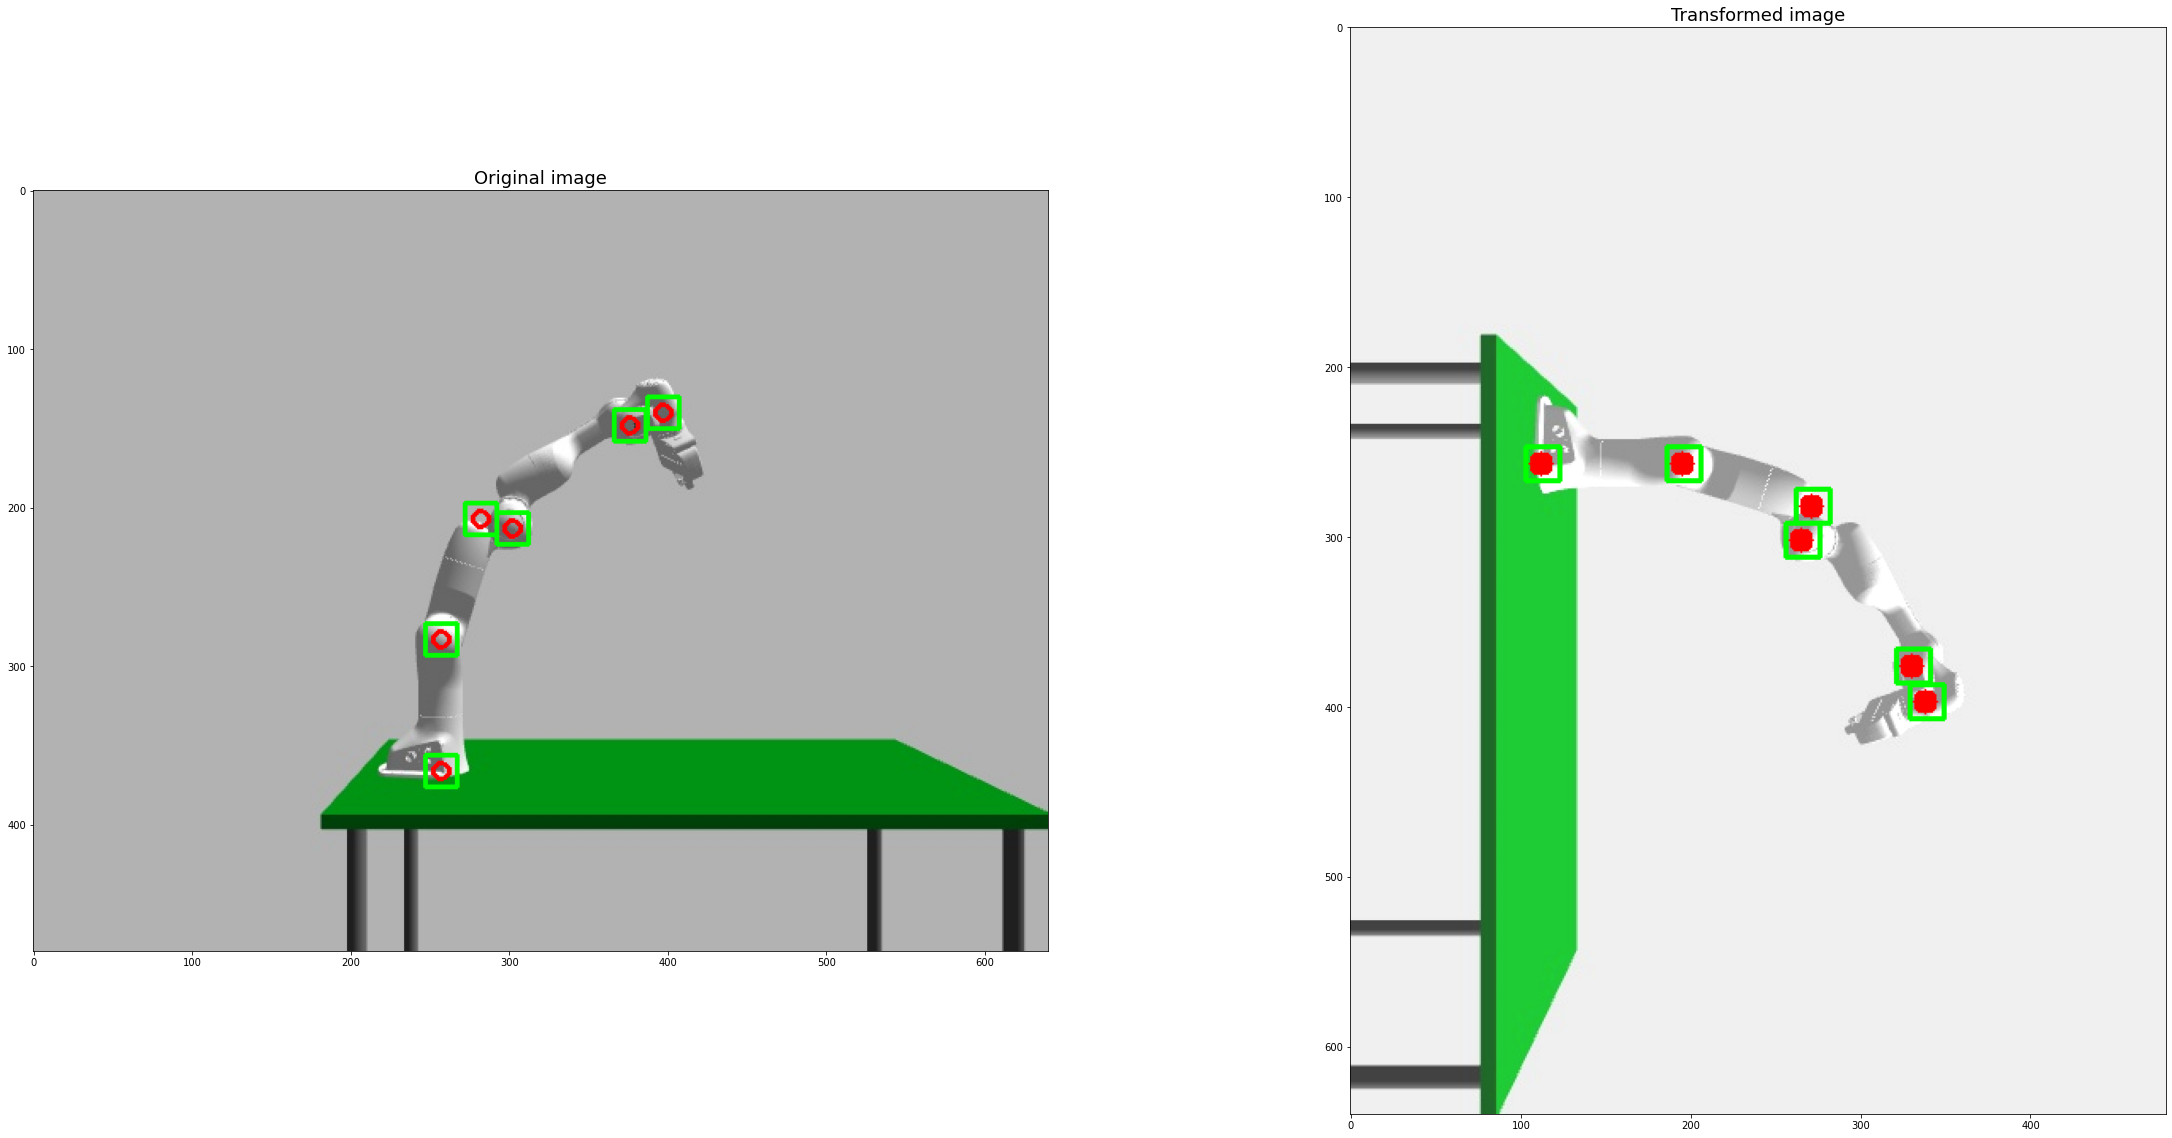

In [8]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'panda_finger_1', 9:'panda_finger_2'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [9]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj):
#         print("shape of x", x.shape)
#         print("shape of adj", adj.shape)
        batch_size = adj.size(0)  # Assuming adj_matrix has a shape of [batch_size, 6, 6]
        if x.dim() == 2:
            # It means we have the shape [6, 3] for x, adjust accordingly
            x = x.unsqueeze(0).expand(batch_size, -1, -1).cuda()
        else:
            # We assume the shape is [6, 6, 128]
            "Do Nothing"
        out = torch.bmm(adj, x)
        print("bmm output, how does it look", out)
        out = self.fc(out)
        return out

In [10]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.keypoint_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, num_keypoints=6, num_classes=7)
        self.graph_conv1 = GraphConv(3, 128)
        self.graph_conv2 = GraphConv(128, 3)
    
    def complete_missing_keypoints(self, keypoints, labels, num_expected_keypoints=6):

        detected_kps = keypoints.shape[0]
        # Check if all keypoints are detected
        if detected_kps == num_expected_keypoints:
            return keypoints
        
        if detected_kps == 0:
            # Placeholder: If no keypoints are detected, set to center or other static position
            default_value = torch.tensor([320, 240, 1], device=keypoints.device)
            missing_kps_tensor = torch.full((num_expected_keypoints, keypoints.shape[1]), default_value)
            return missing_kps_tensor
        
        # Create a placeholder tensor for keypoints with the correct shape
        ordered_keypoints = torch.zeros((num_expected_keypoints, 3), device=keypoints.device)

        # If some keypoints are detected, compute their average position
        average_kp = torch.mean(keypoints, dim=0, keepdim=True)

        for i, label in enumerate(labels):
            ordered_keypoints[label - 1] = keypoints[i]

        # Fill in the missing keypoints with the average position
        missing_indices = (torch.sum(ordered_keypoints, dim=1) == 0).nonzero(as_tuple=True)[0]
        ordered_keypoints[missing_indices] = average_kp

        return ordered_keypoints

    def forward(self, images, adj_matrix=None, targets=None, train=False):
        if train:
            output = self.keypoint_rcnn(images, targets)
#             output = self.keypoint_rcnn(images)
            return output  # This contains the losses during training
        else:
            with torch.no_grad():  # Deactivates autograd, reduces memory usage and speeds up computations
                self.keypoint_rcnn.eval()  # Set to evaluation mode
                output = self.keypoint_rcnn(images)
                self.keypoint_rcnn.train()  # Revert to training mode
            keypoints = output[0]['keypoints'].detach().cpu().numpy()
            kp_score = output[0]['keypoints_scores'].detach().cpu().numpy()
            
            labels = output[0]['labels'].detach().cpu().numpy()                
            unique_labels = list(set(labels))
            scores = output[0]['scores'].detach().cpu().numpy()      
            
            kps = []
            kp_scores = []
            ulabels = []
            
            for label in unique_labels:
                #find the index with highest score for this label
                indices = [i for i,x in enumerate(labels) if x == label]
                scores_for_label = [scores[i] for i in indices]
                max_score_index = indices[scores_for_label.index(max(scores_for_label))]
                kp_score_label = kp_score[max_score_index].tolist()
                # Add corresponding box, keypoint, and label to the result                
                kps.append(keypoints[max_score_index][kp_score_label.index(max(kp_score_label))])  
                ulabels.append(label)
            
            kps = [torch.tensor(kp, dtype=torch.float32) for kp in kps]
            
            print(labels)
            
            if not kps:  # Check if the kps list is empty
                default_value = torch.tensor([320, 240, 1], device=images[0].device)  # Use the device of images for consistency
                keypoints = torch.full((6, 3), default_value)  # Placeholder tensor for the case with no keypoints detected
            else:
                keypoints = torch.stack(kps)
            
            keypoints = torch.stack(kps)
            print("kp before placeholder", keypoints)
            
            keypoints = self.complete_missing_keypoints(keypoints, unique_labels, num_expected_keypoints=6)            
            print("keypoints with placeholder", keypoints)
            
            keypoints = self.graph_conv1(keypoints, adj_matrix)
            keypoints = nn.functional.relu(keypoints)
            keypoints = self.graph_conv2(keypoints, adj_matrix)
#             keypoints = nn.functional.relu(keypoints)
#             keypoints = self.graph_conv3(keypoints, adj_matrix)          
            print("graph predicted keypoints", keypoints)
            return keypoints 


In [11]:
def custom_loss(predicted_keypoints, gt_keypoints, adj_matrix, loss_keypoint):
#     mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    batch_size = adj_matrix.size(0)
    
    normalized_predicted_keypoints = torch.clamp(predicted_keypoints, -1.0, 1.0)
    normalized_gt_keypoints = torch.clamp(gt_keypoints, -1.0, 1.0)
    keypoint_loss = l1_loss(normalized_predicted_keypoints, normalized_gt_keypoints)    
    print("keypoint_loss", keypoint_loss)
    print("predicted_keypoints.shape",predicted_keypoints.shape)
    print("ground_truth_keypoints.shape", gt_keypoints.shape)
    # Compute graph loss as described above
    pairwise_distances_pred_pre = torch.sqrt(torch.sum((predicted_keypoints[:, :-1] - predicted_keypoints[:, 1:])**2, dim=2))
    pairwise_distances_gt_pre = torch.sqrt(torch.sum((gt_keypoints[:, :-1] - gt_keypoints[:, 1:])**2, dim=2))
    pairwise_distances_pred = torch.cat([pairwise_distances_pred_pre.cuda(), torch.zeros(adj_matrix.size(0),1).cuda()], dim=1)
    pairwise_distances_gt = torch.cat([pairwise_distances_gt_pre.cuda(), torch.zeros(adj_matrix.size(0),1).cuda()], dim=1)    
    # Calculate the absolute difference between predicted and ground truth distances
    diff = torch.abs(pairwise_distances_pred - pairwise_distances_gt)
    
#     # Adjusting adjacency matrix to match batch size
#     batch_adj_matrix = adj_matrix.unsqueeze(0).repeat(diff.shape[0], 1, 1)
    # Compute graph loss by only considering the edges present in the adjacency matrix
    graph_loss = torch.sum(diff.unsqueeze(-1) * adj_matrix)
    #     box_loss = mse_loss(predicted_boxes, gt_boxes)
    # Compute pairwise differences
#     diff = predicted_keypoints.unsqueeze(2) - gt_keypoints.unsqueeze(1)  # shape [1, 4, 4, 3]
#     # Square the differences
#     squared_diff = diff**2  # shape [1, 4, 4, 3]
#     # Sum over the coordinate dimension (i.e., sum the squared differences for x, y, z coordinates)
#     squared_diff_summed = squared_diff.sum(dim=-1)  # shape [1, 4, 4]
#     # Use adjacency matrix to mask out unwanted differences and compute the graph loss
#     graph_loss = torch.sum((1 - adj_matrix) * squared_diff_summed)   
    print("graph_loss", graph_loss)
    print("loss keypoint", loss_keypoint)
    
#     total_loss = keypoint_loss + 0.1 * box_loss + 0.01 * graph_loss + loss_keypoint
    total_loss = keypoint_loss + graph_loss + loss_keypoint
    
    return total_loss


In [12]:
def create_adjacency_matrix(num_keypoints):
    # Initialize a zero matrix
    adj_matrix = torch.zeros((num_keypoints, num_keypoints))
    
    # Fill the diagonal above the main diagonal with ones
    for i in range(num_keypoints - 1):
        adj_matrix[i, i + 1] = 1
        
    print("adj", adj_matrix)
        
    return adj_matrix


In [13]:
# Initialize model and optimizer
model = CombinedModel()
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Create adjacency matrix
num_keypoints = 6
adj_matrix = create_adjacency_matrix(num_keypoints).cuda()


/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the fu

adj tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [ ]:
num_epochs = 100
batch_size = 8

KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = train_test_split(root_dir) +"/val"
KEYPOINTS_FOLDER_TEST = train_test_split(root_dir) +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

top_5_models = []

for epoch in range(num_epochs):  # for 50 epochs
    for batch_idx, batch in enumerate(data_loader_train):
        images, targets = batch  
        
        if len(images) != batch_size:
            continue
        
        # Move images to GPU
        images = torch.stack(images).cuda()

        # Move targets to GPU
        for target in targets:
            for key, val in target.items():
                target[key] = val.cuda()
        
        ground_truth_keypoints = [target['keypoints'] for target in targets]
        ground_truth_boxes = [target['boxes'] for target in targets]
        
        # Assuming you want all images to be of size [3, 640, 480]
#         desired_size = (640, 480)  

        # Resize all images to the desired size
#         resized_images = [F.resize(img, desired_size) for img in images]

        ground_truth_keypoints = torch.stack(ground_truth_keypoints).squeeze()
        ground_truth_boxes = torch.stack(ground_truth_boxes)
        
        print("ground truth keypoints shape", ground_truth_keypoints.shape)

#         Create a batched adjacency matrix with the same batch size
        batch_adj_matrix = adj_matrix.repeat(batch_size, 1, 1)
        print(batch_adj_matrix.device)
        
        optimizer.zero_grad()
        
#         # Forward pass for training
#         output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
#         print("Output keypoints shape", output_train.keys())
        
#         #Forward pass for loss
#         predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
        
        
#         print("predicted keypoints", predicted_keypoints.shape)
                
#         loss_keypoint = output_train['loss_keypoint']
        
#         # Compute loss and backpropagate
#         loss = custom_loss(predicted_keypoints, ground_truth_keypoints, 
#                            adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
        
#         loss.backward()
#         optimizer.step()

        # Automatic mixed precision for forward pass
        with autocast():
            output_train = model(images, adj_matrix=batch_adj_matrix, targets=targets, train=True)
            print("Output keypoints shape", output_train.keys())
            
            predicted_keypoints = model(images, adj_matrix=batch_adj_matrix, train=False)
         
            print("predicted keypoints", predicted_keypoints.shape)

            loss_keypoint = output_train['loss_keypoint']

            # Compute loss
            loss = custom_loss(predicted_keypoints, ground_truth_keypoints,
                               adj_matrix=batch_adj_matrix, loss_keypoint=loss_keypoint)
            
            print(loss.device)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        
        # Check if the current model should be saved as a top model
        if len(top_5_models) < 5 or loss.item() < max(top_5_models, key=lambda x: x[0])[0]:
            # Save the model state and loss
            model_state = {
                'epoch': epoch,
                'complete_model': model,
#                 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }
            top_5_models.append((loss.item(), model_state))

            # Sort the list based on loss (ascending order)
            top_5_models.sort(key=lambda x: x[0])

            # If there are more than 5 models, remove the one with the highest loss
            if len(top_5_models) > 5:
                top_5_models.pop()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx + 1}/{len(data_loader_train)}, Loss: {loss.item()}")
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# After all epochs, save the top 5 models to disk
for idx, (_, model_state) in enumerate(top_5_models):
    torch.save(model_state, f'/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_b{batch_size}_e{num_epochs}_{idx+1}.pth')


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 18691.88 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 18133.24 files/s]


/home/jc-merlab/Pictures/Data/split_folder_output-2023-09-21


Copying files: 2662 files [00:00, 18682.68 files/s]


ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 3 4 4 3 6 3 3 3 4 4 6 6 6 3 2 2 4 2 6 3 3 4 3 4 3 5 5 3 4 6 6 4 2 3
 2 3 4 3 2 3 5 3 2 1 4 6 3 4 4 4 4 2 2 5 6 5 4 3 3 1 2 4 6 3 6 6 5 4 4 4 2
 3 3 2 4 6 3 6 1 2 2 4 6 4 3 3 5 3 3 2 3 4 3 2 6 4 6]
kp before placeholder tensor([[ 79.9441, 235.9875,   1.0000],
        [377.2488, 275.4158,   1.0000],
        [230.9650, 282.1480,   1.0000],
        [114.5227, 280.8290,   1.0000],
        [133.4616, 265.9164,   1.0000],
        [275.8056, 257.6732,   1.0000]])
keypoints with placeholder tensor([[ 79.9441, 235.9875,   1.0000],
        [377.2488, 275.4158,   1.0000],
        [230.9650, 282.1480,   1.0000],
        [114.5227, 280.8290,   1.0000],
        [133.4616, 265.9164,   1.0000],
        [275.8056, 257.6732,   1.0000]])
bmm output, how does it look tensor([[[377.2500, 275.5000,   1.0000],
         [2

/home/jc-merlab/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100, Batch 1/117, Loss: 1389.8287353515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 6 4 2 2 2 4 2 2 2 2 2 2 2 4 3 2 2 2 4 2 3 4 3 2 3 2
 2 6 4 2 6 1 2 4 3 2 2 4 6 4 2 3 4 6 2 4 4 2 2 4 4 4 3 4 4 2 2 3 3 3 6 4 6
 4 4 4 4 2 2 4 4 4 3 2 4 2 4 3 2 4 4 3 2 2 2 4 4 4 3]
kp before placeholder tensor([[300.4102, 262.6494,   1.0000],
        [319.2164, 252.0212,   1.0000],
        [465.8724, 547.2166,   1.0000],
        [414.5418, 504.1939,   1.0000],
        [244.8013, 320.2998,   1.0000]])
keypoints with placeholder tensor([[300.4102, 262.6494,   1.0000],
        [319.2164, 252.0212,   1.0000],
        [465.8724, 547.2166,   1.0000],
        [414.5418, 504.1939,   1.0000],
        [348.9684, 377.2762,   1.0000],
        [244.8013, 320.2998,   1.0000]])
bmm output, how does it look tensor([[[319.2500, 252.0000,   1.0000],


Epoch 1/100, Batch 2/117, Loss: 1506.0921630859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 3 4 3 6 3 6 5 5 4 4 2 5 3 5 4 3 3 4 2 6 4 5 3 3 6 3 6 4 4 1 4 4 3 4
 4 3 6 2 5 4 6 6 5 3 5 6 5 1 5 1 6 4 3 5 1 4 5 5 4 4 4 3 4 5 6 5 5 3 5 5 3
 6 6 6 2 6 5 2 5 1 4 3 5 1 1 3 3 3 6 5 4 3 3 4 6 1 4]
kp before placeholder tensor([[180.9310, 312.4551,   1.0000],
        [177.8318, 477.2632,   1.0000],
        [427.8611, 468.5149,   1.0000],
        [161.2040, 342.2448,   1.0000],
        [171.3200, 346.9633,   1.0000],
        [188.4928, 338.6332,   1.0000]])
keypoints with placeholder tensor([[180.9310, 312.4551,   1.0000],
        [177.8318, 477.2632,   1.0000],
        [427.8611, 468.5149,   1.0000],
        [161.2040, 342.2448,   1.0000],
        [171.3200, 346.9633,   1.0000],
        [188.4928, 338.6332,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 3/117, Loss: 1343.0185546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 3 6 4 4 2 6 2 2 4 4 2 4 3 2 2 3 2 6 2 4 6 4 2 4 2 2 2 3 3 4 3 3 4 2 3 2
 2 4 2 3 4 3 2 2 2 2 4 2 3 6 6 2 3 2 2 6 6 3 2 2 4 5 6 4 4 6 4 3 6 3 4 6 4
 2 3 4 2 6 6 6 5 4 4 2 2 6 3 4 4 6 2 4 4 2 2 2 4 3 2]
kp before placeholder tensor([[170.3122, 332.6168,   1.0000],
        [110.7226, 236.1570,   1.0000],
        [161.3142, 581.7107,   1.0000],
        [ 89.0183, 211.8253,   1.0000],
        [111.5670, 265.5067,   1.0000]])
keypoints with placeholder tensor([[128.5869, 325.5633,   1.0000],
        [170.3122, 332.6168,   1.0000],
        [110.7226, 236.1570,   1.0000],
        [161.3142, 581.7107,   1.0000],
        [ 89.0183, 211.8253,   1.0000],
        [111.5670, 265.5067,   1.0000]])
bmm output, how does it look tensor([[[170.2500, 332.5000,   1.0000],
   

Epoch 1/100, Batch 4/117, Loss: 994.8295288085938
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 4 6 6 6 6 6 2 2 6 6 6 6 6 4 2 6 6 2 2 6 4 2 6 6 6 6 6 6 6 6 6 4 4
 6 4 6 6 6 2 1 6 4 6 6 6 4 4 6 4 5 6 6 6 6 6 6 2 3 4 6 2 2 6 4 6 5 3 6 6 6
 6 6 4 4 4 3 6 2 6 6 2 3 6 3 2 6 6 4 5 6 4 6 4 4 4 3]
kp before placeholder tensor([[304.4915, 176.5395,   1.0000],
        [277.9441, 160.5182,   1.0000],
        [255.3732, 361.2062,   1.0000],
        [304.8506, 187.5804,   1.0000],
        [279.1189, 162.3023,   1.0000],
        [312.3693, 212.4977,   1.0000]])
keypoints with placeholder tensor([[304.4915, 176.5395,   1.0000],
        [277.9441, 160.5182,   1.0000],
        [255.3732, 361.2062,   1.0000],
        [304.8506, 187.5804,   1.0000],
        [279.1189, 162.3023,   1.0000],
        [312.3693, 212.4977,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 5/117, Loss: 1548.4288330078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 6 6 6 6 4 1 2 6 6 4 5 4 4 2 2 6 3 2 3 4 2 6 2 4 6 4 2 3 2 4 1 3 5 1
 6 4 6 2 2 1 4 2 4 2 3 2 3 3 4 4 4 4 6 3 4 3 3 4 4 4 4 4 5 1 3 4 4 4 4 2 3
 6 4 3 2 4 2 3 4 3 3 1 4 4 6 2 4 4 4 3 3 3 4 3 4 3 2]
kp before placeholder tensor([[232.4665, 356.3204,   1.0000],
        [264.9402, 360.2894,   1.0000],
        [164.2162, 485.4212,   1.0000],
        [161.0455, 582.0370,   1.0000],
        [251.3077, 375.2431,   1.0000],
        [272.4778, 423.9445,   1.0000]])
keypoints with placeholder tensor([[232.4665, 356.3204,   1.0000],
        [264.9402, 360.2894,   1.0000],
        [164.2162, 485.4212,   1.0000],
        [161.0455, 582.0370,   1.0000],
        [251.3077, 375.2431,   1.0000],
        [272.4778, 423.9445,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 6/117, Loss: 1373.4300537109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 2 4 4 2 2 4 5 4 4 2 4 4 2 2 2 3 5 4 2 3 2 2 2 3 2 5 2 5 2 4 6 6
 2 4 4 2 5 6 5 2 1 3 1 2 2 2 4 4 5 3 2 4 2 3 2 4 3 2 3 3 4 4 4 5 2 5 6 3 2
 6 5 1 2 6 4 5 5 3 2 3 5 5 2 2 4 5 4 1 5 4 5 5 2 2 5]
kp before placeholder tensor([[402.5951, 419.3573,   1.0000],
        [116.5092, 329.9465,   1.0000],
        [448.8024, 412.4865,   1.0000],
        [206.3455, 368.8708,   1.0000],
        [381.8807, 422.0696,   1.0000],
        [234.5435, 347.3208,   1.0000]])
keypoints with placeholder tensor([[402.5951, 419.3573,   1.0000],
        [116.5092, 329.9465,   1.0000],
        [448.8024, 412.4865,   1.0000],
        [206.3455, 368.8708,   1.0000],
        [381.8807, 422.0696,   1.0000],
        [234.5435, 347.3208,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 7/117, Loss: 847.5253295898438
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 2 2 4 4 2 2 2 2 6 2 2 3 4 2 2 6 3 3 2 2 2 1 2 2 6 4 2 3 2 4 2 3 3 4 6
 1 2 2 3 3 2 3 2 4 2 2 3 2 4 3 4 2 2 3 4 4 4 2 2 2 3 2 6 6 2 2 6 2 2 4 2 2
 3 2 4 2 2 3 1 1 2 2 2 2 2 6 6 2 6 2 2 2 5 2 2 2 6 4]
kp before placeholder tensor([[134.9919, 280.1551,   1.0000],
        [314.9686, 171.0107,   1.0000],
        [228.9712, 183.2806,   1.0000],
        [133.2199, 272.8127,   1.0000],
        [108.7604, 252.8152,   1.0000],
        [307.5555, 191.7459,   1.0000]])
keypoints with placeholder tensor([[134.9919, 280.1551,   1.0000],
        [314.9686, 171.0107,   1.0000],
        [228.9712, 183.2806,   1.0000],
        [133.2199, 272.8127,   1.0000],
        [108.7604, 252.8152,   1.0000],
        [307.5555, 191.7459,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 8/117, Loss: 1550.0858154296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 4 2 2 2 2 4 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 3 4 2 5 2 2 2 2 3 3 2 2 2 2 2 2 2 2 4 5 2 2 2 2 2 2 2 2 2 5 5 2 2 4 5
 4 2 3 5 2 3 4 3 2 3 2 2 3 2 2 2 6 1 2 4 4 2 2 5 4 6]
kp before placeholder tensor([[375.8931, 427.4659,   1.0000],
        [341.1107, 372.9442,   1.0000],
        [168.7764, 487.8130,   1.0000],
        [375.5517, 432.8335,   1.0000],
        [384.3464, 391.8103,   1.0000],
        [387.2129, 442.4433,   1.0000]])
keypoints with placeholder tensor([[375.8931, 427.4659,   1.0000],
        [341.1107, 372.9442,   1.0000],
        [168.7764, 487.8130,   1.0000],
        [375.5517, 432.8335,   1.0000],
        [384.3464, 391.8103,   1.0000],
        [387.2129, 442.4433,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 9/117, Loss: 1489.056884765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 4 2 2 4 2 2 4 2 2 4 6 2 4 2 2 2 2 4 2 2 2 4 4 4 2 2 2 6 4 2 4 2 4
 2 2 2 4 2 2 4 4 2 2 4 2 4 4 2 4 4 2 2 4 2 4 4 1 2 2 2 2 4 2 4 2 4 4 6 2 2
 2 4 2 2 3 2 2 4 2 2 1 2 2 2 1 4 5 5 4 2 4 2 2 4 2 2]
kp before placeholder tensor([[163.3774, 381.2294,   1.0000],
        [164.6331, 388.4109,   1.0000],
        [187.6693, 371.2635,   1.0000],
        [149.6566, 409.9237,   1.0000],
        [115.0200, 261.7685,   1.0000],
        [267.9123, 322.1019,   1.0000]])
keypoints with placeholder tensor([[163.3774, 381.2294,   1.0000],
        [164.6331, 388.4109,   1.0000],
        [187.6693, 371.2635,   1.0000],
        [149.6566, 409.9237,   1.0000],
        [115.0200, 261.7685,   1.0000],
        [267.9123, 322.1019,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 10/117, Loss: 1526.9769287109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 4 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 4 2 6 6 6 6
 4 6 6 6 6 4 6 6 6 6 2 6 6 6 6 2 6 6 6 6 2 4 6 6 6 2 6 4 6 2 1 4 6 6 2 6 4
 2 5 6 4 4 4 4 6 6 6 6 3 6 6 6 6 6 4 6 4 6 6 5 4 6 6]
kp before placeholder tensor([[300.5551, 171.8288,   1.0000],
        [270.7796, 176.6564,   1.0000],
        [281.2500, 192.9997,   1.0000],
        [305.4048, 179.2056,   1.0000],
        [279.4315, 162.7075,   1.0000],
        [309.9509, 210.6654,   1.0000]])
keypoints with placeholder tensor([[300.5551, 171.8288,   1.0000],
        [270.7796, 176.6564,   1.0000],
        [281.2500, 192.9997,   1.0000],
        [305.4048, 179.2056,   1.0000],
        [279.4315, 162.7075,   1.0000],
        [309.9509, 210.6654,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 11/117, Loss: 1768.9090576171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 6 2 2 2 2 2 4 6 6 2 6 2 4 2 2 2 2 2 2 5 2 6 2 2 2 2 2 2 2 4 2 2 2
 2 5 2 5 2 3 5 2 2 4 3 2 1 2 5 5 4 4 5 5 2 5 5 5 2 6 3 6 2 2 2 2 5 4 5 5 2
 5 1 5 4 6 5 4 5 4 4 3 2 1 3 3 5 2 4 2 2 5 2 2 5 4 5]
kp before placeholder tensor([[375.3425, 429.8153,   1.0000],
        [233.7103, 355.6937,   1.0000],
        [230.8620, 324.3785,   1.0000],
        [304.7518, 418.0817,   1.0000],
        [373.7526, 419.3592,   1.0000],
        [234.4788, 452.7167,   1.0000]])
keypoints with placeholder tensor([[375.3425, 429.8153,   1.0000],
        [233.7103, 355.6937,   1.0000],
        [230.8620, 324.3785,   1.0000],
        [304.7518, 418.0817,   1.0000],
        [373.7526, 419.3592,   1.0000],
        [234.4788, 452.7167,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 12/117, Loss: 1542.082763671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 4 4 6 4 2 4 4 2 6 4 4 2 4 4 4 2 2 4 6 6 4 2 6 2 5 4 2 2 1 6 2 2 6 4
 1 2 2 2 4 6 2 2 2 2 3 3 2 4 6 5 2 6 2 4 2 2 3 5 2 2 2 6 4 2 2 3 2 2 1 5 3
 2 6 4 2 5 1 4 2 2 2 6 6 6 2 3 2 4 5 2 2 5 6 2 6 4 5]
kp before placeholder tensor([[127.9610, 275.8339,   1.0000],
        [235.6591, 412.4532,   1.0000],
        [144.9666, 288.3248,   1.0000],
        [122.4554, 273.3464,   1.0000],
        [119.3065, 259.6145,   1.0000],
        [265.3747, 329.9326,   1.0000]])
keypoints with placeholder tensor([[127.9610, 275.8339,   1.0000],
        [235.6591, 412.4532,   1.0000],
        [144.9666, 288.3248,   1.0000],
        [122.4554, 273.3464,   1.0000],
        [119.3065, 259.6145,   1.0000],
        [265.3747, 329.9326,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 13/117, Loss: 1704.439208984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 6 6 6 6 2 6 2 6 6 6 6 6 6 6 6 2 6 4 6 6 2 6 6 2 2 6 6 6 6
 6 2 6 6 2 2 6 2 6 2 2 2 6 6 6 6 6 6 6 4 6 6 6 2 6 6 4 6 6 4 6 6 6 4 2 2 4
 2 3 6 6 4 4 6 6 6 2 4 2 2 4 6 2 3 2 5 2 6 6 6 6 2 1]
kp before placeholder tensor([[282.4579, 187.8227,   1.0000],
        [182.9474, 434.1391,   1.0000],
        [229.5372, 406.7712,   1.0000],
        [307.0463, 181.3127,   1.0000],
        [273.1006, 188.0598,   1.0000],
        [317.4402, 212.2646,   1.0000]])
keypoints with placeholder tensor([[282.4579, 187.8227,   1.0000],
        [182.9474, 434.1391,   1.0000],
        [229.5372, 406.7712,   1.0000],
        [307.0463, 181.3127,   1.0000],
        [273.1006, 188.0598,   1.0000],
        [317.4402, 212.2646,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 14/117, Loss: 1398.966796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 6 6 2 2 6 2 2 6 6 6 2 6 2 6 4 6 6 6 6 2 2 6 6 6 6 2 6 6 2 2 2 2
 2 2 6 2 2 6 2 2 6 6 6 6 4 2 6 4 2 6 4 6 6 6 6 6 6 4 6 4 4 4 2 6 4 2 6 4 2
 2 6 6 6 6 6 6 5 1 2 6 6 4 3 4 6 6 2 6 6 4 4 6 4 4 2]
kp before placeholder tensor([[274.3056, 185.5090,   1.0000],
        [307.4979, 327.9356,   1.0000],
        [286.0617, 190.1910,   1.0000],
        [305.7352, 189.2367,   1.0000],
        [273.3644, 185.3814,   1.0000],
        [286.0764, 199.6234,   1.0000]])
keypoints with placeholder tensor([[274.3056, 185.5090,   1.0000],
        [307.4979, 327.9356,   1.0000],
        [286.0617, 190.1910,   1.0000],
        [305.7352, 189.2367,   1.0000],
        [273.3644, 185.3814,   1.0000],
        [286.0764, 199.6234,   1.0000]])
bmm output, how does it look tens

Epoch 1/100, Batch 15/117, Loss: 1723.2445068359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 3 6 4 4 4 2 3 4 4 6 6 4 4 3 3 4 2 3 4 6 4 3 3 3 4 3 4 4 3 3 3 4 3 6 3
 4 4 4 3 4 3 3 3 4 3 4 4 6 3 4 3 3 4 4 4 3 4 4 4 6 3 2 3 3 2 3 6 4 3 4 3 4
 4 4 3 4 4 4 4 6 4 3 4 2 3 3 3 4 3 3 4 4 6 6 4 3 4 6]
kp before placeholder tensor([[332.7572, 295.8794,   1.0000],
        [462.9165, 548.1326,   1.0000],
        [396.5972, 511.1657,   1.0000],
        [221.6993, 458.6014,   1.0000]])
keypoints with placeholder tensor([[353.4926, 453.4448,   1.0000],
        [332.7572, 295.8794,   1.0000],
        [462.9165, 548.1326,   1.0000],
        [396.5972, 511.1657,   1.0000],
        [353.4926, 453.4448,   1.0000],
        [221.6993, 458.6014,   1.0000]])
bmm output, how does it look tensor([[[332.7500, 296.0000,   1.0000],
         [463.0000, 548.0000,   1.0000]

Epoch 1/100, Batch 16/117, Loss: 1554.7860107421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 2 2 2 6 6 2 4 6 6 2 6 2 2 4 4 2 2 6 2 6 2 2 4 3 2 2 2 2 3 4 6 2 2 2 2
 2 3 3 3 2 2 4 2 6 2 3 2 6 2 2 2 2 2 2 2 2 4 4 3 6 6 3 3 2 4 2 6 2 2 6 2 3
 3 4 2 4 3 4 2 2 4 2 1 4 3 6 6 4 2 2 6 4 2 2 2 2 2 3]
kp before placeholder tensor([[170.7201, 541.1491,   1.0000],
        [169.6098, 220.4258,   1.0000],
        [471.4580, 528.3431,   1.0000],
        [398.6888, 491.9446,   1.0000],
        [135.1258, 368.3790,   1.0000]])
keypoints with placeholder tensor([[170.7201, 541.1491,   1.0000],
        [169.6098, 220.4258,   1.0000],
        [471.4580, 528.3431,   1.0000],
        [398.6888, 491.9446,   1.0000],
        [269.1205, 430.0483,   1.0000],
        [135.1258, 368.3790,   1.0000]])
bmm output, how does it look tensor([[[169.6250, 220.3750,   1.0000],

Epoch 1/100, Batch 17/117, Loss: 1376.4952392578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 6 4 6 6 6 6 6 4 6 6 6 3 6 6 6 6 6 6 3 3 6 6 6 6 6 6 6 6 4 6 6 6 3 6
 6 6 4 4 6 6 6 4 4 4 4 6 4 3 6 6 6 6 3 3 3 6 3 6 6 2 4 6 6 6 4 6 1 3 3 2 2
 4 4 6 3 3 6 4 6 3 5 4 3 3 4 2 4 4 6 3 6 4 6 4 4 4 3]
kp before placeholder tensor([[212.3673, 250.9016,   1.0000],
        [296.2001, 168.8277,   1.0000],
        [192.8914, 228.0022,   1.0000],
        [184.1895, 242.5761,   1.0000],
        [307.2271, 185.1409,   1.0000],
        [193.4868, 243.1490,   1.0000]])
keypoints with placeholder tensor([[212.3673, 250.9016,   1.0000],
        [296.2001, 168.8277,   1.0000],
        [192.8914, 228.0022,   1.0000],
        [184.1895, 242.5761,   1.0000],
        [307.2271, 185.1409,   1.0000],
        [193.4868, 243.1490,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 18/117, Loss: 1675.3529052734375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 2 4 6 4 6 4 6 4 6 2 2 5 2 6 4 2 4 3 4 6 2 6 4 2 2 6 2 2 2 3 2 2 2
 6 4 6 4 2 3 2 6 5 3 3 3 5 6 4 6 3 3 5 2 6 5 4 4 2 4 5 6 6 3 2 2 5 6 4 2 6
 2 2 2 3 5 4 2 4 2 4 2 3 4 6 6 2 3 6 2 6 2 6 4 5 2 3]
kp before placeholder tensor([[242.3038, 286.8745,   1.0000],
        [165.4887, 246.9092,   1.0000],
        [253.3107, 312.2158,   1.0000],
        [130.6986, 264.1507,   1.0000],
        [264.5939, 425.4380,   1.0000]])
keypoints with placeholder tensor([[211.2791, 307.1177,   1.0000],
        [242.3038, 286.8745,   1.0000],
        [165.4887, 246.9092,   1.0000],
        [253.3107, 312.2158,   1.0000],
        [130.6986, 264.1507,   1.0000],
        [264.5939, 425.4380,   1.0000]])
bmm output, how does it look tensor([[[242.2500, 286.7500,   1.0000],

Epoch 1/100, Batch 19/117, Loss: 1423.957275390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 4 4 4 2 2 4 4 2 4 2 4 1 4 2 2 6 2 5 5 2 6 5 2 5 2 1 4 5 2 2 4 4 2 5
 6 3 5 4 5 2 2 6 5 1 2 6 4 2 4 5 5 6 2 4 4 5 2 2 2 5 2 2 4 5 5 2 2 6 2 2 5
 2 4 2 3 2 2 5 6 2 2 1 4 5 3 3 3 2 2 3 6 3 4 2 4 6 3]
kp before placeholder tensor([[336.1169, 377.0398,   1.0000],
        [313.5428, 415.9906,   1.0000],
        [331.2689, 416.3443,   1.0000],
        [144.8595, 536.1316,   1.0000],
        [381.2730, 404.9825,   1.0000],
        [179.0198, 524.9192,   1.0000]])
keypoints with placeholder tensor([[336.1169, 377.0398,   1.0000],
        [313.5428, 415.9906,   1.0000],
        [331.2689, 416.3443,   1.0000],
        [144.8595, 536.1316,   1.0000],
        [381.2730, 404.9825,   1.0000],
        [179.0198, 524.9192,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 20/117, Loss: 1112.531982421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 3 2 2 2 2 6 4 2 2 2 2 2 4 4 2 2 1 2 6 2 2 2 6 6 2 4 3 2 3 2
 6 2 2 3 2 1 2 6 3 6 2 2 3 2 6 3 2 2 2 2 6 4 2 4 6 4 3 3 3 2 3 2 4 3 3 2 6
 3 6 6 3 2 4 3 3 6 5 2 3 3 2 6 2 2 6 6 1 3 6 4 2 4 6]
kp before placeholder tensor([[293.2018, 263.8039,   1.0000],
        [321.2601, 261.7898,   1.0000],
        [158.4894, 471.9491,   1.0000],
        [408.2204, 475.4276,   1.0000],
        [230.4039, 319.1117,   1.0000],
        [188.1455, 472.3192,   1.0000]])
keypoints with placeholder tensor([[293.2018, 263.8039,   1.0000],
        [321.2601, 261.7898,   1.0000],
        [158.4894, 471.9491,   1.0000],
        [408.2204, 475.4276,   1.0000],
        [230.4039, 319.1117,   1.0000],
        [188.1455, 472.3192,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 21/117, Loss: 900.519287109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 6 6 6 3 4 2 4 4 4 3 6 4 6 2 6 6 3 6 2 2 4 6 6 4 6 6 3 2 6 6 6 6 6 6
 3 4 4 2 3 2 3 3 6 6 2 6 2 2 6 2 6 6 3 2 6 2 2 3 2 2 6 4 5 2 6 4 3 2 2 2 6
 4 6 2 4 6 2 6 1 3 6 4 2 6 4 3 6 3 6 4 3 3 4 3 3 4 6]
kp before placeholder tensor([[173.1870, 543.9388,   1.0000],
        [176.0651, 482.9227,   1.0000],
        [465.6232, 548.1140,   1.0000],
        [401.3503, 473.3490,   1.0000],
        [ 85.6610, 321.7944,   1.0000],
        [192.6557, 433.7013,   1.0000]])
keypoints with placeholder tensor([[173.1870, 543.9388,   1.0000],
        [176.0651, 482.9227,   1.0000],
        [465.6232, 548.1140,   1.0000],
        [401.3503, 473.3490,   1.0000],
        [ 85.6610, 321.7944,   1.0000],
        [192.6557, 433.7013,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 22/117, Loss: 1227.2933349609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 3 4 4 2 2 2 6 4 4 4 6 4 4 3 4 2 4 6 2 4 2 2 3 4 3 2 3 4 3 4 2 2 2 4 3 3
 4 2 2 2 2 3 3 3 2 2 3 2 4 4 4 2 2 4 2 2 3 2 2 4 4 2 4 4 4 2 2 2 4 2 6 4 4
 4 4 4 3 4 4 4 4 2 4 2 3 2 4 2 6 6 4 2 2 5 2 3 6 6 2]
kp before placeholder tensor([[299.2605, 418.1702,   1.0000],
        [156.2943, 467.9928,   1.0000],
        [160.7456, 556.5645,   1.0000],
        [227.7156, 309.2148,   1.0000],
        [206.3380, 389.3323,   1.0000]])
keypoints with placeholder tensor([[210.0708, 428.2549,   1.0000],
        [299.2605, 418.1702,   1.0000],
        [156.2943, 467.9928,   1.0000],
        [160.7456, 556.5645,   1.0000],
        [227.7156, 309.2148,   1.0000],
        [206.3380, 389.3323,   1.0000]])
bmm output, how does it look tensor([[[299.2500, 418.2500,   1.0000],

Epoch 1/100, Batch 23/117, Loss: 1285.4981689453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2
 2 2 2 4 2 4 2 2 2 2 4 2 2 2 2 2 2 4 4 4 6 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 6 2 4 2 2 2 2 2 2 4 1 2 4 2 2 2 2 2 6 5 4 2 2 2 2]
kp before placeholder tensor([[169.7945, 301.5038,   1.0000],
        [126.6497, 271.1835,   1.0000],
        [252.8270, 367.7292,   1.0000],
        [381.5773, 406.4445,   1.0000],
        [362.8108, 410.9890,   1.0000]])
keypoints with placeholder tensor([[169.7945, 301.5038,   1.0000],
        [126.6497, 271.1835,   1.0000],
        [258.7319, 351.5700,   1.0000],
        [252.8270, 367.7292,   1.0000],
        [381.5773, 406.4445,   1.0000],
        [362.8108, 410.9890,   1.0000]])
bmm output, how does it look tensor([[[126.6250, 271.2500,   1.0000],

Epoch 1/100, Batch 24/117, Loss: 1586.3013916015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 1 4 4 2 2 3 3 2 2 4 4 2 3 2 3 3 3 2 6 4 2 2 2 3 3 3 3 3 3 2 2 2 5 2
 2 5 2 6 3 3 4 2 3 3 2 2 4 2 3 6 2 2 2 1 4 1 6 2 2 6 4 3 6 4 5 2 2 2 4 2 2
 2 5 6 2 2 2 6 4 2 2 2 4 3 4 5 4 2 2 2 3 4 4 6 3 3 4]
kp before placeholder tensor([[305.4239, 183.4195,   1.0000],
        [356.4569, 184.0084,   1.0000],
        [274.9319, 198.4429,   1.0000],
        [138.2403, 251.9991,   1.0000],
        [139.1213, 279.1864,   1.0000],
        [102.6994, 265.3891,   1.0000]])
keypoints with placeholder tensor([[305.4239, 183.4195,   1.0000],
        [356.4569, 184.0084,   1.0000],
        [274.9319, 198.4429,   1.0000],
        [138.2403, 251.9991,   1.0000],
        [139.1213, 279.1864,   1.0000],
        [102.6994, 265.3891,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 25/117, Loss: 1614.8238525390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 3 3 4 6 4 3 3 3 6 3 3 3 4 6 3 4 3 4 6 6 6 4 4 4 3 3 4 4 4 3 3 4 3
 3 4 1 4 2 4 4 3 3 3 6 3 6 6 2 4 6 6 2 3 2 4 2 6 6 4 4 2 4 6 6 2 2 2 3 4 3
 4 3 3 4 4 4 4 2 4 4 4 4 3 4 3 4 2 6 4 3 4 6 4 3 4 6]
kp before placeholder tensor([[264.9111, 328.1339,   1.0000],
        [167.6775, 466.5393,   1.0000],
        [331.2526, 315.1452,   1.0000],
        [161.1452, 557.4576,   1.0000],
        [171.7556, 451.4750,   1.0000]])
keypoints with placeholder tensor([[264.9111, 328.1339,   1.0000],
        [167.6775, 466.5393,   1.0000],
        [331.2526, 315.1452,   1.0000],
        [161.1452, 557.4576,   1.0000],
        [219.3484, 423.7502,   1.0000],
        [171.7556, 451.4750,   1.0000]])
bmm output, how does it look tensor([[[167.6250, 466.5000,   1.0000],

Epoch 1/100, Batch 26/117, Loss: 1029.3701171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 4 2 2 2 2 2 4 2 2 4 4 2 2 2 1 2 1 4 2 2 2 5 2 2 6 2 2 6 2 6 2 1 2
 2 2 2 2 2 2 5 2 5 5 2 2 5 1 2 4 2 2 5 2 2 2 2 2 5 2 6 2 5 5 2 2 6 4 4 2 2
 2 1 5 4 2 2 5 2 1 2 2 2 2 5 1 6 2 2 2 4 5 2 2 2 2 2]
kp before placeholder tensor([[246.6399, 230.1878,   1.0000],
        [239.9571, 216.6953,   1.0000],
        [295.3253, 400.9362,   1.0000],
        [373.4647, 407.3605,   1.0000],
        [238.8672, 235.2561,   1.0000]])
keypoints with placeholder tensor([[246.6399, 230.1878,   1.0000],
        [239.9571, 216.6953,   1.0000],
        [278.8508, 298.0872,   1.0000],
        [295.3253, 400.9362,   1.0000],
        [373.4647, 407.3605,   1.0000],
        [238.8672, 235.2561,   1.0000]])
bmm output, how does it look tensor([[[240.0000, 216.7500,   1.0000],
  

Epoch 1/100, Batch 27/117, Loss: 1700.606201171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2
 4 2 2 2 4 2 2 2 3 2 2 2 2 2 2 2 2 2 5 2 2 4 3 2 6 2 4 2 4 3 2 2 6 3 4 2 2
 3 2 4 2 2 6 4 2 5 2 3 2 2 4 2 2 5 6 2 5 2 2 3 4 2 4]
kp before placeholder tensor([[313.1924, 406.4137,   1.0000],
        [216.2673, 427.7373,   1.0000],
        [351.9634, 405.2928,   1.0000],
        [380.9726, 408.2833,   1.0000],
        [344.7836, 406.8294,   1.0000]])
keypoints with placeholder tensor([[321.4359, 410.9113,   1.0000],
        [313.1924, 406.4137,   1.0000],
        [216.2673, 427.7373,   1.0000],
        [351.9634, 405.2928,   1.0000],
        [380.9726, 408.2833,   1.0000],
        [344.7836, 406.8294,   1.0000]])
bmm output, how does it look tensor([[[313.2500, 406.5000,   1.0000],


Epoch 1/100, Batch 28/117, Loss: 1541.7816162109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 4 6 4 6 4 6 3 6 3 6 4 3 4 4 3 4 6 6 4 3 6 3 3 2 3 4 4 2 3 3 3 6 6 3 3 6
 4 3 5 6 4 3 3 6 3 4 6 6 4 6 3 6 2 3 6 6 4 1 1 6 6 6 3 3 2 3 6 4 3 4 6 3 6
 4 6 4 6 3 3 3 3 6 3 6 6 2 4 6 4 4 6 3 3 6 4 6 3 3 4]
kp before placeholder tensor([[270.3280, 244.8677,   1.0000],
        [212.3924, 468.9062,   1.0000],
        [160.5929, 469.2173,   1.0000],
        [401.6526, 474.5394,   1.0000],
        [227.4768, 316.1390,   1.0000],
        [180.5957, 460.3362,   1.0000]])
keypoints with placeholder tensor([[270.3280, 244.8677,   1.0000],
        [212.3924, 468.9062,   1.0000],
        [160.5929, 469.2173,   1.0000],
        [401.6526, 474.5394,   1.0000],
        [227.4768, 316.1390,   1.0000],
        [180.5957, 460.3362,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 29/117, Loss: 676.7342529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 6 6 2 4 6 6 4 6 6 6 2 6 6 2 4 2 6 6 4 6 6 6 4 6 6 6 6 2 4 6 4 4 6 6 6
 6 6 6 6 2 6 6 2 2 6 6 2 6 6 6 6 4 6 4 6 6 2 4 6 6 2 6 6 6 2 4 6 6 2 6 6 4
 6 4 4 6 6 4 4 6 4 4 2 2 6 2 2 6 3 4 4 4 4 1 4 6 4 6]
kp before placeholder tensor([[283.3233, 201.4822,   1.0000],
        [304.8002, 192.8956,   1.0000],
        [281.6910, 226.5060,   1.0000],
        [305.1039, 179.3538,   1.0000],
        [313.1597, 205.9225,   1.0000]])
keypoints with placeholder tensor([[283.3233, 201.4822,   1.0000],
        [304.8002, 192.8956,   1.0000],
        [281.6910, 226.5060,   1.0000],
        [305.1039, 179.3538,   1.0000],
        [297.6156, 201.2320,   1.0000],
        [313.1597, 205.9225,   1.0000]])
bmm output, how does it look tensor([[[304.7500, 192.8750,   1.0000],


Epoch 1/100, Batch 30/117, Loss: 1796.287109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2
 4 2 4 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 6 2 5 5 2 4 2 2 2 6 2 5 2 2
 2 4 2 2 3 2 2 2 2 1 2 4 2 2 2 2 2 5 6 2 2 2 2 5 5 2]
kp before placeholder tensor([[363.4387, 378.2419,   1.0000],
        [ 97.8920, 294.7424,   1.0000],
        [142.9434, 348.2448,   1.0000],
        [ 99.6507, 345.4767,   1.0000],
        [378.2656, 409.1464,   1.0000],
        [142.2679, 349.7406,   1.0000]])
keypoints with placeholder tensor([[363.4387, 378.2419,   1.0000],
        [ 97.8920, 294.7424,   1.0000],
        [142.9434, 348.2448,   1.0000],
        [ 99.6507, 345.4767,   1.0000],
        [378.2656, 409.1464,   1.0000],
        [142.2679, 349.7406,   1.0000]])
bmm output, how does it look tens

Epoch 1/100, Batch 31/117, Loss: 1587.69384765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 3 2 6 4 6 2 4 2 2 2 2
 2 2 6 4 2 2 2 2 6 2 6 2 4 2 5 3 6 4 2 2 4 2 2 2 3 3 2 6 2 2 2 2 6 2 6 2 2
 2 2 2 3 2 6 2 2 4 6 3 6 6 6 4 2 2 2 2 4 4 6 3 2 3 2]
kp before placeholder tensor([[195.8905, 319.4273,   1.0000],
        [160.5901, 469.2180,   1.0000],
        [401.6570, 474.5294,   1.0000],
        [137.4195, 140.2104,   1.0000],
        [153.0013, 181.2068,   1.0000]])
keypoints with placeholder tensor([[209.7117, 316.9184,   1.0000],
        [195.8905, 319.4273,   1.0000],
        [160.5901, 469.2180,   1.0000],
        [401.6570, 474.5294,   1.0000],
        [137.4195, 140.2104,   1.0000],
        [153.0013, 181.2068,   1.0000]])
bmm output, how does it look tensor([[[195.8750, 319.5000,   1.0000],
 

Epoch 1/100, Batch 32/117, Loss: 995.457763671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 4 2 4 1 2 4 2 2 6 2 3 2 4 2 3 4 2 3 2 4 2 2 2 2 6 2 3 3 2 1 2 6 4 2 2
 4 2 4 2 6 2 2 2 3 2 1 2 6 6 2 2 2 2 2 4 2 2 4 2 2 2 2 2 1 2 2 6 3 3 2 6 2
 2 4 2 2 2 2 2 2 2 2 2 2 6 2 4 2 4 2 2 6 3 6 6 6 4 4]
kp before placeholder tensor([[135.6703, 269.6991,   1.0000],
        [333.8597, 203.2276,   1.0000],
        [212.4685, 202.4777,   1.0000],
        [133.2943, 269.5916,   1.0000],
        [335.7023, 221.2600,   1.0000]])
keypoints with placeholder tensor([[135.6703, 269.6991,   1.0000],
        [333.8597, 203.2276,   1.0000],
        [212.4685, 202.4777,   1.0000],
        [133.2943, 269.5916,   1.0000],
        [230.1990, 233.2512,   1.0000],
        [335.7023, 221.2600,   1.0000]])
bmm output, how does it look tensor([[[333.7500, 203.2500,   1.0000],
 

Epoch 1/100, Batch 33/117, Loss: 1188.7149658203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 4 2 2 2 2 2 4 2 2 2 2 6 4 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 4 2 2 4 2 2 2
 2 2 2 2 2 4 2 2 2 2 3 4 4 3 2 2 2 2 2 2 2 2 2 2 2 2]
kp before placeholder tensor([[224.5612, 138.0122,   1.0000],
        [467.9415, 548.7333,   1.0000],
        [160.7600, 556.5759,   1.0000],
        [211.7088, 137.2644,   1.0000]])
keypoints with placeholder tensor([[266.2429, 345.1464,   1.0000],
        [224.5612, 138.0122,   1.0000],
        [467.9415, 548.7333,   1.0000],
        [160.7600, 556.5759,   1.0000],
        [266.2429, 345.1464,   1.0000],
        [211.7088, 137.2644,   1.0000]])
bmm output, how does it look tensor([[[224.5000, 138.0000,   1.0000],
         [468.0000, 548.5000,   1.0000]

Epoch 1/100, Batch 34/117, Loss: 984.09814453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 2 5 4 5 2 4 5 5 5 2 3 5 5 2 5 5 5 4 4 5 5 5 4 5 4 5 2 5 5 5 6 5 6 6 2 2
 5 5 5 4 4 4 1 2 4 4 5 4 5 2 2 2 2 2 2 4 2 3 4 2 4 4 5 4 3 5 3 2 3 5 4 2 3
 5 2 4 5 2 2 3 5 3 5 4 4 4 4 4 3 2 5 2 4 2 2 2 3 5 2]
kp before placeholder tensor([[125.5435, 237.6381,   1.0000],
        [302.7177, 205.4486,   1.0000],
        [336.3124, 208.5987,   1.0000],
        [300.2233, 214.7344,   1.0000],
        [332.7483, 232.7159,   1.0000],
        [318.9210, 229.0624,   1.0000]])
keypoints with placeholder tensor([[125.5435, 237.6381,   1.0000],
        [302.7177, 205.4486,   1.0000],
        [336.3124, 208.5987,   1.0000],
        [300.2233, 214.7344,   1.0000],
        [332.7483, 232.7159,   1.0000],
        [318.9210, 229.0624,   1.0000]])
bmm output, how does it look ten

Epoch 1/100, Batch 35/117, Loss: 1699.405517578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 3 2 4 2 4 4 2 2 2 2 4 4 2 2 6 2 2 1 2 2 2 4 2 2 4 4 2 2 2 1 2 2 2 2
 6 4 2 4 2 6 2 2 2 3 2 6 6 2 2 6 6 2 2 2 2 2 2 1 2 5 4 4 6 2 2 2 4 4 6 2 2
 5 4 5 2 1 5 2 4 2 2 2 2 5 4 2 2 1 2 2 3 2 2 4 4 2 2]
kp before placeholder tensor([[336.9120, 415.4198,   1.0000],
        [345.9050, 365.2649,   1.0000],
        [339.7479, 404.6240,   1.0000],
        [114.5251, 275.8626,   1.0000],
        [ 98.5449, 253.7319,   1.0000],
        [ 98.5805, 260.6058,   1.0000]])
keypoints with placeholder tensor([[336.9120, 415.4198,   1.0000],
        [345.9050, 365.2649,   1.0000],
        [339.7479, 404.6240,   1.0000],
        [114.5251, 275.8626,   1.0000],
        [ 98.5449, 253.7319,   1.0000],
        [ 98.5805, 260.6058,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 36/117, Loss: 1613.692138671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 2 6 6 6 6 6 2 2 6 2 4 6 4 6 6 4 6 2 6 6 6 6 6 6 4 6 4 3 2 6 2 2 6 6 2 1 6
 3 2 2 6 4 3 6 6 6 2 4 6 4 4 4 6 3 6 2 4 4 6 4 3 6 6]
kp before placeholder tensor([[283.7931, 186.3457,   1.0000],
        [288.9488, 169.7444,   1.0000],
        [237.4421, 308.7268,   1.0000],
        [307.2466, 189.0821,   1.0000],
        [316.7672, 204.9021,   1.0000]])
keypoints with placeholder tensor([[283.7931, 186.3457,   1.0000],
        [288.9488, 169.7444,   1.0000],
        [237.4421, 308.7268,   1.0000],
        [307.2466, 189.0821,   1.0000],
        [286.8395, 211.7603,   1.0000],
        [316.7672, 204.9021,   1.0000]])
bmm output, how does it look tensor([[[289.0000, 169.7500,   1.0000],


Epoch 1/100, Batch 37/117, Loss: 1684.8138427734375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 4 2 6 2 6 6 2 6 6 6 6 6 6 4 6 2 6 2 6 6 2 6 6 2 6
 6 2 6 6 6 6 6 6 6 6 6 2 6 2 6 2 6 6 6 6 6 4 6 6 2 6 4 2 6 4 6 6 6 6 4 2 6
 6 2 2 6 4 4 2 6 6 4 2 6 4 2 4 4 2 2 2 4 2 6 4 4 6 4]
kp before placeholder tensor([[372.3034, 452.6959,   1.0000],
        [308.4836, 181.3086,   1.0000],
        [282.8316, 199.4731,   1.0000]])
keypoints with placeholder tensor([[321.2062, 277.8259,   1.0000],
        [372.3034, 452.6959,   1.0000],
        [321.2062, 277.8259,   1.0000],
        [308.4836, 181.3086,   1.0000],
        [321.2062, 277.8259,   1.0000],
        [282.8316, 199.4731,   1.0000]])
bmm output, how does it look tensor([[[372.2500, 452.7500,   1.0000],
         [321.2500, 277.7500,   1.0000],
         [308.5000, 181.2500,   1.0000

Epoch 1/100, Batch 38/117, Loss: 1378.0128173828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 3 6 6 3 6 6 6 6 3 3 6 6 6 6 6 6 4
 6 3 3 6 6 2 6 6 6 1 6 6 6 4 6 6 6 6 6 6 2 6 6 6 6 6 6 5 6 3 6 6 6 6 2 6 6
 3 6 3 4 3 4 6 4 4 4 2 6 2 6 6 3 3 6 6 3 6 4 6 4 4 4]
kp before placeholder tensor([[229.8936, 368.8975,   1.0000],
        [292.1852, 340.1375,   1.0000],
        [217.0439, 373.4319,   1.0000],
        [308.1267, 181.3125,   1.0000],
        [203.9099, 361.6194,   1.0000],
        [284.5026, 202.7740,   1.0000]])
keypoints with placeholder tensor([[229.8936, 368.8975,   1.0000],
        [292.1852, 340.1375,   1.0000],
        [217.0439, 373.4319,   1.0000],
        [308.1267, 181.3125,   1.0000],
        [203.9099, 361.6194,   1.0000],
        [284.5026, 202.7740,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 39/117, Loss: 1399.90673828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 6 3 6 6 4 4 3 4 3 3 2 3 3 3 3 4 4 4 4 2 4 3 3 4 3 3 3 3 4 6 3 3 3 6 4 3
 4 4 3 3 3 6 3 3 4 3 2 2 3 3 4 6 4 3 3 3 4 6 2 4 4 2 4 3 2 3 4 6 3 6 6 2 6
 1 3 3 3 2 3 3 6 2 4 4 4 3 4 3 6 2 3 2 3 3 3 6 3 2 6]
kp before placeholder tensor([[220.1538, 369.2430,   1.0000],
        [177.6068, 461.1028,   1.0000],
        [157.9461, 479.6566,   1.0000],
        [405.2668, 472.4183,   1.0000],
        [292.5814, 432.9029,   1.0000]])
keypoints with placeholder tensor([[220.1538, 369.2430,   1.0000],
        [177.6068, 461.1028,   1.0000],
        [157.9461, 479.6566,   1.0000],
        [405.2668, 472.4183,   1.0000],
        [250.7110, 443.0648,   1.0000],
        [292.5814, 432.9029,   1.0000]])
bmm output, how does it look tensor([[[177.6250, 461.0000,   1.0000],
 

Epoch 1/100, Batch 40/117, Loss: 983.45947265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 2 6 6 4 6 6 6 6 6 6 2 6 6 6 6 6 6
 6 6 2 2 4 2 6 6 4 2 4 6 2 6 6 2 2 2 6 2 2 6 6 6 6 6 2 6 2 2 6 6 6 4 1 3 2
 4 6 2 6 6 6 2 6 6 6 2 6 2 6 2 4 2 2 4 6 6 4 6 3 6 6]
kp before placeholder tensor([[279.3502, 188.1264,   1.0000],
        [335.3432, 359.0222,   1.0000],
        [284.4962, 182.8473,   1.0000],
        [307.8497, 179.8080,   1.0000],
        [289.9373, 199.9187,   1.0000]])
keypoints with placeholder tensor([[279.3502, 188.1264,   1.0000],
        [335.3432, 359.0222,   1.0000],
        [284.4962, 182.8473,   1.0000],
        [307.8497, 179.8080,   1.0000],
        [299.3953, 221.9445,   1.0000],
        [289.9373, 199.9187,   1.0000]])
bmm output, how does it look tensor([[[335.2500, 359.0000,   1.0000],
  

Epoch 1/100, Batch 41/117, Loss: 1834.0552978515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 4 2 2 4 2 2 2 2 4 2 4 2 2 4 2 2 2 2 4 2 2 4 2 2 6 5 2 2 2 2 4 4
 2 2 2 2 2 6 5 1 2 2 5 2 5 5 5 2 5 2 2 6 2 2 2 5 5 4 5 6 3 2 5 4 4 2 2 2 2
 5 2 5 5 2 4 2 2 5 6 2 2 3 2 5 2 2 3 2 1 5 5 5 5 6 5]
kp before placeholder tensor([[361.2191, 379.2559,   1.0000],
        [342.5573, 378.5372,   1.0000],
        [159.7647, 519.0961,   1.0000],
        [354.3610, 403.5207,   1.0000],
        [160.0620, 491.4414,   1.0000],
        [210.7762, 505.8411,   1.0000]])
keypoints with placeholder tensor([[361.2191, 379.2559,   1.0000],
        [342.5573, 378.5372,   1.0000],
        [159.7647, 519.0961,   1.0000],
        [354.3610, 403.5207,   1.0000],
        [160.0620, 491.4414,   1.0000],
        [210.7762, 505.8411,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 42/117, Loss: 937.3718872070312
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 4 2 2 3 2 4 3 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 4 2 2 3 2 2
 3 2 2 3 4 4 3 2 2 2 3 2 2 4 2 3 2 2 3 2 2 2 2 1 2 2 2 2 3 2 4 4 3 3 2 4 2
 4 4 3 2 2 2 2 2 3 2 3 3 2 4 4 4 2 2 4 2 5 4 2 3 2 4]
kp before placeholder tensor([[164.2309, 494.6685,   1.0000],
        [121.7331, 491.4109,   1.0000],
        [172.0497, 490.2230,   1.0000],
        [126.7252, 487.5269,   1.0000],
        [366.5855, 410.0751,   1.0000]])
keypoints with placeholder tensor([[164.2309, 494.6685,   1.0000],
        [121.7331, 491.4109,   1.0000],
        [172.0497, 490.2230,   1.0000],
        [126.7252, 487.5269,   1.0000],
        [366.5855, 410.0751,   1.0000],
        [190.2649, 474.7809,   1.0000]])
bmm output, how does it look tensor([[[121.7500, 491.5000,   1.0000],


Epoch 1/100, Batch 43/117, Loss: 1510.782470703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 3 4 4 4 4 3 3 6 4 4 4 4 3 3 6 3 3 4 4 2 3 4 3 3 4 3 4 3 5 4 2 4 6 2
 3 4 4 4 6 6 4 4 5 3 4 4 1 3 4 4 2 4 3 5 4 6 3 4 2 2 3 6 4 3 4 2 6 3 4 3 2
 4 4 4 6 3 4 6 4 2 6 2 6 2 6 4 3 6 3 6 4 6 4 3 6 2 3]
kp before placeholder tensor([[184.3473, 469.5685,   1.0000],
        [205.3027, 294.9561,   1.0000],
        [156.2945, 470.0988,   1.0000],
        [161.0573, 557.4491,   1.0000],
        [248.9120, 319.7596,   1.0000],
        [269.5169, 426.3144,   1.0000]])
keypoints with placeholder tensor([[184.3473, 469.5685,   1.0000],
        [205.3027, 294.9561,   1.0000],
        [156.2945, 470.0988,   1.0000],
        [161.0573, 557.4491,   1.0000],
        [248.9120, 319.7596,   1.0000],
        [269.5169, 426.3144,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 44/117, Loss: 1392.37939453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 4 4 6 4 3 2 2 2 3 4 2 2 4 2 3 4 2 6 6 2 4 4 6 2 2 2 4 2 4 4 6 4 6 3 2
 2 4 3 2 6 6 2 2 2 4 3 3 3 3 4 6 5 2 4 3 2 2 3 2 2 4 6 2 2 4 6 3 3 6 4 2 2
 4 4 4 6 4 3 4 6 5 2 3 4 4 6 2 6 2 2 3 2 4 3 4 2 4 4]
kp before placeholder tensor([[285.9586, 394.4042,   1.0000],
        [430.5183, 456.8833,   1.0000],
        [206.1575, 301.7001,   1.0000],
        [226.3421, 317.9984,   1.0000],
        [268.1209, 436.8027,   1.0000]])
keypoints with placeholder tensor([[283.4195, 381.5577,   1.0000],
        [285.9586, 394.4042,   1.0000],
        [430.5183, 456.8833,   1.0000],
        [206.1575, 301.7001,   1.0000],
        [226.3421, 317.9984,   1.0000],
        [268.1209, 436.8027,   1.0000]])
bmm output, how does it look tensor([[[286.0000, 394.5000,   1.0000],
 

Epoch 1/100, Batch 45/117, Loss: 1131.1568603515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 2 2 2 2 2 2 2 2 2 2 2 4 2 6 2 6 2 2 2 3 2 2 4 2 2 2 3 2 2 2 6 3 2 6
 2 2 4 2 2 2 2 2 2 2 2 2 4 2 4 2 2 1 2 2 2 6 2 4 2 2 2 2 3 2 6 1 2 1 2 2 2
 2 2 2 4 4 2 3 2 4 4 2 3 3 6 6 3 5 3 6 5 4 4 6 4 3 2]
kp before placeholder tensor([[339.6313, 236.5459,   1.0000],
        [375.8193, 231.4577,   1.0000],
        [245.5468, 200.7401,   1.0000],
        [129.4737, 273.3516,   1.0000],
        [ 98.6195, 253.9279,   1.0000],
        [350.4283, 267.4927,   1.0000]])
keypoints with placeholder tensor([[339.6313, 236.5459,   1.0000],
        [375.8193, 231.4577,   1.0000],
        [245.5468, 200.7401,   1.0000],
        [129.4737, 273.3516,   1.0000],
        [ 98.6195, 253.9279,   1.0000],
        [350.4283, 267.4927,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 46/117, Loss: 1778.8929443359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 2 2 2 2 2 2 2 4 4 2 2 2 2 4 2 2 2 2 3 4 2 2 2 2 2 4 5 2 2 4 2 2
 2 2 2 2 2 2 4 2 2 2 2 2 5 2 5 2 2 2 4 4 2 5 2 2 2 2 2 2 1 2 2 5 4 5 2 2 6
 5 4 2 5 2 4 5 2 2 4 2 2 5 6 5 2 3 2 5 5 2 2 5 2 2 2]
kp before placeholder tensor([[395.1114, 410.0736,   1.0000],
        [ 98.9365, 277.0965,   1.0000],
        [114.6655, 282.3246,   1.0000],
        [109.3430, 274.0905,   1.0000],
        [378.5674, 409.1463,   1.0000],
        [349.8396, 410.6940,   1.0000]])
keypoints with placeholder tensor([[395.1114, 410.0736,   1.0000],
        [ 98.9365, 277.0965,   1.0000],
        [114.6655, 282.3246,   1.0000],
        [109.3430, 274.0905,   1.0000],
        [378.5674, 409.1463,   1.0000],
        [349.8396, 410.6940,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 47/117, Loss: 1299.3414306640625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 6 6 1 6 2 6 4 3 2 4 2 2 2 2 4 3 4 3 2 1 6 2 5 2 6 4 5 2 5 3 4 6 5
 3 4 4 6 5 6 2 4 5 2 2 4 6 3 6 2 5 6 6 2 4 6 4 3 6 4 5 6 3 4 5 4 4 3 6 2 1
 2 2 6 2 2 4 3 6 2 3 4 2 4 3 2 2 5 4 4 2 2 6 3 4 2 6]
kp before placeholder tensor([[155.5170, 257.8631,   1.0000],
        [301.2155, 160.4584,   1.0000],
        [221.5499, 198.1194,   1.0000],
        [ 81.0817, 214.3678,   1.0000],
        [111.7853, 265.6934,   1.0000],
        [136.0925, 248.2026,   1.0000]])
keypoints with placeholder tensor([[155.5170, 257.8631,   1.0000],
        [301.2155, 160.4584,   1.0000],
        [221.5499, 198.1194,   1.0000],
        [ 81.0817, 214.3678,   1.0000],
        [111.7853, 265.6934,   1.0000],
        [136.0925, 248.2026,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 48/117, Loss: 1704.5587158203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
kp before placeholder tensor([[183.0995, 307.7055,   1.0000],
        [349.8360, 406.4906,   1.0000]])
keypoints with placeholder tensor([[266.4677, 357.0981,   1.0000],
        [183.0995, 307.7055,   1.0000],
        [266.4677, 357.0981,   1.0000],
        [349.8360, 406.4906,   1.0000],
        [266.4677, 357.0981,   1.0000],
        [266.4677, 357.0981,   1.0000]])
bmm output, how does it look tensor([[[183.1250, 307.7500,   1.0000],
         [266.5000, 357.0000,   1.0000],
         [349.7500, 406.5000,   1.0000],
         [266.5000, 357.0000,   1.000

Epoch 1/100, Batch 49/117, Loss: 1451.5308837890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 6 6 6 2 2 2 2 2 2 6 2 2 2 2 6 2 6 6 2 2 4 2 6 6 6 2 3 6 6 6 6 6 2 2 2
 2 2 2 6 6 6 2 2 4 6 6 6 6 6 4 2 2 2 2 6 2 2 6 2 2 6 6 6 2 2 2 6 2 2 2 6 6
 6 2 6 2 2 6 6 2 2 4 2 2 6 2 6 2 6 2 6 2 6 2 6 6 2 6]
kp before placeholder tensor([[229.3586, 268.1492,   1.0000],
        [255.6049, 288.3225,   1.0000],
        [305.4509, 186.5273,   1.0000],
        [315.8797, 206.2253,   1.0000]])
keypoints with placeholder tensor([[276.5735, 237.3061,   1.0000],
        [229.3586, 268.1492,   1.0000],
        [255.6049, 288.3225,   1.0000],
        [305.4509, 186.5273,   1.0000],
        [276.5735, 237.3061,   1.0000],
        [315.8797, 206.2253,   1.0000]])
bmm output, how does it look tensor([[[229.3750, 268.2500,   1.0000],
         [255.6250, 288.2500,   1.0000]

Epoch 1/100, Batch 50/117, Loss: 1685.7236328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 4 3 2 2 4 2 2 4 2 3 2 4 2 4 2 2 2 2 4 2 3 2 2 2 2 2 3 3 2
 2 4 2 2 6 2 3 2 3 2 3 3 3 2 4 2 4 3 6 6 3 2 2 3 6 3 2 2 2 2 2 6 2 3 6 3 4
 6 3 2 6 2 3 3 2 3 6 2 2 3 2 2 2 3 2 6 3 3 4 2 4 4 2]
kp before placeholder tensor([[266.9542, 182.0330,   1.0000],
        [158.4552, 474.0259,   1.0000],
        [161.6690, 557.4564,   1.0000],
        [172.4903, 470.1191,   1.0000]])
keypoints with placeholder tensor([[189.8922, 420.9086,   1.0000],
        [266.9542, 182.0330,   1.0000],
        [158.4552, 474.0259,   1.0000],
        [161.6690, 557.4564,   1.0000],
        [189.8922, 420.9086,   1.0000],
        [172.4903, 470.1191,   1.0000]])
bmm output, how does it look tensor([[[267.0000, 182.0000,   1.0000],
         [158.5000, 474.0000,   1.0000],
 

Epoch 1/100, Batch 51/117, Loss: 1470.63330078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 2 2 4 2 6 4 2 2 2 3 6 1 4 4 2 4 3 2 3 3 2 3 3 4 2 2 2 2 2 2 2 2 6 2 2
 4 6 2 3 2 4 4 2 4 2 4 3 2 2 4 2 2 2 3 3 6 3 3 3 6 2 1 2 3 4 3 4 2 3 4 2 2
 2 2 2 2 2 3 2 3 2 2 2 2 2 2 6 3 3 3 3 2 2 4 2 2 3 3]
kp before placeholder tensor([[363.2196, 179.7105,   1.0000],
        [394.5173, 186.9449,   1.0000],
        [348.5892, 182.5506,   1.0000],
        [128.3194, 273.3946,   1.0000],
        [367.9557, 191.9065,   1.0000]])
keypoints with placeholder tensor([[363.2196, 179.7105,   1.0000],
        [394.5173, 186.9449,   1.0000],
        [348.5892, 182.5506,   1.0000],
        [128.3194, 273.3946,   1.0000],
        [320.5202, 202.9014,   1.0000],
        [367.9557, 191.9065,   1.0000]])
bmm output, how does it look tensor([[[394.5000, 187.0000,   1.0000],
 

Epoch 1/100, Batch 52/117, Loss: 1050.30078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 4 2 2 2 3 2 4 2 4 2 2 2 2 2 2 2 2 4 2 4 5 4 5 2 2 2 2 2 3 2 3 4 2 1 5 5 2
 5 2 4 2 6 2 5 5 4 4 5 2 3 5 2 2 3 2 3 2 5 5 1 5 1 2]
kp before placeholder tensor([[334.1663, 399.4810,   1.0000],
        [120.7785, 399.8566,   1.0000],
        [165.5645, 428.9844,   1.0000],
        [125.6765, 415.9695,   1.0000],
        [378.8577, 405.5631,   1.0000],
        [295.2724, 416.0773,   1.0000]])
keypoints with placeholder tensor([[334.1663, 399.4810,   1.0000],
        [120.7785, 399.8566,   1.0000],
        [165.5645, 428.9844,   1.0000],
        [125.6765, 415.9695,   1.0000],
        [378.8577, 405.5631,   1.0000],
        [295.2724, 416.0773,   1.0000]])
bmm output, how does it look tenso

Epoch 1/100, Batch 53/117, Loss: 1253.3807373046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 6 2 6 4 6 2 6 4 6 4 2 2 6 6 4 6 6 6 6
 6 6 6 6 2 6 6 6 6 2 2 6 6 6 6 6 2 6 6 6 6 6 2 2 6 6 2 6 6 2 6 6 2 6 2 2 4
 3 2 6 2 2 2 6 2 6 2 4 3 3 2 6 4 2 2 4 2 4 2 2 2 6 2]
kp before placeholder tensor([[256.1511, 217.3107,   1.0000],
        [250.7940, 238.3096,   1.0000],
        [305.1850, 188.0227,   1.0000],
        [296.2495, 200.8199,   1.0000]])
keypoints with placeholder tensor([[277.0949, 211.1157,   1.0000],
        [256.1511, 217.3107,   1.0000],
        [250.7940, 238.3096,   1.0000],
        [305.1850, 188.0227,   1.0000],
        [277.0949, 211.1157,   1.0000],
        [296.2495, 200.8199,   1.0000]])
bmm output, how does it look tensor([[[256.2500, 217.2500,   1.0000],
         [250.7500, 238.2500,   1.0000]

Epoch 1/100, Batch 54/117, Loss: 1771.5789794921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 4 2 2 2 2 4 4 2 4 2 2 6 2 4 6 4 2 4 2 2 2 2 2 2 2 2 4 4 2 2 2 1 6 6 2
 2 4 4 2 4 2 6 2 4 2 2 4 4 4 2 3 2 4 2 4 2 4 1 2 4 4 3 6 6 3 3 2 4 1 6 3 2
 2 1 4 4 4 4 1 4 2 2 4 2 4 2 4 4 3 4 2 2 2 2 3 4 4 2]
kp before placeholder tensor([[321.8167, 337.7052,   1.0000],
        [333.2946, 340.4088,   1.0000],
        [156.1422, 480.3027,   1.0000],
        [274.9515, 301.7026,   1.0000],
        [188.1715, 457.6281,   1.0000]])
keypoints with placeholder tensor([[321.8167, 337.7052,   1.0000],
        [333.2946, 340.4088,   1.0000],
        [156.1422, 480.3027,   1.0000],
        [274.9515, 301.7026,   1.0000],
        [254.8753, 383.5495,   1.0000],
        [188.1715, 457.6281,   1.0000]])
bmm output, how does it look tensor([[[333.2500, 340.5000,   1.0000],

Epoch 1/100, Batch 55/117, Loss: 1162.3868408203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 4 6 2 2 2 5 6 2 2 2 6 6 4 6 2 2 6 2 2 4 5 2 5 4 6 6 5 2 5 6 5 2 6
 4 6 2 6 5 3 2 2 6 3 6 5 1 4 4 2 5 2 6 6 6 2 6 4 5 6 2 3 2 4 3 6 5 3 2 2 2
 5 2 2 4 4 2 5 5 2 2 4 2 3 4 3 3 4 2 2 6 6 2 6 4 6 2]
kp before placeholder tensor([[140.5112, 245.1205,   1.0000],
        [351.8737, 341.2402,   1.0000],
        [278.3334, 280.9599,   1.0000],
        [114.1292, 233.8598,   1.0000],
        [126.8790, 264.4140,   1.0000],
        [134.2262, 245.3950,   1.0000]])
keypoints with placeholder tensor([[140.5112, 245.1205,   1.0000],
        [351.8737, 341.2402,   1.0000],
        [278.3334, 280.9599,   1.0000],
        [114.1292, 233.8598,   1.0000],
        [126.8790, 264.4140,   1.0000],
        [134.2262, 245.3950,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 56/117, Loss: 1504.6717529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 3 5 4 4 4 5 2 4 4 4 4 4 4 3 3 2 3 4 2 4 2 4 3 2 3 4 2 3 3 3 2 4 3 4 4 2
 5 2 4 4 4 4 5 4 3 4 2 4 4 3 6 6 6 4 4 2 2 6 5 4 4 6 2 5 6 6 2 4 2 4 4 4 3
 4 2 2 3 3 4 3 4 3 4 5 3 3 4 2 4 6 2 4 3 2 4 4 4 3 2]
kp before placeholder tensor([[311.9911, 432.2691,   1.0000],
        [156.2994, 468.0009,   1.0000],
        [160.6452, 557.1489,   1.0000],
        [300.9251, 471.2847,   1.0000],
        [297.5250, 444.9061,   1.0000]])
keypoints with placeholder tensor([[245.4772, 474.7219,   1.0000],
        [311.9911, 432.2691,   1.0000],
        [156.2994, 468.0009,   1.0000],
        [160.6452, 557.1489,   1.0000],
        [300.9251, 471.2847,   1.0000],
        [297.5250, 444.9061,   1.0000]])
bmm output, how does it look tensor([[[312.0000, 432.2500,   1.0000],

Epoch 1/100, Batch 57/117, Loss: 1640.827880859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 2 4 2 5 4 4 5 2 2 2 2 2 5 5 4 2 2 4 5 2 2 2 4 2 2 6 5 2 5 2 6
 5 5 2 6 2 4 2 2 2 2 2 2 2 5 5 2 5 2 2 6 5 6 1 5 6 5 2 2 5 2 2 6 1 5 2 2 2
 4 5 5 5 5 2 2 5 5 2 4 5 6 1 5 2 5 4 2 2 6 1 5 2 2 1]
kp before placeholder tensor([[360.1064, 380.0771,   1.0000],
        [301.0623, 255.3025,   1.0000],
        [262.3334, 359.6403,   1.0000],
        [330.2896, 270.8255,   1.0000],
        [369.3290, 442.7756,   1.0000]])
keypoints with placeholder tensor([[360.1064, 380.0771,   1.0000],
        [301.0623, 255.3025,   1.0000],
        [324.6241, 341.7242,   1.0000],
        [262.3334, 359.6403,   1.0000],
        [330.2896, 270.8255,   1.0000],
        [369.3290, 442.7756,   1.0000]])
bmm output, how does it look tensor([[[301.0000, 255.2500,   1.0000],


Epoch 1/100, Batch 58/117, Loss: 1743.959228515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 4 2 2 6 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 4 2 6 4 2 2 2 2 4 1 2 2 2 2 2 2 6 2 2 2 6 2 6 2 2 2 2
 5 3 2 6 2 2 4 6 2 6 2 2 2 2 6 2 3 2 2 2 2 6 5 1 2 4]
kp before placeholder tensor([[127.4506, 277.4898,   1.0000],
        [330.2894, 358.3857,   1.0000],
        [250.7984, 248.5486,   1.0000],
        [137.3219, 250.7608,   1.0000],
        [112.4731, 261.9275,   1.0000],
        [300.6125, 348.6983,   1.0000]])
keypoints with placeholder tensor([[127.4506, 277.4898,   1.0000],
        [330.2894, 358.3857,   1.0000],
        [250.7984, 248.5486,   1.0000],
        [137.3219, 250.7608,   1.0000],
        [112.4731, 261.9275,   1.0000],
        [300.6125, 348.6983,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 59/117, Loss: 1684.958251953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 6 2 4 6 4 2 2 2 3 2 4 4 2 4 2 2 5 4 4 2 2 5 4 4 6 4 2 2 2 2 5 5 2 2
 4 6 6 2 3 6 2 4 2 2 5 2 2 2 3 2 2 2 2 2 5 3 2 2 3 2 3 2 4 5 2 2 2 2 2 4 4
 2 4 4 2 2 5 5 2 6 2 2 2 6 5 6 2 2 4 2 5 6 2 6 6 3 2]
kp before placeholder tensor([[174.6263, 256.2258,   1.0000],
        [467.9384, 544.5492,   1.0000],
        [161.1241, 557.1778,   1.0000],
        [180.9716, 253.1559,   1.0000],
        [149.1232, 361.4250,   1.0000]])
keypoints with placeholder tensor([[226.7567, 394.5068,   1.0000],
        [174.6263, 256.2258,   1.0000],
        [467.9384, 544.5492,   1.0000],
        [161.1241, 557.1778,   1.0000],
        [180.9716, 253.1559,   1.0000],
        [149.1232, 361.4250,   1.0000]])
bmm output, how does it look tensor([[[174.6250, 256.2500,   1.0000],


Epoch 1/100, Batch 60/117, Loss: 934.9540405273438
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 6 6 2 2 2 2 6 6 2 6 6 2 6 6 6 6 4 2 6 6 6 4 2 6 2 6 6 2 2 6 6 6 2
 6 4 6 2 6 2 6 2 6 2 6 6 2 2 4 2 4 4 2 1 6 6 6 4 6 2 2 6 2 5 2 6 4 2 2 2 2
 6 2 3 4 2 2 6 6 2 6 3 4 2 2 2 6 2 4 2 6 2 6 2 6 6 6]
kp before placeholder tensor([[302.9897, 176.8012,   1.0000],
        [307.4955, 183.9720,   1.0000],
        [214.3441, 266.4108,   1.0000],
        [304.5266, 177.8540,   1.0000],
        [284.7730, 350.6949,   1.0000],
        [322.8196, 190.0115,   1.0000]])
keypoints with placeholder tensor([[302.9897, 176.8012,   1.0000],
        [307.4955, 183.9720,   1.0000],
        [214.3441, 266.4108,   1.0000],
        [304.5266, 177.8540,   1.0000],
        [284.7730, 350.6949,   1.0000],
        [322.8196, 190.0115,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 61/117, Loss: 1351.8255615234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 6 2 6 2 6 2 6 2 6 2 2 6 2 6 6 6 2 6
 2 6 6 2 2 6 2 2 6 6 2 6 2 6 6 6 2 2 2 6 2 6 6 6 6 6 2 6 6 6 6 2 6 4 2 6 4
 2 2 2 2 6 2 2 6 2 2 6 6 6 2 6 2 6 2 2 6 4 6 4 2 4 6]
kp before placeholder tensor([[175.1906, 411.2628,   1.0000],
        [303.9331, 205.5266,   1.0000],
        [320.3945, 206.0727,   1.0000]])
keypoints with placeholder tensor([[266.5061, 274.2874,   1.0000],
        [175.1906, 411.2628,   1.0000],
        [266.5061, 274.2874,   1.0000],
        [303.9331, 205.5266,   1.0000],
        [266.5061, 274.2874,   1.0000],
        [320.3945, 206.0727,   1.0000]])
bmm output, how does it look tensor([[[175.2500, 411.2500,   1.0000],
         [266.5000, 274.2500,   1.0000],
         [304.0000, 205.5000,   1.0000

Epoch 1/100, Batch 62/117, Loss: 1622.743896484375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 2 4 4 2 2 4 2 2 4 6 4 4 6 3 2 4 6 2 6 2 4 2 2 2 2 3 2 2 2 2 4 2 2 2
 5 2 6 3 2 6 2 6 2 2 2 1 2 2 2 4 2 2 1 2 2 2 2 2 2 2 5 2 2 5 3 3 2 6 2 5 6
 5 2 5 6 6 2 5 6 6 6 4 2 1 2 2 2 4 2 2 2 2 2 6 2 2 5]
kp before placeholder tensor([[247.6522, 301.9943,   1.0000],
        [346.1964, 352.6016,   1.0000],
        [335.6882, 353.7962,   1.0000],
        [262.6441, 310.0664,   1.0000],
        [ 99.8104, 259.2438,   1.0000],
        [138.2140, 250.6708,   1.0000]])
keypoints with placeholder tensor([[247.6522, 301.9943,   1.0000],
        [346.1964, 352.6016,   1.0000],
        [335.6882, 353.7962,   1.0000],
        [262.6441, 310.0664,   1.0000],
        [ 99.8104, 259.2438,   1.0000],
        [138.2140, 250.6708,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 63/117, Loss: 1441.2626953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 4 2 2 2 2 6 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 4 4 1 6 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 5 2 6 2 2 2 2 2 2 2]
kp before placeholder tensor([[143.1102, 250.8125,   1.0000],
        [145.9228, 233.2632,   1.0000],
        [238.3086, 361.7444,   1.0000],
        [147.9947, 270.6250,   1.0000],
        [217.6958, 357.2702,   1.0000]])
keypoints with placeholder tensor([[143.1102, 250.8125,   1.0000],
        [145.9228, 233.2632,   1.0000],
        [178.6064, 294.7430,   1.0000],
        [238.3086, 361.7444,   1.0000],
        [147.9947, 270.6250,   1.0000],
        [217.6958, 357.2702,   1.0000]])
bmm output, how does it look tensor([[[145.8750, 233.2500,   1.0000],
  

Epoch 1/100, Batch 64/117, Loss: 1343.5035400390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 4 4 2 2 4 2 2 2 6 4 2 2 3 3 4 6 2 3 2 6 2 4 4 3 6 2 4 6 3 2 2 4
 6 2 3 2 2 3 6 3 3 4 6 2 3 3 6 4 2 2 2 2 3 2 2 6 3 2]
kp before placeholder tensor([[250.8251, 183.3673,   1.0000],
        [158.6413, 479.3266,   1.0000],
        [401.3477, 491.6732,   1.0000],
        [176.5657, 472.6362,   1.0000]])
keypoints with placeholder tensor([[246.8450, 406.7509,   1.0000],
        [250.8251, 183.3673,   1.0000],
        [158.6413, 479.3266,   1.0000],
        [401.3477, 491.6732,   1.0000],
        [246.8450, 406.7509,   1.0000],
        [176.5657, 472.6362,   1.0000]])
bmm output, how does it look tensor([[[250.8750, 183.3750,   1.0000],
         [158.6250, 479.2500,   1.0000]

Epoch 1/100, Batch 65/117, Loss: 824.498779296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 4 2 4 5 2 4
 2 2 2 2 4 5 5 2 2 5 5 4 3 2 2 2 5 2 2 2 2 6 5 2 5 2 2 2 4 5 3 2 2 2 2 5 6
 2 4 5 5 4 2 5 2 5 5 5 4 2 4 4 6 6 2 5 5 5 2 5 5 5 2]
kp before placeholder tensor([[207.9159, 341.0058,   1.0000],
        [443.4746, 424.6709,   1.0000],
        [351.4863,  96.0501,   1.0000],
        [373.4560, 408.2599,   1.0000],
        [177.1092, 386.0851,   1.0000]])
keypoints with placeholder tensor([[310.6884, 331.2144,   1.0000],
        [207.9159, 341.0058,   1.0000],
        [443.4746, 424.6709,   1.0000],
        [351.4863,  96.0501,   1.0000],
        [373.4560, 408.2599,   1.0000],
        [177.1092, 386.0851,   1.0000]])
bmm output, how does it look tensor([[[207.8750, 341.0000,   1.0000],
 

Epoch 1/100, Batch 66/117, Loss: 913.7946166992188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 2 4 4 4 4 2 6 4 2 4 3 3 2 2 2 3 3 2 2 4 6 3 4 2 2 4 4 2 2 2 4 3 6 6 3 3
 6 6 2 4 2 2 6 6 3 3 4 4 2 3 2 2 2 4 3 6 4 2 6 2 2 6 2 4 6 6 6 6 6 2 2 4 4
 2 3 3 3 4 6 4 5 4 2 2 4 6 2 2 4 2 3 4 2 3 4 3 3 4 6]
kp before placeholder tensor([[265.9575, 440.0704,   1.0000],
        [157.9445, 479.6533,   1.0000],
        [400.4492, 473.6211,   1.0000],
        [261.4486, 441.9200,   1.0000],
        [229.3622, 278.3110,   1.0000]])
keypoints with placeholder tensor([[263.0324, 422.7151,   1.0000],
        [265.9575, 440.0704,   1.0000],
        [157.9445, 479.6533,   1.0000],
        [400.4492, 473.6211,   1.0000],
        [261.4486, 441.9200,   1.0000],
        [229.3622, 278.3110,   1.0000]])
bmm output, how does it look tensor([[[266.0000, 440.0000,   1.0000],


Epoch 1/100, Batch 67/117, Loss: 962.638427734375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 4 2 4 2 2 2 5 2 2 4 4 4
 5 2 2 5 5 1 5 1 2 2 2 2 2 2 2 2 5 2 5 2 2 2 4 5 5 2 4 2 6 5 2 4 2 5 3 2 5
 5 5 2 2 2 2 5 4 4 1 1 5 2 5 2 2 2 5 5 2 2 4 2 1 5 5]
kp before placeholder tensor([[206.5310, 253.3824,   1.0000],
        [220.6846, 253.0836,   1.0000],
        [249.3125, 379.6991,   1.0000],
        [346.7901,  93.6079,   1.0000],
        [210.5868, 281.1432,   1.0000],
        [349.8130, 410.6909,   1.0000]])
keypoints with placeholder tensor([[206.5310, 253.3824,   1.0000],
        [220.6846, 253.0836,   1.0000],
        [249.3125, 379.6991,   1.0000],
        [346.7901,  93.6079,   1.0000],
        [210.5868, 281.1432,   1.0000],
        [349.8130, 410.6909,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 68/117, Loss: 1429.04736328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 4 4 6 6 4 6 6 6 2 6 3 6 2 6 6 6 3 4 2 5 6 3 6 6 1 2 2 6 4 3 4 2 6
 5 3 6 2 3 6 6 3 5 3 6 6 2 6 5 4 2 3 2 6 6 2 6 6 6 5 1 6 6 6 4 2 6 4 2 5 2
 6 6 3 6 4 2 4 6 6 6 3 6 6 6 5 6 5 4 2 2 5 6 4 6 5 2]
kp before placeholder tensor([[395.0811, 331.4139,   1.0000],
        [381.0133, 356.0111,   1.0000],
        [260.1523, 282.9651,   1.0000],
        [138.2309, 250.9488,   1.0000],
        [125.1651, 258.0366,   1.0000],
        [134.9978, 242.7116,   1.0000]])
keypoints with placeholder tensor([[395.0811, 331.4139,   1.0000],
        [381.0133, 356.0111,   1.0000],
        [260.1523, 282.9651,   1.0000],
        [138.2309, 250.9488,   1.0000],
        [125.1651, 258.0366,   1.0000],
        [134.9978, 242.7116,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 69/117, Loss: 1577.2874755859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 4 2 2 4 4 6 5 6 4 6 2 2 6 6 4 2 2 4 4 5 2 2 4 2 5 2 2 5 1 4 2
 6 6 6 6 5 6 6 4 2 2 2 4 6 3 4 4 4 2 2 4 2 2 2 2 5 5 5 2 2 4 1 3 3 4 4 6 1
 2 2 6 5 4 5 2 3 2 2 4 2 2 6 2 2 5 4 5 6 2 2 5 4 2 6]
kp before placeholder tensor([[153.5913, 259.2354,   1.0000],
        [333.0659, 235.8555,   1.0000],
        [302.2229, 204.8915,   1.0000],
        [ 83.5495, 218.5440,   1.0000],
        [309.8953, 245.3901,   1.0000],
        [321.5118, 252.6102,   1.0000]])
keypoints with placeholder tensor([[153.5913, 259.2354,   1.0000],
        [333.0659, 235.8555,   1.0000],
        [302.2229, 204.8915,   1.0000],
        [ 83.5495, 218.5440,   1.0000],
        [309.8953, 245.3901,   1.0000],
        [321.5118, 252.6102,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 70/117, Loss: 947.9664916992188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 4 2
 2 4 2 4 4 2 2 4 2 3 2 6 2 2 2 5 3 6 2 2 2 2 4 3 3 2 2 4 2 3 3 4 3 2 2 4 6
 4 2 3 3 2 3 3 5 4 4 4 5 6 6 6 3 2 2 2 6 4 2 4 4 2 2]
kp before placeholder tensor([[264.6743, 164.7632,   1.0000],
        [158.6994, 476.6367,   1.0000],
        [161.3021, 557.4745,   1.0000],
        [269.9827, 154.7931,   1.0000],
        [236.5702, 280.5129,   1.0000]])
keypoints with placeholder tensor([[218.2458, 326.8361,   1.0000],
        [264.6743, 164.7632,   1.0000],
        [158.6994, 476.6367,   1.0000],
        [161.3021, 557.4745,   1.0000],
        [269.9827, 154.7931,   1.0000],
        [236.5702, 280.5129,   1.0000]])
bmm output, how does it look tensor([[[264.7500, 164.7500,   1.0000],


Epoch 1/100, Batch 71/117, Loss: 964.4711303710938
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 3 2 2 2 2 6 2 2 4 6 2 2 4 4 2 6 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 6 4
 2 4 3 2 2 2 6 3 2 4 2 6 6 2 3 2 6 6 2 2 6 2 2 3 3 6 2 2 3 2 2 3 2 6 2 2 2
 3 4 3 2 6 3 2 2 6 6 3 2 6 2 2 2 6 2 6 6 2 2 4 4 2 2]
kp before placeholder tensor([[198.9942, 139.3571,   1.0000],
        [157.9464, 479.6552,   1.0000],
        [155.9755, 291.2347,   1.0000],
        [177.1664, 319.3884,   1.0000]])
keypoints with placeholder tensor([[172.5206, 307.4089,   1.0000],
        [198.9942, 139.3571,   1.0000],
        [157.9464, 479.6552,   1.0000],
        [155.9755, 291.2347,   1.0000],
        [172.5206, 307.4089,   1.0000],
        [177.1664, 319.3884,   1.0000]])
bmm output, how does it look tensor([[[199.0000, 139.3750,   1.0000],
         [158.0000, 479.7500,   1.0000],

Epoch 1/100, Batch 72/117, Loss: 1750.611572265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6 2 6 6 6 2 6 2 6 3 6 6 2 6 6 6 2 3 6 2 2
 6 2 2 3 6 4 3 6 6 3 6 6 6 6 2 6 6 6 3 2 2 2 4 6 2 2 2 3 6 3 2 6 2 3 3 2 3
 4 6 6 6 4 6 6 3 6 2 6 3 6 1 6 4 4 6 6 2 2 3 4 2 6 6]
kp before placeholder tensor([[290.7202, 187.1720,   1.0000],
        [296.5459, 336.2252,   1.0000],
        [312.0395, 350.8708,   1.0000],
        [310.2544, 191.9593,   1.0000],
        [315.2921, 204.5848,   1.0000]])
keypoints with placeholder tensor([[290.7202, 187.1720,   1.0000],
        [296.5459, 336.2252,   1.0000],
        [312.0395, 350.8708,   1.0000],
        [310.2544, 191.9593,   1.0000],
        [304.9704, 254.1624,   1.0000],
        [315.2921, 204.5848,   1.0000]])
bmm output, how does it look tensor([[[296.5000, 336.2500,   1.0000],


Epoch 1/100, Batch 73/117, Loss: 1607.9688720703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 6 4 4 4 4 6 3 4 2 4 6 4 4 4 4 4 3 6 3 4 4 2 2 4 2 4 3 4 4 2 3 4 4 3
 4 4 3 4 2 4 1 4 4 2 2 2 4 4 4 6 1 4 4 3 4 4 4 2 2 3 4 4 2 3 2 2 4 4 3 3 4
 4 3 6 4 2 3 4 3 4 4 3 1 4 2 2 2 5 4 4 4 2 2 4 4 2 4]
kp before placeholder tensor([[164.6249, 543.1888,   1.0000],
        [251.1679, 273.7492,   1.0000],
        [155.1011, 461.3423,   1.0000],
        [160.9355, 557.7614,   1.0000],
        [229.0418, 314.8826,   1.0000],
        [309.3293, 391.7142,   1.0000]])
keypoints with placeholder tensor([[164.6249, 543.1888,   1.0000],
        [251.1679, 273.7492,   1.0000],
        [155.1011, 461.3423,   1.0000],
        [160.9355, 557.7614,   1.0000],
        [229.0418, 314.8826,   1.0000],
        [309.3293, 391.7142,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 74/117, Loss: 1351.96533203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 4 2 6 2 2 2 4 2 2 6 6 2 2 2 2 4 3
 2 2 2 2 2 6 2 2 2 6 4 2 2 2 2 6 3 4 6 3 4 2 6 2 6 2 2 3 4 4 6 3 3 6 2 2 2
 6 2 3 6 3 4 4 4 2 6 2 6 6 6 3 2 2 2 2 2 2 6 2 4 4 3]
kp before placeholder tensor([[195.7536, 142.8507,   1.0000],
        [158.4859, 471.9433,   1.0000],
        [401.3763, 475.1258,   1.0000],
        [192.5221, 186.1475,   1.0000]])
keypoints with placeholder tensor([[237.0345, 319.0168,   1.0000],
        [195.7536, 142.8507,   1.0000],
        [158.4859, 471.9433,   1.0000],
        [401.3763, 475.1258,   1.0000],
        [237.0345, 319.0168,   1.0000],
        [192.5221, 186.1475,   1.0000]])
bmm output, how does it look tensor([[[195.7500, 142.8750,   1.0000],
         [158.5000, 472.0000,   1.0000],


Epoch 1/100, Batch 75/117, Loss: 880.0800170898438
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 2 2 6 1 1 4 3 2 3 2 2 6 2 4 2 2 2 2 6 4 4 2 2 4 2 3 2 4 3 4 2 3 6 2 2
 1 2 2 3 6 1 2 2 2 3 2 1 2 2 2 3 2 2 2 2 6 1 3 2 1 1 2 2 2 6 2 6 2 6 2 2 2
 2 4 2 2 2 2 4 4 1 6 4 4 2 2 2 2 2 2 2 2 4 3 2 2 4 2]
kp before placeholder tensor([[143.3687, 270.5693,   1.0000],
        [356.7660, 153.2768,   1.0000],
        [254.5318, 163.3094,   1.0000],
        [131.0866, 270.5865,   1.0000],
        [339.6507, 158.2131,   1.0000]])
keypoints with placeholder tensor([[143.3687, 270.5693,   1.0000],
        [356.7660, 153.2768,   1.0000],
        [254.5318, 163.3094,   1.0000],
        [131.0866, 270.5865,   1.0000],
        [245.0808, 203.1910,   1.0000],
        [339.6507, 158.2131,   1.0000]])
bmm output, how does it look tensor([[[356.7500, 153.2500,   1.0000],


Epoch 1/100, Batch 76/117, Loss: 1119.2388916015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 6 4 4 2 4 4 2 2 6 2 2 2 4 4 6 4 2 4 3 6 2 2 5 2 2 6 1 2 1 3 2 1 2 2 2
 6 2 2 2 3 2 2 3 2 2 1 4 2 2 5 2 3 2 2 3 2 1 1 2 2 4 2 2 2 2 4 1 6 6 2 6 5
 1 2 6 6 3 6 3 2 2 2 2 2 4 1 2 4 4 6 6 2 1 3 2 6 2 4]
kp before placeholder tensor([[273.1383, 277.0601,   1.0000],
        [331.1634, 338.7778,   1.0000],
        [241.1737, 242.6529,   1.0000],
        [123.7753, 274.4929,   1.0000],
        [320.4294, 377.2232,   1.0000],
        [265.8590, 268.3158,   1.0000]])
keypoints with placeholder tensor([[273.1383, 277.0601,   1.0000],
        [331.1634, 338.7778,   1.0000],
        [241.1737, 242.6529,   1.0000],
        [123.7753, 274.4929,   1.0000],
        [320.4294, 377.2232,   1.0000],
        [265.8590, 268.3158,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 77/117, Loss: 926.7842407226562
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 6 2 2
 2 4 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2
 3 4 2 2 2 2 2 2 2 2 2 3 4 2 6 2 2 5 4 2 2 2 2 3 2 2]
kp before placeholder tensor([[218.2490, 139.5740,   1.0000],
        [155.9940, 472.6164,   1.0000],
        [160.9274, 556.8522,   1.0000],
        [175.9605, 318.5256,   1.0000],
        [206.8122, 164.1255,   1.0000]])
keypoints with placeholder tensor([[183.5886, 330.3388,   1.0000],
        [218.2490, 139.5740,   1.0000],
        [155.9940, 472.6164,   1.0000],
        [160.9274, 556.8522,   1.0000],
        [175.9605, 318.5256,   1.0000],
        [206.8122, 164.1255,   1.0000]])
bmm output, how does it look tensor([[[218.2500, 139.6250,   1.0000],


Epoch 1/100, Batch 78/117, Loss: 1479.009765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 2 6 6 6 6 6 6 6 2 2 6
 6 6 2 6 6 6 4 6 4 6 6 6 6 6 6 6 6 6 6 4 4 6 4 6 6 6 6 6 1 6 6 2 6 6 6 4 6
 2 4 2 4 6 6 6 6 2 4 2 4 6 2 4 4 6 4 6 6 6 4 6 6 2 6]
kp before placeholder tensor([[272.2484, 194.0957,   1.0000],
        [286.4762, 194.3497,   1.0000],
        [260.0438, 201.6217,   1.0000],
        [321.3416, 203.2321,   1.0000]])
keypoints with placeholder tensor([[272.2484, 194.0957,   1.0000],
        [286.4762, 194.3497,   1.0000],
        [285.0275, 198.3248,   1.0000],
        [260.0438, 201.6217,   1.0000],
        [285.0275, 198.3248,   1.0000],
        [321.3416, 203.2321,   1.0000]])
bmm output, how does it look tensor([[[286.5000, 194.3750,   1.0000],
         [285.0000, 198.3750,   1.0000],
  

Epoch 1/100, Batch 79/117, Loss: 1793.6060791015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 2 6 2 2 2 2 2 6 4 4 2 5 3 1 2 4 4 5 5 6 2 2 2 2 4 3 2 6 2 2 2 2 4
 6 2 6 3 2 6 4 2 4 2 2 5 2 2 5 6 6 2 2 4 5 3 6 5 2 3 2 6 2 5 4 2 4 3 5 2 4
 2 2 4 4 4 6 2 5 6 4 2 1 5 1 6 6 2 4 4 3 4 6 3 2 5 2]
kp before placeholder tensor([[142.4818, 252.6053,   1.0000],
        [330.6211, 261.9008,   1.0000],
        [251.5221, 222.7211,   1.0000],
        [ 78.0192, 226.8177,   1.0000],
        [115.2033, 263.3268,   1.0000],
        [360.1052, 360.8757,   1.0000]])
keypoints with placeholder tensor([[142.4818, 252.6053,   1.0000],
        [330.6211, 261.9008,   1.0000],
        [251.5221, 222.7211,   1.0000],
        [ 78.0192, 226.8177,   1.0000],
        [115.2033, 263.3268,   1.0000],
        [360.1052, 360.8757,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 80/117, Loss: 1810.421630859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 4 4 2 4 2 4 2 2 2 2 2 2 2 2 2 4 4 2 2 2 4 5 2 3 2 4 2 2 5 4 5
 5 2 2 5 5 2 4 5 2 2 6 5 2 5 2 2 5 2 2 4 4 5 2 5 2 5 2 2 5 2 5 2 5 4 2 2 2
 2 1 5 2 2 4 2 2 2 5 2 5 2 2 2 1 6 3 5 2 5 5 2 2 5 4]
kp before placeholder tensor([[345.5026, 388.4398,   1.0000],
        [142.7339, 427.4865,   1.0000],
        [109.9773, 432.8604,   1.0000],
        [326.0721, 421.0996,   1.0000],
        [373.7628, 409.4527,   1.0000],
        [124.6555, 437.0598,   1.0000]])
keypoints with placeholder tensor([[345.5026, 388.4398,   1.0000],
        [142.7339, 427.4865,   1.0000],
        [109.9773, 432.8604,   1.0000],
        [326.0721, 421.0996,   1.0000],
        [373.7628, 409.4527,   1.0000],
        [124.6555, 437.0598,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 81/117, Loss: 1486.62744140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 6 2 2 4 2 5 4 2 5 2 2 4 2 2 2 1 6 4 5 4 4 2 1 2 2 2 6 2 6 2 2 2 6
 5 2 2 6 2 2 2 2 2 2 4 2 6 2 3 6 2 2 5 1 4 4 2 2 6 4 4 2 2 5 2 2 5 2 4 6 2
 1 6 5 6 2 6 2 5 1 5 2 6 5 4 3 4 4 2 2 4 2 6 4 6 2 6]
kp before placeholder tensor([[142.0887, 253.6549,   1.0000],
        [147.2919, 263.4309,   1.0000],
        [253.4594, 220.3333,   1.0000],
        [ 79.0057, 226.3685,   1.0000],
        [268.9474, 273.2767,   1.0000],
        [290.0215, 330.4968,   1.0000]])
keypoints with placeholder tensor([[142.0887, 253.6549,   1.0000],
        [147.2919, 263.4309,   1.0000],
        [253.4594, 220.3333,   1.0000],
        [ 79.0057, 226.3685,   1.0000],
        [268.9474, 273.2767,   1.0000],
        [290.0215, 330.4968,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 82/117, Loss: 992.7261962890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 6 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 4 2 2 4 2 3 4 6
 6 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 5 6 2 2 2 2 4 2 2 2]
kp before placeholder tensor([[192.5034, 249.9104,   1.0000],
        [249.6514, 362.2567,   1.0000],
        [345.9105, 399.2614,   1.0000],
        [385.5322, 386.1224,   1.0000],
        [202.6614, 371.0404,   1.0000]])
keypoints with placeholder tensor([[275.2518, 353.7183,   1.0000],
        [192.5034, 249.9104,   1.0000],
        [249.6514, 362.2567,   1.0000],
        [345.9105, 399.2614,   1.0000],
        [385.5322, 386.1224,   1.0000],
        [202.6614, 371.0404,   1.0000]])
bmm output, how does it look tensor([[[192.5000, 249.8750,   1.0000],


Epoch 1/100, Batch 83/117, Loss: 1706.9383544921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 2 4 4 2 2 2 6 2 6 2 2 2 2 3 3 2 2 4 1 2 2 2 2 2 4 2 6 4 3 2 6 2 2 2 4 2
 3 4 4 2 1 6 2 6 2 4 2 2 6 2 2 2 6 6 2 6 2 2 5 2 1 2 6 6 2 2 4 2 2 3 2 2 2
 6 4 6 2 2 2 2 2 3 6 2 6 2 2 2 2 2 2 2 2 2 2 2 6 2 2]
kp before placeholder tensor([[125.3972, 278.7822,   1.0000],
        [369.2934, 315.7209,   1.0000],
        [251.3471, 247.5199,   1.0000],
        [134.2444, 269.2560,   1.0000],
        [ 98.9144, 263.2358,   1.0000],
        [376.2465, 358.8752,   1.0000]])
keypoints with placeholder tensor([[125.3972, 278.7822,   1.0000],
        [369.2934, 315.7209,   1.0000],
        [251.3471, 247.5199,   1.0000],
        [134.2444, 269.2560,   1.0000],
        [ 98.9144, 263.2358,   1.0000],
        [376.2465, 358.8752,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 84/117, Loss: 1940.946044921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 3 2 2 2 2 2 2 1 2 2 2 4 2 2 4 2 2 2 4 2 2 2 2 3 2
 2 2 2 3 2 2 2 2 3 2 3 5 2 5 6 3 6 3 2 3 2 2 5 2 2 3 2 4 2 2 2 1 2 2 1 3 5
 6 2 2 3 6 2 4 4 2 2 1 4 3 4 2 6 2 2 2 4 2 3 4 3 2 5]
kp before placeholder tensor([[234.1987, 270.1567,   1.0000],
        [280.0737, 277.6767,   1.0000],
        [198.9934, 367.7589,   1.0000],
        [193.1517, 358.0991,   1.0000],
        [389.3494, 391.4917,   1.0000],
        [271.4921, 283.1143,   1.0000]])
keypoints with placeholder tensor([[234.1987, 270.1567,   1.0000],
        [280.0737, 277.6767,   1.0000],
        [198.9934, 367.7589,   1.0000],
        [193.1517, 358.0991,   1.0000],
        [389.3494, 391.4917,   1.0000],
        [271.4921, 283.1143,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 85/117, Loss: 1331.35400390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 6 2 2 2 6 2 4 6 4 2 2 2 2
 2 2 2 2 6 2 2 2 2 2 6 2 2 3 2 2 6 2 4 2 2 6 2 2 4 6 3 2 2 2 2 2 4 6 4 2 2
 6 2 2 4 2 4 2 2 2 2 2 2 2 3 2 2 2 2 2 6 6 2 4 2 6 5]
kp before placeholder tensor([[352.2180, 320.0124,   1.0000],
        [251.1696, 220.4753,   1.0000],
        [135.2137, 267.4555,   1.0000],
        [111.8025, 245.2137,   1.0000],
        [340.2001, 335.6441,   1.0000]])
keypoints with placeholder tensor([[238.1208, 277.7602,   1.0000],
        [352.2180, 320.0124,   1.0000],
        [251.1696, 220.4753,   1.0000],
        [135.2137, 267.4555,   1.0000],
        [111.8025, 245.2137,   1.0000],
        [340.2001, 335.6441,   1.0000]])
bmm output, how does it look tensor([[[352.2500, 320.0000,   1.0000],
 

Epoch 1/100, Batch 86/117, Loss: 1872.3902587890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 5 2 2 4 5 2 3 2 4 5 2 6 2 2 5 2 2 5 2 2 2 5 5 2 2 2 4 4 2 4 2 2 5 2 4 2
 5 5 2 2 6 2 6 6 2 2 2 2 3 2 4 4 2 1 4 2 5 5 4 5 5 2 5 2 2 5 2 2 2 4 2 2 4
 6 2 4 5 2 2 2 5 2 4 2 2 2 5 2 2 1 3 2 5 2 4 4 6 2 5]
kp before placeholder tensor([[335.1252, 387.2998,   1.0000],
        [229.1660, 448.1125,   1.0000],
        [272.4063, 417.5383,   1.0000],
        [347.0419,  93.0809,   1.0000],
        [232.4151, 424.4114,   1.0000],
        [297.6323, 415.7883,   1.0000]])
keypoints with placeholder tensor([[335.1252, 387.2998,   1.0000],
        [229.1660, 448.1125,   1.0000],
        [272.4063, 417.5383,   1.0000],
        [347.0419,  93.0809,   1.0000],
        [232.4151, 424.4114,   1.0000],
        [297.6323, 415.7883,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 87/117, Loss: 962.4495849609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 5 4 4 4 4 5 5 5 6 5 5 2 6 5 6 5 4 5 2 6 2 4 5 5 2 6 6 5 2 6 6 2 6 6 2
 6 6 6 2 2 5 6 2 5 6 5 4 4 2 2 2 3 2 4 6 4 2 2 2 2 2 5 5 4 5 5 5 5 4 6 2 5
 6 6 2 5 3 2 2 5 5 6 6 4 6 5 2 5 5 6 2 6 4 4 2 2 5 5]
kp before placeholder tensor([[238.2480, 287.1193,   1.0000],
        [149.3429, 247.7583,   1.0000],
        [115.6577, 232.6547,   1.0000],
        [141.7390, 401.3385,   1.0000],
        [135.0709, 246.7362,   1.0000]])
keypoints with placeholder tensor([[156.0117, 283.1214,   1.0000],
        [238.2480, 287.1193,   1.0000],
        [149.3429, 247.7583,   1.0000],
        [115.6577, 232.6547,   1.0000],
        [141.7390, 401.3385,   1.0000],
        [135.0709, 246.7362,   1.0000]])
bmm output, how does it look tensor([[[238.2500, 287.0000,   1.0000],


Epoch 1/100, Batch 88/117, Loss: 1676.1973876953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 2 4 2 6 2 4 4 4 6 2 4 2 2 2 6 2 2 4 4 4 2 6 2 2 6 2 2 2 2 4 2 2 2
 6 2 3 3 2 1 2 1 2 6 2 4 2 6 6 2 3 2 2 6 2 6 6 2 4 3 6 2 6 5 2 6 2 6 2 4 4
 2 2 6 2 2 5 4 2 2 1 6 2 2 2 2 2 2 2 1 2 3 3 5 2 4 1]
kp before placeholder tensor([[135.0710, 270.5889,   1.0000],
        [333.9208, 319.7043,   1.0000],
        [236.6233, 235.0700,   1.0000],
        [121.3266, 274.9670,   1.0000],
        [ 99.0687, 255.3225,   1.0000],
        [132.7501, 278.1417,   1.0000]])
keypoints with placeholder tensor([[135.0710, 270.5889,   1.0000],
        [333.9208, 319.7043,   1.0000],
        [236.6233, 235.0700,   1.0000],
        [121.3266, 274.9670,   1.0000],
        [ 99.0687, 255.3225,   1.0000],
        [132.7501, 278.1417,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 89/117, Loss: 1618.988525390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 6 5 5 4 6 6 4 6 3 6 5 6 3 6 4 5 5 6 6 5 5 6 2 6 6 4 2 5 5 2 2 4 6 5
 2 6 2 6 5 5 2 5 5 6 4 5 4 5 6 2 5 4 2 6 2 5 4 3 6 2 2 6 4 6 2 6 4 6 4 4 4
 2 4 4 5 2 6 6 5 2 4 6 6 2 2 4 5 2 5 6 6 1 5 2 2 2 5]
kp before placeholder tensor([[103.7402, 232.1193,   1.0000],
        [269.9604, 254.1482,   1.0000],
        [291.1287, 327.2090,   1.0000],
        [ 93.0918, 218.1902,   1.0000],
        [274.1517, 297.6451,   1.0000],
        [136.8422, 246.7524,   1.0000]])
keypoints with placeholder tensor([[103.7402, 232.1193,   1.0000],
        [269.9604, 254.1482,   1.0000],
        [291.1287, 327.2090,   1.0000],
        [ 93.0918, 218.1902,   1.0000],
        [274.1517, 297.6451,   1.0000],
        [136.8422, 246.7524,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 90/117, Loss: 998.6624755859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 6 4 4 3 3 3 4 6 3 6 6 5 4 4 4 4 6 6 4 4 3 4 5 3 3 5 4 3 3 6 3 2 3 2 6 2
 2 5 6 6 3 6 6 3 6 4 6 3 6 6 3 6 6 3 3 3 3 4 6 3 6 4 6 3 2 6 3 3 6 4 6 3 2
 3 3 2 6 3 3 2 3 1 4 6 6 4 3 6 2 4 4 2 4 6 2 3 6 3 2]
kp before placeholder tensor([[152.1436, 196.8064,   1.0000],
        [183.0512, 478.7972,   1.0000],
        [163.6439, 174.6858,   1.0000],
        [172.8656, 425.1845,   1.0000],
        [142.5363, 165.5282,   1.0000],
        [183.8449, 388.7482,   1.0000]])
keypoints with placeholder tensor([[152.1436, 196.8064,   1.0000],
        [183.0512, 478.7972,   1.0000],
        [163.6439, 174.6858,   1.0000],
        [172.8656, 425.1845,   1.0000],
        [142.5363, 165.5282,   1.0000],
        [183.8449, 388.7482,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 91/117, Loss: 1180.2327880859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 2 4 2 2 2 2 4 3 2 2 2 4 2 4 2 2 6 2 2 4 3 4 2 4 4 3 2 2 2 3 2 2 4
 2 2 3 2 3 3 2 6 2 2 2 2 2 1 2 2 2 2 1 2 6 5 2 1 4 2 2 4 4 3 2 2 4 2 3 2 3
 2 4 6 2 6 2 2 4 6 2 2 2 3 6 2 2 2 2 2 2 2 6 2 2 5 2]
kp before placeholder tensor([[ 79.2954, 231.4676,   1.0000],
        [357.5390, 356.0100,   1.0000],
        [338.0983, 350.3159,   1.0000],
        [111.1283, 244.7949,   1.0000],
        [136.7836, 285.4626,   1.0000],
        [117.3699, 251.4853,   1.0000]])
keypoints with placeholder tensor([[ 79.2954, 231.4676,   1.0000],
        [357.5390, 356.0100,   1.0000],
        [338.0983, 350.3159,   1.0000],
        [111.1283, 244.7949,   1.0000],
        [136.7836, 285.4626,   1.0000],
        [117.3699, 251.4853,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 92/117, Loss: 1433.3277587890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 2 6 2 6 2 6 6 6 4 6 6 6 6 4 6 6 6 6 4 2 2
 2 2 2 6 6 6 6 3 6 4 6 6 6 6 2 2 6 2 4 3 2 2 2 2 3 6 6 6 2 2 6 4 6 6 2 2 6
 2 6 6 6 2 3 6 6 4 6 6 2 2 6 6 2 6 6 4 6 4 1 2 6 2 6]
kp before placeholder tensor([[248.0863, 360.2343,   1.0000],
        [325.4910, 300.3047,   1.0000],
        [292.5319, 187.9667,   1.0000],
        [307.5663, 191.5027,   1.0000],
        [314.4074, 185.5718,   1.0000]])
keypoints with placeholder tensor([[248.0863, 360.2343,   1.0000],
        [325.4910, 300.3047,   1.0000],
        [292.5319, 187.9667,   1.0000],
        [307.5663, 191.5027,   1.0000],
        [297.6166, 245.1160,   1.0000],
        [314.4074, 185.5718,   1.0000]])
bmm output, how does it look tensor([[[325.5000, 300.2500,   1.0000],

Epoch 1/100, Batch 93/117, Loss: 1843.3153076171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 3 2 2 2 2 2 2 2 4 2 2
 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 2 2 4 6 2 2 2 2 2 4 2 3 3 2 2 2]
kp before placeholder tensor([[309.9049, 406.7574,   1.0000],
        [133.8379, 345.8294,   1.0000],
        [102.1261, 352.0577,   1.0000],
        [339.3363, 416.3651,   1.0000]])
keypoints with placeholder tensor([[221.3013, 380.2524,   1.0000],
        [309.9049, 406.7574,   1.0000],
        [133.8379, 345.8294,   1.0000],
        [102.1261, 352.0577,   1.0000],
        [221.3013, 380.2524,   1.0000],
        [339.3363, 416.3651,   1.0000]])
bmm output, how does it look tensor([[[310.0000, 406.7500,   1.0000],
         [133.8750, 345.7500,   1.0000]

Epoch 1/100, Batch 94/117, Loss: 1698.741455078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 4 6 4 4 6 6 2 3 2 6 4 4 3 3 2 4 4 4 1 2 2 1 6 4 4 2 4 3 2 2 2 4 2 3
 2 2 3 6 2 2 5 3 4 2 2 1 2 2 3 4 2 6 4 6 2 4 4 5 5 2 6 5 5 2 3 6 2 5 5 2 2
 4 2 3 6 3 4 4 6 5 6 3 3 4 4 6 4 1 5 2 2 3 3 3 6 2 4]
kp before placeholder tensor([[237.8820, 349.5487,   1.0000],
        [241.7059, 478.2512,   1.0000],
        [460.5428, 543.6284,   1.0000],
        [165.2041, 473.0854,   1.0000],
        [236.7139, 455.9917,   1.0000],
        [250.4678, 349.4896,   1.0000]])
keypoints with placeholder tensor([[237.8820, 349.5487,   1.0000],
        [241.7059, 478.2512,   1.0000],
        [460.5428, 543.6284,   1.0000],
        [165.2041, 473.0854,   1.0000],
        [236.7139, 455.9917,   1.0000],
        [250.4678, 349.4896,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 95/117, Loss: 1020.4227294921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 4 2 2 2 2 2 2 6 2 2 6 4 2 2 6 2 2 2 2 4 2 2 2 4 2 4 2 2 2 2 1 2
 6 5 2 2 2 4 1 6 2 2 6 1 2 2 2 2 2 2 2 6 2 2 5 1 2 2 2 2 1 4 2 2 2 2 2 2 2
 6 4 3 2 4 2 2 3 6 2 2 4 4 2 2 1 3 3 6 2 6 2 2 2 5 4]
kp before placeholder tensor([[ 76.1032, 232.1061,   1.0000],
        [285.2801, 361.9578,   1.0000],
        [ 60.0986, 611.1796,   1.0000],
        [124.1599, 274.6675,   1.0000],
        [112.0229, 245.1419,   1.0000],
        [116.9202, 251.4243,   1.0000]])
keypoints with placeholder tensor([[ 76.1032, 232.1061,   1.0000],
        [285.2801, 361.9578,   1.0000],
        [ 60.0986, 611.1796,   1.0000],
        [124.1599, 274.6675,   1.0000],
        [112.0229, 245.1419,   1.0000],
        [116.9202, 251.4243,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 96/117, Loss: 1589.854736328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 3 4 2 6 2 3 3 4 2 2 2 2 3 2 2 3 2 2 4 2 4 2 2 2 3 2 2 2
 2 2 6 3 2 4 3 2 2 2 3 2 3 3 3 6 3 4 2 2 6 3 6 3 5 5 4 3 2 6 2 3 4 2 3 2 3
 2 5 3 3 3 2 2 2 4 3 4 3 3 3 2 4 2 5 3 2 3 3 2 3 5 2]
kp before placeholder tensor([[232.5467, 209.0866,   1.0000],
        [207.5976, 215.8601,   1.0000],
        [254.6984, 371.0216,   1.0000],
        [375.8621, 407.0552,   1.0000],
        [229.2657, 241.0723,   1.0000]])
keypoints with placeholder tensor([[259.9941, 288.8192,   1.0000],
        [232.5467, 209.0866,   1.0000],
        [207.5976, 215.8601,   1.0000],
        [254.6984, 371.0216,   1.0000],
        [375.8621, 407.0552,   1.0000],
        [229.2657, 241.0723,   1.0000]])
bmm output, how does it look tensor([[[232.5000, 209.1250,   1.0000],


Epoch 1/100, Batch 97/117, Loss: 1555.93310546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 2 2 6 2 3 2 2 5 2 2 4 1 6 2 2 2 2 2 4 1 4 2 1 2 2 4 4 2 6 4 2 5 2
 2 6 2 2 4 2 2 5 6 3 2 2 2 2 1 2 1 5 3 2 2 3 2 4 2 2 3 2 2 2 4 2 1 1 6 4 2
 3 2 3 5 2 2 3 2 2 2 3 4 1 2 4 3 2 6 6 3 2 6 2 2 2 2]
kp before placeholder tensor([[133.5000, 279.4338,   1.0000],
        [304.1909, 151.7912,   1.0000],
        [266.9920, 151.0259,   1.0000],
        [129.2779, 274.2791,   1.0000],
        [287.3973, 149.5019,   1.0000],
        [319.5582, 138.2740,   1.0000]])
keypoints with placeholder tensor([[133.5000, 279.4338,   1.0000],
        [304.1909, 151.7912,   1.0000],
        [266.9920, 151.0259,   1.0000],
        [129.2779, 274.2791,   1.0000],
        [287.3973, 149.5019,   1.0000],
        [319.5582, 138.2740,   1.0000]])
bmm output, how does it look te

Epoch 1/100, Batch 98/117, Loss: 1266.802490234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 4 2 2 4 4 6 2 4 4 2
 4 4 2 5 3 3 2 2 2 2 2 2 2 2 4 2 5 4 2 2 2 2 2 2 2 2 5 2 4 2 4 5 2 2 5 3 5
 2 2 4 5 5 5 5 5 3 2 2 2 6 5 5 5 5 2 2 6 2 2 3 6 3 5]
kp before placeholder tensor([[195.5931, 292.6826,   1.0000],
        [177.3846, 334.4451,   1.0000],
        [170.3878, 297.0576,   1.0000],
        [378.8658, 411.5467,   1.0000],
        [184.0367, 408.1964,   1.0000]])
keypoints with placeholder tensor([[221.2536, 348.7856,   1.0000],
        [195.5931, 292.6826,   1.0000],
        [177.3846, 334.4451,   1.0000],
        [170.3878, 297.0576,   1.0000],
        [378.8658, 411.5467,   1.0000],
        [184.0367, 408.1964,   1.0000]])
bmm output, how does it look tensor([[[195.6250, 292.7500,   1.0000],


Epoch 1/100, Batch 99/117, Loss: 1270.7886962890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2
 2 2 2 2 6 4 6 2 6 6 4 2 6 4 6 2 2 4 6 6 6 6 2 2 2 6 6 2 2 2 6 6 6 6 6 6 2
 2 2 2 4 1 6 4 1 2 6 6 6 4 3 6 4 4 4 6 3 6 6 6 4 2 4]
kp before placeholder tensor([[161.8239, 228.9349,   1.0000],
        [157.2233, 239.8714,   1.0000],
        [ 64.7268, 171.9954,   1.0000],
        [313.2095, 197.6537,   1.0000],
        [319.5981, 187.3291,   1.0000]])
keypoints with placeholder tensor([[161.8239, 228.9349,   1.0000],
        [157.2233, 239.8714,   1.0000],
        [ 64.7268, 171.9954,   1.0000],
        [313.2095, 197.6537,   1.0000],
        [203.3163, 205.1569,   1.0000],
        [319.5981, 187.3291,   1.0000]])
bmm output, how does it look tensor([[[157.2500, 239.8750,   1.0000],

Epoch 1/100, Batch 100/117, Loss: 1171.6435546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 6 6 2 2 2 2 6 4 6 6 6 2 6 6 6 2 6 2 6 2 2 6 6 2 6 6 6 2 4 2 2 3 6
 6 4 2 2 2 6 6 6 2 2 6 4 2 1 6 2 2 1 6 6 4 4 6 6 6 2 6 6 4 2 6 6 2 2 1 6 4
 2 1 6 4 6 6 2 2 4 4 1 4 6 2 2 2 4 6 1 4 2 2 6 2 2 4]
kp before placeholder tensor([[336.2574, 392.0356,   1.0000],
        [355.1312, 429.2330,   1.0000],
        [353.0211, 368.6339,   1.0000],
        [306.3978, 181.0093,   1.0000],
        [313.2749, 198.5718,   1.0000]])
keypoints with placeholder tensor([[336.2574, 392.0356,   1.0000],
        [355.1312, 429.2330,   1.0000],
        [353.0211, 368.6339,   1.0000],
        [306.3978, 181.0093,   1.0000],
        [332.8165, 313.8967,   1.0000],
        [313.2749, 198.5718,   1.0000]])
bmm output, how does it look tensor([[[355.2500, 429.2500,   1.0000],
 

Epoch 1/100, Batch 101/117, Loss: 1178.13525390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 5 4 5 4 5 4 6 5 5 5 5 2 3 5 5 4 5 5 2 2 2 5 5 5 4 4 2 5 5 3 2 3 5 4 2 5
 2 3 2 3 2 2 4 1 2 6 5 3 4 6 1 5 6 2 4 5 5 2 4 5 5 4 2 5 5 2 2 3 2 4 5 4 2
 1 4 2 4 5 5 5 4 6 4 6 4 2 2 3 2 3 5 2 4 6 2 5 3 5 2]
kp before placeholder tensor([[177.8913, 306.6334,   1.0000],
        [214.6505, 302.3380,   1.0000],
        [467.9410, 548.7415,   1.0000],
        [406.9857, 477.5094,   1.0000],
        [200.2463, 307.9770,   1.0000],
        [192.0354, 320.9820,   1.0000]])
keypoints with placeholder tensor([[177.8913, 306.6334,   1.0000],
        [214.6505, 302.3380,   1.0000],
        [467.9410, 548.7415,   1.0000],
        [406.9857, 477.5094,   1.0000],
        [200.2463, 307.9770,   1.0000],
        [192.0354, 320.9820,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 102/117, Loss: 1140.204345703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 2 2 4 4 4 4 4 6 2 4 4 3 4 4 2 3 4 2 3 2 2 2 2 4 2 4 3 4 2 2 4 6 4
 1 2 4 3 4 4 2 6 4 4 4 1 2 2 3 6 4 4 4 4 4 2 6 4 2 2 2 2 2 4 4 4 2 4 3 3 2
 4 2 3 2 4 4 2 2 4 2 2 2 2 3 3 4 4 2 4 3 4 2 2 2 2 4]
kp before placeholder tensor([[303.7425, 367.1217,   1.0000],
        [308.7275, 375.5027,   1.0000],
        [154.6986, 461.3329,   1.0000],
        [160.9997, 557.1506,   1.0000],
        [306.7115, 387.6081,   1.0000]])
keypoints with placeholder tensor([[303.7425, 367.1217,   1.0000],
        [308.7275, 375.5027,   1.0000],
        [154.6986, 461.3329,   1.0000],
        [160.9997, 557.1506,   1.0000],
        [246.9760, 429.7432,   1.0000],
        [306.7115, 387.6081,   1.0000]])
bmm output, how does it look tensor([[[308.7500, 375.5000,   1.0000],

Epoch 1/100, Batch 103/117, Loss: 1595.4293212890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 2 6 6 2 6 6 2 4 6 6 6 4 6 6 4 6 2 6 2 6 6 6 6 2 6 6 2 2 4 6 2 6 6 2 6
 6 2 2 2 2 4 2 6 2 6 6 6 6 6 6 6 2 6 4 6 6 6 2 2 6 6 4 1 6 2 2 6 4 4 6 4 2
 6 6 6 6 2 6 2 4 6 4 4 4 2 3 6 1 4 6 2 6 2 2 3 2 6 2]
kp before placeholder tensor([[309.7860, 179.0591,   1.0000],
        [305.1015, 191.9945,   1.0000],
        [275.6807, 223.8163,   1.0000],
        [304.5485, 179.5105,   1.0000],
        [309.6487, 205.9228,   1.0000]])
keypoints with placeholder tensor([[309.7860, 179.0591,   1.0000],
        [305.1015, 191.9945,   1.0000],
        [275.6807, 223.8163,   1.0000],
        [304.5485, 179.5105,   1.0000],
        [300.9531, 196.0606,   1.0000],
        [309.6487, 205.9228,   1.0000]])
bmm output, how does it look tensor([[[305.0000, 192.0000,   1.0000]

Epoch 1/100, Batch 104/117, Loss: 1738.9954833984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 2 4 2 4 4 2 2 2 2 2 2 4 4 6 4 2 4 6 3 4 2 1 2 2 4 2 6 6 2 2 4 6 2 4
 6 3 2 2 6 2 2 2 4 2 6 2 2 6 2 5 2 2 6 6 2 6 3 6 2 2 4 6 4 2 1 2 1 5 2 5 2
 2 2 3 6 2 2 4 4 2 6 2 2 6 2 2 3 2 4 6 4 6 1 4 2 4 2]
kp before placeholder tensor([[134.6997, 276.0907,   1.0000],
        [253.8066, 374.6581,   1.0000],
        [271.4126, 359.2846,   1.0000],
        [100.3037, 225.9112,   1.0000],
        [ 98.9149, 255.3900,   1.0000],
        [278.5886, 290.3331,   1.0000]])
keypoints with placeholder tensor([[134.6997, 276.0907,   1.0000],
        [253.8066, 374.6581,   1.0000],
        [271.4126, 359.2846,   1.0000],
        [100.3037, 225.9112,   1.0000],
        [ 98.9149, 255.3900,   1.0000],
        [278.5886, 290.3331,   1.0000]])
bmm output, how does it look

Epoch 1/100, Batch 105/117, Loss: 1453.8642578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 2 6 2 2 6 2 6 6 6 6 6 6 6 6 6 2 6 6 2 6 2 2 6 2 6 6 2 6 6 6 6 2 6 2 2
 2 2 6 2 2 2 2 6 6 6 6 6 6 4 6 4 2 6 2 2 2 2 6 4 6 2 4 2 6 6 6 2 6 6 6 6 4
 6 2 6 2 6 2 2 6 6 6 2 6 2 6 2 2 6 6 6 6 6 4 6 6 2 6]
kp before placeholder tensor([[265.3851, 448.5374,   1.0000],
        [279.9649, 187.6844,   1.0000],
        [319.5117, 206.5276,   1.0000]])
keypoints with placeholder tensor([[288.2872, 280.9164,   1.0000],
        [265.3851, 448.5374,   1.0000],
        [288.2872, 280.9164,   1.0000],
        [279.9649, 187.6844,   1.0000],
        [288.2872, 280.9164,   1.0000],
        [319.5117, 206.5276,   1.0000]])
bmm output, how does it look tensor([[[265.5000, 448.5000,   1.0000],
         [288.2500, 281.0000,   1.0000],
         [280.0000, 187.6250,   1.0000],

Epoch 1/100, Batch 106/117, Loss: 1399.32958984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 3 3 6 3 6 3 3 3 6 3 2 3 3 2 3 6 3 6 6 2 3 6 2 3 6 4 6 6 2 6 3 6 6 3 6 2
 6 6 6 2 2 6 6 3 6 3 6 2 6 2 6 6 6 6 4 2 6 2 2 3 6 4 4 2 6 3 6 6 3 2 6 6 6
 6 3 6 2 3 3 3 2 6 2 2 6 4 2 6 6 2 4 2 3 6 3 2 3 4 1]
kp before placeholder tensor([[302.8466, 176.3004,   1.0000],
        [221.2071, 282.3520,   1.0000],
        [214.6686, 266.3321,   1.0000],
        [306.9075, 178.3083,   1.0000],
        [313.4767, 206.6729,   1.0000]])
keypoints with placeholder tensor([[302.8466, 176.3004,   1.0000],
        [221.2071, 282.3520,   1.0000],
        [214.6686, 266.3321,   1.0000],
        [306.9075, 178.3083,   1.0000],
        [271.8213, 221.9931,   1.0000],
        [313.4767, 206.6729,   1.0000]])
bmm output, how does it look tensor([[[221.2500, 282.2500,   1.0000],


Epoch 1/100, Batch 107/117, Loss: 1577.08642578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2
 2 2 4 2 2 2 2 4 4 2 2 2 2 2 2 3 2 2 2 2 1 2 2 2 2 2]
kp before placeholder tensor([[372.3238, 431.9679,   1.0000],
        [128.0043, 483.0057,   1.0000],
        [249.6244, 467.9270,   1.0000],
        [145.3918, 515.3640,   1.0000]])
keypoints with placeholder tensor([[372.3238, 431.9679,   1.0000],
        [128.0043, 483.0057,   1.0000],
        [249.6244, 467.9270,   1.0000],
        [145.3918, 515.3640,   1.0000],
        [223.8361, 474.5662,   1.0000],
        [223.8361, 474.5662,   1.0000]])
bmm output, how does it look tensor([[[128.0000, 483.0000,   1.0000],
         [249.6250, 468.0000,   1.0000],

Epoch 1/100, Batch 108/117, Loss: 1529.9456787109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 2 2 4 2 2 4 2 2 6 4 2 3 2 2 2 2 4 2 2 2 4 4 2 2 4 1 2 6 2 2 2 2
 6 2 2 4 4 6 2 6 3 2 2 6 4 2 4 6 2 2 2 4 4 2 1 4 2 2 2 4 4 2 6 2 2 4 4 2 6
 2 4 4 2 2 4 2 4 3 4 4 2 6 2 6 4 2 4 4 2 2 2 2 2 2 4]
kp before placeholder tensor([[346.5041, 389.0375,   1.0000],
        [321.8952, 340.4830,   1.0000],
        [253.4068, 290.6454,   1.0000],
        [274.8550, 294.0312,   1.0000],
        [ 85.1238, 256.5848,   1.0000]])
keypoints with placeholder tensor([[346.5041, 389.0375,   1.0000],
        [321.8952, 340.4830,   1.0000],
        [253.4068, 290.6454,   1.0000],
        [274.8550, 294.0312,   1.0000],
        [256.3570, 314.1564,   1.0000],
        [ 85.1238, 256.5848,   1.0000]])
bmm output, how does it look tensor([[[322.0000, 340.5000,   1.0000]

Epoch 1/100, Batch 109/117, Loss: 2092.7138671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 2 6 6 6 6 4 2 6 6 6 6 6
 2 4 6 6 4 6 6 2 6 2 6 6 4 2 4 4 2 2 2 2 6 4 6 6 6 6 4 6 6 6 6 4 6 2 6 6 6
 6 6 2 4 6 6 4 4 6 6 1 4 4 2 6 6 6 4 6 2 6 2 6 6 2 2]
kp before placeholder tensor([[290.5556, 187.4504,   1.0000],
        [289.2877, 169.7769,   1.0000],
        [311.4355, 192.2649,   1.0000],
        [316.1734, 206.5252,   1.0000]])
keypoints with placeholder tensor([[290.5556, 187.4504,   1.0000],
        [289.2877, 169.7769,   1.0000],
        [301.8631, 189.0043,   1.0000],
        [311.4355, 192.2649,   1.0000],
        [301.8631, 189.0043,   1.0000],
        [316.1734, 206.5252,   1.0000]])
bmm output, how does it look tensor([[[289.2500, 169.7500,   1.0000],
         [301.7500, 189.0000,   1.0000],


Epoch 1/100, Batch 110/117, Loss: 1832.916748046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 6 5 3 6 6 3 5 5 4 4 6 4 3 4 2 6 5 5 4 2 2 5 5 5 6 5 3 3 5 5 5 3 5 2 4 3
 5 5 3 6 6 6 1 2 5 5 2 5 4 1 3 5 6 4 2 4 6 5 6 2 5 2 3 2 4 3 5 3 3 4 5 4 3
 3 3 3 5 2 3 3 5 3 2 6 6 3 4 4 5 3 4 4 3 5 5 3 5 3 3]
kp before placeholder tensor([[245.7719, 257.1202,   1.0000],
        [258.4354, 238.3280,   1.0000],
        [308.2166, 254.2561,   1.0000],
        [177.7565, 469.1216,   1.0000],
        [279.2986, 232.7263,   1.0000],
        [299.3877, 275.5338,   1.0000]])
keypoints with placeholder tensor([[245.7719, 257.1202,   1.0000],
        [258.4354, 238.3280,   1.0000],
        [308.2166, 254.2561,   1.0000],
        [177.7565, 469.1216,   1.0000],
        [279.2986, 232.7263,   1.0000],
        [299.3877, 275.5338,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 111/117, Loss: 1019.5437622070312
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 4 4 4 2 2 2 4 4 5 6 2 2 2 5 2 5 2 5 2 2 2 2 2 6 4 3 2 4 5 2 2 5 2
 2 4 5 6 1 2 3 2 2 2 5 2 1 5 2 1 2 2 2 2 2 2 3 3 6 2 5 2 5 2 2 2 5 3 4 4 4
 6 4 5 4 2 3 5 3 3 5 1 4 2 2 2 3 3 2 2 2 4 1 2 3 2 6]
kp before placeholder tensor([[358.2562, 379.1444,   1.0000],
        [109.4867, 392.0409,   1.0000],
        [445.8577, 416.6930,   1.0000],
        [105.6514, 427.4038,   1.0000],
        [380.9746, 420.0334,   1.0000],
        [105.9047, 413.1290,   1.0000]])
keypoints with placeholder tensor([[358.2562, 379.1444,   1.0000],
        [109.4867, 392.0409,   1.0000],
        [445.8577, 416.6930,   1.0000],
        [105.6514, 427.4038,   1.0000],
        [380.9746, 420.0334,   1.0000],
        [105.9047, 413.1290,   1.0000]])
bmm output, how does it look

Epoch 1/100, Batch 112/117, Loss: 991.869140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 2 6 6 6 2 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 2 2 2 6 6 6
 6 6 6 6 4 6 2 6 6 6 6 6 6 4 2 6 4 6 2 6 2 2 6 6 4 6 2 4 6 6 6 4 2 2 2 2 4
 6 2 2 2 6 6 4 6 2 2 6 2 2 2 2 2 6 1 2 4 6 2 4 6 1 4]
kp before placeholder tensor([[314.0656, 171.4510,   1.0000],
        [310.3095, 192.5331,   1.0000],
        [282.8451, 384.5350,   1.0000],
        [286.9644, 205.6444,   1.0000]])
keypoints with placeholder tensor([[314.0656, 171.4510,   1.0000],
        [310.3095, 192.5331,   1.0000],
        [298.5461, 238.5409,   1.0000],
        [282.8451, 384.5350,   1.0000],
        [298.5461, 238.5409,   1.0000],
        [286.9644, 205.6444,   1.0000]])
bmm output, how does it look tensor([[[310.2500, 192.5000,   1.0000],
         [298.5000, 238.5000,   1.0000],
  

Epoch 1/100, Batch 113/117, Loss: 1340.705810546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 6 4 4 3 6 2 4 2 4 6 4 4 2 2 2 4 4 2 3 2 3 2 4 2 4 6 2 6 2 4 2 2 2 3 3
 4 3 5 5 5 6 6 3 3 2 2 5 4 3 2 6 2 2 6 6 2 2 2 6 2 4 2 5 1 4 4 2 5 6 2 4 4
 4 4 4 4 3 6 3 2 2 6 3 6 4 6 4 6 4 2 6 3 2 4 4 2 4 4]
kp before placeholder tensor([[ 85.0203, 348.8249,   1.0000],
        [176.0599, 482.9190,   1.0000],
        [466.1705, 548.1418,   1.0000],
        [406.6746, 491.2708,   1.0000],
        [ 82.6231, 308.9538,   1.0000],
        [186.4763, 437.0024,   1.0000]])
keypoints with placeholder tensor([[ 85.0203, 348.8249,   1.0000],
        [176.0599, 482.9190,   1.0000],
        [466.1705, 548.1418,   1.0000],
        [406.6746, 491.2708,   1.0000],
        [ 82.6231, 308.9538,   1.0000],
        [186.4763, 437.0024,   1.0000]])
bmm output, how does it look 

Epoch 1/100, Batch 114/117, Loss: 1329.30810546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 4 6 6 4 3 4 6 2 3 3 6 6 3 6 2 4 3 2 6 4 3 3 3 3 3 4 3 3 3 3 4 6 4 6 1 4
 2 4 4 6 4 2 3 6 3 2 4 3 6 3 3 4 3 6 2 6 3 3 4 3 2 6 4 3 4 3 4 3 4 5 6 2 3
 3 4 6 3 4 3 3 3 4 4 3 3 6 6 3 4 2 2 6 2 6 6 3 3 1 2]
kp before placeholder tensor([[304.6921, 231.3075,   1.0000],
        [177.9494, 461.1080,   1.0000],
        [157.9449, 479.6569,   1.0000],
        [397.1983, 489.5807,   1.0000],
        [223.8928, 317.9215,   1.0000],
        [172.3060, 483.6642,   1.0000]])
keypoints with placeholder tensor([[304.6921, 231.3075,   1.0000],
        [177.9494, 461.1080,   1.0000],
        [157.9449, 479.6569,   1.0000],
        [397.1983, 489.5807,   1.0000],
        [223.8928, 317.9215,   1.0000],
        [172.3060, 483.6642,   1.0000]])
bmm output, how does it look t

Epoch 1/100, Batch 115/117, Loss: 945.6314086914062
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 6 2
 2 4 2 2 2 2 4 4 2 2 4 2 2 6 2 2 2 2 2 3 2 2 4 2 2 2 6 2 6 6 6 4 6 4 2 6 4
 4 2 2 4 6 6 4 2 2 2 3 2 6 5 6 2 2 3 2 2 6 6 2 6 4 6]
kp before placeholder tensor([[107.5311, 271.6744,   1.0000],
        [467.3350, 544.2531,   1.0000],
        [161.2710, 557.4594,   1.0000],
        [ 96.7417, 312.8023,   1.0000],
        [186.2991, 451.1771,   1.0000]])
keypoints with placeholder tensor([[203.8356, 427.4732,   1.0000],
        [107.5311, 271.6744,   1.0000],
        [467.3350, 544.2531,   1.0000],
        [161.2710, 557.4594,   1.0000],
        [ 96.7417, 312.8023,   1.0000],
        [186.2991, 451.1771,   1.0000]])
bmm output, how does it look tensor([[[107.5000, 271.7500,   1.0000],

Epoch 1/100, Batch 116/117, Loss: 881.6544799804688
Epoch 1/100, Loss: 881.6544799804688
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 6 6 2 6 2 2 6 4 6 2 6 6 2 2 6 6 6 2 2 6 6 6 2 6 6 6 2 2 6 2 6
 2 6 6 6 6 6 6 4 6 2 2 2 6 6 6 2 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 2 6 2 4 4 6
 2 6 6 6 4 2 4 6 6 4 6 6 4 6 2 2 2 6 2 3 2 6 2 1 2 4]
kp before placeholder tensor([[290.2697, 188.0417,   1.0000],
        [203.0479, 432.2728,   1.0000],
        [283.8755, 187.3137,   1.0000],
        [307.5500, 197.6608,   1.0000],
        [315.2512, 202.6732,   1.0000]])
keypoints with placeholder tensor([[290.2697, 188.0417,   1.0000],
        [203.0479, 432.2728,   1.0000],
        [283.8755, 187.3137,   1.0000],
        [307.5500, 197.6608,   1.0000],
        [279.9988, 241.5924,   1.0000],
        [315.2512, 202.6732,   1.0000]])
bmm output, how does it look ten

Epoch 2/100, Batch 1/117, Loss: 1866.343505859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 6 4 2 6 6 6 2 4 6 2 2 6 6 6 6 6 6 6 6 2 2 2 2 6 6 6 2 6 6 6 6 2 6 6 4
 2 6 6 4 6 6 6 6 6 6 4 6 4 2 6 6 2 2 6 6 6 6 6 6 2 4 2 6 2 6 2 1 4 6 2 4 6
 2 2 4 2 6 2 6 1 6 3 6 6 2 6 2 6 6 6 4 6 6 3 6 2 4 6]
kp before placeholder tensor([[278.7408, 189.3421,   1.0000],
        [306.2916, 331.1339,   1.0000],
        [265.5078, 492.8317,   1.0000],
        [307.5537, 180.4026,   1.0000],
        [284.3481, 203.3918,   1.0000]])
keypoints with placeholder tensor([[278.7408, 189.3421,   1.0000],
        [306.2916, 331.1339,   1.0000],
        [265.5078, 492.8317,   1.0000],
        [307.5537, 180.4026,   1.0000],
        [288.4884, 279.4205,   1.0000],
        [284.3481, 203.3918,   1.0000]])
bmm output, how does it look tensor([[[306.2500, 331.2500,   1.0000],
 

Epoch 2/100, Batch 2/117, Loss: 1380.2216796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 6 4 4 6 2 1 6 4 3 6 2 1 6 4 2 4 2 2 2 6 4 2 1 2 2 1 2 4 2 4 2 4 2 2
 6 4 2 2 2 2 2 4 1 5 6 4 6 2 3 5 2 4 4 6 2 6 3 2 1 4 2 2 2 2 2 2 4 4 2 4 2
 6 2 5 5 6 2 2 4 6 2 2 4 4 4 5 6 2 2 4 2 1 2 2 4 5 1]
kp before placeholder tensor([[170.7551, 259.3265,   1.0000],
        [258.4638, 183.2429,   1.0000],
        [249.5305, 285.8737,   1.0000],
        [121.6482, 274.1501,   1.0000],
        [ 98.9935, 259.2320,   1.0000],
        [274.2574, 234.7754,   1.0000]])
keypoints with placeholder tensor([[170.7551, 259.3265,   1.0000],
        [258.4638, 183.2429,   1.0000],
        [249.5305, 285.8737,   1.0000],
        [121.6482, 274.1501,   1.0000],
        [ 98.9935, 259.2320,   1.0000],
        [274.2574, 234.7754,   1.0000]])
bmm output, how does it look tens

Epoch 2/100, Batch 3/117, Loss: 1467.5220947265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 4 6 2 2 2 2 2
 2 4 2 4 2 2 2 2 6 6 4 2 4 4 2 2 2 2 6 3 2 6 5 4 4 4 2 6 2 6 3 4 2 3 4 3 6
 3 2 2 4 6 2 2 4 3 2 2 2 2 2 2 3 4 2 4 2 2 2 2 2 3 2]
kp before placeholder tensor([[134.4753, 245.0331,   1.0000],
        [146.0186, 375.2534,   1.0000],
        [143.1922, 382.7616,   1.0000],
        [136.1423, 231.5592,   1.0000],
        [113.3899, 286.4670,   1.0000]])
keypoints with placeholder tensor([[134.6436, 304.2149,   1.0000],
        [134.4753, 245.0331,   1.0000],
        [146.0186, 375.2534,   1.0000],
        [143.1922, 382.7616,   1.0000],
        [136.1423, 231.5592,   1.0000],
        [113.3899, 286.4670,   1.0000]])
bmm output, how does it look tensor([[[134.5000, 245.0000,   1.0000],


Epoch 2/100, Batch 4/117, Loss: 1736.3399658203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 3 3 6 4 2 4 3 2 2 2 2 2 1
 4 2 2 2 2 2 2 3 2 2 2 4 4 2 2 1 2 4 4 3 2 2 2 2 6 2 2 2 4 4 4 2 4 1 5 4 4
 2 5 2 2 4 4 6 1 2 4 2 4 4 4 6 2 1 2 4 2 2 2 4 4 6 2]
kp before placeholder tensor([[227.2224, 205.9330,   1.0000],
        [279.2594, 205.1688,   1.0000],
        [248.6861, 194.7522,   1.0000],
        [ 87.0714, 215.7392,   1.0000],
        [115.4725, 261.9315,   1.0000],
        [ 85.2354, 256.2341,   1.0000]])
keypoints with placeholder tensor([[227.2224, 205.9330,   1.0000],
        [279.2594, 205.1688,   1.0000],
        [248.6861, 194.7522,   1.0000],
        [ 87.0714, 215.7392,   1.0000],
        [115.4725, 261.9315,   1.0000],
        [ 85.2354, 256.2341,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 5/117, Loss: 1530.625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 2 2 2 2 2 6 2 6 6 6 2 2 2 6 6 6 6 2 6 6 6 6 6 2 2 6 2 4 6 6 2 6
 6 2 4 2 6 6 2 6 6 6 4 1 2 2 6 6 6 6 3 6 6 4 2 2 6 2 6 6 6 2 2 2 6 6 6 2 6
 6 4 4 4 2 4 4 4 2 2 4 2 4 4 4 2 4 6 3 2 2 3 6 2 6 4]
kp before placeholder tensor([[279.1822, 189.6064,   1.0000],
        [269.3893, 317.9532,   1.0000],
        [232.4250, 276.2863,   1.0000],
        [307.5229, 189.7141,   1.0000],
        [320.7177, 185.7269,   1.0000]])
keypoints with placeholder tensor([[279.1822, 189.6064,   1.0000],
        [269.3893, 317.9532,   1.0000],
        [232.4250, 276.2863,   1.0000],
        [307.5229, 189.7141,   1.0000],
        [281.8474, 231.8574,   1.0000],
        [320.7177, 185.7269,   1.0000]])
bmm output, how does it look tensor([[[269.5000, 318.0000,   1.0000],
         [

Epoch 2/100, Batch 6/117, Loss: 1652.488037109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 4 2 4 4 6 4 4 4 6 6 6 4 2 2 4 4 2 2 2 2 6 2 4 2 4 2 4 2 4 2 4 2
 2 2 4 2 2 2 2 2 2 1 2 1 2 1 4 4 4 2 6 4 5 6 2 2 6 2 2 4 6 2 2 2 2 2 4 4 4
 2 2 4 4 4 3 2 6 2 2 1 4 2 1 2 6 4 4 4 2 5 4 2 4 2 6]
kp before placeholder tensor([[ 78.7550, 231.5092,   1.0000],
        [265.3445, 301.8270,   1.0000],
        [228.2663, 273.7064,   1.0000],
        [159.3951, 408.8851,   1.0000],
        [112.0111, 245.3667,   1.0000],
        [267.5564, 308.3026,   1.0000]])
keypoints with placeholder tensor([[ 78.7550, 231.5092,   1.0000],
        [265.3445, 301.8270,   1.0000],
        [228.2663, 273.7064,   1.0000],
        [159.3951, 408.8851,   1.0000],
        [112.0111, 245.3667,   1.0000],
        [267.5564, 308.3026,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 7/117, Loss: 1354.8172607421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 2 6 6 6 6 6 2 2 2 2 4 2
 6 6 2 6 4 4 6 6 6 6 6 2 6 2 2 4 6 2 6 2 6 6 2 6 2 2 4 6 2 2 6 6 6 6 4 2 6
 6 2 6 6 6 6 6 6 4 1 6 4 6 2 2 2 4 6 6 4 6 4 2 6 2 4]
kp before placeholder tensor([[287.0767, 184.8996,   1.0000],
        [307.0468, 191.1656,   1.0000],
        [282.0980, 226.8496,   1.0000],
        [311.3790, 202.9847,   1.0000]])
keypoints with placeholder tensor([[287.0767, 184.8996,   1.0000],
        [307.0468, 191.1656,   1.0000],
        [296.9001, 201.4749,   1.0000],
        [282.0980, 226.8496,   1.0000],
        [296.9001, 201.4749,   1.0000],
        [311.3790, 202.9847,   1.0000]])
bmm output, how does it look tensor([[[307.0000, 191.1250,   1.0000],
         [297.0000, 201.5000,   1.0000],

Epoch 2/100, Batch 8/117, Loss: 1832.3983154296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 4 2 4 4
 2 2 2 2 6 2 3 2 2 2 2 2 2 2 1 2 4 1 4 4 4 3 4 2 6 2 2 2 3 2 5 3 2 2 2 6 3
 6 1 3 2 2 2 4 2 3 6 4 5 2 3 2 2 2 2 5 3 2 3 2 2 2 6]
kp before placeholder tensor([[322.8057, 305.5874,   1.0000],
        [307.9177, 316.9872,   1.0000],
        [216.5925, 366.8252,   1.0000],
        [366.0283, 404.0767,   1.0000],
        [381.5828, 406.1437,   1.0000],
        [362.8462, 411.8763,   1.0000]])
keypoints with placeholder tensor([[322.8057, 305.5874,   1.0000],
        [307.9177, 316.9872,   1.0000],
        [216.5925, 366.8252,   1.0000],
        [366.0283, 404.0767,   1.0000],
        [381.5828, 406.1437,   1.0000],
        [362.8462, 411.8763,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 9/117, Loss: 1568.3912353515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 4 4 4 6 6 4 6 4 2 3 6 6 4 2 4 4 3 2 5 5 5 6 2 2 2 2 3 2 4 3 6 3 6 3 2
 6 2 5 2 3 4 3 1 6 6 3 6 6 6 2 6 3 2 2 6 4 4 6 2 6 4 2 4 5 2 4 5 2 6 2 2 2
 5 2 4 2 6 5 2 4 2 5 4 2 2 6 6 4 5 6 4 6 5 2 3 4 2 6]
kp before placeholder tensor([[147.1428, 173.9501,   1.0000],
        [162.1483, 196.1625,   1.0000],
        [467.6389, 548.7401,   1.0000],
        [173.7766, 426.5203,   1.0000],
        [177.7704, 183.4077,   1.0000],
        [183.5475, 389.6454,   1.0000]])
keypoints with placeholder tensor([[147.1428, 173.9501,   1.0000],
        [162.1483, 196.1625,   1.0000],
        [467.6389, 548.7401,   1.0000],
        [173.7766, 426.5203,   1.0000],
        [177.7704, 183.4077,   1.0000],
        [183.5475, 389.6454,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 10/117, Loss: 825.729736328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 2 2 4 2 2 2 2 2 4 2 4 2 4 2 4 2 2 2 2 4 3 6 6 6 2 6 4 4 6 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 3 2 2 4 2 2 4 2 3 2 3 6 6 2 2 4 2 2 2 2 6 2 2 2 2 5 4 2 2 2
 4 3 2 2 6 2 2 2 2 2 6 2 2 6 2 6 2 3 2 6 5 3 2 4 3 2]
kp before placeholder tensor([[127.1305, 281.1190,   1.0000],
        [261.8908, 377.2965,   1.0000],
        [252.0548, 220.4391,   1.0000],
        [270.1429, 271.6566,   1.0000],
        [111.9494, 245.0296,   1.0000],
        [286.7912, 290.2954,   1.0000]])
keypoints with placeholder tensor([[127.1305, 281.1190,   1.0000],
        [261.8908, 377.2965,   1.0000],
        [252.0548, 220.4391,   1.0000],
        [270.1429, 271.6566,   1.0000],
        [111.9494, 245.0296,   1.0000],
        [286.7912, 290.2954,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 11/117, Loss: 1598.2344970703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 2 2 4 6 2 6 2 2 4 2 4 2 2 4 2 6 2 2 2 2 2 4 6 1 6 2 2 2 2 2 4 2
 2 2 2 4 2 2 2 2 4 2 1 2 2 2 4 2 6 2 3 2 4 6 2 2 2 6 2 2 5 4 2 2 2 1 6 4 2
 3 6 2 2 2 6 4 2 2 2 4 2 3 2 2 5 2 3 2 6 6 2 6 4 2 3]
kp before placeholder tensor([[154.9743, 258.9301,   1.0000],
        [308.3880, 107.1084,   1.0000],
        [ 67.3950, 247.8002,   1.0000],
        [133.3760, 270.8085,   1.0000],
        [139.6143, 284.4276,   1.0000],
        [315.7180, 121.8581,   1.0000]])
keypoints with placeholder tensor([[154.9743, 258.9301,   1.0000],
        [308.3880, 107.1084,   1.0000],
        [ 67.3950, 247.8002,   1.0000],
        [133.3760, 270.8085,   1.0000],
        [139.6143, 284.4276,   1.0000],
        [315.7180, 121.8581,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 12/117, Loss: 1709.193115234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 4 2 2 4 2 2 2 2 2 5 2 5 2 2 2 5 5 5 4 2 2 5 2 5 5 2 6 4 2 2 2 4
 4 2 5 4 5 2 4 4 6 2 5 2 5 1 2 2 5 5 5 2 6 2 2 5 4 4 2 5 4 2 4 1 4 2 4 4 2
 4 2 2 4 5 5 2 2 2 4 2 2 2 4 2 2 2 2 3 2 2 2 5 2 4 4]
kp before placeholder tensor([[358.2613, 377.0451,   1.0000],
        [ 78.9324, 303.0474,   1.0000],
        [361.4449, 372.8302,   1.0000],
        [259.6288, 370.7234,   1.0000],
        [373.7634, 407.3647,   1.0000],
        [210.2431, 363.2555,   1.0000]])
keypoints with placeholder tensor([[358.2613, 377.0451,   1.0000],
        [ 78.9324, 303.0474,   1.0000],
        [361.4449, 372.8302,   1.0000],
        [259.6288, 370.7234,   1.0000],
        [373.7634, 407.3647,   1.0000],
        [210.2431, 363.2555,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 13/117, Loss: 1433.14892578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2
 2 2 4 2 2 2 2 2 2 2 2 2 6 2 2 2 2 6 2 5 2 5 2 2 2 2 4 2 2 4 2 6 5 2 2 2 2
 2 2 2 2 2 2 6 2 2 2 1 5 5 5 2 2 5 4 2 3 2 2 2 2 2 5]
kp before placeholder tensor([[359.8267, 380.3536,   1.0000],
        [197.1405, 214.1365,   1.0000],
        [208.3415, 265.5024,   1.0000],
        [353.4157, 404.1132,   1.0000],
        [385.5323, 387.8561,   1.0000],
        [209.5116, 309.1942,   1.0000]])
keypoints with placeholder tensor([[359.8267, 380.3536,   1.0000],
        [197.1405, 214.1365,   1.0000],
        [208.3415, 265.5024,   1.0000],
        [353.4157, 404.1132,   1.0000],
        [385.5323, 387.8561,   1.0000],
        [209.5116, 309.1942,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 14/117, Loss: 1463.67041015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 4 4 2 4 6 3 3 4 4 3 4 3 4 4 4 4 3 6 4 4 2 2 4 3 2 3 2 2 2 4 6 4 3
 3 3 4 4 2 4 3 2 3 3 2 4 2 2 4 3 3 2 3 4 2 2 6 2 4 4 2 4 2 4 2 2 6 2 1 1 6
 2 2 4 2 2 6 3 4 2 4 2 2 2 6 2 4 2 3 2 2 2 4 6 3 3 2]
kp before placeholder tensor([[286.2767, 309.4842,   1.0000],
        [306.2979, 315.4950,   1.0000],
        [154.5016, 470.7125,   1.0000],
        [269.7207, 339.8226,   1.0000],
        [327.3035, 396.5714,   1.0000]])
keypoints with placeholder tensor([[286.2767, 309.4842,   1.0000],
        [306.2979, 315.4950,   1.0000],
        [154.5016, 470.7125,   1.0000],
        [269.7207, 339.8226,   1.0000],
        [268.8201, 366.4171,   1.0000],
        [327.3035, 396.5714,   1.0000]])
bmm output, how does it look tensor([[[306.2500, 315.5000,   1.0000],
 

Epoch 2/100, Batch 15/117, Loss: 1561.6373291015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 1 2 2 2 2 2 4 2 4 2 4 2 2 2 2 4 4 2 2 6 2 2 6 6 2 2 6 2 2 2 2 2 4 2 4
 4 2 2 2 2 6 2 2 2 2 2 2 2 2 4 4 4 2 2 2 6 6 4 2 4 2 2 6 2 2 2 2 2 5 2 2 4
 2 2 2 2 2 4 2 2 2 2 4 6 2 2 2 2 5 1 2 2 2 2 2 2 4 2]
kp before placeholder tensor([[134.3929, 270.4631,   1.0000],
        [333.3094, 288.5868,   1.0000],
        [133.3897, 268.4687,   1.0000],
        [115.1780, 261.4256,   1.0000],
        [335.9824, 269.0086,   1.0000]])
keypoints with placeholder tensor([[134.3929, 270.4631,   1.0000],
        [333.3094, 288.5868,   1.0000],
        [210.4505, 271.5905,   1.0000],
        [133.3897, 268.4687,   1.0000],
        [115.1780, 261.4256,   1.0000],
        [335.9824, 269.0086,   1.0000]])
bmm output, how does it look tensor([[[333.2500, 288.5000,   1.0000],

Epoch 2/100, Batch 16/117, Loss: 1832.4189453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 4 4 4 4 4 4 2 6 2 3 2 6 4 2 4 1 2 4 4 2 2 2 4 2 4 2 2 2 4 4 2 2 2 2
 6 2 6 4 1 2 4 2 5 6 2 6 2 6 3 4 2 2 4 4 4 4 2 3 4 4 2 3 4 2 6 6 5 6 6 2 3
 4 4 6 4 4 4 5 2 5 1 4 2 4 6 2 3 2 2 5 5 4 1 2 3 2 2]
kp before placeholder tensor([[271.3836, 388.8171,   1.0000],
        [257.7156, 319.3697,   1.0000],
        [147.8253, 232.5556,   1.0000],
        [135.7673, 252.8990,   1.0000],
        [255.5174, 361.4193,   1.0000],
        [ 93.7517, 245.4240,   1.0000]])
keypoints with placeholder tensor([[271.3836, 388.8171,   1.0000],
        [257.7156, 319.3697,   1.0000],
        [147.8253, 232.5556,   1.0000],
        [135.7673, 252.8990,   1.0000],
        [255.5174, 361.4193,   1.0000],
        [ 93.7517, 245.4240,   1.0000]])
bmm output, how does it look ten

Epoch 2/100, Batch 17/117, Loss: 1947.5703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 6 4 4 4 4 2 2 4 4 2 6 6 3 6 3 2 3 4 4 3 4 4 6 4 6 2 2 4 4 4 4 4 4 4
 2 4 4 1 3 6 2 2 2 4 4 2 3 3 4 4 4 4 2 2 4 4 4 3 2 4 4 4 6 2 4 6 2 2 2 4 3
 4 4 6 4 1 1 3 4 2 4 4 6 2 4 3 2 3 4 4 4 5 3 2 2 4 4]
kp before placeholder tensor([[164.6331, 542.7241,   1.0000],
        [316.1650, 375.8524,   1.0000],
        [160.7301, 465.1487,   1.0000],
        [160.8837, 557.7610,   1.0000],
        [252.2972, 307.2371,   1.0000],
        [321.2880, 359.4416,   1.0000]])
keypoints with placeholder tensor([[164.6331, 542.7241,   1.0000],
        [316.1650, 375.8524,   1.0000],
        [160.7301, 465.1487,   1.0000],
        [160.8837, 557.7610,   1.0000],
        [252.2972, 307.2371,   1.0000],
        [321.2880, 359.4416,   1.0000]])
bmm output, how does it look tensor

Epoch 2/100, Batch 18/117, Loss: 1383.801025390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 6 2 4 2 4 2 2 2 2 2 2 4 6 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 4
 2 4 2 6 2 4 2 2 2 3 4 3 6 2 2 4 2 6 4 3 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 3 2
 2 6 2 2 4 4 2 5 5 2 2 2 6 5 4 2 3 4 2 4 2 2 4 2 2 2]
kp before placeholder tensor([[157.9357, 223.0112,   1.0000],
        [313.7578, 388.9858,   1.0000],
        [242.2699, 362.0528,   1.0000],
        [397.7938, 408.7768,   1.0000],
        [187.2546, 239.8589,   1.0000]])
keypoints with placeholder tensor([[259.8023, 324.5371,   1.0000],
        [157.9357, 223.0112,   1.0000],
        [313.7578, 388.9858,   1.0000],
        [242.2699, 362.0528,   1.0000],
        [397.7938, 408.7768,   1.0000],
        [187.2546, 239.8589,   1.0000]])
bmm output, how does it look tensor([[[157.8750, 223.0000,   1.0000],


Epoch 2/100, Batch 19/117, Loss: 1627.53662109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2
 2 2 2 4 2 2 4 2 3 2 4 2 2 2 2 2 4 4 2 2 2 2 2 2 2 6 4 5 2 2 2 2 2 2 2 2 2
 2 2 4 2 2 2 6 2 5 2 2 4 2 2 6 5 1 4 2 2 4 2 6 5 5 2]
kp before placeholder tensor([[363.3683, 378.3002,   1.0000],
        [137.6121, 268.6835,   1.0000],
        [140.0717, 272.5070,   1.0000],
        [201.1415, 347.6071,   1.0000],
        [378.8681, 409.1454,   1.0000],
        [135.9099, 267.5018,   1.0000]])
keypoints with placeholder tensor([[363.3683, 378.3002,   1.0000],
        [137.6121, 268.6835,   1.0000],
        [140.0717, 272.5070,   1.0000],
        [201.1415, 347.6071,   1.0000],
        [378.8681, 409.1454,   1.0000],
        [135.9099, 267.5018,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 20/117, Loss: 1672.7615966796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2]
kp before placeholder tensor([[283.9832, 239.4309,   1.0000],
        [ 79.3985, 215.1382,   1.0000]])
keypoints with placeholder tensor([[181.6909, 227.2845,   1.0000],
        [283.9832, 239.4309,   1.0000],
        [181.6909, 227.2845,   1.0000],
        [ 79.3985, 215.1382,   1.0000],
        [181.6909, 227.2845,   1.0000],
        [181.6909, 227.2845,   1.0000]])
bmm output, how does it look tensor([[[284.0000, 239.3750,   1.0000],
         [181.7500, 227.2500,   1.0000],
         [ 79.3750, 215.1250,   1.0000],
         [181.7500, 227.2500,   1.000

Epoch 2/100, Batch 21/117, Loss: 1651.3223876953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 4 2 2 2 3 2 2 2 2 4 2 2 3 2 2 2 2 2 2 2 2 2 3 4 3 2 3 2 2 2 4 2 2 2 5
 2 2 3 2 2 2 3 2 2 4 3 4 2 2 6 2 3 2 6 2 3 3 6 2 2 2]
kp before placeholder tensor([[237.4155, 294.9294,   1.0000],
        [195.3134, 367.7588,   1.0000],
        [342.9880, 409.2548,   1.0000],
        [204.5531, 370.7689,   1.0000],
        [368.4174, 442.7705,   1.0000]])
keypoints with placeholder tensor([[269.7375, 377.0965,   1.0000],
        [237.4155, 294.9294,   1.0000],
        [195.3134, 367.7588,   1.0000],
        [342.9880, 409.2548,   1.0000],
        [204.5531, 370.7689,   1.0000],
        [368.4174, 442.7705,   1.0000]])
bmm output, how does it look tensor([[[237.3750, 295.0000,   1.0000],

Epoch 2/100, Batch 22/117, Loss: 1506.1480712890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 4 2 4 6 4 4 2 2 5 2 2 4 2 2 4 2 2 4 2 2 6 4 4 4 2 2 4 4 4 2 2 3 6 3
 2 3 4 5 6 6 2 2 6 3 4 4 4 4 2 2 6 4 2 4 5 2 2 4 2 2 2 3 5 2 4 2 4 2 6 2 4
 3 2 4 3 4 5 2 4 2 4 6 2 2 4 3 3 2 4 4 3 6 1 2 2 5 2]
kp before placeholder tensor([[171.1147, 557.6642,   1.0000],
        [285.1490, 467.0846,   1.0000],
        [429.0204, 494.6623,   1.0000],
        [235.7159, 347.8384,   1.0000],
        [234.6000, 331.9965,   1.0000],
        [289.0308, 488.6427,   1.0000]])
keypoints with placeholder tensor([[171.1147, 557.6642,   1.0000],
        [285.1490, 467.0846,   1.0000],
        [429.0204, 494.6623,   1.0000],
        [235.7159, 347.8384,   1.0000],
        [234.6000, 331.9965,   1.0000],
        [289.0308, 488.6427,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 23/117, Loss: 1414.615234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 3 2
 2 2 4 2 2 2 4 2 2 2 3 3 3 4 2 2 2 4 2 2 2 2 3 2 2 2 2 2 6 2 2 2 2 3 5 3 2
 2 2 6 1 6 2 2 4 3 5 3 4 2 2 3 2 2 6 3 2 2 2 2 2 2 3]
kp before placeholder tensor([[371.4399, 433.7364,   1.0000],
        [342.0783, 378.2438,   1.0000],
        [188.6648, 400.1613,   1.0000],
        [353.1514, 404.3581,   1.0000],
        [381.5810, 403.4862,   1.0000],
        [177.2216, 389.9697,   1.0000]])
keypoints with placeholder tensor([[371.4399, 433.7364,   1.0000],
        [342.0783, 378.2438,   1.0000],
        [188.6648, 400.1613,   1.0000],
        [353.1514, 404.3581,   1.0000],
        [381.5810, 403.4862,   1.0000],
        [177.2216, 389.9697,   1.0000]])
bmm output, how does it look tens

Epoch 2/100, Batch 24/117, Loss: 1558.5675048828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 4 4 2 2
 2 2 4 2 2 2 4 4 4 4 2 2 5 5 4 5 5 2 5 2 5 5 4 2 2 2 2 2 3 2 2 2 2 5 5 2 3
 5 5 2 5 2 2 4 5 4 2 5 2 2 5 5 2 2 2 2 4 4 5 2 6 2 6]
kp before placeholder tensor([[164.7227, 350.3150,   1.0000],
        [174.1992, 428.3525,   1.0000],
        [115.8644, 372.8425,   1.0000],
        [396.8913, 403.1418,   1.0000],
        [209.8931, 460.8917,   1.0000]])
keypoints with placeholder tensor([[212.3142, 403.1087,   1.0000],
        [164.7227, 350.3150,   1.0000],
        [174.1992, 428.3525,   1.0000],
        [115.8644, 372.8425,   1.0000],
        [396.8913, 403.1418,   1.0000],
        [209.8931, 460.8917,   1.0000]])
bmm output, how does it look tensor([[[164.7500, 350.2500,   1.0000],

Epoch 2/100, Batch 25/117, Loss: 1307.873046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 3 4 6 4 4 3 3 3 4 3 3 4 2 3 6 3 3 2 2 2 6 3 4 6 4 5 3 2 6 2 2 2 2 3 5 6
 2 6 2 6 4 6 5 3 3 3 6 4 4 4 3 2 5 2 3 6 2 1 2 6 4 6 6 4 5 5 6 3 3 3 2 2 5
 3 2 4 6 3 2 3 5 4 4 3 5 6 4 3 6 2 2 3 4 2 4 6 5 2 3]
kp before placeholder tensor([[135.6701, 255.4519,   1.0000],
        [313.8286, 121.1264,   1.0000],
        [279.8648, 138.6697,   1.0000],
        [ 79.7868, 221.1878,   1.0000],
        [130.2574, 262.9371,   1.0000],
        [301.2712, 143.1031,   1.0000]])
keypoints with placeholder tensor([[135.6701, 255.4519,   1.0000],
        [313.8286, 121.1264,   1.0000],
        [279.8648, 138.6697,   1.0000],
        [ 79.7868, 221.1878,   1.0000],
        [130.2574, 262.9371,   1.0000],
        [301.2712, 143.1031,   1.0000]])
bmm output, how does it look tens

Epoch 2/100, Batch 26/117, Loss: 1507.84423828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 4 2 2 2 2 2 4 3 2 6 2 2 6 2 2 2 5 2 2 2 2 2 4 5 2 5 2 2 2 4
 4 4 2 2 2 2 6 5 4 2 2 5 2 5 3 5 2 2 2 4 3 2 2 5 1 2]
kp before placeholder tensor([[344.4501, 387.5339,   1.0000],
        [151.3039, 258.8169,   1.0000],
        [146.9468, 258.8431,   1.0000],
        [352.1147,  95.1157,   1.0000],
        [372.9704, 407.4604,   1.0000],
        [224.8172, 365.9226,   1.0000]])
keypoints with placeholder tensor([[344.4501, 387.5339,   1.0000],
        [151.3039, 258.8169,   1.0000],
        [146.9468, 258.8431,   1.0000],
        [352.1147,  95.1157,   1.0000],
        [372.9704, 407.4604,   1.0000],
        [224.8172, 365.9226,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 27/117, Loss: 975.5475463867188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 4 2 2 2 2 4 2 2 3 2 2 2 4 2 2 2 2 2 2
 2 2 2 4 3 3 2 4 2 2 2 4 2 3 2 2 2 4 2 4 2 3 3 2 2 2 2 2 2 3 6 4 4 3 6 3 3
 2 3 4 3 2 3 4 4 3 2 3 6 2 2 4 2 3 3 2 6 3 6 3 3 2 4]
kp before placeholder tensor([[306.2722, 409.1443,   1.0000],
        [255.8143, 324.4982,   1.0000],
        [160.7590, 557.1680,   1.0000],
        [294.4439, 431.0921,   1.0000]])
keypoints with placeholder tensor([[254.3224, 430.4756,   1.0000],
        [306.2722, 409.1443,   1.0000],
        [255.8143, 324.4982,   1.0000],
        [160.7590, 557.1680,   1.0000],
        [254.3224, 430.4756,   1.0000],
        [294.4439, 431.0921,   1.0000]])
bmm output, how does it look tensor([[[306.2500, 409.2500,   1.0000],
         [255.8750, 324.5000,   1.0000],

Epoch 2/100, Batch 28/117, Loss: 1300.182373046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 4 2 4 3 4 2 2 2 2 4 2 2 2 6 2 3 2 2 2 4 6 2 2 2 3 2 2 2 3 2 2 2 6 2
 3 2 4 2 4 3 6 2 3 2 2 3 6 3 1 2 2 2 2 5 5 2 2 4 2 3 3 2 4 3 2 2 3 3 3 2 6
 4 3 2 2 3 4 5 6 2 2 2 6 5 5 2 2 1 2 4 3 4 4 5 2 6 3]
kp before placeholder tensor([[133.3437, 267.9170,   1.0000],
        [402.5900, 240.0069,   1.0000],
        [249.8333, 225.2953,   1.0000],
        [ 78.6108, 217.2193,   1.0000],
        [115.2034, 265.0966,   1.0000],
        [286.1959, 213.5438,   1.0000]])
keypoints with placeholder tensor([[133.3437, 267.9170,   1.0000],
        [402.5900, 240.0069,   1.0000],
        [249.8333, 225.2953,   1.0000],
        [ 78.6108, 217.2193,   1.0000],
        [115.2034, 265.0966,   1.0000],
        [286.1959, 213.5438,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 29/117, Loss: 1352.869873046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 1 4 2 4 4 4 2 2 2 6 4 2 2 6 4 2 2 2 2 6 6 2 2 2 2 2 2 4 1 2 2 2 4 2
 2 4 2 5 2 2 6 6 4 6 6 2 2 2 5 2 2 4 6 2 2 2 2 1 6 2 2 2 4 2 2 2 2 2 4 2 4
 2 4 2 5 5 5 3 2 4 2 5 6 2 1 1 2 2 2 6 2 2 4 4 4 2 1]
kp before placeholder tensor([[138.8226, 266.1137,   1.0000],
        [142.3495, 266.1944,   1.0000],
        [267.3715, 252.9012,   1.0000],
        [119.1573, 280.6610,   1.0000],
        [115.1772, 263.5735,   1.0000],
        [264.8914, 226.7866,   1.0000]])
keypoints with placeholder tensor([[138.8226, 266.1137,   1.0000],
        [142.3495, 266.1944,   1.0000],
        [267.3715, 252.9012,   1.0000],
        [119.1573, 280.6610,   1.0000],
        [115.1772, 263.5735,   1.0000],
        [264.8914, 226.7866,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 30/117, Loss: 1493.32568359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 4 2 4 2 2
 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 1 2 2 2 2 2 2 5 2 5 2 5 2 4 2 5 5 4 5 2 5 2
 5 2 6 2 2 2 2 2 4 2 2 2 2 4 5 5 2 2 2 2 2 6 5 2 4 2]
kp before placeholder tensor([[373.2388, 431.3165,   1.0000],
        [205.4187, 367.4293,   1.0000],
        [354.9156, 410.3560,   1.0000],
        [214.8670, 433.4919,   1.0000],
        [372.5952, 443.6697,   1.0000]])
keypoints with placeholder tensor([[373.2388, 431.3165,   1.0000],
        [205.4187, 367.4293,   1.0000],
        [304.2070, 417.2527,   1.0000],
        [354.9156, 410.3560,   1.0000],
        [214.8670, 433.4919,   1.0000],
        [372.5952, 443.6697,   1.0000]])
bmm output, how does it look tensor([[[205.3750, 367.5000,   1.0000],
 

Epoch 2/100, Batch 31/117, Loss: 1674.2991943359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 5 5 3 3 3 3 3 3 2 4 4 3 3 5 3 2 3 3 6 3 3 5 3 4 3 6 2 2 6 3 2 3 3 6 5 2
 3 4 2 6 5 6 4 3 6 2 4 3 5 2 3 4 6 2 4 3 4 4 2 6 6 4 4 3 2 4 3 2 6 4 2 6 4
 5 3 2 4 4 4 2 3 6 1 6 2 6 4 4 2 4 6 4 6 3 4 5 2 4 4]
kp before placeholder tensor([[311.7513, 189.7174,   1.0000],
        [292.3470, 163.7536,   1.0000],
        [409.4931, 306.9337,   1.0000],
        [355.8003, 293.1245,   1.0000],
        [406.6422, 405.6256,   1.0000],
        [428.1583, 406.7843,   1.0000]])
keypoints with placeholder tensor([[311.7513, 189.7174,   1.0000],
        [292.3470, 163.7536,   1.0000],
        [409.4931, 306.9337,   1.0000],
        [355.8003, 293.1245,   1.0000],
        [406.6422, 405.6256,   1.0000],
        [428.1583, 406.7843,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 32/117, Loss: 1900.1173095703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 3 4 6 6 2 2 4 6 3 3 4 4 2 3 6 4 4 3 2 6 3 6 2 2 3 2 4 2 3 6 6 3 3 6 4
 6 6 3 4 6 4 3 4 6 6 6 6 4 3 4 3 3 3 3 2 3 4 1 2 4 6 6 1 3 3 2 4 2 3 3 6 4
 3 2 3 2 2 4 4 6 6 2 6 2 3 6 4 3 4 4 2 6 3 4 6 2 4 3]
kp before placeholder tensor([[245.6772, 288.6270,   1.0000],
        [310.8443, 417.8616,   1.0000],
        [157.7940, 480.2572,   1.0000],
        [225.4493, 283.4370,   1.0000],
        [180.1956, 460.6426,   1.0000]])
keypoints with placeholder tensor([[245.6772, 288.6270,   1.0000],
        [310.8443, 417.8616,   1.0000],
        [157.7940, 480.2572,   1.0000],
        [225.4493, 283.4370,   1.0000],
        [223.9921, 386.1651,   1.0000],
        [180.1956, 460.6426,   1.0000]])
bmm output, how does it look tensor([[[310.7500, 417.7500,   1.0000],

Epoch 2/100, Batch 33/117, Loss: 1456.961669921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 5 4 4 2 6 4 4 5 4 5 4 4 4 3 4 2 5 6 4 4 2 6 2 4 4 6 1 4 4 2 4 3 4
 4 2 4 6 5 6 4 2 5 3 4 3 4 4 5 3 6 4 3 4 4 6 4 2 5 5 5 4 2 2 2 4 6 4 4 2 4
 4 2 3 4 4 2 3 2 3 6 2 2 6 4 4 4 4 3 3 5 4 2 5 5 4 6]
kp before placeholder tensor([[145.8524, 227.2547,   1.0000],
        [178.6766, 179.8369,   1.0000],
        [ 60.8238, 558.3195,   1.0000],
        [179.8722, 203.9191,   1.0000],
        [198.8598, 173.2135,   1.0000],
        [ 84.0301, 257.4433,   1.0000]])
keypoints with placeholder tensor([[145.8524, 227.2547,   1.0000],
        [178.6766, 179.8369,   1.0000],
        [ 60.8238, 558.3195,   1.0000],
        [179.8722, 203.9191,   1.0000],
        [198.8598, 173.2135,   1.0000],
        [ 84.0301, 257.4433,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 34/117, Loss: 1463.068603515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 2 6 2 2 2 6 2 5 6 2 2 6 2 5 2 2 2 2 2 4 2 4 2 6 2 2 2 6 2 2 4 5 4 4 5
 2 2 5 2 5 5 5 2 5 6 2 4 2 2 5 4 5 5 2 4 5 2 2 2 5 5 5 2 2 2 2 2 5 2 5 1 5
 2 2 5 6 5 5 5 2 5 5 5 5 2 2 2 2 5 2 5 2 5 4 5 6 2 5]
kp before placeholder tensor([[364.6474, 377.4124,   1.0000],
        [200.0906, 257.2761,   1.0000],
        [177.7917, 340.7179,   1.0000],
        [178.4427, 262.2562,   1.0000],
        [194.8257, 274.9286,   1.0000]])
keypoints with placeholder tensor([[364.6474, 377.4124,   1.0000],
        [200.0906, 257.2761,   1.0000],
        [223.1596, 302.5182,   1.0000],
        [177.7917, 340.7179,   1.0000],
        [178.4427, 262.2562,   1.0000],
        [194.8257, 274.9286,   1.0000]])
bmm output, how does it look tensor([[[200.1250, 257.2500,   1.0000],


Epoch 2/100, Batch 35/117, Loss: 1732.635009765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 2 2 4 2 2 4 4 2 2 4 2 3 4 5 2 3 2 6 2 2 2 2 2 6 4 5 2 2 6 2 2 5 3
 2 2 2 4 2 2 2 5 5 5 3 1 4 2 1 3 5 6 4 5 2 2 4 1 3 6 6 2 4 5 6 2 6 3 3 6 2
 4 2 3 1 3 3 4 2 5 2 3 2 2 3 2 3 4 3 3 5 2 2 6 3 2 3]
kp before placeholder tensor([[334.2288, 362.9573,   1.0000],
        [339.9024, 381.7998,   1.0000],
        [329.4396, 351.8088,   1.0000],
        [232.4377, 345.4868,   1.0000],
        [379.2116, 420.0322,   1.0000],
        [314.6965, 368.0256,   1.0000]])
keypoints with placeholder tensor([[334.2288, 362.9573,   1.0000],
        [339.9024, 381.7998,   1.0000],
        [329.4396, 351.8088,   1.0000],
        [232.4377, 345.4868,   1.0000],
        [379.2116, 420.0322,   1.0000],
        [314.6965, 368.0256,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 36/117, Loss: 1193.9423828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 4 2 6 6 6 6 4 6 6 2 6 6 6
 6 4 2 6 2 2 6 4 6 6 6 6 4 2 6 6 6 6 2 6 6 2 4 6 6 6 6 6 4 6 4 6 4 4 6 2 2
 6 2 2 6 2 6 6 4 4 6 4 2 6 6 2 6 1 2 6 4 2 4 4 6 4 2]
kp before placeholder tensor([[286.1698, 186.3739,   1.0000],
        [413.9884, 374.6888,   1.0000],
        [309.3577, 188.3372,   1.0000],
        [284.9231, 203.5000,   1.0000]])
keypoints with placeholder tensor([[286.1698, 186.3739,   1.0000],
        [413.9884, 374.6888,   1.0000],
        [323.6098, 238.2250,   1.0000],
        [309.3577, 188.3372,   1.0000],
        [323.6098, 238.2250,   1.0000],
        [284.9231, 203.5000,   1.0000]])
bmm output, how does it look tensor([[[414.0000, 374.7500,   1.0000],
         [323.5000, 238.2500,   1.0000],
 

Epoch 2/100, Batch 37/117, Loss: 1582.7529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 6 2 6 2 2 6 6 6 4 2 2 2 6 6 2 6 6 4 6 2 6 6 6 6 6 6 6 6 2 6 6 6 6 6
 6 2 6 2 6 6 6 2 6 4 6 6 6 6 6 2 2 2 6 4 6 6 2 4 2 6 6 2 6 2 2 6 3 2 6 2 6
 6 2 6 6 6 2 3 2 6 2 4 6 6 2 6 6 4 4 4 1 2 2 4 6 3 2]
kp before placeholder tensor([[201.4397, 409.0968,   1.0000],
        [202.1931, 431.9725,   1.0000],
        [230.9931, 405.2459,   1.0000],
        [315.0018, 197.8154,   1.0000],
        [284.4869, 205.6147,   1.0000]])
keypoints with placeholder tensor([[201.4397, 409.0968,   1.0000],
        [202.1931, 431.9725,   1.0000],
        [230.9931, 405.2459,   1.0000],
        [315.0018, 197.8154,   1.0000],
        [246.8229, 329.9490,   1.0000],
        [284.4869, 205.6147,   1.0000]])
bmm output, how does it look tensor([[[202.2500, 432.0000,   1.0000],
  

Epoch 2/100, Batch 38/117, Loss: 1296.352294921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 6 2 4 4 2 2 4 1 2 2 6 2 4 6 2 3 6 6 2 2 6 6 2 6 2 2 6 2 6 2 2 6 6
 2 2 2 2 2 2 5 1 2 3 3 2 2 2 2 3 2 2 2 3 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 4 4
 6 2 1 2 2 2 6 2 2 2 2 2 2 2 6 2 4 6 4 6 5 2 6 6 6 5]
kp before placeholder tensor([[128.6249, 282.4055,   1.0000],
        [281.9643, 458.4470,   1.0000],
        [297.6603, 409.1414,   1.0000],
        [146.8093, 257.0822,   1.0000],
        [101.8520, 263.0843,   1.0000],
        [272.2989, 317.0669,   1.0000]])
keypoints with placeholder tensor([[128.6249, 282.4055,   1.0000],
        [281.9643, 458.4470,   1.0000],
        [297.6603, 409.1414,   1.0000],
        [146.8093, 257.0822,   1.0000],
        [101.8520, 263.0843,   1.0000],
        [272.2989, 317.0669,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 39/117, Loss: 1353.6522216796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 6 2 2 4 4 3 2 3 4 2 2 2 1 2 2 1 3 6 4 4 2 2 2 2 2 2 2 2 6 4 6 2 3
 6 4 2 4 2 2 4 2 3 2 2 3 4 2 3 6 2 2 3 2 3 3 2 2 6 6 2 2 2 2 2 3 6 4 2 2 3
 2 6 4 6 4 4 6 1 2 6 3 2 2 2 1 2 3 6 2 4 2 2 5 2 2 3]
kp before placeholder tensor([[321.5928, 160.8919,   1.0000],
        [290.9943, 132.7102,   1.0000],
        [288.8296, 153.2697,   1.0000],
        [271.3318, 129.6992,   1.0000],
        [ 99.4077, 260.9234,   1.0000],
        [312.6362, 149.3521,   1.0000]])
keypoints with placeholder tensor([[321.5928, 160.8919,   1.0000],
        [290.9943, 132.7102,   1.0000],
        [288.8296, 153.2697,   1.0000],
        [271.3318, 129.6992,   1.0000],
        [ 99.4077, 260.9234,   1.0000],
        [312.6362, 149.3521,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 40/117, Loss: 1717.3187255859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 4 2 2 4 2 2 6 5
 2 2 4 2 4 2 2 4 2 6 4 2 2 2 2 2 6 2 2 2 2 2 4 6 4 6 5 2 4 6 6 4 4 4 4 3 2
 6 2 2 4 4 2 5 2 5 5 6 4 4 5 5 4 2 4 4 2 6 6 2 2 4 2]
kp before placeholder tensor([[256.2492, 197.1856,   1.0000],
        [282.5176, 239.0775,   1.0000],
        [ 84.5689, 219.9921,   1.0000],
        [130.3108, 263.1079,   1.0000],
        [135.1472, 248.2549,   1.0000]])
keypoints with placeholder tensor([[177.7588, 233.5236,   1.0000],
        [256.2492, 197.1856,   1.0000],
        [282.5176, 239.0775,   1.0000],
        [ 84.5689, 219.9921,   1.0000],
        [130.3108, 263.1079,   1.0000],
        [135.1472, 248.2549,   1.0000]])
bmm output, how does it look tensor([[[256.2500, 197.1250,   1.0000],

Epoch 2/100, Batch 41/117, Loss: 1558.985107421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 4 4 2 4 2 2 2 2 5 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 4 2 2 2 2 2 4 4 2 2 2 4 4 2 2 2 2 6 2 4 2 2 2 2 2 2 2 2 2 5 4 2 2 4
 2 4 4 4 2 3 2 2 2 2 6 2 4 6 5 5 2 4 2 2 2 4 2 3 1 1]
kp before placeholder tensor([[272.4872, 382.4325,   1.0000],
        [225.0090, 228.4276,   1.0000],
        [253.2966, 263.4518,   1.0000],
        [357.2639, 406.1412,   1.0000],
        [235.1738, 252.0214,   1.0000],
        [377.6482, 414.9150,   1.0000]])
keypoints with placeholder tensor([[272.4872, 382.4325,   1.0000],
        [225.0090, 228.4276,   1.0000],
        [253.2966, 263.4518,   1.0000],
        [357.2639, 406.1412,   1.0000],
        [235.1738, 252.0214,   1.0000],
        [377.6482, 414.9150,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 42/117, Loss: 1525.3211669921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 6 3 6 6 6 2 6 6 4 6 4 6 6 3 6 2 2 2 6 3 1 2 2 6 1 2 2 2 2 4 2 6 4 4
 2 2 4 2 3 2 1 2 3 2 2 4 2 2 4 3 2 5 4 3 6 2 3 2 2 3 3 3 2 2 2 4 2 6 2 2 3
 3 4 2 2 2 6 2 2 2 6 2 2 3 3 6 3 2 2 2 6 6 2 4 2 4 2]
kp before placeholder tensor([[212.8216, 282.0234,   1.0000],
        [214.0522, 304.9963,   1.0000],
        [430.5180, 462.5673,   1.0000],
        [150.5085, 322.6638,   1.0000],
        [164.5593, 361.1245,   1.0000],
        [164.8800, 355.3708,   1.0000]])
keypoints with placeholder tensor([[212.8216, 282.0234,   1.0000],
        [214.0522, 304.9963,   1.0000],
        [430.5180, 462.5673,   1.0000],
        [150.5085, 322.6638,   1.0000],
        [164.5593, 361.1245,   1.0000],
        [164.8800, 355.3708,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 43/117, Loss: 1226.79345703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 2 4 4 4 4 2 4 2 2 2 4 4 2 2 2 2 2 4 2 2 2 2 4 2 4 2 2 4 2 2 4 2 4
 2 6 6 2 2 4 5 2 2 2 2 4 4 6 2 2 3 6 4 4 4 6 2 2 6 2 4 3 6 2 4 5 4 2 4 2 5
 2 2 2 4 5 3 2 2 4 2 2 2 2 2 3 2 5 2 4 4 4 4 4 2 2 2]
kp before placeholder tensor([[188.1591, 280.4966,   1.0000],
        [157.1942, 281.7508,   1.0000],
        [257.6550, 362.2760,   1.0000],
        [377.6920, 405.5428,   1.0000],
        [175.9888, 294.2262,   1.0000]])
keypoints with placeholder tensor([[231.3378, 324.8585,   1.0000],
        [188.1591, 280.4966,   1.0000],
        [157.1942, 281.7508,   1.0000],
        [257.6550, 362.2760,   1.0000],
        [377.6920, 405.5428,   1.0000],
        [175.9888, 294.2262,   1.0000]])
bmm output, how does it look tensor([[[188.1250, 280.5000,   1.0000],
 

Epoch 2/100, Batch 44/117, Loss: 1610.412841796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 6 6 4 6 6 4 6 6 6 6 6 6 4 2 6 6 6 6 4 6 6 6 6 2 6 6 4 4 6 6 2 6 6 2 4
 2 4 6 6 6 6 4 6 2 6 6 6 4 2 6 2 2 6 3 1 6 6 6 2 4 2 6 6 6 4 3 6 4 6 2 2 2
 6 4 2 6 2 6 3 4 2 2 3 3 3 4 2 4 2 4 6 6 4 6 4 4 2 2]
kp before placeholder tensor([[300.0696, 185.6757,   1.0000],
        [427.5072, 370.1682,   1.0000],
        [316.6702, 105.1324,   1.0000],
        [312.6138, 190.2786,   1.0000],
        [313.5534, 199.0118,   1.0000]])
keypoints with placeholder tensor([[300.0696, 185.6757,   1.0000],
        [427.5072, 370.1682,   1.0000],
        [316.6702, 105.1324,   1.0000],
        [312.6138, 190.2786,   1.0000],
        [334.0829, 210.0533,   1.0000],
        [313.5534, 199.0118,   1.0000]])
bmm output, how does it look tensor([[[427.5000, 370.2500,   1.0000],


Epoch 2/100, Batch 45/117, Loss: 1720.1597900390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 4 4 6 4 3 4 6 4 4 4 2 1 2 4 5 5 2 4 4 6 2 4 2 3 3 2 3 1 4 4 2 4 2 2 3
 3 4 4 5 2 2 5 4 4 4 4 4 4 4 2 4 3 4 3 4 5 4 4 4 6 1 5 6 5 6 4 6 4 2 4 1 4
 4 3 2 2 3 5 6 2 4 4 6 4 4 5 2 3 5 4 4 2 3 5 5 2 4 3]
kp before placeholder tensor([[285.3606, 109.9579,   1.0000],
        [212.2844, 225.1718,   1.0000],
        [224.2625, 164.1807,   1.0000],
        [217.6488, 170.4970,   1.0000],
        [227.9983, 167.3168,   1.0000],
        [281.0763, 136.3089,   1.0000]])
keypoints with placeholder tensor([[285.3606, 109.9579,   1.0000],
        [212.2844, 225.1718,   1.0000],
        [224.2625, 164.1807,   1.0000],
        [217.6488, 170.4970,   1.0000],
        [227.9983, 167.3168,   1.0000],
        [281.0763, 136.3089,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 46/117, Loss: 1717.857421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 6 6 2 6 2 2 2 2 6 6 2 2 6 2 6 6 2 6 6 6 2 6 6 6 6 3 2 2 6 3 6 6 6
 6 2 4 4 2 6 6 2 2 3 6 6 2 2 6 6 2 2 2 6 2 6 6 6 2 2 6 6 2 2 2 6 4 3 2 2 2
 6 6 2 6 3 4 6 2 3 6 6 2 3 3 2 2 2 2 3 6 3 2 4 6 2 2]
kp before placeholder tensor([[235.9720, 307.3707,   1.0000],
        [222.1391, 319.7320,   1.0000],
        [306.3486, 187.2638,   1.0000],
        [314.6497, 204.5687,   1.0000]])
keypoints with placeholder tensor([[269.7773, 254.7338,   1.0000],
        [235.9720, 307.3707,   1.0000],
        [222.1391, 319.7320,   1.0000],
        [306.3486, 187.2638,   1.0000],
        [269.7773, 254.7338,   1.0000],
        [314.6497, 204.5687,   1.0000]])
bmm output, how does it look tensor([[[236.0000, 307.2500,   1.0000],
         [222.1250, 319.7500,   1.0000],
  

Epoch 2/100, Batch 47/117, Loss: 1489.2589111328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 4 2 4 2 6 4 4 2 4 4 2 3 4 4 4 4 4 4 4 4 2 4 2 6 6 2 3 4 2 4 4 4 2
 3 2 4 4 4 4 4 4 3 3 2 4 4 2 6 4 4 2 5 3 4 2 2 2 4 5 2 4 4 2 3 3 6 3 3 4 2
 1 6 2 3 6 3 4 2 4 2 4 4 6 3 2 4 2 4 6 2 3 5 2 6 4 4]
kp before placeholder tensor([[ 88.3376, 221.9330,   1.0000],
        [279.2808, 274.4743,   1.0000],
        [279.3870, 259.5038,   1.0000],
        [141.3248, 251.1025,   1.0000],
        [115.3884, 256.8422,   1.0000],
        [ 84.7629, 257.4165,   1.0000]])
keypoints with placeholder tensor([[ 88.3376, 221.9330,   1.0000],
        [279.2808, 274.4743,   1.0000],
        [279.3870, 259.5038,   1.0000],
        [141.3248, 251.1025,   1.0000],
        [115.3884, 256.8422,   1.0000],
        [ 84.7629, 257.4165,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 48/117, Loss: 1760.4608154296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 4 4 4 2 4 4 4 2 2 4 6 4 4 4 4 2 4 4 6 6 6 6 2 4 4 1 4 4 2 2 2 2 4
 2 4 4 4 2 4 2 6 2 2 6 5 4 6 4 4 4 2 4 5 2 2 2 2 2 5 2 2 4 2 2 2 2 2 2 2 4
 2 2 5 2 4 5 4 3 2 2 2 6 4 2 2 4 2 2 2 6 4 2 6 3 2 4]
kp before placeholder tensor([[362.2012, 378.6802,   1.0000],
        [331.8054, 376.4182,   1.0000],
        [120.6683, 344.6401,   1.0000],
        [258.3813, 369.5280,   1.0000],
        [376.7612, 391.8165,   1.0000],
        [117.7747, 305.1333,   1.0000]])
keypoints with placeholder tensor([[362.2012, 378.6802,   1.0000],
        [331.8054, 376.4182,   1.0000],
        [120.6683, 344.6401,   1.0000],
        [258.3813, 369.5280,   1.0000],
        [376.7612, 391.8165,   1.0000],
        [117.7747, 305.1333,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 49/117, Loss: 1707.33935546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 5 2 2 4 4 4 5 4 2 3 3 2 4 4 4 4 2 2 4 4 2 3 5 2 5 2 5 4 3 6 5 4 4 4 4 4
 4 4 4 2 4 2 4 2 4 3 2 4 3 4 4 4 2 5 4 2 4 3 2 2 3 3 2 3 3 2 3 5 2 2 4 4 4
 4 2 4 5 5 5 3 4 3 4 4 4 2 4 4 3 4 4 3 6 3 4 4 4 4 4]
kp before placeholder tensor([[319.5329, 414.4734,   1.0000],
        [253.1760, 313.0512,   1.0000],
        [226.1509, 361.9909,   1.0000],
        [265.0211, 341.5893,   1.0000],
        [290.4365, 436.4908,   1.0000]])
keypoints with placeholder tensor([[270.8635, 373.5191,   1.0000],
        [319.5329, 414.4734,   1.0000],
        [253.1760, 313.0512,   1.0000],
        [226.1509, 361.9909,   1.0000],
        [265.0211, 341.5893,   1.0000],
        [290.4365, 436.4908,   1.0000]])
bmm output, how does it look tensor([[[319.5000, 414.5000,   1.0000],
 

Epoch 2/100, Batch 50/117, Loss: 1549.1397705078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 3 2 4 4 3 6 2 2 2 6 1 2 2 2 2 2 4 2 4 2 2 2 3 4 2 2 2 2 6 2 6 2 2
 2 6 2 6 2 2 2 2 4 2 2 2 1 3 2 4 5 1 5 2 2 2 6 2 2 2 4 4 6 2 2 2 1 5 6 5 2
 6 3 2 2 2 2 1 6 2 4 3 4 6 2 6 2 2 2 6 2 6 6 2 2 6 6]
kp before placeholder tensor([[342.1711, 343.2498,   1.0000],
        [348.6248, 351.2056,   1.0000],
        [338.0973, 349.1678,   1.0000],
        [123.5702, 274.7411,   1.0000],
        [111.8056, 245.7460,   1.0000],
        [127.9434, 271.7114,   1.0000]])
keypoints with placeholder tensor([[342.1711, 343.2498,   1.0000],
        [348.6248, 351.2056,   1.0000],
        [338.0973, 349.1678,   1.0000],
        [123.5702, 274.7411,   1.0000],
        [111.8056, 245.7460,   1.0000],
        [127.9434, 271.7114,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 51/117, Loss: 1429.27685546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 4 2 2 4 2 2 2 2 2 2 6 2 6 2 6 2 2 3 4 4 6 2 2 1 4 2 2 2 2 2 2 2 6 2
 2 2 4 2 6 2 2 2 2 2 2 5 4 2 2 5 3 3 4 2 2 2 2 2 5 2 2 5 6 6 2 2 6 1 6 2 5
 2 2 5 5 2 6 2 6 2 5 2 2 2 2 2 2 4 2 2 3 4 1 6 4 2 6]
kp before placeholder tensor([[104.4255, 221.0453,   1.0000],
        [350.7015, 327.2341,   1.0000],
        [247.0975, 253.9369,   1.0000],
        [100.7075, 226.8220,   1.0000],
        [ 99.7221, 265.4893,   1.0000],
        [364.8371, 398.0739,   1.0000]])
keypoints with placeholder tensor([[104.4255, 221.0453,   1.0000],
        [350.7015, 327.2341,   1.0000],
        [247.0975, 253.9369,   1.0000],
        [100.7075, 226.8220,   1.0000],
        [ 99.7221, 265.4893,   1.0000],
        [364.8371, 398.0739,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 52/117, Loss: 1996.83056640625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 4 4 4 2 2 2 2 4 2
 2 4 5 2 2 2 2 2 4 2 6 2 2 2 2 6 5 4 2 5 2 4 1 2 5 2]
kp before placeholder tensor([[394.2057, 409.7787,   1.0000],
        [182.3650, 244.4858,   1.0000],
        [339.9041, 417.5486,   1.0000],
        [373.7620, 407.3609,   1.0000],
        [211.8215, 325.7191,   1.0000]])
keypoints with placeholder tensor([[394.2057, 409.7787,   1.0000],
        [182.3650, 244.4858,   1.0000],
        [300.4117, 360.9786,   1.0000],
        [339.9041, 417.5486,   1.0000],
        [373.7620, 407.3609,   1.0000],
        [211.8215, 325.7191,   1.0000]])
bmm output, how does it look tensor([[[182.3750, 244.5000,   1.0000],
 

Epoch 2/100, Batch 53/117, Loss: 1846.553466796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 4 6 6 4 6 4 4 6 6 6 4 6 4 2 4 6 4 4 6 4 5 4 6 6 6 6 6 6 2 6 6 4 6
 2 4 4 2 6 2 4 4 6 4 4 3 5 2 6 4 3 2 4 4 6 6 4 4 6 6 5 4 5 2 6 2 2 4 4 4 2
 4 4 6 2 2 3 5 6 4 5 4 6 2 6 2 1 4 3 4 2 2 4 4 4 2 3]
kp before placeholder tensor([[218.6521, 303.4097,   1.0000],
        [238.4817, 287.7924,   1.0000],
        [219.5569, 284.2330,   1.0000],
        [115.7913, 242.6935,   1.0000],
        [130.2832, 263.6656,   1.0000],
        [138.2942, 250.8391,   1.0000]])
keypoints with placeholder tensor([[218.6521, 303.4097,   1.0000],
        [238.4817, 287.7924,   1.0000],
        [219.5569, 284.2330,   1.0000],
        [115.7913, 242.6935,   1.0000],
        [130.2832, 263.6656,   1.0000],
        [138.2942, 250.8391,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 54/117, Loss: 1680.1929931640625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 3 6 2 4 4 4 2 4 3 2 6 4 3 2 2 2 3 2 2 2 2 6 4 2 6 2 6 5 2 3 2 2 2
 3 4 3 2 2 2 2 5 2 2 2 3 3 3 3 2 2 4 6 4 2 4 6 2 3 6 3 2 5 5 2 2 4 2 5 2 4
 3 4 2 2 3 6 2 5 4 5 2 2 4 3 3 2 3 3 6 6 6 4 5 2 2 2]
kp before placeholder tensor([[269.1217, 132.3746,   1.0000],
        [260.1328, 161.5100,   1.0000],
        [247.6260, 162.1588,   1.0000],
        [232.5823, 127.8895,   1.0000],
        [232.4221, 319.9068,   1.0000]])
keypoints with placeholder tensor([[248.3770, 180.7679,   1.0000],
        [269.1217, 132.3746,   1.0000],
        [260.1328, 161.5100,   1.0000],
        [247.6260, 162.1588,   1.0000],
        [232.5823, 127.8895,   1.0000],
        [232.4221, 319.9068,   1.0000]])
bmm output, how does it look tensor([[[269.0000, 132.3750,   1.0000],

Epoch 2/100, Batch 55/117, Loss: 1684.8038330078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 4 4 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 2 4 4 2 2 2 2 2 4 2 2 2 6 6 5 5 2 2 2 2
 2 2 2 4 5 2 1 2 2 2 6 2 2 5 2 2 2 5 2 6 2 5 2 2 2 4]
kp before placeholder tensor([[356.1345, 378.2390,   1.0000],
        [130.4911, 249.7705,   1.0000],
        [243.1286, 362.6159,   1.0000],
        [371.3677, 406.4617,   1.0000],
        [126.3892, 265.2440,   1.0000]])
keypoints with placeholder tensor([[356.1345, 378.2390,   1.0000],
        [130.4911, 249.7705,   1.0000],
        [245.5022, 332.4662,   1.0000],
        [243.1286, 362.6159,   1.0000],
        [371.3677, 406.4617,   1.0000],
        [126.3892, 265.2440,   1.0000]])
bmm output, how does it look tensor([[[130.5000, 249.7500,   1.0000],

Epoch 2/100, Batch 56/117, Loss: 1973.9246826171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 3 2 4 4 4 4 4 2 3 2 2 2 3 4 2 2 4 3 2 2 2 2 3 6 2 3 2 4 2 6 6 4 2 4 3 2
 3 2 2 3 3 2 6 2 2 2 2 3 2 2 4 6 3 2 3 3 3 6 2 4 3 2 1 3 2 4 4 1 2 6 6 2 2
 3 2 2 2 6 3 6 3 4 2 3 2 2 1 2 3 2 2 3 2 4 6 2 6 2 4]
kp before placeholder tensor([[345.4127, 254.8717,   1.0000],
        [381.6694, 242.4005,   1.0000],
        [246.2780, 232.2670,   1.0000],
        [127.1459, 274.9103,   1.0000],
        [132.2130, 283.9756,   1.0000]])
keypoints with placeholder tensor([[345.4127, 254.8717,   1.0000],
        [381.6694, 242.4005,   1.0000],
        [246.2780, 232.2670,   1.0000],
        [127.1459, 274.9103,   1.0000],
        [246.5438, 257.6850,   1.0000],
        [132.2130, 283.9756,   1.0000]])
bmm output, how does it look tensor([[[381.7500, 242.3750,   1.0000],

Epoch 2/100, Batch 57/117, Loss: 1406.884033203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 4 4 2 2 2 4 2 2 2 2 5 2 4 2 4 5 2 2 2 2 4 2 4 2 2 4 4 2 2 2 2 2 5
 6 2 2 2 2 5 2 2 2 2 2 4 2 5 4 2 3 4 4 2 2 2 2 2 5 2 2 4 4 5 2 2 2 2 4 3 2
 2 4 5 2 2 2 4 2 3 6 5 4 3 4 2 2 4 4 2 2 2 6 2 2 2 4]
kp before placeholder tensor([[335.7408, 390.8427,   1.0000],
        [215.7132, 296.5148,   1.0000],
        [239.6248, 406.1533,   1.0000],
        [210.0546, 329.8288,   1.0000],
        [194.0027, 422.4750,   1.0000]])
keypoints with placeholder tensor([[239.0272, 369.1629,   1.0000],
        [335.7408, 390.8427,   1.0000],
        [215.7132, 296.5148,   1.0000],
        [239.6248, 406.1533,   1.0000],
        [210.0546, 329.8288,   1.0000],
        [194.0027, 422.4750,   1.0000]])
bmm output, how does it look tensor([[[335.7500, 390.7500,   1.0000],


Epoch 2/100, Batch 58/117, Loss: 1262.743896484375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 3 3 2 3 2 4 3 2 4 2 3 2 2 2 2 4 3 2 4 2 2 2 2 4 2 2 3 3 3 3 2 2 2 3 2
 2 2 2 2 2 2 3 2 2 2 2 4 2 2 4 3 4 3 2 2 3 3 2 3 2 4 2 4 3 4 4 3 4 2 4 2 4
 2 2 2 3 2 2 2 2 4 2 4 2 2 4 4 3 2 2 2 3 2 3 3 4 2 2]
kp before placeholder tensor([[122.0851, 506.4738,   1.0000],
        [190.6258, 492.9197,   1.0000],
        [287.0984, 398.2975,   1.0000]])
keypoints with placeholder tensor([[199.9364, 465.8970,   1.0000],
        [122.0851, 506.4738,   1.0000],
        [190.6258, 492.9197,   1.0000],
        [287.0984, 398.2975,   1.0000],
        [199.9364, 465.8970,   1.0000],
        [199.9364, 465.8970,   1.0000]])
bmm output, how does it look tensor([[[122.0625, 506.5000,   1.0000],
         [190.6250, 493.0000,   1.0000],
         [287.0000, 398.2500,   1.0000]

Epoch 2/100, Batch 59/117, Loss: 1497.016845703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 6 2
 2 4 2 2 2 4 2 2 2 2 2 2 4 4 4 2 1 5 2 2 2 2 4 6 4 2 2 2 4 4 2 2 2 2 6 5 2
 2 6 2 2 2 2 2 4 2 2 2 2 2 2 2 2 4 4 2 4 2 5 2 5 2 2]
kp before placeholder tensor([[358.6165, 380.9680,   1.0000],
        [160.3478, 257.1387,   1.0000],
        [243.2581, 363.2062,   1.0000],
        [381.5773, 406.1440,   1.0000],
        [357.7182, 417.5827,   1.0000]])
keypoints with placeholder tensor([[358.6165, 380.9680,   1.0000],
        [160.3478, 257.1387,   1.0000],
        [300.3036, 365.0079,   1.0000],
        [243.2581, 363.2062,   1.0000],
        [381.5773, 406.1440,   1.0000],
        [357.7182, 417.5827,   1.0000]])
bmm output, how does it look tensor([[[160.3750, 257.2500,   1.0000],


Epoch 2/100, Batch 60/117, Loss: 1531.12548828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 4 2 4 2 4 2 2 2 2 2 6 6 2 3 2 6 4 3 2 6
 2 4 4 2 4 2 2 4 4 6 3 3 6 3 2 6 2 4 2 6 3 2 4 4 4 2 3 2 3 3 4 2 6 4 6 6 6
 5 6 4 2 3 6 4 3 2 3 6 2 6 6 3 4 4 3 6 1 6 2 1 3 4 3]
kp before placeholder tensor([[309.8988, 175.3710,   1.0000],
        [184.4585, 317.8920,   1.0000],
        [204.4602, 320.9204,   1.0000],
        [300.4496, 178.0078,   1.0000],
        [291.4745, 190.9984,   1.0000],
        [315.0044, 183.5598,   1.0000]])
keypoints with placeholder tensor([[309.8988, 175.3710,   1.0000],
        [184.4585, 317.8920,   1.0000],
        [204.4602, 320.9204,   1.0000],
        [300.4496, 178.0078,   1.0000],
        [291.4745, 190.9984,   1.0000],
        [315.0044, 183.5598,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 61/117, Loss: 1585.6419677734375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 6 4 2 2 6 6 6 6 6 6 6 4 6 6 6 6 6 4 6 6 6 4 6 6 6 6 4 6 2 6 6 6 2 4 6
 4 2 6 6 6 4 2 6 2 6 6 4 6 6 6 4 6 6 4 6 6 4 2 2 2 4 2 6 6 2 6 4 5 6 4 4 2
 4 4 4 6 4 2 6 2 6 6 6 6 4 4 6 4 6 6 4 4 6 2 3 2 1 4]
kp before placeholder tensor([[305.0926, 168.9765,   1.0000],
        [307.6497, 183.3667,   1.0000],
        [312.9695, 175.5059,   1.0000],
        [297.3174, 214.7647,   1.0000],
        [402.3388, 288.8717,   1.0000],
        [322.5206, 190.3178,   1.0000]])
keypoints with placeholder tensor([[305.0926, 168.9765,   1.0000],
        [307.6497, 183.3667,   1.0000],
        [312.9695, 175.5059,   1.0000],
        [297.3174, 214.7647,   1.0000],
        [402.3388, 288.8717,   1.0000],
        [322.5206, 190.3178,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 62/117, Loss: 1609.6297607421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 4 4 4 6 6 4 4 2 4 2 2 5 2 6 2 4 4 2 3 5 5 5 2 6 5 6 4 3 2 2 3 2 5 4
 4 2 2 3 4 5 2 5 3 3 2 3 3 2 3 1 5 3 4 6 3 2 6 3 3 5 3 2 3 2 6 2 3 2 2 2 5
 4 5 2 3 4 2 6 2 5 6 3 6 2 2 2 4 1 4 2 2 3 3 4 6 2 3]
kp before placeholder tensor([[110.4557, 250.3974,   1.0000],
        [137.6572, 327.2166,   1.0000],
        [460.8489, 543.6318,   1.0000],
        [149.2630, 358.1897,   1.0000],
        [113.7184, 243.6409,   1.0000],
        [133.2356, 359.9215,   1.0000]])
keypoints with placeholder tensor([[110.4557, 250.3974,   1.0000],
        [137.6572, 327.2166,   1.0000],
        [460.8489, 543.6318,   1.0000],
        [149.2630, 358.1897,   1.0000],
        [113.7184, 243.6409,   1.0000],
        [133.2356, 359.9215,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 63/117, Loss: 849.66259765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 2 2 4 2 2 2 4 2 2 2 2 4 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 6 2 2 5 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2
 2 2 2 2 2 6 2 2 2 5 2 2 2 4 2 6 2 2 2 3 4 5 2 2 2 2]
kp before placeholder tensor([[342.8565, 377.3418,   1.0000],
        [146.0664, 410.6708,   1.0000],
        [372.5996, 418.7468,   1.0000],
        [380.9712, 408.2847,   1.0000],
        [377.9983, 415.8304,   1.0000]])
keypoints with placeholder tensor([[324.0984, 406.1749,   1.0000],
        [342.8565, 377.3418,   1.0000],
        [146.0664, 410.6708,   1.0000],
        [372.5996, 418.7468,   1.0000],
        [380.9712, 408.2847,   1.0000],
        [377.9983, 415.8304,   1.0000]])
bmm output, how does it look tensor([[[342.7500, 377.2500,   1.0000],
  

Epoch 2/100, Batch 64/117, Loss: 1527.21435546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 2 6 6 4 6 6 6 4 6 2 6 6 6 6 6 2 2 6 2 6 2 2 6 2 6 2 2 6 6 6 2 6 6 2
 2 6 6 2 6 6 6 2 2 2 2 6 2 2 2 6 6 6 4 2 6 4 2 2 2 6 6 6 2 2 6 6 2 2 1 2 2
 6 2 2 6 4 2 2 6 2 2 4 2 6 2 2 2 6 6 2 2 2 6 2 2 6 2]
kp before placeholder tensor([[285.1225, 185.1205,   1.0000],
        [317.0541, 319.6641,   1.0000],
        [296.8397, 336.7822,   1.0000],
        [284.6070, 203.8576,   1.0000]])
keypoints with placeholder tensor([[285.1225, 185.1205,   1.0000],
        [317.0541, 319.6641,   1.0000],
        [295.9058, 261.3561,   1.0000],
        [296.8397, 336.7822,   1.0000],
        [295.9058, 261.3561,   1.0000],
        [284.6070, 203.8576,   1.0000]])
bmm output, how does it look tensor([[[317.0000, 319.7500,   1.0000],
         [296.0000, 261.2500,   1.0000],


Epoch 2/100, Batch 65/117, Loss: 1729.275146484375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 6 2 2 6 6 4 2 6 6 6 2 6 2 1 6 6 6 6 6 6 6 2 6 6 4 6 2 4 6 6 2 6 4 2
 6 6 6 5 6 1 6 2 2 2 6 4 2 2 6 2 6 6 2 6 6 4 6 6 6 2 2 6 6 4 6 2 4 2 6 6 2
 4 6 1 6 6 2 6 2 4 2 6 2 6 6 2 2 4 2 4 6 1 2 3 2 1 6]
kp before placeholder tensor([[231.9054, 507.6111,   1.0000],
        [240.3291, 484.5226,   1.0000],
        [274.4641, 194.0183,   1.0000],
        [314.1065, 197.4798,   1.0000],
        [310.8696, 355.1503,   1.0000],
        [317.6494, 202.3360,   1.0000]])
keypoints with placeholder tensor([[231.9054, 507.6111,   1.0000],
        [240.3291, 484.5226,   1.0000],
        [274.4641, 194.0183,   1.0000],
        [314.1065, 197.4798,   1.0000],
        [310.8696, 355.1503,   1.0000],
        [317.6494, 202.3360,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 66/117, Loss: 1500.1512451171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 4 3 4 5 5 4 4 6 4 4 6 4 3 3 6 5 6 4 4 4 4 6 5 5 3 3 4 4 3 3 3 2 4 5 4 5
 4 4 4 4 2 4 3 3 3 4 4 5 6 4 3 5 3 3 3 2 4 2 3 2 3 3 3 2 4 4 6 2 2 4 4 3 4
 6 3 4 4 2 6 3 6 4 2 4 4 2 2 3 4 3 3 4 2 4 6 3 4 4 3]
kp before placeholder tensor([[285.8993, 457.6973,   1.0000],
        [156.2946, 473.7263,   1.0000],
        [160.9191, 556.8607,   1.0000],
        [301.8013, 470.5254,   1.0000],
        [309.1293, 447.3078,   1.0000]])
keypoints with placeholder tensor([[242.8087, 481.2235,   1.0000],
        [285.8993, 457.6973,   1.0000],
        [156.2946, 473.7263,   1.0000],
        [160.9191, 556.8607,   1.0000],
        [301.8013, 470.5254,   1.0000],
        [309.1293, 447.3078,   1.0000]])
bmm output, how does it look tensor([[[286.0000, 457.7500,   1.0000],

Epoch 2/100, Batch 67/117, Loss: 1538.5509033203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 2 4 2 6 3 2 4 4 4 2 1 4 6 3 2 2 6 3 4 4 4 2 3 2 3 6 2 2 3 4 2 4 2 4
 3 2 2 1 1 6 4 2 2 3 6 2 2 2 3 6 2 6 2 2 4 2 2 2 6 4 4 2 6 4 1 2 2 6 4 3 4
 6 1 4 1 2 3 2 2 6 2 4 2 3 6 1 4 6 2 6 2 3 4 3 2 2 2]
kp before placeholder tensor([[242.4204, 362.0597,   1.0000],
        [262.4518, 358.1799,   1.0000],
        [467.9387, 548.7399,   1.0000],
        [161.2855, 556.8769,   1.0000],
        [250.0575, 363.2998,   1.0000]])
keypoints with placeholder tensor([[242.4204, 362.0597,   1.0000],
        [262.4518, 358.1799,   1.0000],
        [467.9387, 548.7399,   1.0000],
        [161.2855, 556.8769,   1.0000],
        [276.8308, 437.8312,   1.0000],
        [250.0575, 363.2998,   1.0000]])
bmm output, how does it look tensor([[[262.5000, 358.2500,   1.0000],

Epoch 2/100, Batch 68/117, Loss: 872.5625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 2 2 2 2 2 4 4 2 2 2 2 2 2 4 4 2
 2 3 2 3 2 2 2 5 3 2 2 2 2 3 4 3 2 2 4 5 5 6 6 2 2 2 3 3 3 6 3 3 2 4 3 3 3
 2 6 6 4 3 6 5 5 2 2 2 4 5 2 3 3 2 3 6 3 5 4 3 5 4 2]
kp before placeholder tensor([[208.0480, 311.8878,   1.0000],
        [265.2594, 156.9603,   1.0000],
        [160.9764, 557.1691,   1.0000],
        [243.2660, 154.8902,   1.0000],
        [202.5427, 303.8062,   1.0000]])
keypoints with placeholder tensor([[216.0185, 296.9427,   1.0000],
        [208.0480, 311.8878,   1.0000],
        [265.2594, 156.9603,   1.0000],
        [160.9764, 557.1691,   1.0000],
        [243.2660, 154.8902,   1.0000],
        [202.5427, 303.8062,   1.0000]])
bmm output, how does it look tensor([[[208.0000, 312.0000,   1.0000],
         

Epoch 2/100, Batch 69/117, Loss: 688.262939453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 2 2 2 2 4 2 2 4 2 2 5 2 4 2 2 4 2 4 2 2 2 2 2 6 2 4 3 4 2 2 2 6 4
 2 2 2 6 2 4 2 2 2 2 2 3 6 2 6 2 2 4 2 2 2 2 6 2 4 3 2 1 2 6 4 4 2 2 3 3 3
 1 4 2 5 2 2 3 4 4 2 2 2 2 2 3 2 6 3 2 3 5 3 3 5 4 3]
kp before placeholder tensor([[190.2122, 463.1936,   1.0000],
        [168.3846, 277.0500,   1.0000],
        [423.6870, 458.7088,   1.0000],
        [148.0616, 359.3612,   1.0000],
        [143.1392, 360.7634,   1.0000],
        [177.0779, 430.1613,   1.0000]])
keypoints with placeholder tensor([[190.2122, 463.1936,   1.0000],
        [168.3846, 277.0500,   1.0000],
        [423.6870, 458.7088,   1.0000],
        [148.0616, 359.3612,   1.0000],
        [143.1392, 360.7634,   1.0000],
        [177.0779, 430.1613,   1.0000]])
bmm output, how does it look te

Epoch 2/100, Batch 70/117, Loss: 1000.5260620117188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 6 4 4 4 2 2 2 2 2 6 2 4 2 2 2 2 4 2 2 2 4 2 2 2 2 3 2 2 2 2 2 6 2 4 6
 2 5 2 2 2 2 6 2 2 2 2 2 6 4 2 4 6 5 2 2 4 2 6 6 5 4 2 5 2 2 2 2 6 3 2 3 2
 5 2 2 2 6 2 2 2 2 5 2 2 3 1 2 3 1 5 4 2 6 4 6 2 2 2]
kp before placeholder tensor([[113.6126, 234.1639,   1.0000],
        [145.6429, 253.6468,   1.0000],
        [251.6807, 219.7350,   1.0000],
        [114.0475, 270.8833,   1.0000],
        [112.5494, 261.8430,   1.0000],
        [374.1070, 323.0034,   1.0000]])
keypoints with placeholder tensor([[113.6126, 234.1639,   1.0000],
        [145.6429, 253.6468,   1.0000],
        [251.6807, 219.7350,   1.0000],
        [114.0475, 270.8833,   1.0000],
        [112.5494, 261.8430,   1.0000],
        [374.1070, 323.0034,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 71/117, Loss: 2076.013671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 2 4 2 4 4 2 2 2 4 2 2 2 4 2 2 2 2 2 2 6 2 2 4 4 2 2 6 6 1 4 2 4 2 2 2 2
 6 4 2 2 2 3 4 2 2 2 6 6 4 2 6 2 6 2 2 6 2 5 2 2 6 5 2 4 1 2 3 1 2 2 2 2 2
 2 2 2 6 2 1 2 4 2 6 6 4 6 2 2 4 3 4 2 2 3 1 2 4 5 2]
kp before placeholder tensor([[120.4051, 250.9520,   1.0000],
        [307.5579, 284.0986,   1.0000],
        [252.7369, 222.9812,   1.0000],
        [ 78.3214, 226.7764,   1.0000],
        [ 99.6429, 258.2216,   1.0000],
        [354.3099, 361.1872,   1.0000]])
keypoints with placeholder tensor([[120.4051, 250.9520,   1.0000],
        [307.5579, 284.0986,   1.0000],
        [252.7369, 222.9812,   1.0000],
        [ 78.3214, 226.7764,   1.0000],
        [ 99.6429, 258.2216,   1.0000],
        [354.3099, 361.1872,   1.0000]])
bmm output, how does it look tens

Epoch 2/100, Batch 72/117, Loss: 1843.7855224609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 4 4 6 2 2 2 2 2 2 4 2 6 2 2 2 6 2 2 2 2 2 2 2 2 4 2 6 2 2 2
 2 2 2 4 2 2 6 2 2 2 2 2 2 4 2 2 2 2 2 2 3 2 2 2 6 2]
kp before placeholder tensor([[205.1592, 257.7395,   1.0000],
        [330.1246, 409.4514,   1.0000],
        [347.1309, 397.7762,   1.0000],
        [194.6988, 256.5247,   1.0000]])
keypoints with placeholder tensor([[269.2784, 330.3730,   1.0000],
        [205.1592, 257.7395,   1.0000],
        [330.1246, 409.4514,   1.0000],
        [347.1309, 397.7762,   1.0000],
        [269.2784, 330.3730,   1.0000],
        [194.6988, 256.5247,   1.0000]])
bmm output, how does it look tensor([[[205.1250, 257.7500,   1.0000],
         [330.0000, 409.5000,   1.0000]

Epoch 2/100, Batch 73/117, Loss: 1495.036865234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 6 2 2 2 2 4 4 5 2 5 2 2 2 2 4 2 5 2 6 2 5 2 5 1 6 4 3 6 2 2 2 5 5 4
 5 2 2 4 2 4 4 5 2 2 5 5 5 5 2 5 4 2 6 4 2 2 2 5 4 2 2 5 2 2 5 2 2 4 4 1 2
 2 5 4 2 2 4 5 5 4 2 5 4 2 5 2 2 2 2 5 5 2 4 5 3 2 2]
kp before placeholder tensor([[363.1534, 377.7724,   1.0000],
        [338.0962, 386.3034,   1.0000],
        [144.7039, 329.3041,   1.0000],
        [330.3087, 421.1318,   1.0000],
        [373.4620, 407.3615,   1.0000],
        [181.4937, 411.7941,   1.0000]])
keypoints with placeholder tensor([[363.1534, 377.7724,   1.0000],
        [338.0962, 386.3034,   1.0000],
        [144.7039, 329.3041,   1.0000],
        [330.3087, 421.1318,   1.0000],
        [373.4620, 407.3615,   1.0000],
        [181.4937, 411.7941,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 74/117, Loss: 1474.7547607421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 2 2 2 2 6 6 6 2 2 4 6 2 6 6 6 6 6 2 6 2 6 2 2 2 2 6 2 6 2 6 6 4 2
 3 4 2 2 2 6 4 6 2 6 6 4 6 6 6 6 6 6 2 6 5 6 2 2 6 6 2 6 6 2 6 4 6 4 6 4 2
 6 4 5 4 2 3 6 2 4 6 5 6 6 6 4 2 2 4 1 6 2 2 6 3 2 3]
kp before placeholder tensor([[280.1255, 189.0395,   1.0000],
        [207.1525, 241.8245,   1.0000],
        [232.3361, 234.9653,   1.0000],
        [189.5051, 235.6415,   1.0000],
        [234.4272, 343.4221,   1.0000],
        [282.4525, 195.8957,   1.0000]])
keypoints with placeholder tensor([[280.1255, 189.0395,   1.0000],
        [207.1525, 241.8245,   1.0000],
        [232.3361, 234.9653,   1.0000],
        [189.5051, 235.6415,   1.0000],
        [234.4272, 343.4221,   1.0000],
        [282.4525, 195.8957,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 75/117, Loss: 1454.6861572265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 6 6 4 6 6 6 6 6 6 6 6 2 3 6 6 6 6 6 6 6 4 5 6 6 6 2 4 6 6 4 6 4 4 6 6
 6 6 6 6 4 2 4 6 6 4 3 6 2 6 4 6 2 2 5 6 6 6 3 4 6 5 4 4 4 2 4 6 6 3 2 6 4
 2 4 4 6 6 6 6 4 2 6 6 2 4 5 6 4 2 4 6 2 4 4 1 6 4 2]
kp before placeholder tensor([[278.7501, 188.6209,   1.0000],
        [331.2023, 280.2479,   1.0000],
        [284.8093, 184.3809,   1.0000],
        [283.9564, 224.5454,   1.0000],
        [391.2595, 316.9959,   1.0000],
        [414.9087, 334.7214,   1.0000]])
keypoints with placeholder tensor([[278.7501, 188.6209,   1.0000],
        [331.2023, 280.2479,   1.0000],
        [284.8093, 184.3809,   1.0000],
        [283.9564, 224.5454,   1.0000],
        [391.2595, 316.9959,   1.0000],
        [414.9087, 334.7214,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 76/117, Loss: 1707.2401123046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 4 6 4 6 2 2 6 6 6 6 6 6 6 2
 6 6 6 4 2 6 4 6 6 6 4 6 6 2 6 6 6 2 4 6 6 2 2 4 2 2 6 2 6 3 1 4 2 4 4 6 4
 6 6 6 4 6 6 2 6 2 6 6 2 2 2 3 4 2 2 6 6 2 6 6 4 6 6]
kp before placeholder tensor([[292.3810, 188.4453,   1.0000],
        [296.2074, 169.2739,   1.0000],
        [286.6393, 181.4630,   1.0000],
        [306.7030, 181.0125,   1.0000],
        [293.9996, 205.0381,   1.0000]])
keypoints with placeholder tensor([[292.3810, 188.4453,   1.0000],
        [296.2074, 169.2739,   1.0000],
        [286.6393, 181.4630,   1.0000],
        [306.7030, 181.0125,   1.0000],
        [295.1861, 185.0466,   1.0000],
        [293.9996, 205.0381,   1.0000]])
bmm output, how does it look tensor([[[296.2500, 169.2500,   1.0000],

Epoch 2/100, Batch 77/117, Loss: 1841.88330078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 2 6
 6 4 6 4 4 6 2 6 6 2 2 2 2 6 2 6 2 4 6 6 6 6 2 6 6 4 4 6 6 2 2 6 6 6 6 1 6
 6 4 6 6 3 6 4 6 6 6 6 6 4 2 6 2 4 2 6 2 4 6 3 6 6 2]
kp before placeholder tensor([[283.1549, 186.2112,   1.0000],
        [295.0654, 169.8733,   1.0000],
        [292.0427, 187.9238,   1.0000],
        [310.5437, 189.4131,   1.0000],
        [316.7713, 204.7527,   1.0000]])
keypoints with placeholder tensor([[283.1549, 186.2112,   1.0000],
        [295.0654, 169.8733,   1.0000],
        [292.0427, 187.9238,   1.0000],
        [310.5437, 189.4131,   1.0000],
        [299.5156, 187.6348,   1.0000],
        [316.7713, 204.7527,   1.0000]])
bmm output, how does it look tensor([[[295.0000, 169.8750,   1.0000],
 

Epoch 2/100, Batch 78/117, Loss: 1838.6602783203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 3 2 4 2 2 2 6 4 4 2 2 2 2 4 2 3 2 2 5 4 2 6 4 2 1 2 2 6 3 2 5
 2 6 6 2 3 2 2 6 6 2 6 3 3 5 6 3 6 2 2 5 4 3 2 5 2 2 2 6 2 4 4 2 3 2 2 6 2
 5 4 3 2 3 2 5 5 6 5 5 6 3 5 4 2 6 3 5 5 5 2 6 4 4 2]
kp before placeholder tensor([[267.5922, 182.0265,   1.0000],
        [263.1663, 192.4279,   1.0000],
        [160.5904, 469.2109,   1.0000],
        [401.3625, 474.2560,   1.0000],
        [254.6691, 167.9862,   1.0000],
        [180.5265, 460.8318,   1.0000]])
keypoints with placeholder tensor([[267.5922, 182.0265,   1.0000],
        [263.1663, 192.4279,   1.0000],
        [160.5904, 469.2109,   1.0000],
        [401.3625, 474.2560,   1.0000],
        [254.6691, 167.9862,   1.0000],
        [180.5265, 460.8318,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 79/117, Loss: 804.5882568359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 2 4 2 2 2 2 2 2 2 6 6 2 2 2 2 2 2 4 2 4 2 6 2 2 2 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 4 2 2 2 2 2 2 3 1 2 2 2 2 2 4 6 2 4 4 2 3 4 2 2 2 2 2 2 2 2 4
 4 3 2 2 2 3 3 2 5 4 2 5 6 2 3 6 3 3 3 6 2 5 2 5 2 6]
kp before placeholder tensor([[373.5351, 410.0699,   1.0000],
        [308.0999, 394.4056,   1.0000],
        [437.6990, 117.6286,   1.0000],
        [234.4261, 354.8213,   1.0000],
        [368.9802, 407.6590,   1.0000],
        [350.7591, 397.5104,   1.0000]])
keypoints with placeholder tensor([[373.5351, 410.0699,   1.0000],
        [308.0999, 394.4056,   1.0000],
        [437.6990, 117.6286,   1.0000],
        [234.4261, 354.8213,   1.0000],
        [368.9802, 407.6590,   1.0000],
        [350.7591, 397.5104,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 80/117, Loss: 1133.8057861328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 4 6 4 6 2 6 3 6 2 4 4 3 4 3 3 2 2 2 2 3 4 6 2 4 6 6 2 2 2 4 3 4 3 2
 2 3 6 4 2 6 2 2 3 6 2 2 2 2 4 2 2 2 4 4 2 2 4 2 2 2 4 2 3 3 2 2 4 3 4 4 2
 4 2 2 6 6 2 5 2 4 2 2 2 4 4 4 3 4 2 1 2 2 4 6 2 2 2]
kp before placeholder tensor([[104.5510, 241.6413,   1.0000],
        [100.5243, 233.3401,   1.0000],
        [114.8784, 238.6430,   1.0000],
        [396.8968, 512.1046,   1.0000],
        [ 72.7568, 203.0825,   1.0000],
        [169.2207, 371.5136,   1.0000]])
keypoints with placeholder tensor([[104.5510, 241.6413,   1.0000],
        [100.5243, 233.3401,   1.0000],
        [114.8784, 238.6430,   1.0000],
        [396.8968, 512.1046,   1.0000],
        [ 72.7568, 203.0825,   1.0000],
        [169.2207, 371.5136,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 81/117, Loss: 846.4920654296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6
 6 2 2 6 6 4 4 6 4 6 6 6 6 6 6 6 2 4 6 6 6 6 6 6 6 2 4 6 6 5 6 6 6 6 4 1 2
 6 6 6 4 6 6 6 6 2 1 6 6 2 5 6 4 4 3 4 6 6 6 2 6 6 5]
kp before placeholder tensor([[284.3708, 187.4030,   1.0000],
        [295.5671, 177.8569,   1.0000],
        [288.7261, 185.7998,   1.0000],
        [310.8332, 196.6807,   1.0000],
        [391.4910, 379.1425,   1.0000],
        [316.7669, 206.0776,   1.0000]])
keypoints with placeholder tensor([[284.3708, 187.4030,   1.0000],
        [295.5671, 177.8569,   1.0000],
        [288.7261, 185.7998,   1.0000],
        [310.8332, 196.6807,   1.0000],
        [391.4910, 379.1425,   1.0000],
        [316.7669, 206.0776,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 82/117, Loss: 1525.34765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 4 4 6 2 6 2 2 2 3 4 2 1 2 4 6 2 6 2 4 2 4 2 6 2 2 2 6 2 2 6 2 2 2
 2 4 2 6 2 2 2 2 6 2 2 2 2 2 2 2 2 6 2 4 2 2 2 2 6 6 2 2 2 2 2 2 4 4 2 6 6
 4 2 2 2 2 5 2 2 5 2 5 4 6 6 2 6 4 2 2 2 6 2 5 2 4 3]
kp before placeholder tensor([[133.9406, 249.4713,   1.0000],
        [264.3418, 295.0739,   1.0000],
        [263.4778, 281.3650,   1.0000],
        [137.3954, 254.2244,   1.0000],
        [111.5614, 249.7670,   1.0000],
        [220.9230, 422.7529,   1.0000]])
keypoints with placeholder tensor([[133.9406, 249.4713,   1.0000],
        [264.3418, 295.0739,   1.0000],
        [263.4778, 281.3650,   1.0000],
        [137.3954, 254.2244,   1.0000],
        [111.5614, 249.7670,   1.0000],
        [220.9230, 422.7529,   1.0000]])
bmm output, how does it look tenso

Epoch 2/100, Batch 83/117, Loss: 1484.249755859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 2 6 2 6 2 2 4 2 2 2 2 6 2 2 2 2 2 2 2 4 2 4 2 3 2 4 2 6 2 2 4 2 2
 2 4 2 6 6 2 2 4 2 2 2 2 6 4 2 2 2 2 2 2 2 2 5 3 6 2 2 4 2 3 6 2 4 2 2 4 6
 2 5 2 2 2 6 6 6 6 4 2 6 2 2 5 2 6 2 5 3 6 2 6 2 6 2]
kp before placeholder tensor([[224.7933, 416.6222,   1.0000],
        [174.6675, 250.4806,   1.0000],
        [254.3861, 311.2977,   1.0000],
        [124.3457, 264.4913,   1.0000],
        [247.5446, 389.8706,   1.0000]])
keypoints with placeholder tensor([[205.1475, 326.5525,   1.0000],
        [224.7933, 416.6222,   1.0000],
        [174.6675, 250.4806,   1.0000],
        [254.3861, 311.2977,   1.0000],
        [124.3457, 264.4913,   1.0000],
        [247.5446, 389.8706,   1.0000]])
bmm output, how does it look tensor([[[224.7500, 416.5000,   1.0000],


Epoch 2/100, Batch 84/117, Loss: 1415.5452880859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 6
 2 2 4 2 2 2 2 4 2 3 2 4 2 2 3 2 2 2 2 2 2 2 5 5 2 2 4 2 2 4 2 2 3 2 2 2 2
 3 2 2 6 3 2 3 2 2 2 2 2 2 4 2 2 4 3 2 2 2 2 2 5 5 2]
kp before placeholder tensor([[227.8525, 331.6236,   1.0000],
        [210.3303, 324.2171,   1.0000],
        [350.4113, 405.8644,   1.0000],
        [381.5790, 405.8425,   1.0000],
        [209.4790, 429.7242,   1.0000]])
keypoints with placeholder tensor([[275.9304, 379.4544,   1.0000],
        [227.8525, 331.6236,   1.0000],
        [210.3303, 324.2171,   1.0000],
        [350.4113, 405.8644,   1.0000],
        [381.5790, 405.8425,   1.0000],
        [209.4790, 429.7242,   1.0000]])
bmm output, how does it look tensor([[[227.8750, 331.5000,   1.0000],

Epoch 2/100, Batch 85/117, Loss: 1514.49560546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 4 4 2 2 2 6 2
 2 2 5 2 2 2 2 5 2 4 2 2 2 2 4 2 2 2 4 6 2 2 2 5 2 2 2 2 5 1 4 2 4 2 2 4 2
 2 2 2 5 2 4 2 2 2 5 2 2 2 2 2 4 2 2 2 2 2 5 2 4 5 2]
kp before placeholder tensor([[361.5607, 379.4383,   1.0000],
        [124.9602, 234.1781,   1.0000],
        [255.4670, 353.6203,   1.0000],
        [381.5766, 406.4440,   1.0000],
        [206.3984, 340.4433,   1.0000]])
keypoints with placeholder tensor([[361.5607, 379.4383,   1.0000],
        [124.9602, 234.1781,   1.0000],
        [265.9926, 342.8248,   1.0000],
        [255.4670, 353.6203,   1.0000],
        [381.5766, 406.4440,   1.0000],
        [206.3984, 340.4433,   1.0000]])
bmm output, how does it look tensor([[[124.9375, 234.1250,   1.0000],
 

Epoch 2/100, Batch 86/117, Loss: 1666.3770751953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 2 6 6 4 4 3 2 6 2 2 4 4 3 2 2 2 1 4 2 3 2 2 6 2 6 2 2 2 2 2 2 4 4 2
 2 3 2 2 4 2 2 1 2 2 4 2 2 4 2 2 6 6 1 4 6 2 5 4 4 6 6 4 2 4 6 2 6 2 4 4 4
 5 4 2 2 2 2 6 3 2 2 2 6 4 2 5 4 6 6 2 5 2 6 2 6 2 2]
kp before placeholder tensor([[314.1293, 202.2035,   1.0000],
        [332.1574, 205.3227,   1.0000],
        [337.7537, 210.2953,   1.0000],
        [323.1856, 203.0512,   1.0000],
        [329.1563, 233.3537,   1.0000],
        [335.7015, 208.6331,   1.0000]])
keypoints with placeholder tensor([[314.1293, 202.2035,   1.0000],
        [332.1574, 205.3227,   1.0000],
        [337.7537, 210.2953,   1.0000],
        [323.1856, 203.0512,   1.0000],
        [329.1563, 233.3537,   1.0000],
        [335.7015, 208.6331,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 87/117, Loss: 1782.46826171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 6 2 2 2 6 6 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 2 6 6 2 2 2 2 6 6 2 6 6 6
 2 6 2 6 6 6 6 6 6 2 2 2 2 2 6 2 2 2 2 4 2 2 6 2 6 2 6 2 6 6 4 4 6 6 6 2 2
 6 2 6 6 6 2 4 2 6 4 6 2 4 6 2 2 4 2 2 2 6 6 1 6 6 6]
kp before placeholder tensor([[290.1215, 187.4835,   1.0000],
        [256.2199, 468.0085,   1.0000],
        [249.3780, 487.7676,   1.0000],
        [320.3921, 206.5092,   1.0000]])
keypoints with placeholder tensor([[290.1215, 187.4835,   1.0000],
        [256.2199, 468.0085,   1.0000],
        [279.0279, 337.4422,   1.0000],
        [249.3780, 487.7676,   1.0000],
        [279.0279, 337.4422,   1.0000],
        [320.3921, 206.5092,   1.0000]])
bmm output, how does it look tensor([[[256.2500, 468.0000,   1.0000],
         [279.0000, 337.5000,   1.0000],


Epoch 2/100, Batch 88/117, Loss: 1271.728515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 4 6 6 6 2 6 6 6 6 6 6 6 6 6 6
 6 6 6 2 6 4 2 6 6 6 2 6 2 6 4 6 2 6 4 4 4 6 6 6 6 6 3 6 6 2 6 4 4 4 2 2 6
 6 1 6 2 2 6 2 6 6 6 6 6 4 6 3 6 4 4 6 4 5 2 6 6 6 6]
kp before placeholder tensor([[278.6130, 188.0364,   1.0000],
        [304.3094, 182.2799,   1.0000],
        [313.1697, 371.0034,   1.0000],
        [306.6984, 197.2176,   1.0000],
        [313.7473, 373.7353,   1.0000],
        [320.3931, 206.6721,   1.0000]])
keypoints with placeholder tensor([[278.6130, 188.0364,   1.0000],
        [304.3094, 182.2799,   1.0000],
        [313.1697, 371.0034,   1.0000],
        [306.6984, 197.2176,   1.0000],
        [313.7473, 373.7353,   1.0000],
        [320.3931, 206.6721,   1.0000]])
bmm output, how does it look tens

Epoch 2/100, Batch 89/117, Loss: 1356.5499267578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 4 6 2 2 2 2 2 6 2 2 2 4 1 2 2 2 2 2 2
 6 2 2 2 6 6 2 4 2 6 2 4 2 6 4 2 6 2 2 2 2 4 3 2 4 2 2 4 6 2 2 2 2 6 3 2 2
 4 4 6 4 2 2 2 5 2 6 4 2 2 2 2 2 2 2 2 2 3 5 3 3 2 2]
kp before placeholder tensor([[131.6164, 269.2480,   1.0000],
        [284.0883, 124.7517,   1.0000],
        [258.5586, 128.3982,   1.0000],
        [126.7135, 271.2057,   1.0000],
        [239.2850, 143.3314,   1.0000],
        [231.9627, 175.9006,   1.0000]])
keypoints with placeholder tensor([[131.6164, 269.2480,   1.0000],
        [284.0883, 124.7517,   1.0000],
        [258.5586, 128.3982,   1.0000],
        [126.7135, 271.2057,   1.0000],
        [239.2850, 143.3314,   1.0000],
        [231.9627, 175.9006,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 90/117, Loss: 1346.099365234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 2 2 4 4 4 4 2 4 4 2 4 1 2 2 2 4 2 2 2 2 2 2 5 2 5 5 2 5 2 2 5 4 6
 2 5 4 2 4 4 2 4 5 5 2 3 2 2 2 2 6 2 6 2 5 2 2 2 6 4 6 4 2 2 5 2 5 2 5 2 5
 5 4 5 4 4 5 6 2 3 2 4 3 5 5 2 2 5 4 2 1 3 4 5 5 5 5]
kp before placeholder tensor([[356.7697, 424.4553,   1.0000],
        [335.7277, 385.6995,   1.0000],
        [330.8445, 416.6302,   1.0000],
        [173.6932, 530.6507,   1.0000],
        [371.3688, 406.4709,   1.0000],
        [222.6116, 499.2311,   1.0000]])
keypoints with placeholder tensor([[356.7697, 424.4553,   1.0000],
        [335.7277, 385.6995,   1.0000],
        [330.8445, 416.6302,   1.0000],
        [173.6932, 530.6507,   1.0000],
        [371.3688, 406.4709,   1.0000],
        [222.6116, 499.2311,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 91/117, Loss: 1107.516357421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 2 2 4 6 6 4 6 2 6 6 6 6 6 2 2 4 4 6 6 6 2 4 6 6 6 6 6 6 4 6 6 4 6 6
 2 6 6 6 4 6 4 4 6 6 6 6 6 6 2 6 5 6 6 6 2 2 2 6 4 2 6 4 2 6 2 6 6 6 2 4 4
 5 4 6 3 4 1 3 3 2 3 2 6 1 4 4 6 6 6 2 2 2 3 4 4 3 6]
kp before placeholder tensor([[284.4703, 200.6335,   1.0000],
        [289.8281, 169.8912,   1.0000],
        [279.3742, 361.9382,   1.0000],
        [304.8366, 178.6077,   1.0000],
        [299.0222, 361.4177,   1.0000],
        [315.5654, 206.0758,   1.0000]])
keypoints with placeholder tensor([[284.4703, 200.6335,   1.0000],
        [289.8281, 169.8912,   1.0000],
        [279.3742, 361.9382,   1.0000],
        [304.8366, 178.6077,   1.0000],
        [299.0222, 361.4177,   1.0000],
        [315.5654, 206.0758,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 92/117, Loss: 1204.326416015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 4 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 2 6 6 6 6 6 6 2 6
 1 6 4 6 6 6 4 2 4 4 4 6 3 6 4 6 6 2 4 2 4 4 6 6 6 6 6 6 6 4 1 4 4 4 4 3 4
 4 4 4 2 2 4 4 4 2 2 6 6 4 6 2 1 2 4 4 5 4 6 4 6 4 6]
kp before placeholder tensor([[266.7327, 326.6428,   1.0000],
        [295.2683, 174.1319,   1.0000],
        [272.7985, 365.4118,   1.0000],
        [268.4280, 345.7328,   1.0000],
        [311.7337, 176.0531,   1.0000],
        [290.3986, 198.7197,   1.0000]])
keypoints with placeholder tensor([[266.7327, 326.6428,   1.0000],
        [295.2683, 174.1319,   1.0000],
        [272.7985, 365.4118,   1.0000],
        [268.4280, 345.7328,   1.0000],
        [311.7337, 176.0531,   1.0000],
        [290.3986, 198.7197,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 93/117, Loss: 1929.3250732421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 3 4 4 2 2 2 2 2 2 2 2 2 3 2 6 2 2 4 2 3 1 4 6 4 6 4 4 2 2 3 4
 4 4 2 3 2 2 1 3 2 4 2 6 3 4 2 4 2 3 2 2 2 4 3 6 2 2 3 2 3 2 3 6 4 2 1 2 4
 3 4 4 1 2 2 6 6 2 6 3 2 4 4 3 4 1 2 2 2 2 3 6 2 4 3]
kp before placeholder tensor([[252.2035, 375.8655,   1.0000],
        [308.7597, 410.9630,   1.0000],
        [156.2951, 473.4204,   1.0000],
        [396.8915, 511.4420,   1.0000],
        [301.6108, 417.8792,   1.0000]])
keypoints with placeholder tensor([[252.2035, 375.8655,   1.0000],
        [308.7597, 410.9630,   1.0000],
        [156.2951, 473.4204,   1.0000],
        [396.8915, 511.4420,   1.0000],
        [283.1521, 437.9141,   1.0000],
        [301.6108, 417.8792,   1.0000]])
bmm output, how does it look tensor([[[308.7500, 411.0000,   1.0000],

Epoch 2/100, Batch 94/117, Loss: 1226.0938720703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 3 4 4 4 4 4 4 3 3 4 4 6 4 4 4 6 3 6 4 4 6 3 4 6 3 2 2 3 2 6 6 4
 2 4 4 3 6 6 6 6 3 6 4 4 3 4 4 3 3 4 4 4 2 3 4 3 2 2 3 6 2 3 6 6 2 2 3 6 4
 3 4 6 4 6 6 2 6 3 3 3 6 3 6 2 6 4 4 6 6 2 3 4 3 3 2]
kp before placeholder tensor([[205.3388, 294.9657,   1.0000],
        [158.1794, 473.3928,   1.0000],
        [209.8440, 300.8444,   1.0000],
        [190.1909, 465.0579,   1.0000]])
keypoints with placeholder tensor([[190.8883, 383.5652,   1.0000],
        [205.3388, 294.9657,   1.0000],
        [158.1794, 473.3928,   1.0000],
        [209.8440, 300.8444,   1.0000],
        [190.8883, 383.5652,   1.0000],
        [190.1909, 465.0579,   1.0000]])
bmm output, how does it look tensor([[[205.3750, 295.0000,   1.0000],
         [158.1250, 473.5000,   1.0000]

Epoch 2/100, Batch 95/117, Loss: 1516.463134765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 5 5 5 5 5 5 5 5 5 4 4 2 3 2 5 4 5 5 5 2 6 2 2 2 2 2 5 5 2 2 5 5 5 1 5 5
 4 5 4 5 5 5 2 4 6 2 6 2 2 5 2 4 1 5 4 2 4 2 5 5 2 5 2 5 5 2 4 5 6 2 3 2 4
 4 6 4 2 5 5 2 2 5 5 2 2 2 2 5 2 2 5 5 2 5 2 2 5 2 1]
kp before placeholder tensor([[336.3340, 387.2782,   1.0000],
        [220.1893, 415.4837,   1.0000],
        [248.4345, 409.9836,   1.0000],
        [242.3981, 435.0417,   1.0000],
        [230.1963, 430.1652,   1.0000],
        [251.3667, 422.1201,   1.0000]])
keypoints with placeholder tensor([[336.3340, 387.2782,   1.0000],
        [220.1893, 415.4837,   1.0000],
        [248.4345, 409.9836,   1.0000],
        [242.3981, 435.0417,   1.0000],
        [230.1963, 430.1652,   1.0000],
        [251.3667, 422.1201,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 96/117, Loss: 1748.3756103515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 6 6 6 2 6 6 6 6 2 6 6 4 6 2 4 6 2 2 2 6 6 6 6 6 2 2 6 6 6 6 2
 2 6 6 6 6 2 6 6 2 2 6 6 6 6 6 6 2 6 6 2 2 2 6 2 6 2 6 4 2 6 2 2 2 6 6 2 6
 6 2 4 2 6 4 2 6 6 4 2 6 4 6 4 2 6 6 2 6 4 4 6 2 2 6]
kp before placeholder tensor([[236.7245, 506.4481,   1.0000],
        [307.8293, 197.8195,   1.0000],
        [316.2730, 192.4803,   1.0000]])
keypoints with placeholder tensor([[286.9423, 298.9159,   1.0000],
        [236.7245, 506.4481,   1.0000],
        [286.9423, 298.9159,   1.0000],
        [307.8293, 197.8195,   1.0000],
        [286.9423, 298.9159,   1.0000],
        [316.2730, 192.4803,   1.0000]])
bmm output, how does it look tensor([[[236.7500, 506.5000,   1.0000],
         [287.0000, 299.0000,   1.0000],
         [307.7500, 197.8750,   1.0000

Epoch 2/100, Batch 97/117, Loss: 1618.12255859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 6 6 6 2 6 6 6 6 6 4 2 6 6 6 6 6 4 6 6 6 4 6 2 6 6 2 6 2 6 2 6 2
 6 6 2 2 4 6 2 6 6 6 6 4 6 2 2 6 6 2 2 6 4 6 1 6 6 6 6 4 6 6 2 6 4 2 2 6 6
 2 2 4 2 6 2 6 6 2 2 4 2 6 2 2 2 4 2 4 6 6 2 4 6 6 6]
kp before placeholder tensor([[302.5484, 176.3800,   1.0000],
        [222.3112, 308.5828,   1.0000],
        [304.8690, 178.9060,   1.0000],
        [309.6395, 204.7161,   1.0000]])
keypoints with placeholder tensor([[302.5484, 176.3800,   1.0000],
        [222.3112, 308.5828,   1.0000],
        [284.8420, 217.1462,   1.0000],
        [304.8690, 178.9060,   1.0000],
        [284.8420, 217.1462,   1.0000],
        [309.6395, 204.7161,   1.0000]])
bmm output, how does it look tensor([[[222.2500, 308.5000,   1.0000],
         [284.7500, 217.1250,   1.0000],


Epoch 2/100, Batch 98/117, Loss: 1742.2012939453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 2 4 2 2 2 2 4 4 2 4 2 2 6 2 6 2 2 2 6 2 2 1 2 2 2 2 2 2 2 4 2 6
 4 2 1 2 2 2 4 4 2 2 2 6 2 2 2 2 2 2 2 2 4 2 2 2 2 2 3 1 6 2 2 6 2 2 2 4 3
 5 2 4 2 2 6 2 2 2 2 2 3 3 6 3 4 2 4 6 4 4 6 4 4 5 2]
kp before placeholder tensor([[150.7787, 260.3860,   1.0000],
        [219.7431, 301.4050,   1.0000],
        [272.4982, 220.9309,   1.0000],
        [127.2175, 272.9168,   1.0000],
        [111.7338, 245.3673,   1.0000],
        [257.7201, 298.2662,   1.0000]])
keypoints with placeholder tensor([[150.7787, 260.3860,   1.0000],
        [219.7431, 301.4050,   1.0000],
        [272.4982, 220.9309,   1.0000],
        [127.2175, 272.9168,   1.0000],
        [111.7338, 245.3673,   1.0000],
        [257.7201, 298.2662,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 99/117, Loss: 1577.1533203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 4 4 2 6 3 4 6 2 2 4 3 2 2 2 2 3 3 4 4 4 6 1 2 3 2 2 4 6 2 3 2 4 6
 2 4 2 2 4 4 2 2 2 2 3 3 2 6 4 2 3 2 4 2 2 6 2 2 4 2 6 6 2 2 4 3 4 6 2 4 6
 2 2 2 5 2 2 4 3 3 6 4 5 4 2 2 2 4 2 2 2 3 2 2 2 3 3]
kp before placeholder tensor([[135.7491, 247.3724,   1.0000],
        [255.2453, 286.8351,   1.0000],
        [214.6028, 391.1342,   1.0000],
        [113.8993, 275.4941,   1.0000],
        [101.0875, 254.9122,   1.0000],
        [258.6658, 327.5400,   1.0000]])
keypoints with placeholder tensor([[135.7491, 247.3724,   1.0000],
        [255.2453, 286.8351,   1.0000],
        [214.6028, 391.1342,   1.0000],
        [113.8993, 275.4941,   1.0000],
        [101.0875, 254.9122,   1.0000],
        [258.6658, 327.5400,   1.0000]])
bmm output, how does it look ten

Epoch 2/100, Batch 100/117, Loss: 1574.6072998046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 6 2 4 2 4 2 2 2 4 2 2 2 4 2 2 3 2 2 3 2 2 2 4 4 2 4 2 2 2 2 6 4 2 2 4
 2 2 2 3 4 2 2 4 3 6 2 2 2 2 2 6 2 2 4 6 3 6 2 3 2 6 6 2 4 3 2 2 2 2 4 2 3
 4 4 2 2 2 2 2 2 6 4 4 4 2 2 2 2 2 2 2 6 4 2 2 4 2 2]
kp before placeholder tensor([[243.4990, 314.6686,   1.0000],
        [465.3203, 548.1115,   1.0000],
        [171.7357, 469.1122,   1.0000],
        [251.4254, 348.8362,   1.0000]])
keypoints with placeholder tensor([[282.9951, 420.1821,   1.0000],
        [243.4990, 314.6686,   1.0000],
        [465.3203, 548.1115,   1.0000],
        [171.7357, 469.1122,   1.0000],
        [282.9951, 420.1821,   1.0000],
        [251.4254, 348.8362,   1.0000]])
bmm output, how does it look tensor([[[243.5000, 314.7500,   1.0000],
         [465.2500, 548.0000,   1.0000

Epoch 2/100, Batch 101/117, Loss: 911.544189453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 4 2 2 4 2 6 4 2 4 2 2 2 2 4 4 6 4 2 2
 4 2 2 2 2 2 2 2 4 2 2 2 6 3 6 3 2 4 3 2 3 2 2 2 4 2 3 6 4 2 4 6 4 2 2 6 5
 3 2 2 6 2 6 3 6 2 4 6 2 2 2 6 3 3 6 2 3 6 5 6 2 2 3]
kp before placeholder tensor([[118.8647, 210.4322,   1.0000],
        [463.8491, 543.9366,   1.0000],
        [181.4701, 422.3525,   1.0000],
        [ 93.5182, 196.3462,   1.0000],
        [186.6145, 446.2554,   1.0000]])
keypoints with placeholder tensor([[208.8633, 363.8646,   1.0000],
        [118.8647, 210.4322,   1.0000],
        [463.8491, 543.9366,   1.0000],
        [181.4701, 422.3525,   1.0000],
        [ 93.5182, 196.3462,   1.0000],
        [186.6145, 446.2554,   1.0000]])
bmm output, how does it look tensor([[[118.8750, 210.3750,   1.0000],


Epoch 2/100, Batch 102/117, Loss: 871.6323852539062
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 2 6 2 6 2 6 6 6 6 2 6 4 2 6 6 6 2 6 6 6 2 6 6 6 6 6 4 6 6 2 6 6
 6 6 6 2 6 6 2 6 6 6 2 6 2 6 6 6 4 6 6 4 6 3 6 4 2 6 4 6 1 6 2 6 6 6 6 5 6
 4 6 4 6 6 2 1 4 2 2 4 5 6 6 6 6 6 3 6 5 6 6 4 4 6 6]
kp before placeholder tensor([[302.9942, 176.5744,   1.0000],
        [319.1948, 349.1146,   1.0000],
        [310.0087, 349.3274,   1.0000],
        [306.9268, 187.1414,   1.0000],
        [336.2507, 503.0640,   1.0000],
        [313.7681, 206.5253,   1.0000]])
keypoints with placeholder tensor([[302.9942, 176.5744,   1.0000],
        [319.1948, 349.1146,   1.0000],
        [310.0087, 349.3274,   1.0000],
        [306.9268, 187.1414,   1.0000],
        [336.2507, 503.0640,   1.0000],
        [313.7681, 206.5253,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 103/117, Loss: 1133.17529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 6 2 2 2 2 6 2 2 2 6 2 2 2 2 6 6 2 2 2 2 2 6 6 6 6 2 2 2 2 2
 2 2 6 6 6 2 6 2 2 6 2 2 6 2 2 6 2 6 6 2 4 6 6 6 2 2 2 6 2 6 2 6 6 4 6 6 6
 2 2 6 2 6 6 6 2 2 6 6 3 6 2 2 6 2 2 2 6 2 6 2 4 2 6]
kp before placeholder tensor([[201.8739, 214.2863,   1.0000],
        [251.9936, 294.3911,   1.0000],
        [306.6515, 180.1097,   1.0000],
        [319.7676, 205.0356,   1.0000]])
keypoints with placeholder tensor([[270.0717, 223.4557,   1.0000],
        [201.8739, 214.2863,   1.0000],
        [251.9936, 294.3911,   1.0000],
        [306.6515, 180.1097,   1.0000],
        [270.0717, 223.4557,   1.0000],
        [319.7676, 205.0356,   1.0000]])
bmm output, how does it look tensor([[[201.8750, 214.2500,   1.0000],
         [252.0000, 294.5000,   1.0000],

Epoch 2/100, Batch 104/117, Loss: 1634.434326171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 4 4 2 4 2 2 2 2 3 6 2 6 2 4 2 2 3 2 2 2 4 4 2 1 4 2 6 2 3 2 6 4 2 2 2
 3 6 2 1 2 2 5 2 3 3 2 2 5 3 2 2 2 2 2 5 2 2 4 2 2 2 5 2 3 6 5 6 6 2 4 4 4
 6 2 2 2 2 5 2 6 6 3 2 2 4 2 4 6 4 2 4 6 1 2 5 2 2 3]
kp before placeholder tensor([[117.9111, 245.1189,   1.0000],
        [342.6548, 368.2276,   1.0000],
        [361.2789, 382.4380,   1.0000],
        [102.8805, 223.8544,   1.0000],
        [ 99.7216, 265.6648,   1.0000],
        [105.1218, 264.3088,   1.0000]])
keypoints with placeholder tensor([[117.9111, 245.1189,   1.0000],
        [342.6548, 368.2276,   1.0000],
        [361.2789, 382.4380,   1.0000],
        [102.8805, 223.8544,   1.0000],
        [ 99.7216, 265.6648,   1.0000],
        [105.1218, 264.3088,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 105/117, Loss: 1401.1812744140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 6 6 6 4 2 4 6 6 6 6 6 2 2 6 2 2 2 2 2 6 2 6 6 6 6 4 6 6 2 2 2 4 6 2
 6 6 6 2 6 6 6 2 6 6 2 6 6 6 6 2 2 6 3 2 2 6 4 2 2 6 2 2 6 2 4 2 2 2 2 2 4
 2 6 6 2 4 2 4 6 2 6 2 4 2 4 4 2 3 4 6 2 6 4 6 2 2 2]
kp before placeholder tensor([[320.9567, 357.5807,   1.0000],
        [289.6700, 189.7529,   1.0000],
        [307.8911, 191.0491,   1.0000],
        [320.8079, 185.4407,   1.0000]])
keypoints with placeholder tensor([[309.8314, 230.9558,   1.0000],
        [320.9567, 357.5807,   1.0000],
        [289.6700, 189.7529,   1.0000],
        [307.8911, 191.0491,   1.0000],
        [309.8314, 230.9558,   1.0000],
        [320.8079, 185.4407,   1.0000]])
bmm output, how does it look tensor([[[321.0000, 357.5000,   1.0000],
         [289.7500, 189.7500,   1.0000

Epoch 2/100, Batch 106/117, Loss: 1805.12255859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 6 2 2 2 2 4 6 2 2 2 3 2 4 2 3 3 4 6 2 4 2 4 4 1 2 4 3 2 2 2
 2 2 6 2 2 2 3 3 6 6 6 3 3 1 2 4 2 2 4 2 2 6 3 6 1 2 3 2 2 6 2 3 2 2 4 6 4
 2 3 2 2 6 3 3 2 2 2 2 3 3 2 4 2 2 2 2 2 3 6 3 2 5 4]
kp before placeholder tensor([[143.6201, 264.8626,   1.0000],
        [293.7634, 127.1598,   1.0000],
        [235.5416, 155.7949,   1.0000],
        [ 79.8327, 218.3810,   1.0000],
        [137.5428, 277.2969,   1.0000],
        [293.1536, 138.1720,   1.0000]])
keypoints with placeholder tensor([[143.6201, 264.8626,   1.0000],
        [293.7634, 127.1598,   1.0000],
        [235.5416, 155.7949,   1.0000],
        [ 79.8327, 218.3810,   1.0000],
        [137.5428, 277.2969,   1.0000],
        [293.1536, 138.1720,   1.0000]])
bmm output, how does it look t

Epoch 2/100, Batch 107/117, Loss: 1541.0277099609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 4 2 2 4 2 4 6 4 2 4 2 2 6 5 2 4 2 5 4 2 5 5 6 2 2 2 2 5 4 2 4 4 5 2
 4 2 2 5 5 4 5 5 2 2 5 2 6 2 5 5 2 2 2 2 5 4 1 5 2 2 2 5 2 2 2 1 6 6 6 2 2
 2 3 4 4 1 5 2 4 5 4 2 2 2 2 2 2 2 6 2 2 2 5 2 4 5 2]
kp before placeholder tensor([[358.5508, 375.8501,   1.0000],
        [265.5228, 213.0459,   1.0000],
        [217.3708, 218.8252,   1.0000],
        [233.4890, 219.8270,   1.0000],
        [378.5649, 408.8440,   1.0000],
        [248.2295, 245.5699,   1.0000]])
keypoints with placeholder tensor([[358.5508, 375.8501,   1.0000],
        [265.5228, 213.0459,   1.0000],
        [217.3708, 218.8252,   1.0000],
        [233.4890, 219.8270,   1.0000],
        [378.5649, 408.8440,   1.0000],
        [248.2295, 245.5699,   1.0000]])
bmm output, how does it look

Epoch 2/100, Batch 108/117, Loss: 1402.5001220703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 2 2 6 6 4 2 4 6 6 6 6 2 6 6 6 6 6 6 6 6
 2 6 6 4 2 3 2 6 2 4 6 4 6 6 2 2 6 6 6 2 4 3 2 2 6 2 6 2 6 2 6 2 3 6 2 2 4
 4 6 6 3 6 6 2 2 6 4 6 1 6 6 2 2 6 6 3 6 2 6 2 6 2 1]
kp before placeholder tensor([[247.9499, 359.3347,   1.0000],
        [297.6126, 170.3257,   1.0000],
        [292.6553, 187.3213,   1.0000],
        [307.2152, 180.2565,   1.0000],
        [320.7136, 185.7329,   1.0000]])
keypoints with placeholder tensor([[247.9499, 359.3347,   1.0000],
        [297.6126, 170.3257,   1.0000],
        [292.6553, 187.3213,   1.0000],
        [307.2152, 180.2565,   1.0000],
        [293.2293, 216.5942,   1.0000],
        [320.7136, 185.7329,   1.0000]])
bmm output, how does it look tensor([[[297.5000, 170.3750,   1.0000]

Epoch 2/100, Batch 109/117, Loss: 1707.5740966796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 2 2 4 2 4 5 4 2 4 2 2 2 2 2 2 4 4 2 1 2 2 2 2 2 2 3 3 2 4 4 2
 2 3 2 2 2 5 2 4 2 5 4 2 2 4 5 3 2 2 2 2 4 2 2 5 4 6 5 2 5 2 4 4 5 2 5 2 1
 5 2 2 2 5 4 5 2 4 5 2 2 5 3 2 2 2 6 3 3 2 2 2 3 5 4]
kp before placeholder tensor([[360.4272, 379.8551,   1.0000],
        [344.3886, 378.2566,   1.0000],
        [267.2098, 560.7443,   1.0000],
        [304.8542, 429.2761,   1.0000],
        [215.5909, 585.6542,   1.0000],
        [357.9420, 406.2522,   1.0000]])
keypoints with placeholder tensor([[360.4272, 379.8551,   1.0000],
        [344.3886, 378.2566,   1.0000],
        [267.2098, 560.7443,   1.0000],
        [304.8542, 429.2761,   1.0000],
        [215.5909, 585.6542,   1.0000],
        [357.9420, 406.2522,   1.0000]])
bmm output, how does it look

Epoch 2/100, Batch 110/117, Loss: 1630.173583984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 5 2 2 4 2 4 2 2 5 2 4 5 4 4 5 1 2 2 2 2 5 4 2 5 2 5 2 4 2 4 2 5 2
 2 2 5 5 2 2 6 6 5 2 2 2 5 2 2 4 2 3 2 5 4 5 2 2 2 5 5 2 2 2 2 5 4 2 5 4 4
 2 1 5 4 2 4 2 2 3 6 2 3 5 4 1 3 2 1 5 2 4 2 3 2 6 5]
kp before placeholder tensor([[393.9275, 409.7831,   1.0000],
        [137.1254, 459.2026,   1.0000],
        [175.0465, 465.8486,   1.0000],
        [343.2691, 413.0793,   1.0000],
        [373.4646, 407.3593,   1.0000],
        [349.9281, 402.9355,   1.0000]])
keypoints with placeholder tensor([[393.9275, 409.7831,   1.0000],
        [137.1254, 459.2026,   1.0000],
        [175.0465, 465.8486,   1.0000],
        [343.2691, 413.0793,   1.0000],
        [373.4646, 407.3593,   1.0000],
        [349.9281, 402.9355,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 111/117, Loss: 1510.423095703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 4 2 2 2 4 2 3 2 4 2 2 6 2 6 1 2 5 2 4 4 4 6 5 5 6 2 2 2 6 1 2 6 2
 5 4 2 4 2 2 2 2 6 5 2 2 5 2 6 4 6 2 5 5 2 2 5 3 5 2 5 6 4 4 5 4 4 2 2 2 2
 2 4 6 5 2 2 2 2 6 5 2 2 4 4 2 5 2 5 2 2 2 2 2 6 4 4]
kp before placeholder tensor([[146.3604, 268.7914,   1.0000],
        [247.1695,  83.9714,   1.0000],
        [242.5594, 117.9741,   1.0000],
        [ 84.6271, 226.0489,   1.0000],
        [282.2778,  87.6470,   1.0000],
        [231.1134, 115.9673,   1.0000]])
keypoints with placeholder tensor([[146.3604, 268.7914,   1.0000],
        [247.1695,  83.9714,   1.0000],
        [242.5594, 117.9741,   1.0000],
        [ 84.6271, 226.0489,   1.0000],
        [282.2778,  87.6470,   1.0000],
        [231.1134, 115.9673,   1.0000]])
bmm output, how does it look 

Epoch 2/100, Batch 112/117, Loss: 1217.1688232421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 6 2 6 2 2 6 6 6 2 6 6 2 6 2 6 6 2 6 2 6 2 6 6 6 6 6 6 6 6 6 6
 2 6 6 2 6 6 6 3 2 6 2 2 4 2 6 3 2 6 6 6 2 4 2 2 6 6 3 2 2 2 2 6 6 6 6 2 2
 3 2 3 2 2 4 2 2 2 1 2 2 6 6 2 6 2 2 2 6 3 3 6 3 4 2]
kp before placeholder tensor([[289.8281, 187.4830,   1.0000],
        [225.0426, 285.1681,   1.0000],
        [223.4825, 313.7065,   1.0000],
        [215.4366, 298.7066,   1.0000],
        [319.4486, 204.5659,   1.0000]])
keypoints with placeholder tensor([[289.8281, 187.4830,   1.0000],
        [225.0426, 285.1681,   1.0000],
        [223.4825, 313.7065,   1.0000],
        [215.4366, 298.7066,   1.0000],
        [254.6477, 257.9260,   1.0000],
        [319.4486, 204.5659,   1.0000]])
bmm output, how does it look tensor([[[225.0000, 285.2500,   1.0000]

Epoch 2/100, Batch 113/117, Loss: 1677.1282958984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 2 6 6 2 2 6 6 6 6 2 6 2 6 6 6 6 6 6 6 6 2 2 6 6 2 6 6 6 6 4 6 6 6 6
 2 6 6 6 6 6 6 4 4 4 6 2 2 2 2 6 2 6 6 6 6 6 2 4 6 6 2 4 6 6 2 6 6 2 6 2 6
 6 2 6 6 1 4 2 2 1 4 2 6 4 2 2 2 6 2 4 6 2 4 6 2 2 6]
kp before placeholder tensor([[326.5547, 208.5969,   1.0000],
        [297.0999, 183.2182,   1.0000],
        [264.4937, 200.6953,   1.0000],
        [321.9175, 204.8724,   1.0000]])
keypoints with placeholder tensor([[326.5547, 208.5969,   1.0000],
        [297.0999, 183.2182,   1.0000],
        [302.5164, 199.3457,   1.0000],
        [264.4937, 200.6953,   1.0000],
        [302.5164, 199.3457,   1.0000],
        [321.9175, 204.8724,   1.0000]])
bmm output, how does it look tensor([[[297.0000, 183.2500,   1.0000],
         [302.5000, 199.3750,   1.0000

Epoch 2/100, Batch 114/117, Loss: 1857.2015380859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 2 6 6 2 2 2 2 6
 2 6 6 6 2 6 2 2 6 6 2 6 6 6 6 2 2 6 4 6 2 6 6 2 6 6 6 6 6 6 6 2 6 6 2 6 2
 6 6 2 6 6 6 2 6 6 6 4 6 4 6 2 6 2 4 2 4 6 2 2 6 2 2]
kp before placeholder tensor([[366.6101, 467.6739,   1.0000],
        [307.3117, 188.4648,   1.0000],
        [289.7800, 200.5227,   1.0000]])
keypoints with placeholder tensor([[321.2339, 285.5538,   1.0000],
        [366.6101, 467.6739,   1.0000],
        [321.2339, 285.5538,   1.0000],
        [307.3117, 188.4648,   1.0000],
        [321.2339, 285.5538,   1.0000],
        [289.7800, 200.5227,   1.0000]])
bmm output, how does it look tensor([[[366.5000, 467.7500,   1.0000],
         [321.2500, 285.5000,   1.0000],
         [307.2500, 188.5000,   1.000

Epoch 2/100, Batch 115/117, Loss: 1549.3472900390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 6 2 2 2 2 2 4 4 2 2 2 6 2 4 2 2 2 2 6 3 6 2 4 2 2 4 2 2 4 4 6 2 2
 2 6 2 2 6 3 6 2 3 4 4 6 2 2 2 6 2 2 4 6 2 3 2 2 3 2 6 6 4 2 3 2 3 2 2 3 2
 2 2 4 4 6 4 6 2 4 2 2 4 6 6 6 6 4 3 3 2 3 6 2 6 2 6]
kp before placeholder tensor([[127.0536, 185.4564,   1.0000],
        [101.3542, 233.7976,   1.0000],
        [ 92.5072, 204.8787,   1.0000],
        [114.0749, 268.8279,   1.0000]])
keypoints with placeholder tensor([[108.7475, 223.2401,   1.0000],
        [127.0536, 185.4564,   1.0000],
        [101.3542, 233.7976,   1.0000],
        [ 92.5072, 204.8787,   1.0000],
        [108.7475, 223.2401,   1.0000],
        [114.0749, 268.8279,   1.0000]])
bmm output, how does it look tensor([[[127.0625, 185.5000,   1.0000],
         [101.3750, 233.7500,   1.0000

Epoch 2/100, Batch 116/117, Loss: 1875.9752197265625
Epoch 2/100, Loss: 1875.9752197265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 4 4 2 2 2 2 2 2 2 2 5 2 4 4 2 2 2 2 2 2 6 2 1 4 6 6 2 2 4 6 6
 4 4 4 4 4 6 4 6 6 2 2 2 2 2 6 2 4 2 5 2 6 4 6 2 6 4 3 6 1 6 6 6 6 4 4 6 2
 3 4 4 4 5 2 2 2 4 3 2 3 6 2 2 2 4 6 3 1 6 2 2 3 4 6]
kp before placeholder tensor([[300.6922, 180.7074,   1.0000],
        [305.2292, 190.7629,   1.0000],
        [319.8156, 158.1273,   1.0000],
        [308.8864, 187.8764,   1.0000],
        [289.4773, 381.5918,   1.0000],
        [309.6611, 193.8868,   1.0000]])
keypoints with placeholder tensor([[300.6922, 180.7074,   1.0000],
        [305.2292, 190.7629,   1.0000],
        [319.8156, 158.1273,   1.0000],
        [308.8864, 187.8764,   1.0000],
        [289.4773, 381.5918,   1.0000],
        [309.6611, 193.8868,   

Epoch 3/100, Batch 1/117, Loss: 1468.7347412109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 2 4 4 2 2 2 2 2 2 4 4 2 6 2 2 2 2 2 2 4 2 2 2 6 2 3 4 2 2 2 2 2 2 2 4
 2 1 2 4 2 2 4 2 2 3 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 5 2 2 2 2 4 2 6 4 2
 2 4 4 6 2 5 2 6 2 2 2 2 5 4 2 2 2 4 4 4 4 2 4 2 3 4]
kp before placeholder tensor([[134.0874, 237.8433,   1.0000],
        [285.6889, 217.3275,   1.0000],
        [309.8916, 231.7390,   1.0000],
        [ 90.8419, 207.8639,   1.0000],
        [339.6567, 250.3193,   1.0000],
        [306.4498, 261.2085,   1.0000]])
keypoints with placeholder tensor([[134.0874, 237.8433,   1.0000],
        [285.6889, 217.3275,   1.0000],
        [309.8916, 231.7390,   1.0000],
        [ 90.8419, 207.8639,   1.0000],
        [339.6567, 250.3193,   1.0000],
        [306.4498, 261.2085,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 2/117, Loss: 798.3121948242188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 2 6 6 6 6 6 2 6 6 6 6
 6 6 6 2 6 2 6 2 2 6 6 6 4 4 6 2 6 6 6 2 2 2 2 2 6 6 4 2 4 6 2 6 4 4 6 6 6
 4 2 3 6 4 2 6 6 6 6 4 1 6 4 2 4 2 6 4 2 4 2 4 6 6 2]
kp before placeholder tensor([[296.9644, 176.4594,   1.0000],
        [304.2042, 193.1015,   1.0000],
        [296.6055, 181.6444,   1.0000],
        [325.2714, 410.9204,   1.0000],
        [311.3688, 206.8165,   1.0000]])
keypoints with placeholder tensor([[296.9644, 176.4594,   1.0000],
        [304.2042, 193.1015,   1.0000],
        [296.6055, 181.6444,   1.0000],
        [325.2714, 410.9204,   1.0000],
        [306.8829, 233.7884,   1.0000],
        [311.3688, 206.8165,   1.0000]])
bmm output, how does it look tensor([[[304.2500, 193.1250,   1.0000],
 

Epoch 3/100, Batch 3/117, Loss: 1246.9669189453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 5 2 2 2
 2 2 2 2 2 2 6 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 5 2 2 4 2 4 2 2
 2 2 2 5 2 2 2 2 2 2 2 4 2 2 6 2 2 2 2 2 4 2 2 4 6 2]
kp before placeholder tensor([[238.6560, 260.4345,   1.0000],
        [352.8194, 404.9746,   1.0000],
        [214.2714, 301.4197,   1.0000],
        [221.0533, 289.7012,   1.0000]])
keypoints with placeholder tensor([[256.7000, 314.1325,   1.0000],
        [238.6560, 260.4345,   1.0000],
        [256.7000, 314.1325,   1.0000],
        [352.8194, 404.9746,   1.0000],
        [214.2714, 301.4197,   1.0000],
        [221.0533, 289.7012,   1.0000]])
bmm output, how does it look tensor([[[238.6250, 260.5000,   1.0000],
         [256.7500, 314.2500,   1.0000],

Epoch 3/100, Batch 4/117, Loss: 1403.1785888671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 4 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 2 2 2 2 2 4 2 3 2 2 4 2 3 4 2 2 2 2 4 3 2 2 2 2 6 2 3 2 3 4 2 2
 2 4 2 2 2 4 2 6 3 6 2 6 4 2 2 3 2 2 2 4 4 2 2 6 2 2]
kp before placeholder tensor([[265.2038, 256.3225,   1.0000],
        [311.4415, 276.9308,   1.0000],
        [423.9903, 458.7104,   1.0000],
        [160.8689, 557.1584,   1.0000],
        [291.9958, 270.3633,   1.0000]])
keypoints with placeholder tensor([[265.2038, 256.3225,   1.0000],
        [311.4415, 276.9308,   1.0000],
        [423.9903, 458.7104,   1.0000],
        [160.8689, 557.1584,   1.0000],
        [290.7000, 363.8971,   1.0000],
        [291.9958, 270.3633,   1.0000]])
bmm output, how does it look tensor([[[311.5000, 277.0000,   1.0000],


Epoch 3/100, Batch 5/117, Loss: 929.443603515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 6 2 2 2 2 2 4 2 4 4 4 2 2 2 2 2 5 2 2 2 2 5 4 4 2 4 1 2 5 4 2 2 5 2
 2 2 3 2 6 2 5 2 2 2 2 2 2 2 5 2 3 2 5 2 2 2 6 4 2 5]
kp before placeholder tensor([[394.2105, 410.6761,   1.0000],
        [142.5576, 413.3864,   1.0000],
        [165.6521, 422.0902,   1.0000],
        [128.5172, 423.2669,   1.0000],
        [373.4687, 407.3624,   1.0000],
        [141.7367, 434.4372,   1.0000]])
keypoints with placeholder tensor([[394.2105, 410.6761,   1.0000],
        [142.5576, 413.3864,   1.0000],
        [165.6521, 422.0902,   1.0000],
        [128.5172, 423.2669,   1.0000],
        [373.4687, 407.3624,   1.0000],
        [141.7367, 434.4372,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 6/117, Loss: 1528.9410400390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 5 4 4 2 5 2 5 6 2 3 2 5 2 2 2 5 5 5 5 2 5 4 2 2 2 2 2 5 5 2 2 2 2 2 4 2
 4 4 2 2 2 2 4 5 5 2 2 2 2 2 2 5 3 2 5 5 2 2 2 3 3 2 2 2 4 2 2 5 2 5 2 2 5
 4 6 2 2 3 2 2 5 2 2 2 5 6 6 2 4 2 3 2 5 6 2 2 2 2 6]
kp before placeholder tensor([[164.5470, 388.7305,   1.0000],
        [264.0260, 316.3600,   1.0000],
        [239.5407, 316.5041,   1.0000],
        [145.9478, 396.2533,   1.0000],
        [254.2108, 327.8132,   1.0000]])
keypoints with placeholder tensor([[213.6545, 349.1322,   1.0000],
        [164.5470, 388.7305,   1.0000],
        [264.0260, 316.3600,   1.0000],
        [239.5407, 316.5041,   1.0000],
        [145.9478, 396.2533,   1.0000],
        [254.2108, 327.8132,   1.0000]])
bmm output, how does it look tensor([[[164.5000, 388.7500,   1.0000],


Epoch 3/100, Batch 7/117, Loss: 1372.2314453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 2 2 6 6 6 2 4 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 2 6 6 6 6 6 6
 2 6 2 2 6 6 6 2 6 6 4 6 4 6 6 6 4 6 2 6 6 6 6 2 6 2 2 6 6 6 6 2 2 6 2 3 6
 2 6 6 6 1 6 2 6 4 6 6 2 4 2 2 6 6 2 2 4 4 4 6 6 2 6]
kp before placeholder tensor([[288.3131, 187.6832,   1.0000],
        [261.2693, 317.9725,   1.0000],
        [283.1747, 183.5848,   1.0000],
        [307.0054, 179.5083,   1.0000],
        [285.0670, 191.6821,   1.0000]])
keypoints with placeholder tensor([[288.3131, 187.6832,   1.0000],
        [261.2693, 317.9725,   1.0000],
        [283.1747, 183.5848,   1.0000],
        [307.0054, 179.5083,   1.0000],
        [284.9659, 212.0862,   1.0000],
        [285.0670, 191.6821,   1.0000]])
bmm output, how does it look tensor([[[261.2500, 318.0000,   1.0000],
   

Epoch 3/100, Batch 8/117, Loss: 1807.2896728515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 4 4 2 4 2 4 2 3 2 3 4 2 2 3 2 4 2 2 2 2 3 2 2 2 3 2 2 4 3 4 2 5 6 2
 2 2 2 2 2 6 6 2 2 3 6 4 4 6 2 2 4 4 2 2 2 4 2 2 6 2 2 2 2 2 4 2 4 4 2 2 4
 4 4 4 4 2 4 3 6 4 6 2 6 4 2 6 4 4 2 2 2 2 3 4 4 2 6]
kp before placeholder tensor([[195.7932, 265.4277,   1.0000],
        [423.9962, 458.7118,   1.0000],
        [161.1157, 557.1752,   1.0000],
        [180.8663, 318.6112,   1.0000],
        [187.8822, 432.2450,   1.0000]])
keypoints with placeholder tensor([[229.9307, 406.4342,   1.0000],
        [195.7932, 265.4277,   1.0000],
        [423.9962, 458.7118,   1.0000],
        [161.1157, 557.1752,   1.0000],
        [180.8663, 318.6112,   1.0000],
        [187.8822, 432.2450,   1.0000]])
bmm output, how does it look tensor([[[195.7500, 265.5000,   1.0000],


Epoch 3/100, Batch 9/117, Loss: 935.987060546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 6 2 2 2 2 2 2 2 4 4 2 2 2 2 4 2 2 2 4 2 4 2 2 2 2 2 2 6 2 2 2 2
 4 2 6 5 1 4 2 2 2 2 2 6 3 3 5 5 3 3 2 2 2 2 2 4 5 2 2 3 2 4 6 3 1 3 2 2 3
 5 2 5 3 4 4 2 2 2 5 2 2 6 2 1 2 2 1 2 4 2 3 5 2 5 3]
kp before placeholder tensor([[283.7402, 317.3014,   1.0000],
        [337.4493, 382.7100,   1.0000],
        [347.9981, 303.2148,   1.0000],
        [244.9139, 346.7094,   1.0000],
        [384.3568, 393.5882,   1.0000],
        [349.8694, 406.4898,   1.0000]])
keypoints with placeholder tensor([[283.7402, 317.3014,   1.0000],
        [337.4493, 382.7100,   1.0000],
        [347.9981, 303.2148,   1.0000],
        [244.9139, 346.7094,   1.0000],
        [384.3568, 393.5882,   1.0000],
        [349.8694, 406.4898,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 10/117, Loss: 1463.0224609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 6 2 2 2 2 2 2 2 4 2 6 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 2 2
 2 2 4 2 2 4 2 2 2 2 2 3 2 6 2 5 2 2 5 4 2 2 2 2 2 4 2 5 2 5 4 2 2 2 2 2 2
 3 2 2 2 5 1 5 4 2 2 5 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2]
kp before placeholder tensor([[358.3436, 381.5738,   1.0000],
        [224.0945, 275.2617,   1.0000],
        [225.9383, 263.7709,   1.0000],
        [351.6453, 405.2717,   1.0000],
        [235.1646, 261.9048,   1.0000],
        [225.8994, 278.8908,   1.0000]])
keypoints with placeholder tensor([[358.3436, 381.5738,   1.0000],
        [224.0945, 275.2617,   1.0000],
        [225.9383, 263.7709,   1.0000],
        [351.6453, 405.2717,   1.0000],
        [235.1646, 261.9048,   1.0000],
        [225.8994, 278.8908,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 11/117, Loss: 1185.8890380859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 6 4 2 6 2 4 4 4 2 3 4 2 4 2 2 6 1 2 2 4 6 1 2 2 2 3 2 6 3 2 2 2 4 6 6
 4 4 2 3 2 2 4 5 6 6 2 2 3 3 2 6 2 2 2 4 2 3 2 4 5 3 2 1 6 2 4 4 2 3 6 6 2
 3 2 2 4 5 6 6 2 3 2 2 6 5 2 2 2 2 2 6 2 2 4 6 6 4 2]
kp before placeholder tensor([[144.8150, 259.2115,   1.0000],
        [333.2627, 145.6764,   1.0000],
        [316.1407, 126.6774,   1.0000],
        [133.5104, 267.9443,   1.0000],
        [115.0829, 263.2727,   1.0000],
        [340.7134, 145.2334,   1.0000]])
keypoints with placeholder tensor([[144.8150, 259.2115,   1.0000],
        [333.2627, 145.6764,   1.0000],
        [316.1407, 126.6774,   1.0000],
        [133.5104, 267.9443,   1.0000],
        [115.0829, 263.2727,   1.0000],
        [340.7134, 145.2334,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 12/117, Loss: 1450.080078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 2 2 4 4 2 2 4 4 2 2 4 2 2 4 2 4 2 2 2 2 6 2 4 4 2 5 4 2 5 1 2 5 4 2
 5 2 2 2 2 2 2 2 2 4 2 6 2 2 4 2 4 4 5 5 2 2 5 2 5 4 2 2 2 2 5 4 2 2 4 4 6
 2 4 2 2 2 2 2 5 6 2 2 4 5 2 2 5 4 2 2 2 2 2 4 2 2 2]
kp before placeholder tensor([[359.1357, 380.4962,   1.0000],
        [337.7955, 383.0065,   1.0000],
        [197.9926, 338.9395,   1.0000],
        [381.5751, 406.1427,   1.0000],
        [358.0580, 417.8951,   1.0000]])
keypoints with placeholder tensor([[359.1357, 380.4962,   1.0000],
        [337.7955, 383.0065,   1.0000],
        [326.9114, 385.2960,   1.0000],
        [197.9926, 338.9395,   1.0000],
        [381.5751, 406.1427,   1.0000],
        [358.0580, 417.8951,   1.0000]])
bmm output, how does it look tensor([[[337.7500, 383.0000,   1.0000],
   

Epoch 3/100, Batch 13/117, Loss: 1205.2064208984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 2 2 5 5 5 2 2 2 2 2 1 2 2 2 2 4 2 4 2 2 2 2 5 2 5 6 1 5 2 5 2
 2 4 5 2 5 4 2 2 2 2 6 2 4 2 5 5 2 5 2 2 5 4 4 2 2 5 2 5 4 5 5 5 2 2 2 5 2
 5 5 2 2 4 5 5 2 2 2 2 2 5 2 2 2 2 5 2 6 5 2 5 4 4 4]
kp before placeholder tensor([[194.4922, 358.3893,   1.0000],
        [204.1584, 333.4566,   1.0000],
        [343.2471, 413.9599,   1.0000],
        [184.4758, 363.7807,   1.0000],
        [190.1140, 371.9763,   1.0000]])
keypoints with placeholder tensor([[194.4922, 358.3893,   1.0000],
        [204.1584, 333.4566,   1.0000],
        [223.2975, 368.3126,   1.0000],
        [343.2471, 413.9599,   1.0000],
        [184.4758, 363.7807,   1.0000],
        [190.1140, 371.9763,   1.0000]])
bmm output, how does it look tensor([[[204.1250, 333.5000,   1.0000],

Epoch 3/100, Batch 14/117, Loss: 1250.497314453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 4 4 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 4 4 2 2 2 2 2
 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 3 2 6 2 4 2 2 2 2 2
 4 2 2 3 4 4 2 2 2 2 2 4 2 1 2 3 2 4 2 2 2 2 2 2 2 2]
kp before placeholder tensor([[291.8972, 404.0490,   1.0000],
        [131.1657, 379.7459,   1.0000],
        [274.0900, 398.6342,   1.0000],
        [159.0403, 403.7466,   1.0000],
        [396.4873, 423.2094,   1.0000],
        [113.6400, 386.0390,   1.0000]])
keypoints with placeholder tensor([[291.8972, 404.0490,   1.0000],
        [131.1657, 379.7459,   1.0000],
        [274.0900, 398.6342,   1.0000],
        [159.0403, 403.7466,   1.0000],
        [396.4873, 423.2094,   1.0000],
        [113.6400, 386.0390,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 15/117, Loss: 1439.0423583984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 3 4 4 2 4 4 3 4 3 4 2 4 3 4 4 6 2 4 2 4 3 6 2 1 4 3 2 6 6 3 2 2 3 6
 6 6 6 4 2 6 3 3 2 6 4 6 2 2 4 2 3 3 4 2 3 4 2 3 2 3 6 6 6 6 3 2 3 4 2 4 4
 6 2 4 2 4 4 6 4 6 6 4 1 6 4 3 3 3 4 2 2 4 2 2 3 6 2]
kp before placeholder tensor([[205.6481, 388.1384,   1.0000],
        [274.0171, 424.8618,   1.0000],
        [157.9430, 479.6563,   1.0000],
        [204.1323, 321.4019,   1.0000],
        [189.6041, 473.4488,   1.0000]])
keypoints with placeholder tensor([[205.6481, 388.1384,   1.0000],
        [274.0171, 424.8618,   1.0000],
        [157.9430, 479.6563,   1.0000],
        [204.1323, 321.4019,   1.0000],
        [206.2689, 417.5014,   1.0000],
        [189.6041, 473.4488,   1.0000]])
bmm output, how does it look tensor([[[274.0000, 424.7500,   1.0000],

Epoch 3/100, Batch 16/117, Loss: 1623.576416015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 4 2 2 2 2 2 5 4 2 2 2 2 2 2 2 4 5 5 2 2 5 2 5 3 5 2 1 4 6 4 2 2 4
 4 2 4 5 2 2 2 2 2 6 3 2 2 2 2 1 2 2 2 1 5 2 2 4 2 2 3 2 5 4 2 4 1 2 2 3 2
 2 3 2 2 1 2 2 2 2 2 4 3 2 2 1 2 3 5 4 2 4 5 2 2 6 2]
kp before placeholder tensor([[345.6057, 388.4422,   1.0000],
        [220.6064, 219.4309,   1.0000],
        [446.1010, 415.4463,   1.0000],
        [267.7267, 396.7931,   1.0000],
        [379.2126, 420.0600,   1.0000],
        [214.6678, 256.6446,   1.0000]])
keypoints with placeholder tensor([[345.6057, 388.4422,   1.0000],
        [220.6064, 219.4309,   1.0000],
        [446.1010, 415.4463,   1.0000],
        [267.7267, 396.7931,   1.0000],
        [379.2126, 420.0600,   1.0000],
        [214.6678, 256.6446,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 17/117, Loss: 1336.672607421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 5 2 2 4 2 4 2 5 2 2 2 5 2 2 4 2 2 2 4 4 2 5 4 5 2 2 5 5 5 4 5 2 2
 2 4 2 2 2 2 2 5 4 2 5 2 6 2 6 2 2 3 5 5 5 2 5 6 5 5 2 2 2 2 4 5 2 5 2 6 2
 4 5 4 2 5 5 2 5 2 5 2 5 2 3 6 5 5 4 4 2 5 4 5 6 4 6]
kp before placeholder tensor([[307.0299, 117.4139,   1.0000],
        [215.0866, 187.7611,   1.0000],
        [136.6735, 269.1724,   1.0000],
        [291.4117, 114.8518,   1.0000],
        [104.6797, 263.1078,   1.0000]])
keypoints with placeholder tensor([[210.9763, 190.4614,   1.0000],
        [307.0299, 117.4139,   1.0000],
        [215.0866, 187.7611,   1.0000],
        [136.6735, 269.1724,   1.0000],
        [291.4117, 114.8518,   1.0000],
        [104.6797, 263.1078,   1.0000]])
bmm output, how does it look tensor([[[307.0000, 117.4375,   1.0000],


Epoch 3/100, Batch 18/117, Loss: 1509.6175537109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 4 2 4 2 2 2 2 2 6 2 6 4 2 2 2 2 2 2 4 2 2 2
 2 2 2 2 2 6 2 4 2 4 2 2 2 4 2 2 2 2 6 2 2 2 4 2 2 2 2 6 4 3 2 6 2 1 2 6 2
 2 2 4 2 2 2 2 4 6 2 4 2 4 4 2 2 4 2 5 2 2 4 6 4 3 4]
kp before placeholder tensor([[175.9977, 531.3206,   1.0000],
        [156.5484, 262.5379,   1.0000],
        [423.0642, 459.0091,   1.0000],
        [160.9338, 573.9496,   1.0000],
        [136.0779, 308.1413,   1.0000],
        [206.1052, 442.5624,   1.0000]])
keypoints with placeholder tensor([[175.9977, 531.3206,   1.0000],
        [156.5484, 262.5379,   1.0000],
        [423.0642, 459.0091,   1.0000],
        [160.9338, 573.9496,   1.0000],
        [136.0779, 308.1413,   1.0000],
        [206.1052, 442.5624,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 19/117, Loss: 776.3036499023438
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 2 4 2 2 2 2 2 2 2 2 6 2 2 2 3 2 3 3 4 2 2 6 4 2 2 2 2 2 2 2 2 2 4 2 3 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 4 6 4 6 2 4 2 2 3 2 4 4 2 2 2 2 4 4 3 2 6 3
 3 2 2 3 4 2 6 2 4 2 2 2 2 4 4 4 2 1 2 2 3 2 2 3 1 4]
kp before placeholder tensor([[115.9128, 252.8966,   1.0000],
        [383.4030, 212.3574,   1.0000],
        [249.6260, 196.1702,   1.0000],
        [115.6153, 259.7744,   1.0000],
        [372.8900, 219.2640,   1.0000]])
keypoints with placeholder tensor([[115.9128, 252.8966,   1.0000],
        [383.4030, 212.3574,   1.0000],
        [249.6260, 196.1702,   1.0000],
        [115.6153, 259.7744,   1.0000],
        [247.4894, 228.0925,   1.0000],
        [372.8900, 219.2640,   1.0000]])
bmm output, how does it look tensor([[[383.5000, 212.3750,   1.0000],


Epoch 3/100, Batch 20/117, Loss: 1103.269775390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 4 3 4 6 3 2 4 3 5 4 2 6 4 3 4 3 6 4 2 3 6 4 2 5 2 4 4 3 6 2 3 3 4
 3 2 2 4 2 2 2 3 2 5 2 2 4 6 6 2 2 2 2 2 5 2 2 6 2 3 2 2 2 5 2 2 2 3 5 2 4
 4 5 3 5 3 3 2 3 5 2 5 2 2 5 3 5 2 6 6 6 6 6 3 2 2 2]
kp before placeholder tensor([[277.3257, 163.7619,   1.0000],
        [157.9494, 479.6519,   1.0000],
        [247.8290, 158.2108,   1.0000],
        [232.5873, 127.9784,   1.0000],
        [228.1134, 297.8153,   1.0000]])
keypoints with placeholder tensor([[228.7610, 245.4837,   1.0000],
        [277.3257, 163.7619,   1.0000],
        [157.9494, 479.6519,   1.0000],
        [247.8290, 158.2108,   1.0000],
        [232.5873, 127.9784,   1.0000],
        [228.1134, 297.8153,   1.0000]])
bmm output, how does it look tensor([[[277.2500, 163.7500,   1.0000],


Epoch 3/100, Batch 21/117, Loss: 1420.989990234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 6 2 6 2 2 2 6 2 6 6 2 6 6 2 6 2 6 6 6 2 2 6 6 2 6 2 6 6 6 2 2 6 2 2
 2 2 4 4 2 6 6 2 6 6 6 6 2 6 2 6 2 6 6 6 2 6 6 2 6 2 2 6 6 2 2 2 2 2 6 6 4
 2 6 6 6 6 2 4 6 6 2 2 2 4 6 2 2 6 6 6 6 2 2 2 6 2 6]
kp before placeholder tensor([[144.6156, 356.6009,   1.0000],
        [272.9715, 318.0285,   1.0000],
        [315.5921, 206.5274,   1.0000]])
keypoints with placeholder tensor([[244.3931, 293.7189,   1.0000],
        [144.6156, 356.6009,   1.0000],
        [244.3931, 293.7189,   1.0000],
        [272.9715, 318.0285,   1.0000],
        [244.3931, 293.7189,   1.0000],
        [315.5921, 206.5274,   1.0000]])
bmm output, how does it look tensor([[[144.6250, 356.5000,   1.0000],
         [244.3750, 293.7500,   1.0000],
         [273.0000, 318.0000,   1.0000]

Epoch 3/100, Batch 22/117, Loss: 1572.3392333984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 2 4 4 2 2 2 2 2 2 2 4 2 2 2 1 2 5 2 2 5 2 2 4 6 2 5 2 5 4 4 2 2 2
 6 5 5 4 5 2 5 2 6 2 5 2 2 6 2 2 2 5 2 2 4 2 5 5 6 2 1 2 5 2 2 3 4 5 5 4 2
 4 2 2 2 2 2 2 4 5 5 5 3 6 2 2 2 4 3 4 2 3 2 2 2 2 1]
kp before placeholder tensor([[359.2592, 380.0639,   1.0000],
        [339.0969, 396.2140,   1.0000],
        [171.5076, 491.9333,   1.0000],
        [342.6007, 419.0616,   1.0000],
        [385.5301, 387.8550,   1.0000],
        [160.1948, 519.3360,   1.0000]])
keypoints with placeholder tensor([[359.2592, 380.0639,   1.0000],
        [339.0969, 396.2140,   1.0000],
        [171.5076, 491.9333,   1.0000],
        [342.6007, 419.0616,   1.0000],
        [385.5301, 387.8550,   1.0000],
        [160.1948, 519.3360,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 23/117, Loss: 1546.117919921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 4 6 6 6 6
 6 6 6 2 4 6 6 6 2 6 2 6 6 6 6 6 6 2 4 6 4 4 6 4 2 6 4 6 6 6 2 2 6 6 6 4 1
 6 6 6 4 4 2 4 6 4 6 6 6 6 6 3 5 6 6 6 2 2 6 2 6 2 2]
kp before placeholder tensor([[284.8436, 187.5506,   1.0000],
        [299.1778, 182.3466,   1.0000],
        [369.7066, 359.5960,   1.0000],
        [301.3409, 206.0024,   1.0000],
        [306.7516, 179.1337,   1.0000],
        [316.4699, 202.9374,   1.0000]])
keypoints with placeholder tensor([[284.8436, 187.5506,   1.0000],
        [299.1778, 182.3466,   1.0000],
        [369.7066, 359.5960,   1.0000],
        [301.3409, 206.0024,   1.0000],
        [306.7516, 179.1337,   1.0000],
        [316.4699, 202.9374,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 24/117, Loss: 1401.94384765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 4 2 4 2 2 2 4 3 3 2 5 2 4 2 1 2 2 2 2 2 3 6 2 2 2 3 2 3 2 2 6 6 3 2 2
 5 4 3 5 4 2 2 2 2 5 3 4 3 2 6 3 5 4 4 2 2 6 6 6 4 4 4 2 6 1 5 4 4 4 2 4 6
 6 2 6 6 5 2 2 4 6 5 5 3 4 6 3 5 3 4 2 4 2 5 4 4 5 2]
kp before placeholder tensor([[313.8750, 169.5889,   1.0000],
        [347.1160, 162.1189,   1.0000],
        [266.5468, 175.3616,   1.0000],
        [125.2971, 252.1544,   1.0000],
        [285.9435, 164.9750,   1.0000],
        [104.6833, 264.3097,   1.0000]])
keypoints with placeholder tensor([[313.8750, 169.5889,   1.0000],
        [347.1160, 162.1189,   1.0000],
        [266.5468, 175.3616,   1.0000],
        [125.2971, 252.1544,   1.0000],
        [285.9435, 164.9750,   1.0000],
        [104.6833, 264.3097,   1.0000]])
bmm output, how does it look te

Epoch 3/100, Batch 25/117, Loss: 1423.1390380859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 3 2 2 4 2 2 2 2 2
 6 4 4 2 3 2 4 2 2 4 2 2 2 2 2 2 2 2 2 3 2 3 4 2 2 4 2 2 2 3 2 2 2 3 3 2 2
 3 2 2 6 2 2 2 2 2 4 2 6 4 2 6 6 3 2 2 2 3 2 6 4 3 4]
kp before placeholder tensor([[176.1737, 121.7842,   1.0000],
        [157.9487, 479.9547,   1.0000],
        [402.2494, 491.0834,   1.0000],
        [165.1472, 125.5191,   1.0000]])
keypoints with placeholder tensor([[225.3798, 304.5854,   1.0000],
        [176.1737, 121.7842,   1.0000],
        [157.9487, 479.9547,   1.0000],
        [402.2494, 491.0834,   1.0000],
        [225.3798, 304.5854,   1.0000],
        [165.1472, 125.5191,   1.0000]])
bmm output, how does it look tensor([[[176.1250, 121.8125,   1.0000],
         [158.0000, 480.0000,   1.0000]

Epoch 3/100, Batch 26/117, Loss: 1273.1595458984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 2 2 4 6 2
 2 6 2 2 6 2 2 2 2 4 6 2 6 6 2 2 2 3 6 2 2 4 2 4 2 6 3 2 4 2 3 6 2 2 4 6 2
 6 3 3 2 3 2 2 2 2 3 4 6 3 4 6 3 6 6 3 3 2 4 6 4 4 2]
kp before placeholder tensor([[221.3679, 107.5420,   1.0000],
        [158.4894, 474.0156,   1.0000],
        [190.6677, 109.0854,   1.0000],
        [213.0036, 182.8593,   1.0000]])
keypoints with placeholder tensor([[195.8822, 218.3756,   1.0000],
        [221.3679, 107.5420,   1.0000],
        [158.4894, 474.0156,   1.0000],
        [190.6677, 109.0854,   1.0000],
        [195.8822, 218.3756,   1.0000],
        [213.0036, 182.8593,   1.0000]])
bmm output, how does it look tensor([[[221.3750, 107.5625,   1.0000],
         [158.5000, 474.0000,   1.0000]

Epoch 3/100, Batch 27/117, Loss: 1469.323974609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 3 2 4 2 2 6 1 2 2 4 3 4 6 4 2 2 2 6 6 2
 2 6 6 1 4 2 5 4 6 4 2 3 3 2 4 6 2 6 4 2 2 2 2 2 2 3 5 6 5 6 2 6 4 2 6 2 5
 6 2 6 3 2 4 2 6 2 3 5 2 2 2 5 2 4 5 4 6 4 4 6 3 3 4]
kp before placeholder tensor([[299.7067, 164.1699,   1.0000],
        [312.9451, 168.1134,   1.0000],
        [208.8056, 193.1539,   1.0000],
        [ 83.1098, 216.9327,   1.0000],
        [131.2426, 262.8237,   1.0000],
        [136.5206, 252.0405,   1.0000]])
keypoints with placeholder tensor([[299.7067, 164.1699,   1.0000],
        [312.9451, 168.1134,   1.0000],
        [208.8056, 193.1539,   1.0000],
        [ 83.1098, 216.9327,   1.0000],
        [131.2426, 262.8237,   1.0000],
        [136.5206, 252.0405,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 28/117, Loss: 1785.7548828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 4 2 2 2 1 4 2 4 4 2 4 5 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 4 4 5 2 2 2
 2 4 2 5 2 2 2 2 2 4 6 4 2 5 4 2 2 5 2 5 1 5 2 4 2 5 2 5 2 5 5 5 4 2 5 1 2
 2 4 2 2 1 2 5 2 5 3 2 5 6 3 2 1 2 2 4 2 2 2 3 2 2 2]
kp before placeholder tensor([[361.3174, 379.5350,   1.0000],
        [320.4076, 409.0342,   1.0000],
        [370.1776,  93.7312,   1.0000],
        [353.6490,  98.9704,   1.0000],
        [259.2582, 559.4822,   1.0000],
        [291.8524, 571.6255,   1.0000]])
keypoints with placeholder tensor([[361.3174, 379.5350,   1.0000],
        [320.4076, 409.0342,   1.0000],
        [370.1776,  93.7312,   1.0000],
        [353.6490,  98.9704,   1.0000],
        [259.2582, 559.4822,   1.0000],
        [291.8524, 571.6255,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 29/117, Loss: 1409.1075439453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 5 2 2 2 4
 2 2 2 2 2 2 2 5 2 4 4 2 2 4 4 5 2 5 4 2 1 5 2 2 2 2 5 2 2 5 2 2 2 4 5 2 2
 2 6 5 5 5 2 2 2 5 4 4 5 2 2 2 2 2 2 2 2 3 2 5 2 4 5]
kp before placeholder tensor([[323.9587, 264.0750,   1.0000],
        [323.6596, 266.5511,   1.0000],
        [220.1144, 319.9677,   1.0000],
        [258.4077, 363.8522,   1.0000],
        [381.5750, 404.6823,   1.0000],
        [349.3402, 411.0072,   1.0000]])
keypoints with placeholder tensor([[323.9587, 264.0750,   1.0000],
        [323.6596, 266.5511,   1.0000],
        [220.1144, 319.9677,   1.0000],
        [258.4077, 363.8522,   1.0000],
        [381.5750, 404.6823,   1.0000],
        [349.3402, 411.0072,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 30/117, Loss: 1480.26171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 4 6 2 6 6 4 6 4 6 6 5 3 2 5 6 2 6 5 5 6 2 6 4 6 6 2 2 6 5 2 2 6 4
 6 6 6 6 2 6 5 6 2 6 6 6 5 4 4 4 4 2 5 4 6 2 4 2 4 2 4 2 5 5 2 6 2 2 5 2 4
 5 2 2 4 2 2 2 2 5 3 4 4 6 5 4 4 2 2 4 5 5 6 1 1 6 3]
kp before placeholder tensor([[ 92.1131, 222.5062,   1.0000],
        [292.3368, 384.7626,   1.0000],
        [202.6925, 262.6642,   1.0000],
        [ 75.7205, 227.4166,   1.0000],
        [123.9700, 261.3064,   1.0000],
        [297.4876, 414.2629,   1.0000]])
keypoints with placeholder tensor([[ 92.1131, 222.5062,   1.0000],
        [292.3368, 384.7626,   1.0000],
        [202.6925, 262.6642,   1.0000],
        [ 75.7205, 227.4166,   1.0000],
        [123.9700, 261.3064,   1.0000],
        [297.4876, 414.2629,   1.0000]])
bmm output, how does it look tenso

Epoch 3/100, Batch 31/117, Loss: 1784.0447998046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 2 4 4 2 3 4 2 2 2 3 6 2 6 2 2 4 2 4 4 3 2 2 4 2 2 6 4 2 3 3 2 3
 2 2 4 3 2 3 3 4 6 6 4 6 2 2 6 1 2 2 2 3 3 6 2 4 3 4 4 3 4 6 3 2 3 6 4 4 3
 3 4 2 6 4 4 4 6 4 6 2 2 4 2 2 4 2 6 2 6 3 6 3 4 2 3]
kp before placeholder tensor([[264.6462, 172.1543,   1.0000],
        [208.1977, 311.3446,   1.0000],
        [156.6687, 476.9370,   1.0000],
        [212.0866, 291.8759,   1.0000],
        [217.6602, 317.1987,   1.0000]])
keypoints with placeholder tensor([[264.6462, 172.1543,   1.0000],
        [208.1977, 311.3446,   1.0000],
        [156.6687, 476.9370,   1.0000],
        [212.0866, 291.8759,   1.0000],
        [211.8519, 313.9021,   1.0000],
        [217.6602, 317.1987,   1.0000]])
bmm output, how does it look tensor([[[208.2500, 311.2500,   1.0000],

Epoch 3/100, Batch 32/117, Loss: 1544.02783203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 6 6 4 2 6 4 4 2 6 3 2 4 2 2 6 3 4 4 1 3 3 2 3 2 2 1 2 2 6 6 2 2 3 4 6
 4 2 2 3 6 3 3 3 1 2 2 4 4 3 2 6 2 6 3 5 2 4 4 6 3 3 6 2 2 4 1 6 3 5 1 2 3
 4 4 2 2 2 6 3 1 6 2 2 3 6 2 3 3 1 1 2 3 3 3 2 2 2 6]
kp before placeholder tensor([[284.9894, 263.2548,   1.0000],
        [146.5715, 241.5349,   1.0000],
        [238.1106, 241.5871,   1.0000],
        [120.4700, 273.1895,   1.0000],
        [136.6422, 283.0724,   1.0000],
        [279.6253, 275.8714,   1.0000]])
keypoints with placeholder tensor([[284.9894, 263.2548,   1.0000],
        [146.5715, 241.5349,   1.0000],
        [238.1106, 241.5871,   1.0000],
        [120.4700, 273.1895,   1.0000],
        [136.6422, 283.0724,   1.0000],
        [279.6253, 275.8714,   1.0000]])
bmm output, how does it look te

Epoch 3/100, Batch 33/117, Loss: 1628.214111328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 3 2 4 2 4 4 4 4 2 2 2 6 2 4 4 3 3 2 6 2 5 6 4 3 2 6 2 6 3 5 5 6 3
 2 2 3 4 6 1 3 3 6 2 5 3 1 6 4 6 2 6 6 4 3 6 3 2 3 6 6 2 4 2 4 6 2 2 4 6 2
 3 4 2 4 4 2 4 3 6 2 5 4 4 2 6 3 4 1 3 3 2 3 3 2 6 2]
kp before placeholder tensor([[320.0331, 318.7917,   1.0000],
        [261.9802, 370.3824,   1.0000],
        [217.8270, 326.8403,   1.0000],
        [275.4547, 358.5297,   1.0000],
        [388.1574, 424.7587,   1.0000],
        [322.4889, 304.6856,   1.0000]])
keypoints with placeholder tensor([[320.0331, 318.7917,   1.0000],
        [261.9802, 370.3824,   1.0000],
        [217.8270, 326.8403,   1.0000],
        [275.4547, 358.5297,   1.0000],
        [388.1574, 424.7587,   1.0000],
        [322.4889, 304.6856,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 34/117, Loss: 1417.686279296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 4 2 4 2 2 4 2 4 2 6 4 2 2 4 4 2 2 3 2 2 3 4 4 2 2 4 2 3 2 2 3 2 6 4
 4 2 2 2 2 3 2 3 2 3 6 4 6 4 4 2 4 6 2 3 3 4 4 3 3 2 4 3 4 2 3 4 2 4 2 4 4
 4 3 3 3 4 2 4 3 2 2 3 2 4 6 4 2 6 4 2 4 2 2 4 4 3 6]
kp before placeholder tensor([[202.3385, 303.9588,   1.0000],
        [158.0987, 471.9539,   1.0000],
        [203.3825, 308.8095,   1.0000],
        [249.3684, 463.4855,   1.0000]])
keypoints with placeholder tensor([[203.2970, 387.0519,   1.0000],
        [202.3385, 303.9588,   1.0000],
        [158.0987, 471.9539,   1.0000],
        [203.3825, 308.8095,   1.0000],
        [203.2970, 387.0519,   1.0000],
        [249.3684, 463.4855,   1.0000]])
bmm output, how does it look tensor([[[202.3750, 304.0000,   1.0000],
         [158.1250, 472.0000,   1.0000],

Epoch 3/100, Batch 35/117, Loss: 1461.892578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 2 2 2 2 2 6 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 6 6 2 2 2
 2 2 2 2 4 2 2 4 6 4 2 4 5 2 1 2 2 4 4 5 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 4
 4 2 4 5 2 4 3 2 2 2 5 5 4 4 5 2 2 4 4 2 5 4 4 4 3 4]
kp before placeholder tensor([[359.5498, 381.3767,   1.0000],
        [340.1962, 388.4070,   1.0000],
        [340.4663, 410.2359,   1.0000],
        [345.6156, 419.9539,   1.0000],
        [383.9704, 386.9606,   1.0000],
        [158.4274, 362.3445,   1.0000]])
keypoints with placeholder tensor([[359.5498, 381.3767,   1.0000],
        [340.1962, 388.4070,   1.0000],
        [340.4663, 410.2359,   1.0000],
        [345.6156, 419.9539,   1.0000],
        [383.9704, 386.9606,   1.0000],
        [158.4274, 362.3445,   1.0000]])
bmm output, how does it look tens

Epoch 3/100, Batch 36/117, Loss: 1997.398681640625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 5 5 2 2 4 4 2 4 2 2 5 2 2 2 4 5 2 2 2 5 4 2 2 2 2 2 2 2 5 5 2 2
 2 2 5 2 2 2 2 4 2 2 2 5 2 2 2 2 6 6 2 2 2 5 6 2 2 2 2 6 6 2 2 2 2 4 2 2 2
 2 5 6 2 5 1 5 4 2 2 2 2 4 2 2 2 2 6 2 2 4 1 2 2 6 2]
kp before placeholder tensor([[197.9447, 284.9895,   1.0000],
        [148.5862, 264.0881,   1.0000],
        [129.6133, 267.7174,   1.0000],
        [144.0993, 374.0643,   1.0000],
        [123.6667, 360.8293,   1.0000]])
keypoints with placeholder tensor([[197.9447, 284.9895,   1.0000],
        [148.5862, 264.0881,   1.0000],
        [148.7820, 310.3377,   1.0000],
        [129.6133, 267.7174,   1.0000],
        [144.0993, 374.0643,   1.0000],
        [123.6667, 360.8293,   1.0000]])
bmm output, how does it look tensor([[[148.6250, 264.0000,   1.0000],


Epoch 3/100, Batch 37/117, Loss: 1672.9361572265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 2 6 2 6 2 6 2 6 6 2 4 2 2 4 4 2 6 6 2 2 2 4 6 2 6 2 2 6 1 2 6 4 2 2 2
 2 2 2 3 4 2 2 3 2 2 4 2 4 4 6 2 2 2 2 2 6 6 2 2 2 6 2 3 2 4 6 2 3 6 2 2 3
 3 6 4 2 3 2 2 6 3 6 2 2 6 4 6 6 2 4 6 4 6 2 2 6 6 2]
kp before placeholder tensor([[139.1059, 269.7398,   1.0000],
        [374.6523, 347.3126,   1.0000],
        [241.8924, 249.1549,   1.0000],
        [125.5971, 272.9576,   1.0000],
        [364.5363, 355.7332,   1.0000]])
keypoints with placeholder tensor([[139.1059, 269.7398,   1.0000],
        [374.6523, 347.3126,   1.0000],
        [241.8924, 249.1549,   1.0000],
        [125.5971, 272.9576,   1.0000],
        [249.1568, 298.9796,   1.0000],
        [364.5363, 355.7332,   1.0000]])
bmm output, how does it look tensor([[[374.7500, 347.2500,   1.0000],

Epoch 3/100, Batch 38/117, Loss: 1306.2237548828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 6 3
 2 2 2 2 2 2 6 2 2 2 2 2 2 4 4 6 2 3 6 4 2 2 2 4 4 3 2 2 2 3 6 3 3 2 2 4 2
 2 3 3 2 4 2 3 4 4 4 6 3 2 3 3 2 4 4 4 3 3 3 3 1 3 3]
kp before placeholder tensor([[277.6804, 136.5068,   1.0000],
        [282.4527, 142.4664,   1.0000],
        [157.9442, 479.9566,   1.0000],
        [268.2966, 141.2669,   1.0000],
        [270.5523, 175.6329,   1.0000]])
keypoints with placeholder tensor([[277.6804, 136.5068,   1.0000],
        [282.4527, 142.4664,   1.0000],
        [157.9442, 479.9566,   1.0000],
        [268.2966, 141.2669,   1.0000],
        [251.3853, 215.1659,   1.0000],
        [270.5523, 175.6329,   1.0000]])
bmm output, how does it look tensor([[[282.5000, 142.5000,   1.0000],

Epoch 3/100, Batch 39/117, Loss: 1259.9547119140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 2 2 6 6 6 6 2 6 6 6 6 2 2 6 6 2 6 6 6 6 6 6 2 2 6 2 6 6 4 6 2 6
 6 6 6 2 6 6 2 2 4 2 2 2 6 6 6 4 6 4 4 6 2 2 4 2 6 4 2 6 6 2 2 4 1 4 4 2 2
 6 2 6 2 6 4 6 4 6 6 4 4 6 2 6 2 6 2 6 6 2 2 4 4 6 6]
kp before placeholder tensor([[298.8866, 207.7971,   1.0000],
        [297.0025, 184.2790,   1.0000],
        [262.7213, 199.9937,   1.0000],
        [321.0342, 203.1014,   1.0000]])
keypoints with placeholder tensor([[298.8866, 207.7971,   1.0000],
        [297.0025, 184.2790,   1.0000],
        [294.9112, 198.7928,   1.0000],
        [262.7213, 199.9937,   1.0000],
        [294.9112, 198.7928,   1.0000],
        [321.0342, 203.1014,   1.0000]])
bmm output, how does it look tensor([[[297.0000, 184.2500,   1.0000],
         [295.0000, 198.7500,   1.0000]

Epoch 3/100, Batch 40/117, Loss: 1653.5487060546875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 2 2 2 2 4 4 2 2 2 3 2 4 2 2 2 2 2 4 5 2 2 2 2 5 6 3 1 2 2 5 2 2 2 4 5 2 2
 2 3 2 5 5 6 2 2 2 2 2 2 2 2 5 2 4 4 2 2 2 5 5 4 2 6]
kp before placeholder tensor([[361.5519, 379.2655,   1.0000],
        [166.2054, 358.1334,   1.0000],
        [144.6157, 394.4391,   1.0000],
        [342.3936, 413.6786,   1.0000],
        [378.5690, 408.2454,   1.0000],
        [145.2854, 382.2324,   1.0000]])
keypoints with placeholder tensor([[361.5519, 379.2655,   1.0000],
        [166.2054, 358.1334,   1.0000],
        [144.6157, 394.4391,   1.0000],
        [342.3936, 413.6786,   1.0000],
        [378.5690, 408.2454,   1.0000],
        [145.2854, 382.2324,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 41/117, Loss: 1611.5469970703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 4 2 2 6 1 4 4 4 6 2 2 2 4 1 2 1 2 2 2 4 2 4 4 4 2 6 2 2 2 2 2 2 4 2 2
 2 6 4 6 1 6 2 2 6 2 4 6 2 2 2 2 1 4 6 2 2 2 6 6 2 2 3 4 5 2 4 2 4 2 5 2 2
 5 4 2 6 5 5 2 2 2 2 2 4 2 2 4 2 4 2 2 1 5 4 2 4 2 1]
kp before placeholder tensor([[147.5749, 270.6143,   1.0000],
        [258.3062, 113.0934,   1.0000],
        [242.8148, 150.7189,   1.0000],
        [134.2604, 272.4653,   1.0000],
        [ 98.9152, 263.2614,   1.0000],
        [262.9572, 107.8449,   1.0000]])
keypoints with placeholder tensor([[147.5749, 270.6143,   1.0000],
        [258.3062, 113.0934,   1.0000],
        [242.8148, 150.7189,   1.0000],
        [134.2604, 272.4653,   1.0000],
        [ 98.9152, 263.2614,   1.0000],
        [262.9572, 107.8449,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 42/117, Loss: 1714.9150390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 2 2 2 2 2 2 2 2 2 4 6 2 2 2 2 2 2 2 2 5 2 2 2 2 2 5 2 2 2 2 2 2 1
 4 2 2 5 5 2 5 2 2 2 2 2 2 5 2 5 2 4 5 2 4 5 5 5 5 5 2 2 2 2 5 3 2 5 2 2 2
 6 5 5 5 2 2 2 2 2 2 5 2 6 5 4 2 6 2 2 3 5 2 4 2 5 4]
kp before placeholder tensor([[259.4489, 228.9760,   1.0000],
        [282.4002, 237.9623,   1.0000],
        [247.9467, 241.5571,   1.0000],
        [228.1952, 321.8861,   1.0000],
        [398.6466, 403.5716,   1.0000],
        [260.0559, 238.3797,   1.0000]])
keypoints with placeholder tensor([[259.4489, 228.9760,   1.0000],
        [282.4002, 237.9623,   1.0000],
        [247.9467, 241.5571,   1.0000],
        [228.1952, 321.8861,   1.0000],
        [398.6466, 403.5716,   1.0000],
        [260.0559, 238.3797,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 43/117, Loss: 1466.3021240234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 1 2 2 2 2 2 1
 2 2 2 1 2 2 2 2 2 2 2 2 4 2 2 2 2 4 4 6 1 2 2 1 2 2]
kp before placeholder tensor([[219.8965, 209.9060,   1.0000],
        [278.8296, 227.0735,   1.0000],
        [257.6529, 224.6208,   1.0000],
        [ 80.1228, 213.9227,   1.0000],
        [135.3261, 247.9431,   1.0000]])
keypoints with placeholder tensor([[219.8965, 209.9060,   1.0000],
        [278.8296, 227.0735,   1.0000],
        [257.6529, 224.6208,   1.0000],
        [ 80.1228, 213.9227,   1.0000],
        [194.3656, 224.6932,   1.0000],
        [135.3261, 247.9431,   1.0000]])
bmm output, how does it look tensor([[[278.7500, 227.1250,   1.0000],

Epoch 3/100, Batch 44/117, Loss: 1165.3173828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 4 2 4 2 5 4 4 4 5 4 1 4 2 2 5 5 5 5 2 2 4 2 2 2 2 4 4 2 5 2 4 2 5 2 5 5
 4 2 2 2 2 5 2 2 5 5 2 2 4 4 4 2 2 5 2 6 4 2 4 4 5 2 5 5 2 4 2 2 2 5 4 5 2
 3 1 4 2 4 5 2 5 1 5 4 5 2 4 5 4 2 4 5 6 1 4 2 5 1 4]
kp before placeholder tensor([[361.6219, 379.5591,   1.0000],
        [322.8882, 410.9021,   1.0000],
        [337.7739, 392.0865,   1.0000],
        [305.4158, 444.6681,   1.0000],
        [216.1405, 584.7465,   1.0000],
        [363.6064, 410.6765,   1.0000]])
keypoints with placeholder tensor([[361.6219, 379.5591,   1.0000],
        [322.8882, 410.9021,   1.0000],
        [337.7739, 392.0865,   1.0000],
        [305.4158, 444.6681,   1.0000],
        [216.1405, 584.7465,   1.0000],
        [363.6064, 410.6765,   1.0000]])
bmm output, how does it look ten

Epoch 3/100, Batch 45/117, Loss: 1768.7677001953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 4 2 2 2 2 4 2 2 5 2 3 2 5 5 5 2 2 6 4 4
 4 4 4 2 6 2 2 2 3 5 6 2 5 2 2 2 5 5 2 2 4 4 4 2 6 5 5 2 2 2 2 4 4 2 4 5 5
 2 5 4 5 5 2 2 4 2 2 2 2 4 6 4 3 3 2 6 2 4 2 5 2 2 4]
kp before placeholder tensor([[253.0554, 319.7061,   1.0000],
        [226.3459, 282.8820,   1.0000],
        [233.6332, 303.8869,   1.0000],
        [224.8274, 338.5991,   1.0000],
        [213.0118, 404.3690,   1.0000]])
keypoints with placeholder tensor([[230.1747, 329.8886,   1.0000],
        [253.0554, 319.7061,   1.0000],
        [226.3459, 282.8820,   1.0000],
        [233.6332, 303.8869,   1.0000],
        [224.8274, 338.5991,   1.0000],
        [213.0118, 404.3690,   1.0000]])
bmm output, how does it look tensor([[[253.0000, 319.7500,   1.0000],

Epoch 3/100, Batch 46/117, Loss: 1620.0623779296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 6 6 3 3 4 4 6 4 4 3 3 2 4 6 3 6 3 6 2 3 2 4 2 6 6 6 4 3 4 3 6 4 6 3 6
 6 3 4 3 6 4 3 2 6 4 4 6 4 4 2 3 2 6 4 3 3 2 2 3 4 6 2 6 2 6 2 3 4 6 4 6 2
 6 2 6 3 2 4 3 4 6 4 4 6 2 2 2 2 6 6 6 6 3 3 6 4 4 2]
kp before placeholder tensor([[240.0048, 474.0011,   1.0000],
        [465.3181, 536.1788,   1.0000],
        [217.9199, 290.2463,   1.0000],
        [264.2854, 450.3067,   1.0000]])
keypoints with placeholder tensor([[296.8821, 437.6833,   1.0000],
        [240.0048, 474.0011,   1.0000],
        [465.3181, 536.1788,   1.0000],
        [217.9199, 290.2463,   1.0000],
        [296.8821, 437.6833,   1.0000],
        [264.2854, 450.3067,   1.0000]])
bmm output, how does it look tensor([[[240.0000, 474.0000,   1.0000],
         [465.2500, 536.0000,   1.0000]

Epoch 3/100, Batch 47/117, Loss: 936.6499633789062
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 4 4 4 6 4 4 3 4 4 6 4 4 4 4 5 4 4 4 4 6 3 4 4 4 3 4 1 4 4 1 4 6
 4 3 3 2 4 4 4 4 4 4 3 3 4 3 4 4 4 3 3 3 4 3 2 3 5 4 4 4 3 4 2 4 6 4 4 2 5
 4 4 3 4 3 1 2 3 5 4 3 5 3 2 4 4 3 2 2 4 6 4 6 3 5 5]
kp before placeholder tensor([[264.3647, 268.8416,   1.0000],
        [393.4717, 534.9338,   1.0000],
        [423.3746, 459.0050,   1.0000],
        [160.8124, 573.9277,   1.0000],
        [216.9559, 293.9243,   1.0000],
        [202.0908, 458.9944,   1.0000]])
keypoints with placeholder tensor([[264.3647, 268.8416,   1.0000],
        [393.4717, 534.9338,   1.0000],
        [423.3746, 459.0050,   1.0000],
        [160.8124, 573.9277,   1.0000],
        [216.9559, 293.9243,   1.0000],
        [202.0908, 458.9944,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 48/117, Loss: 994.0974731445312
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 2 4 2 4 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 3 4 2 2 4 2 2 6 2 2
 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 1 2 1 2 2 4 2 2 1 5 2 5 6 1 2 4 2 4 6 2
 2 2 2 2 2 2 2 2 4 3 5 5 2 6 6 2 2 4 6 2 4 6 2 4 2 2]
kp before placeholder tensor([[162.1983, 267.6826,   1.0000],
        [257.1160, 301.5417,   1.0000],
        [229.9485, 208.0370,   1.0000],
        [124.4766, 252.4167,   1.0000],
        [126.3304, 284.7222,   1.0000],
        [267.5971, 301.9915,   1.0000]])
keypoints with placeholder tensor([[162.1983, 267.6826,   1.0000],
        [257.1160, 301.5417,   1.0000],
        [229.9485, 208.0370,   1.0000],
        [124.4766, 252.4167,   1.0000],
        [126.3304, 284.7222,   1.0000],
        [267.5971, 301.9915,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 49/117, Loss: 1513.5306396484375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 6 4 4 4 4 2 4 4 2 5 4 6 6 3 4 4 4 4 1 2 4 4 4 2 3 4 4 6 4 4 4 4 2 2
 3 6 3 3 4 4 4 3 3 4 4 4 4 6 4 4 4 3 2 4 4 6 3 4 4 4 4 4 2 2 4 1 3 4 4 5 3
 3 4 3 6 2 4 5 2 2 6 4 6 5 4 6 3 4 2 5 4 6 2 4 2 5 3]
kp before placeholder tensor([[171.0249, 538.7161,   1.0000],
        [230.4595, 318.2514,   1.0000],
        [423.3676, 458.7071,   1.0000],
        [160.9220, 573.6501,   1.0000],
        [210.7464, 308.9041,   1.0000],
        [199.7901, 456.3166,   1.0000]])
keypoints with placeholder tensor([[171.0249, 538.7161,   1.0000],
        [230.4595, 318.2514,   1.0000],
        [423.3676, 458.7071,   1.0000],
        [160.9220, 573.6501,   1.0000],
        [210.7464, 308.9041,   1.0000],
        [199.7901, 456.3166,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 50/117, Loss: 1028.770263671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 2 6 6 6 6 6 6 6 2 2 2
 6 6 6 2 4 6 6 6 4 6 6 6 6 6 6 4 6 6 4 6 2 6 6 6 4 6 6 6 6 2 6 2 2 2 2 2 4
 6 2 4 4 6 1 2 4 4 6 6 2 6 4 2 6 4 2 6 6 4 2 2 6 2 2]
kp before placeholder tensor([[274.6398, 195.5876,   1.0000],
        [310.0239, 191.0666,   1.0000],
        [296.7162, 207.4324,   1.0000],
        [318.8640, 206.3743,   1.0000]])
keypoints with placeholder tensor([[274.6398, 195.5876,   1.0000],
        [310.0239, 191.0666,   1.0000],
        [300.0610, 200.1152,   1.0000],
        [296.7162, 207.4324,   1.0000],
        [300.0610, 200.1152,   1.0000],
        [318.8640, 206.3743,   1.0000]])
bmm output, how does it look tensor([[[310.0000, 191.1250,   1.0000],
         [300.0000, 200.1250,   1.0000],

Epoch 3/100, Batch 51/117, Loss: 1975.8189697265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 2 2 2 6 2 6 2 2 2 5 6 5 5 2 5 4 2 2 2 4 4 2 2 4 5 5 4 6 2 5 2 2 5
 5 2 2 2 2 2 4 3 3 2 2 5 2 5 2 2 2 6 6 5 5 2 4 2 2 2 2 2 6 2 2 2 1 2 3 5 1
 5 2 4 6 5 2 5 3 6 2 5 4 5 4 5 2 3 3 5 2 2 5 2 4 2 3]
kp before placeholder tensor([[369.9357, 303.1917,   1.0000],
        [289.6695, 283.3429,   1.0000],
        [326.1423, 292.6872,   1.0000],
        [246.5314, 344.6133,   1.0000],
        [378.5690, 409.1443,   1.0000],
        [296.6111, 386.3049,   1.0000]])
keypoints with placeholder tensor([[369.9357, 303.1917,   1.0000],
        [289.6695, 283.3429,   1.0000],
        [326.1423, 292.6872,   1.0000],
        [246.5314, 344.6133,   1.0000],
        [378.5690, 409.1443,   1.0000],
        [296.6111, 386.3049,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 52/117, Loss: 1223.03173828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 3 2 6 2 2 4 4 6 2 2 2 2 4 2 4 4 2 2 6 2 4 2 2 4 6 4 4 4 6 2 3 2 2 3 4 4
 4 6 4 2 3 4 3 2 2 3 3 6 2 6 2 4 2 2 2 2 3 4 3 2 6 2 6 2 2 6 2 2 3 6 2 2 6
 2 3 6 4 6 4 2 2 2 2 3 4 2 2 4 3 4 4 2 2 2 6 3 2 2 6]
kp before placeholder tensor([[193.6302, 308.8871,   1.0000],
        [157.9487, 479.6535,   1.0000],
        [255.8331, 134.3728,   1.0000],
        [276.5923, 150.2771,   1.0000]])
keypoints with placeholder tensor([[221.0011, 268.2976,   1.0000],
        [193.6302, 308.8871,   1.0000],
        [157.9487, 479.6535,   1.0000],
        [255.8331, 134.3728,   1.0000],
        [221.0011, 268.2976,   1.0000],
        [276.5923, 150.2771,   1.0000]])
bmm output, how does it look tensor([[[193.6250, 309.0000,   1.0000],
         [158.0000, 479.7500,   1.0000],


Epoch 3/100, Batch 53/117, Loss: 1270.3145751953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 4 3 2 3 4 2 6 3 4 2 2 4 2 4 2 4 3 6 4 4 3 4 2 4 2 6 2 6 4 3 3 3 2 4 4
 6 2 2 4 2 6 4 3 2 2 6 2 2 2 4 3 2 4 4 4 2 2 4 3 2 6 4 3 5 2 6 3 5 3 4 2 3
 3 2 4 2 1 3 2 6 6 1 2 3 2 2 3 2 2 5 4 6 3 3 2 2 2 2]
kp before placeholder tensor([[ 76.4267, 232.2342,   1.0000],
        [255.1753, 286.7782,   1.0000],
        [215.4334, 390.5361,   1.0000],
        [119.0318, 269.8949,   1.0000],
        [189.6093, 409.4365,   1.0000],
        [257.1072, 332.0493,   1.0000]])
keypoints with placeholder tensor([[ 76.4267, 232.2342,   1.0000],
        [255.1753, 286.7782,   1.0000],
        [215.4334, 390.5361,   1.0000],
        [119.0318, 269.8949,   1.0000],
        [189.6093, 409.4365,   1.0000],
        [257.1072, 332.0493,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 54/117, Loss: 1128.8829345703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 6 2 2 6 2 2 2 2 2 6 2 6 2 6 6 6 2 2 2 2 6 6 6 6 2 4
 2 6 6 6 6 2 6 6 2 6 6 6 6 6 6 6 2 6 6 6 6 6 2 6 2 6 6 6 2 6 4 4 4 2 4 6 6
 2 6 6 6 2 6 6 6 4 6 6 6 6 6 6 2 6 2 2 6 2 6 2 4 4 6]
kp before placeholder tensor([[321.8909, 431.0572,   1.0000],
        [306.9469, 180.2605,   1.0000],
        [283.2389, 199.1710,   1.0000]])
keypoints with placeholder tensor([[304.0255, 270.1629,   1.0000],
        [321.8909, 431.0572,   1.0000],
        [304.0255, 270.1629,   1.0000],
        [306.9469, 180.2605,   1.0000],
        [304.0255, 270.1629,   1.0000],
        [283.2389, 199.1710,   1.0000]])
bmm output, how does it look tensor([[[322.0000, 431.0000,   1.0000],
         [304.0000, 270.2500,   1.0000],
         [307.0000, 180.2500,   1.0000

Epoch 3/100, Batch 55/117, Loss: 1492.11767578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 3 4 4 4 4 4 4 3 4 6 4 6 6 4 3 3 3 3 4 6 3 3 3 3 3 4 3 6 3 3 4 6 4 6 4
 6 3 3 4 2 6 4 6 4 6 5 2 6 6 2 6 6 6 3 6 6 3 4 4 3 6 2 6 2 4 3 4 4 6 6 3 6
 4 6 6 6 3 6 6 2 6 3 3 4 3 4 3 2 4 2 6 6 6 3 2 2 4 6]
kp before placeholder tensor([[183.4435, 466.8229,   1.0000],
        [156.1461, 477.5483,   1.0000],
        [205.3490, 293.0909,   1.0000],
        [235.2186, 292.1366,   1.0000],
        [227.1060, 458.3759,   1.0000]])
keypoints with placeholder tensor([[201.4526, 397.5949,   1.0000],
        [183.4435, 466.8229,   1.0000],
        [156.1461, 477.5483,   1.0000],
        [205.3490, 293.0909,   1.0000],
        [235.2186, 292.1366,   1.0000],
        [227.1060, 458.3759,   1.0000]])
bmm output, how does it look tensor([[[183.5000, 466.7500,   1.0000],
 

Epoch 3/100, Batch 56/117, Loss: 1397.0567626953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 6 2 6 4 6 6 2 2 6 6 6 2 4 2 2 6 6 6 2 6 6 2 2 6 6 6 6 6 6 6 6
 6 6 6 6 6 2 2 6 2 2 6 2 6 6 6 4 2 6 2 2 2 6 6 6 6 2 4 6 4 6 4 6 6 4 6 4 2
 6 6 2 6 4 2 2 6 4 4 2 6 6 6 2 4 6 3 4 2 3 4 6 2 2 2]
kp before placeholder tensor([[236.5302, 489.3281,   1.0000],
        [284.1089, 405.3044,   1.0000],
        [307.0046, 197.0536,   1.0000],
        [313.4928, 206.5195,   1.0000]])
keypoints with placeholder tensor([[285.2841, 324.5514,   1.0000],
        [236.5302, 489.3281,   1.0000],
        [284.1089, 405.3044,   1.0000],
        [307.0046, 197.0536,   1.0000],
        [285.2841, 324.5514,   1.0000],
        [313.4928, 206.5195,   1.0000]])
bmm output, how does it look tensor([[[236.5000, 489.2500,   1.0000],
         [284.0000, 405.2500,   1.0000]

Epoch 3/100, Batch 57/117, Loss: 1475.57958984375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 4 6 2 2 2 2 4 4 4 6 3 2 2 2 2 5 3 2 4 3 2 3 2 6 2 6 2 4 2 2 2
 2 4 2 2 2 2 3 6 3 3 6 2 4 2 3 2 4 2 2 4 4 6 3 2 6 5 2 4 4 4 2 5 2 2 4 4 6
 5 1 4 5 2 6 2 6 2 6 2 1 4 4 5 6 6 5 2 4 2 4 2 5 5 2]
kp before placeholder tensor([[333.6705, 163.5784,   1.0000],
        [341.7967, 137.7874,   1.0000],
        [251.3323, 173.8519,   1.0000],
        [140.2165, 251.5570,   1.0000],
        [306.1646, 146.8311,   1.0000],
        [360.8869, 163.4654,   1.0000]])
keypoints with placeholder tensor([[333.6705, 163.5784,   1.0000],
        [341.7967, 137.7874,   1.0000],
        [251.3323, 173.8519,   1.0000],
        [140.2165, 251.5570,   1.0000],
        [306.1646, 146.8311,   1.0000],
        [360.8869, 163.4654,   1.0000]])
bmm output, how does it look te

Epoch 3/100, Batch 58/117, Loss: 1120.0
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 2 6 6 6 6 6 6 6 2 6
 6 6 2 2 4 6 4 4 2 6 6 6 6 6 4 6 4 6 6 6 6 6 2 4 6 6 1 6 6 6 2 6 4 2 2 6 6
 2 2 2 6 2 2 4 6 6 4 4 2 6 2 6 4 2 4 4 6 2 4 1 2 2 2]
kp before placeholder tensor([[273.5977, 194.3687,   1.0000],
        [285.5909, 193.1532,   1.0000],
        [280.4640, 412.9295,   1.0000],
        [315.8530, 208.7521,   1.0000]])
keypoints with placeholder tensor([[273.5977, 194.3687,   1.0000],
        [285.5909, 193.1532,   1.0000],
        [288.8764, 252.3009,   1.0000],
        [280.4640, 412.9295,   1.0000],
        [288.8764, 252.3009,   1.0000],
        [315.8530, 208.7521,   1.0000]])
bmm output, how does it look tensor([[[285.5000, 193.1250,   1.0000],
         [289.0000, 252.2500,   1.0000],
         [

Epoch 3/100, Batch 59/117, Loss: 1348.6363525390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 3 3 6 4 6 3 4 5 5 5 5 3 4 6 4 5 5 5 6 6 5 3 3 5 5 3 5 5 3 6 5 4 3 5 4 4
 4 3 4 2 2 5 3 4 2 2 2 5 2 5 2 5 4 2 2 4 2 4 4 5 2 5 5 2 6 4 5 4 3 4 2 5 6
 4 2 4 2 5 4 3 5 3 6 5 5 4 2 5 4 3 5 4 5 4 6 6 2 6 2]
kp before placeholder tensor([[220.6673, 296.8658,   1.0000],
        [228.2234, 318.2653,   1.0000],
        [ 78.4374, 226.4682,   1.0000],
        [139.5423, 341.6110,   1.0000],
        [227.6969, 324.5813,   1.0000]])
keypoints with placeholder tensor([[178.9134, 301.5583,   1.0000],
        [220.6673, 296.8658,   1.0000],
        [228.2234, 318.2653,   1.0000],
        [ 78.4374, 226.4682,   1.0000],
        [139.5423, 341.6110,   1.0000],
        [227.6969, 324.5813,   1.0000]])
bmm output, how does it look tensor([[[220.6250, 296.7500,   1.0000],

Epoch 3/100, Batch 60/117, Loss: 986.32421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2
 2 2 4 2 4 2 2 2 2 2 2 2 2 2 4 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 5 2 2 2 2 2 5 4 4 2 2 2 2 2 2 4 2 5 5 2 2 6 5]
kp before placeholder tensor([[275.9994, 224.5434,   1.0000],
        [215.9681, 342.5193,   1.0000],
        [385.5242, 403.2738,   1.0000],
        [373.2304, 403.7611,   1.0000]])
keypoints with placeholder tensor([[312.6805, 343.5244,   1.0000],
        [275.9994, 224.5434,   1.0000],
        [312.6805, 343.5244,   1.0000],
        [215.9681, 342.5193,   1.0000],
        [385.5242, 403.2738,   1.0000],
        [373.2304, 403.7611,   1.0000]])
bmm output, how does it look tensor([[[276.0000, 224.5000,   1.0000],
         [312.7500, 343.5000,   1.0000],
    

Epoch 3/100, Batch 61/117, Loss: 1415.12451171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 6 4 6 4 6 6 5 6 6 6 5 6 6 5 5 5 6 3 4 6 4 6 6 5 6 5 6 5 5 5 4 4 6 6
 6 2 5 2 6 4 5 5 4 4 2 4 6 6 5 6 5 6 5 5 6 4 5 6 6 5 4 4 4 3 4 5 5 4 6 4 2
 2 4 2 4 4 6 2 2 6 4 4 4 5 2 2 2 1 6 4 6 4 2 6 2 5 6]
kp before placeholder tensor([[ 94.9788, 222.7494,   1.0000],
        [153.6341, 270.6674,   1.0000],
        [165.3949, 255.3851,   1.0000],
        [138.1687, 245.6950,   1.0000],
        [123.8231, 261.4634,   1.0000],
        [235.1897, 415.1779,   1.0000]])
keypoints with placeholder tensor([[ 94.9788, 222.7494,   1.0000],
        [153.6341, 270.6674,   1.0000],
        [165.3949, 255.3851,   1.0000],
        [138.1687, 245.6950,   1.0000],
        [123.8231, 261.4634,   1.0000],
        [235.1897, 415.1779,   1.0000]])
bmm output, how does it look te

Epoch 3/100, Batch 62/117, Loss: 1949.866455078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 4 2 2 2 2 6 6 2 2 2 4 2 4 4 2 4 2 2 2
 2 2 6 3 2 2 2 2 2 2 3 4 2 6 2 6 2 2 6 2 2 6 3 2 4 4 6 2 2 2 2 4 2 4 2 4 6
 6 6 4 4 2 2 2 4 2 2 6 6 4 3 4 4 3 4 6 6 2 6 6 4 2 4]
kp before placeholder tensor([[117.6711, 204.5905,   1.0000],
        [424.2586, 457.1830,   1.0000],
        [ 95.8363, 226.4945,   1.0000],
        [127.9132, 259.7530,   1.0000]])
keypoints with placeholder tensor([[191.4198, 287.0052,   1.0000],
        [117.6711, 204.5905,   1.0000],
        [424.2586, 457.1830,   1.0000],
        [ 95.8363, 226.4945,   1.0000],
        [191.4198, 287.0052,   1.0000],
        [127.9132, 259.7530,   1.0000]])
bmm output, how does it look tensor([[[117.6875, 204.6250,   1.0000],
         [424.2500, 457.2500,   1.0000],

Epoch 3/100, Batch 63/117, Loss: 1009.9120483398438
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 2 3 6 4 1 4 3 3 4 6 3 4 5 2 3 4 3 4 2 4 4 3 6 3 6 4 6 5 6 2 2 5
 3 6 6 3 2 4 2 2 4 2 6 3 2 4 4 2 2 3 3 4 6 4 4 4 2 4 4 4 2 4 2 6 6 4 4 4 4
 3 4 4 4 4 3 6 4 3 6 4 3 4 2 4 2 6 4 3 2 5 3 5 5 6 4]
kp before placeholder tensor([[271.8227, 192.4126,   1.0000],
        [277.4864, 198.7490,   1.0000],
        [154.5097, 470.7175,   1.0000],
        [161.1438, 557.4579,   1.0000],
        [224.2660, 293.4509,   1.0000],
        [199.7812, 445.8043,   1.0000]])
keypoints with placeholder tensor([[271.8227, 192.4126,   1.0000],
        [277.4864, 198.7490,   1.0000],
        [154.5097, 470.7175,   1.0000],
        [161.1438, 557.4579,   1.0000],
        [224.2660, 293.4509,   1.0000],
        [199.7812, 445.8043,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 64/117, Loss: 1177.162109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 3 2 2 2 2 2 4 2 2 1 2 2 3 4 2 2 2 1 2 2 4 1 5 5 2 3 5 2 2 3 3
 5 2 2 2 3 2 2 2 5 5 3 1 2 2 2 3 2 2 3 2 4 4 3 5 4 2 3 2 2 6 2 2 2 3 2 2 6
 3 2 2 3 4 5 5 2 2 2 2 3 2 3 3 3 4 2 3 5 3 2 4 4 4 5]
kp before placeholder tensor([[306.1450, 304.5109,   1.0000],
        [338.9882, 304.7503,   1.0000],
        [195.9083, 374.6072,   1.0000],
        [210.6081, 341.0088,   1.0000],
        [375.8596, 412.2164,   1.0000],
        [331.1560, 303.5351,   1.0000]])
keypoints with placeholder tensor([[306.1450, 304.5109,   1.0000],
        [338.9882, 304.7503,   1.0000],
        [195.9083, 374.6072,   1.0000],
        [210.6081, 341.0088,   1.0000],
        [375.8596, 412.2164,   1.0000],
        [331.1560, 303.5351,   1.0000]])
bmm output, how does it look tens

Epoch 3/100, Batch 65/117, Loss: 1202.74462890625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 4 4 2 2 2 2 2 2 2 5 6 2 2 2 2 2 2 4
 2 3 2 2 2 2 2 4 2 2 4 2 6 2 2 3 4 3 4 4 2 4 2 2 2 2 2 2 4 3 2 4 2 2 4 2 2
 4 6 2 3 2 2 2 4 2 4 4 4 6 3 6 4 3 4 4 2 3 3 4 3 2 4]
kp before placeholder tensor([[284.9970, 168.7242,   1.0000],
        [157.9465, 469.8343,   1.0000],
        [200.4705, 330.2439,   1.0000],
        [231.8642, 285.3211,   1.0000],
        [268.9849, 194.7285,   1.0000]])
keypoints with placeholder tensor([[228.8526, 289.7704,   1.0000],
        [284.9970, 168.7242,   1.0000],
        [157.9465, 469.8343,   1.0000],
        [200.4705, 330.2439,   1.0000],
        [231.8642, 285.3211,   1.0000],
        [268.9849, 194.7285,   1.0000]])
bmm output, how does it look tensor([[[285.0000, 168.7500,   1.0000],
 

Epoch 3/100, Batch 66/117, Loss: 1566.503173828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 6 2 2 6 4 6 2 6 2 2 4 2 6 2 6 4 2 2 6 6 4
 6 4 4 6 6 6 6 2 6 6 4 4 6 6 2 2 4 6 2 6 6 3 4 6 6 2 6 6 4 6 6 4 4 6 6 2 4
 4 2 2 6 2 2 4 4 6 3 2 6 6 4 4 6 6 3 6 6 4 2 2 4 6 6]
kp before placeholder tensor([[212.3893, 451.1686,   1.0000],
        [277.2607, 340.1226,   1.0000],
        [313.8054, 197.7679,   1.0000],
        [284.0553, 202.9292,   1.0000]])
keypoints with placeholder tensor([[271.8777, 297.9970,   1.0000],
        [212.3893, 451.1686,   1.0000],
        [277.2607, 340.1226,   1.0000],
        [313.8054, 197.7679,   1.0000],
        [271.8777, 297.9970,   1.0000],
        [284.0553, 202.9292,   1.0000]])
bmm output, how does it look tensor([[[212.3750, 451.2500,   1.0000],
         [277.2500, 340.0000,   1.0000],

Epoch 3/100, Batch 67/117, Loss: 1436.48095703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 3 4 2 2 2 3 2 2 2 2 4 2 4 2 2 2
 4 3 2 2 2 6 2 2 2 4 2 3 2 2 2 4 2 2 2 2 2 2 2 3 2 2 2 3 2 2 2 3 2 2 2 2 2
 2 2 4 2 2 4 2 4 2 2 2 3 4 2 2 6 2 6 2 6 4 5 5 6 2 2]
kp before placeholder tensor([[318.8815, 315.2265,   1.0000],
        [206.2675, 376.4294,   1.0000],
        [354.3144, 426.5625,   1.0000],
        [371.3684, 407.7254,   1.0000],
        [226.6469, 393.5732,   1.0000]])
keypoints with placeholder tensor([[295.4958, 383.9034,   1.0000],
        [318.8815, 315.2265,   1.0000],
        [206.2675, 376.4294,   1.0000],
        [354.3144, 426.5625,   1.0000],
        [371.3684, 407.7254,   1.0000],
        [226.6469, 393.5732,   1.0000]])
bmm output, how does it look tensor([[[319.0000, 315.2500,   1.0000],
 

Epoch 3/100, Batch 68/117, Loss: 1447.6685791015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 2 2 4 3 6 2 3 3 6 2 2 2 3 2 2 2 3 3 4 4 3 6 2 2 4 2 3 6 2 2 6 2 2 4
 2 1 2 2 2 2 3 6 3 3 2 4 2 2 3 2 3 2 2 2 2 5 3 5 2 6 3 3 2 2 2 2 3 2 4 4 4
 6 2 3 1 2 2 2 4 6 2 4 6 4 6 2 2 2 3 2 2 2 2 2 6 6 3]
kp before placeholder tensor([[191.8409, 278.3275,   1.0000],
        [154.7109, 282.3566,   1.0000],
        [158.8922, 354.7567,   1.0000],
        [400.7598, 476.9194,   1.0000],
        [202.6760, 274.0670,   1.0000],
        [198.9397, 293.0531,   1.0000]])
keypoints with placeholder tensor([[191.8409, 278.3275,   1.0000],
        [154.7109, 282.3566,   1.0000],
        [158.8922, 354.7567,   1.0000],
        [400.7598, 476.9194,   1.0000],
        [202.6760, 274.0670,   1.0000],
        [198.9397, 293.0531,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 69/117, Loss: 872.902099609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 6 6 6 2 6 6 6 6 6 6 6 2 6 4 1 2 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 4 6
 2 6 6 4 6 2 4 2 6 6 6 4 2 3 4 6 6 6 2 4 6 6 2 6 6 2 6 4 2 2 6 2 2 2 6 6 2
 2 6 4 2 2 1 6 2 2 2 4 2 6 4 4 2 6 4 6 6 6 1 2 2 6 6]
kp before placeholder tensor([[218.3194, 269.8622,   1.0000],
        [258.6080, 214.9315,   1.0000],
        [284.6866, 180.5210,   1.0000],
        [307.6112, 182.6539,   1.0000],
        [289.1093, 206.1050,   1.0000]])
keypoints with placeholder tensor([[218.3194, 269.8622,   1.0000],
        [258.6080, 214.9315,   1.0000],
        [284.6866, 180.5210,   1.0000],
        [307.6112, 182.6539,   1.0000],
        [271.6669, 210.8147,   1.0000],
        [289.1093, 206.1050,   1.0000]])
bmm output, how does it look tensor([[[258.5000, 214.8750,   1.0000],
 

Epoch 3/100, Batch 70/117, Loss: 1927.834228515625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 2 4 6 2
 6 6 6 6 2 2 6 6 1 2 4 6 2 6 6 2 2 2 2 6 2 6 6 6 6 2 4 2 2 4 6 6 2 6 2 2 2
 6 4 6 6 2 6 3 6 2 2 2 4 2 2 4 6 2 6 2 4 6 4 4 4 4 2]
kp before placeholder tensor([[284.2478, 185.7846,   1.0000],
        [317.0466, 308.2239,   1.0000],
        [277.4995, 195.9333,   1.0000],
        [308.1715, 181.1615,   1.0000],
        [287.9756, 205.6599,   1.0000]])
keypoints with placeholder tensor([[284.2478, 185.7846,   1.0000],
        [317.0466, 308.2239,   1.0000],
        [277.4995, 195.9333,   1.0000],
        [308.1715, 181.1615,   1.0000],
        [294.9882, 215.3526,   1.0000],
        [287.9756, 205.6599,   1.0000]])
bmm output, how does it look tensor([[[317.0000, 308.2500,   1.0000],


Epoch 3/100, Batch 71/117, Loss: 1772.467529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 6 4 2 2 2 2 2 4 2 2 4 2 4 2 3 2 4 2 2 2 4 4 4 2 4 2 2 3 2 4 2 2 2
 4 4 4 3 6 4 6 4 4 2 4 4 4 2 3 2 2 3 3 2 4 1 4 2 2 1 2 6 2 4 2 4 4 3 3 3 3
 2 6 4 2 3 4 4 4 3 2 2 2 2 3 3 4 3 6 4 2 4 2 6 4 6 2]
kp before placeholder tensor([[259.3478, 269.9268,   1.0000],
        [246.4004, 276.5061,   1.0000],
        [423.6751, 470.0130,   1.0000],
        [160.8717, 573.9241,   1.0000],
        [275.8555, 276.3250,   1.0000]])
keypoints with placeholder tensor([[259.3478, 269.9268,   1.0000],
        [246.4004, 276.5061,   1.0000],
        [423.6751, 470.0130,   1.0000],
        [160.8717, 573.9241,   1.0000],
        [273.2301, 373.3390,   1.0000],
        [275.8555, 276.3250,   1.0000]])
bmm output, how does it look tensor([[[246.3750, 276.5000,   1.0000],


Epoch 3/100, Batch 72/117, Loss: 778.2325439453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 4 6 2 4 2 4 2 2 2 6 4 6 4 2 1 2 2 2 6 4 2 6 2 4 2 4 2 2 2 2 2 2 2 2 6
 2 6 5 2 2 5 2 6 2 6 2 4 2 2 4 2 4 2 6 2 4 2 2 6 2 6 4 2 2 2 2 2 1 4 6 6 2
 4 4 2 2 2 2 2 4 2 6 2 4 4 2 5 2 4 5 2 2 5 2 1 2 6 3]
kp before placeholder tensor([[142.1521, 265.5075,   1.0000],
        [144.7428, 267.1813,   1.0000],
        [205.9960, 235.0575,   1.0000],
        [130.9442, 268.9511,   1.0000],
        [115.0135, 263.4357,   1.0000],
        [264.2919, 102.7935,   1.0000]])
keypoints with placeholder tensor([[142.1521, 265.5075,   1.0000],
        [144.7428, 267.1813,   1.0000],
        [205.9960, 235.0575,   1.0000],
        [130.9442, 268.9511,   1.0000],
        [115.0135, 263.4357,   1.0000],
        [264.2919, 102.7935,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 73/117, Loss: 1868.0050048828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 2 6 2 2 4 2 6 6 2 2 6 6 2 6 2 2 4 2 6 6 6 6 6 6 4 6 2 6 2 2 2 2 6
 2 2 2 6 6 2 6 2 6 2 6 2 6 2 6 4 4 2 2 6 2 6 2 2 6 4 3 2 6 1 6 2 6 4 4 4 2
 6 6 2 4 6 4 4 4 6 2 6 6 2 2 2 4 6 4 2 6 1 2 6 4 6 4]
kp before placeholder tensor([[315.2117, 179.9676,   1.0000],
        [185.2246, 209.5026,   1.0000],
        [294.7126, 182.6856,   1.0000],
        [304.4642, 178.9082,   1.0000],
        [315.3087, 189.8742,   1.0000]])
keypoints with placeholder tensor([[315.2117, 179.9676,   1.0000],
        [185.2246, 209.5026,   1.0000],
        [294.7126, 182.6856,   1.0000],
        [304.4642, 178.9082,   1.0000],
        [282.9844, 188.1877,   1.0000],
        [315.3087, 189.8742,   1.0000]])
bmm output, how does it look tensor([[[185.2500, 209.5000,   1.0000],

Epoch 3/100, Batch 74/117, Loss: 1790.3480224609375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 4 2 4 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 5 6 2 2
 2 6 5 2 2 2 4 2 2 1 1 2 2 4 2 4 2 5 2 4 2 2 5 4 4 2]
kp before placeholder tensor([[165.6728, 237.5803,   1.0000],
        [198.9105, 258.6280,   1.0000],
        [157.7501, 230.4167,   1.0000],
        [373.7635, 407.0594,   1.0000],
        [199.4061, 343.1187,   1.0000]])
keypoints with placeholder tensor([[165.6728, 237.5803,   1.0000],
        [198.9105, 258.6280,   1.0000],
        [219.1006, 295.3607,   1.0000],
        [157.7501, 230.4167,   1.0000],
        [373.7635, 407.0594,   1.0000],
        [199.4061, 343.1187,   1.0000]])
bmm output, how does it look tensor([[[198.8750, 258.7500,   1.0000],

Epoch 3/100, Batch 75/117, Loss: 1167.6759033203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 2 5 4 5 5 6 5 5 6 5 2 2 5 5 6 4 5 6 1 6 4 6 2 5 4 2 5 5 5 5 2 4 5 5 4 2
 5 2 2 5 2 2 2 5 5 4 2 5 2 5 4 4 5 5 2 5 2 2 5 2 2 6 5 5 6 5 5 5 5 2 4 5 5
 1 4 5 5 1 2 4 2 5 2 3 2 2 5 2 5 3 4 2 2 1 2 2 5 5 5]
kp before placeholder tensor([[190.7842, 258.4600,   1.0000],
        [344.0097, 390.2397,   1.0000],
        [446.7484, 416.0909,   1.0000],
        [213.9476, 373.4236,   1.0000],
        [189.9842, 288.6034,   1.0000],
        [200.7199, 299.8878,   1.0000]])
keypoints with placeholder tensor([[190.7842, 258.4600,   1.0000],
        [344.0097, 390.2397,   1.0000],
        [446.7484, 416.0909,   1.0000],
        [213.9476, 373.4236,   1.0000],
        [189.9842, 288.6034,   1.0000],
        [200.7199, 299.8878,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 76/117, Loss: 1031.4119873046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 6 2 2 2 6 2 4 6 2 2 6 6 2 6 6 4 2 6 2 6 6 6 2 6 6 4 6 6 4 4 4 2 4
 6 6 4 6 6 4 6 6 6 4 2 6 4 6 6 2 6 3 2 2 6 4 4 2 6 3 6 6 6 1 6 6 2 6 6 6 3
 4 6 6 6 6 3 6 2 6 4 4 4 3 4 2 4 6 6 2 3 2 4 6 6 2 4]
kp before placeholder tensor([[284.3682, 290.3950,   1.0000],
        [194.8605, 365.6281,   1.0000],
        [316.0475, 116.8883,   1.0000],
        [306.1122, 198.0354,   1.0000],
        [288.9953, 204.8844,   1.0000]])
keypoints with placeholder tensor([[284.3682, 290.3950,   1.0000],
        [194.8605, 365.6281,   1.0000],
        [316.0475, 116.8883,   1.0000],
        [306.1122, 198.0354,   1.0000],
        [278.0767, 235.1662,   1.0000],
        [288.9953, 204.8844,   1.0000]])
bmm output, how does it look tensor([[[194.8750, 365.7500,   1.0000],

Epoch 3/100, Batch 77/117, Loss: 1660.2294921875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 2 4 6 4 6
 6 4 6 6 6 2 6 6 2 6 3 6 6 6 2 6 6 4 6 6 6 6 2 2 6 2 2 4 4 6 4 6 2 6 6 6 6
 4 4 6 4 6 2 6 6 2 2 6 6 6 4 4 6 4 1 6 6 6 6 6 4 4 4]
kp before placeholder tensor([[285.7234, 184.7388,   1.0000],
        [402.0649, 411.0029,   1.0000],
        [268.7971, 184.0173,   1.0000],
        [312.9316, 189.5658,   1.0000],
        [284.7632, 203.8223,   1.0000]])
keypoints with placeholder tensor([[285.7234, 184.7388,   1.0000],
        [402.0649, 411.0029,   1.0000],
        [268.7971, 184.0173,   1.0000],
        [312.9316, 189.5658,   1.0000],
        [310.8560, 234.6294,   1.0000],
        [284.7632, 203.8223,   1.0000]])
bmm output, how does it look tensor([[[402.0000, 411.0000,   1.0000],
  

Epoch 3/100, Batch 78/117, Loss: 1573.203857421875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[3 2 2 4 6 6 6 2 6 2 2 2 2 3 2 2 6 4 2 3 4 2 4 3 4 4 6 2 6 2 3 6 2 4 2 3 2
 2 2 2 2 2 6 3 2 4 4 6 4 2 4 4 3 6 6 6 2 4 1 2 2 6 6 5 4 2 6 3 2 4 3 3 4 2
 2 3 3 4 2 3 2 4 2 3 6 3 3 2 6 3 2 2 6 6 3 3 4 4 3 2]
kp before placeholder tensor([[208.6756, 251.2518,   1.0000],
        [268.9590, 243.7521,   1.0000],
        [157.9464, 479.3633,   1.0000],
        [414.4742, 495.2943,   1.0000],
        [262.6438, 215.6074,   1.0000],
        [172.3108, 483.0706,   1.0000]])
keypoints with placeholder tensor([[208.6756, 251.2518,   1.0000],
        [268.9590, 243.7521,   1.0000],
        [157.9464, 479.3633,   1.0000],
        [414.4742, 495.2943,   1.0000],
        [262.6438, 215.6074,   1.0000],
        [172.3108, 483.0706,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 79/117, Loss: 889.0541381835938
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 4 2 4 4 2 2 2 2
 2 2 4 2 2 3 2 2 2 6 6 2 2 2 2 3 2 2 4 2 2 2 3 2 2 3]
kp before placeholder tensor([[225.3609, 162.1274,   1.0000],
        [177.6108, 349.4130,   1.0000],
        [228.5052, 158.3397,   1.0000],
        [177.7016, 480.9103,   1.0000]])
keypoints with placeholder tensor([[202.2946, 287.6976,   1.0000],
        [225.3609, 162.1274,   1.0000],
        [177.6108, 349.4130,   1.0000],
        [228.5052, 158.3397,   1.0000],
        [202.2946, 287.6976,   1.0000],
        [177.7016, 480.9103,   1.0000]])
bmm output, how does it look tensor([[[225.3750, 162.1250,   1.0000],
         [177.6250, 349.5000,   1.0000],

Epoch 3/100, Batch 80/117, Loss: 1398.4024658203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 6 2 6 2 2 2
 6 6 2 2 6 6 2 2 2 2 4 2 6 6 6 6 6 2 2 2 6 6 6 4 6 6 6 2 2 6 6 4 6 3 6 4 6
 6 4 6 6 2 6 4 4 2 2 6 6 4 6 6 1 6 6 4 6 2 2 4 6 6 4]
kp before placeholder tensor([[289.2306, 178.6828,   1.0000],
        [190.4999, 195.1000,   1.0000],
        [276.5274, 190.3415,   1.0000],
        [314.1280, 199.4741,   1.0000],
        [317.6597, 204.5950,   1.0000]])
keypoints with placeholder tensor([[289.2306, 178.6828,   1.0000],
        [190.4999, 195.1000,   1.0000],
        [276.5274, 190.3415,   1.0000],
        [314.1280, 199.4741,   1.0000],
        [277.6091, 193.6387,   1.0000],
        [317.6597, 204.5950,   1.0000]])
bmm output, how does it look tensor([[[190.5000, 195.1250,   1.0000],

Epoch 3/100, Batch 81/117, Loss: 1714.5401611328125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 4 2 4 2 4 4 2 2 4 2 2 2 2 2 4 4 2 4 4 4 4 2 4 4 2 4 2 2 2 2 2
 2 2 4 4 4 4 2 2 2 4 2 3 4 4 2 4 2 2 2 4 4 4 2 2 2 3 4 2 4 4 2 3 4 4 4 4 3
 2 4 4 2 2 6 4 4 2 2 4 2 2 3 2 4 2 2 3 4 4 4 4 6 4 2]
kp before placeholder tensor([[237.3861, 200.7279,   1.0000],
        [187.5881, 201.7594,   1.0000],
        [250.3450, 215.9675,   1.0000],
        [187.6255, 423.4645,   1.0000]])
keypoints with placeholder tensor([[215.7362, 260.4798,   1.0000],
        [237.3861, 200.7279,   1.0000],
        [187.5881, 201.7594,   1.0000],
        [250.3450, 215.9675,   1.0000],
        [215.7362, 260.4798,   1.0000],
        [187.6255, 423.4645,   1.0000]])
bmm output, how does it look tensor([[[237.3750, 200.7500,   1.0000],
         [187.6250, 201.7500,   1.0000]

Epoch 3/100, Batch 82/117, Loss: 1654.7247314453125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 4 2 2 2 2 2 4 2 4 2 2 2
 6 4 6 2 2 2 2 2 2 2 2 4 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 4 2 2 2 2 6
 2 3 2 2 2 5 4 5 2 2 2 2 2 1 2 2 6 2 2 2 4 2 6 4 4 2]
kp before placeholder tensor([[360.3366, 381.9019,   1.0000],
        [210.9956, 248.4057,   1.0000],
        [182.5457, 261.1900,   1.0000],
        [192.9764, 251.1297,   1.0000],
        [387.5932, 397.4417,   1.0000],
        [186.6130, 292.9890,   1.0000]])
keypoints with placeholder tensor([[360.3366, 381.9019,   1.0000],
        [210.9956, 248.4057,   1.0000],
        [182.5457, 261.1900,   1.0000],
        [192.9764, 251.1297,   1.0000],
        [387.5932, 397.4417,   1.0000],
        [186.6130, 292.9890,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 83/117, Loss: 1669.061767578125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 4 5 4 4 5 2 6 2 2 2 4 6 4 6 5 4 3 2 5 2 5 4 5 2 2 1 4 1 5 2 3 1 5 5 2
 5 6 6 5 2 5 3 5 2 3 2 6 4 2 6 2 5 2 6 5 3 5 6 2 1 5 3 4 3 2 2 5 5 5 5 2 3
 5 2 2 2 2 2 6 5 5 2 3 5 5 3 3 3 5 5 1 2 3 3 2 1 2 2]
kp before placeholder tensor([[338.7288, 408.7581,   1.0000],
        [242.2359, 277.0687,   1.0000],
        [443.1911, 424.6797,   1.0000],
        [253.4750, 245.7017,   1.0000],
        [248.0891, 269.2411,   1.0000],
        [205.9846, 318.0488,   1.0000]])
keypoints with placeholder tensor([[338.7288, 408.7581,   1.0000],
        [242.2359, 277.0687,   1.0000],
        [443.1911, 424.6797,   1.0000],
        [253.4750, 245.7017,   1.0000],
        [248.0891, 269.2411,   1.0000],
        [205.9846, 318.0488,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 84/117, Loss: 1190.42041015625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 2 6 6 6 6 6 6 6 4 6 6 6 6 6 6 2 6 6 6 2 6 6 2 2 2 2 2 6 2 6 2 4 6 6 2 6
 6 2 6 6 2 6 2 2 2 6 6 6 2 2 2 6 2 2 2 2 4 2 2 2 4 6 2 2 6 2 6 2 6 6 2 2 2
 2 2 6 2 6 2 6 2 6 2 2 2 2 2 2 2 2 2 6 2 4 2 6 2 2 6]
kp before placeholder tensor([[271.9206, 375.5853,   1.0000],
        [290.8265, 358.4224,   1.0000],
        [320.7217, 185.7358,   1.0000]])
keypoints with placeholder tensor([[294.4896, 306.5811,   1.0000],
        [271.9206, 375.5853,   1.0000],
        [294.4896, 306.5811,   1.0000],
        [290.8265, 358.4224,   1.0000],
        [294.4896, 306.5811,   1.0000],
        [320.7217, 185.7358,   1.0000]])
bmm output, how does it look tensor([[[272.0000, 375.5000,   1.0000],
         [294.5000, 306.5000,   1.0000],
         [290.7500, 358.5000,   1.0000],

Epoch 3/100, Batch 85/117, Loss: 1681.157470703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2
 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 4 4 2 2 4 2 2 5 2 4 2 4 2 1 5 2 2 2 5 5 5
 2 2 2 2 5 5 2 5 2 5 2 2 3 5 2 5 5 2 2 2 6 2 5 2 4 2]
kp before placeholder tensor([[357.3553, 377.7234,   1.0000],
        [139.5287, 309.7716,   1.0000],
        [256.1917, 381.8194,   1.0000],
        [118.0340, 313.2260,   1.0000],
        [373.7621, 407.3624,   1.0000],
        [360.0594, 404.7697,   1.0000]])
keypoints with placeholder tensor([[357.3553, 377.7234,   1.0000],
        [139.5287, 309.7716,   1.0000],
        [256.1917, 381.8194,   1.0000],
        [118.0340, 313.2260,   1.0000],
        [373.7621, 407.3624,   1.0000],
        [360.0594, 404.7697,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 86/117, Loss: 1133.7996826171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 4 5 5 5 2 2 5 4 4 2 5 5 4 2 2 2 4 5 4 5 2 2 5 5 1 2 2 5 2 2 2 5 2 5 5
 2 5 3 2 5 5 5 2 5 5 5 6 5 3 2 4 4 3 2 4 6 4 1 2 2 2 4 3 4 4 3 4 4 1 4 2 2
 6 3 2 3 6 3 4 4 2 2 4 3 5 4 3 1 4 2 5 2 5 2 4 2 2 3]
kp before placeholder tensor([[346.2181, 377.6527,   1.0000],
        [340.2637, 380.0307,   1.0000],
        [427.1831, 119.0055,   1.0000],
        [346.4760,  92.3083,   1.0000],
        [378.3440, 411.2567,   1.0000],
        [349.5239, 403.2592,   1.0000]])
keypoints with placeholder tensor([[346.2181, 377.6527,   1.0000],
        [340.2637, 380.0307,   1.0000],
        [427.1831, 119.0055,   1.0000],
        [346.4760,  92.3083,   1.0000],
        [378.3440, 411.2567,   1.0000],
        [349.5239, 403.2592,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 87/117, Loss: 1406.55615234375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 4 6 6 2 2 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 4 6 6 4 6 6 6 6 6 4 6 6 6 4
 6 6 6 2 2 6 6 6 6 6 2 6 6 6 2 6 4 2 6 4 4 6 4 6 6 6 4 6 6 6 6 4 2 4 6 2 4
 2 4 4 6 6 6 4 6 2 3 6 6 4 4 6 6 4 6 6 2 6 4 2 2 6 4]
kp before placeholder tensor([[297.3265, 165.2430,   1.0000],
        [312.5379, 175.5027,   1.0000],
        [297.0176, 213.0347,   1.0000],
        [322.8187, 190.1681,   1.0000]])
keypoints with placeholder tensor([[307.4252, 185.9872,   1.0000],
        [297.3265, 165.2430,   1.0000],
        [312.5379, 175.5027,   1.0000],
        [297.0176, 213.0347,   1.0000],
        [307.4252, 185.9872,   1.0000],
        [322.8187, 190.1681,   1.0000]])
bmm output, how does it look tensor([[[297.2500, 165.2500,   1.0000],
         [312.5000, 175.5000,   1.0000],


Epoch 3/100, Batch 88/117, Loss: 1681.2762451171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 4 2 2 2 2 2 6 4 2 2 2 2 2 2 5 2 2 2 5 2 4 2 4 2 2 2 5 6 2 4 5 5 2 2 2
 2 2 2 6 2 2 2 2 2 2 5 5 2 2 2 2 2 1 5 2 5 5 2 5 4 6 5 2 6 1 2 2 2 5 2 5 4
 2 2 2 2 5 2 2 2 2 2 2 4 2 2 2 2 2 3 2 2 2 2 1 2 3 3]
kp before placeholder tensor([[294.8951, 237.1643,   1.0000],
        [319.1544, 218.4460,   1.0000],
        [422.3844, 121.1804,   1.0000],
        [263.9913, 360.2454,   1.0000],
        [381.2744, 404.6833,   1.0000],
        [305.9945, 247.5341,   1.0000]])
keypoints with placeholder tensor([[294.8951, 237.1643,   1.0000],
        [319.1544, 218.4460,   1.0000],
        [422.3844, 121.1804,   1.0000],
        [263.9913, 360.2454,   1.0000],
        [381.2744, 404.6833,   1.0000],
        [305.9945, 247.5341,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 89/117, Loss: 1035.2244873046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 2 3 4 3 2 2 2 2 4 2 2 2 4 2 4 3 2 3 2 6 4 2
 3 4 4 2 4 3 2 6 4 3 4 2 4 4 4 3 4 4 6 2 4 4 2 4 4 3 4 3 4 4 2 2 4 6 4 6 3
 4 4 4 3 4 4 2 2 4 2 6 4 4 4 2 3 6 4 4 2 4 4 4 4 2 1]
kp before placeholder tensor([[280.2114, 220.5919,   1.0000],
        [194.0957, 308.5810,   1.0000],
        [159.1831, 482.4030,   1.0000],
        [160.9094, 556.5629,   1.0000],
        [219.2001, 318.8699,   1.0000]])
keypoints with placeholder tensor([[280.2114, 220.5919,   1.0000],
        [194.0957, 308.5810,   1.0000],
        [159.1831, 482.4030,   1.0000],
        [160.9094, 556.5629,   1.0000],
        [202.7200, 377.4017,   1.0000],
        [219.2001, 318.8699,   1.0000]])
bmm output, how does it look tensor([[[194.1250, 308.5000,   1.0000],

Epoch 3/100, Batch 90/117, Loss: 1542.5888671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 6 2 2 6 2 6 2 2 6 2 6 6 6 6 6 4 2 6 4 2 6 2 2 2 6 6 6 6 2 6 2 6 2 4 6 6
 6 2 2 2 6 2 6 6 2 6 4 6 6 6 6 6 6 2 2 6 6 4 2 6 3 6 2 4 2 4 4 6 2 6 1 6 6
 2 2 6 6 2 2 4 3 6 4 2 2 6 2 2 4 6 3 3 3 2 4 1 2 3 2]
kp before placeholder tensor([[302.2484, 177.0730,   1.0000],
        [171.8879, 267.1631,   1.0000],
        [168.2198, 247.3467,   1.0000],
        [300.6723, 191.9207,   1.0000],
        [315.8800, 205.7745,   1.0000]])
keypoints with placeholder tensor([[302.2484, 177.0730,   1.0000],
        [171.8879, 267.1631,   1.0000],
        [168.2198, 247.3467,   1.0000],
        [300.6723, 191.9207,   1.0000],
        [251.7817, 217.8556,   1.0000],
        [315.8800, 205.7745,   1.0000]])
bmm output, how does it look tensor([[[171.8750, 267.2500,   1.0000],
  

Epoch 3/100, Batch 91/117, Loss: 1515.0965576171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 6 2 6 4 4 6 4 4 2 4 2 2 2 6 4 4 2 2 2 2 4 2 2 2 5 2 2 2 2 2 4 2
 6 6 4 4 2 4 6 2 2 5 2 1 2 2 2 2 3 3 6 4 2 2 6 5 6 4 6 2 2 2 2 6 2 2 4 5 6
 2 5 2 2 2 2 2 5 5 1 1 5 4 2 2 1 2 2 2 3 6 3 2 4 4 2]
kp before placeholder tensor([[ 75.8857, 231.3172,   1.0000],
        [301.5721, 347.5013,   1.0000],
        [212.9498, 258.7165,   1.0000],
        [102.1496, 234.9062,   1.0000],
        [284.2671, 417.2669,   1.0000],
        [292.9169, 359.0481,   1.0000]])
keypoints with placeholder tensor([[ 75.8857, 231.3172,   1.0000],
        [301.5721, 347.5013,   1.0000],
        [212.9498, 258.7165,   1.0000],
        [102.1496, 234.9062,   1.0000],
        [284.2671, 417.2669,   1.0000],
        [292.9169, 359.0481,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 92/117, Loss: 1089.953369140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 4 2 2 4 2 2 2 4 2 2 1 2 2 2 3 2 4 4 3 4 2 1 2 2 4 2 2 2 2 2 2 4 3
 2 5 2 4 2 4 2 6 2 2 5 4 4 2 3 2 4 4 2 4 4 4 2 5 2 2 2 2 2 3 2 4 6 3 4 2 3
 2 4 2 4 4 2 4 2 6 2 3 2 2 6 4 2 2 4 2 2 3 3 4 5 3 4]
kp before placeholder tensor([[296.1552, 267.0111,   1.0000],
        [337.6503, 403.9816,   1.0000],
        [255.4722, 360.6186,   1.0000],
        [231.9683, 361.1165,   1.0000],
        [358.5670, 397.1635,   1.0000],
        [206.9975, 367.4436,   1.0000]])
keypoints with placeholder tensor([[296.1552, 267.0111,   1.0000],
        [337.6503, 403.9816,   1.0000],
        [255.4722, 360.6186,   1.0000],
        [231.9683, 361.1165,   1.0000],
        [358.5670, 397.1635,   1.0000],
        [206.9975, 367.4436,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 93/117, Loss: 1476.1031494140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 4 4
 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 2 2 4 2 2 2 5 5 2 2 5]
kp before placeholder tensor([[185.1066, 296.6887,   1.0000],
        [145.1817, 325.4998,   1.0000],
        [161.2540, 295.2022,   1.0000]])
keypoints with placeholder tensor([[163.8474, 305.7969,   1.0000],
        [185.1066, 296.6887,   1.0000],
        [163.8474, 305.7969,   1.0000],
        [145.1817, 325.4998,   1.0000],
        [161.2540, 295.2022,   1.0000],
        [163.8474, 305.7969,   1.0000]])
bmm output, how does it look tensor([[[185.1250, 296.7500,   1.0000],
         [163.8750, 305.7500,   1.0000],
         [145.1250, 325.5000,   1.0000

Epoch 3/100, Batch 94/117, Loss: 1974.835693359375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 3 4 4 2 4 6 4 2 2 2 2 2 2 2 3 2 2 2 2 3 3 2 2 4 2 3 4 2 2 6 2 2 2 2 3 2
 2 2 3 3 4 3 4 2 2 4 4 4 4 3 2 2 6 3 2 2 4 3 5 6 2 6 3 6 4 6 3 3 6 4 6 6 3
 4 4 2 4 4 4 4 6 4 2 3 4 2 4 6 6 2 4 4 3 6 2 2 4 2 2]
kp before placeholder tensor([[233.6461, 129.3785,   1.0000],
        [156.2954, 474.0253,   1.0000],
        [406.6939, 476.6817,   1.0000],
        [208.7927, 143.1058,   1.0000],
        [225.5251, 458.6071,   1.0000]])
keypoints with placeholder tensor([[246.1906, 336.3597,   1.0000],
        [233.6461, 129.3785,   1.0000],
        [156.2954, 474.0253,   1.0000],
        [406.6939, 476.6817,   1.0000],
        [208.7927, 143.1058,   1.0000],
        [225.5251, 458.6071,   1.0000]])
bmm output, how does it look tensor([[[233.6250, 129.3750,   1.0000],


Epoch 3/100, Batch 95/117, Loss: 929.641845703125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 6 2 2 2 4 2 2 4 2 2 6 2 2 4 2 2 6 2 2 6 2 2 2 2 2 2 6 2
 2 2 2 2 2 2 4 4 2 2 2 4 2 2 2 2 2 2 2 2 6 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2
 4 6 4 2 2 2 3 2 2 2 4 6 3 4 2 6 2 4 4 2 2 2 2 3 6 2]
kp before placeholder tensor([[136.3438, 252.9012,   1.0000],
        [467.6340, 548.7407,   1.0000],
        [114.5819, 239.3676,   1.0000],
        [133.2188, 273.5353,   1.0000]])
keypoints with placeholder tensor([[212.9446, 328.6362,   1.0000],
        [136.3438, 252.9012,   1.0000],
        [467.6340, 548.7407,   1.0000],
        [114.5819, 239.3676,   1.0000],
        [212.9446, 328.6362,   1.0000],
        [133.2188, 273.5353,   1.0000]])
bmm output, how does it look tensor([[[136.3750, 252.8750,   1.0000],
         [467.7500, 548.5000,   1.0000],


Epoch 3/100, Batch 96/117, Loss: 1056.5291748046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 4 4 2 3 6 6 6 2 2 4 2 6 2 2 5 6 4 5 2 4 6 2 4 6 4 4 2 2 4 2 6 6 2 4 6
 1 5 2 2 5 4 2 6 5 5 2 2 6 5 6 6 6 3 5 6 2 6 2 2 2 2 5 2 2 3 6 4 3 5 6 2 4
 2 4 2 5 6 6 3 4 6 5 4 6 2 4 2 4 2 2 2 6 5 2 5 2 5 6]
kp before placeholder tensor([[237.3574, 392.5949,   1.0000],
        [145.3939, 284.7601,   1.0000],
        [174.7559, 250.8634,   1.0000],
        [ 88.6160, 209.0934,   1.0000],
        [127.6339, 263.4223,   1.0000],
        [256.9718, 350.9268,   1.0000]])
keypoints with placeholder tensor([[237.3574, 392.5949,   1.0000],
        [145.3939, 284.7601,   1.0000],
        [174.7559, 250.8634,   1.0000],
        [ 88.6160, 209.0934,   1.0000],
        [127.6339, 263.4223,   1.0000],
        [256.9718, 350.9268,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 97/117, Loss: 1567.6966552734375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 2 2 2 4 2 4 2 2 5 4 4 2 4 2 2 2 6 2 4 5 2 2 5 2 2 2 2 2 6 2 5 2 2 5
 2 5 2 2 2 1 2 2 2 5 2 2 5 2 1 5 2 2 2 3 2 2 5 2 2 5 4 2 5 2 2 2 2 4 5 2 2
 5 6 2 2 4 2 2 2 4 2 4 5 4 4 4 2 4 5 2 3 2 2 5 5 2 3]
kp before placeholder tensor([[395.1256, 410.0814,   1.0000],
        [281.0214, 264.7212,   1.0000],
        [441.2891, 114.7563,   1.0000],
        [275.9857, 342.5368,   1.0000],
        [373.7631, 407.3611,   1.0000],
        [358.2271, 408.3543,   1.0000]])
keypoints with placeholder tensor([[395.1256, 410.0814,   1.0000],
        [281.0214, 264.7212,   1.0000],
        [441.2891, 114.7563,   1.0000],
        [275.9857, 342.5368,   1.0000],
        [373.7631, 407.3611,   1.0000],
        [358.2271, 408.3543,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 98/117, Loss: 1467.346923828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 3 2 2 2
 4 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 3 4 6 2 2 2 2 4 4 2 2 2 2
 4 2 2 2 4 4 2 6 2 3 2 2 2 6 6 2 3 3 6 4 4 2 2 2 4 3]
kp before placeholder tensor([[275.3982, 145.9731,   1.0000],
        [158.3068, 468.3202,   1.0000],
        [161.0190, 557.1644,   1.0000],
        [215.2762, 317.1292,   1.0000]])
keypoints with placeholder tensor([[202.5000, 372.1467,   1.0000],
        [275.3982, 145.9731,   1.0000],
        [158.3068, 468.3202,   1.0000],
        [161.0190, 557.1644,   1.0000],
        [202.5000, 372.1467,   1.0000],
        [215.2762, 317.1292,   1.0000]])
bmm output, how does it look tensor([[[275.5000, 146.0000,   1.0000],
         [158.2500, 468.2500,   1.0000],

Epoch 3/100, Batch 99/117, Loss: 1495.471923828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 3 4 4 4 4 4 2 6 4 4 3 3 2 3 4 6 2 6 3 2 6 4 3 2 4 2 4 1 2 3 6 2 2 3 2 2
 6 2 6 2 6 3 2 4 2 6 4 6 2 2 6 3 2 2 3 2 2 3 3 4 4 3 3 6 3 3 6 3 2 4 6 4 6
 6 4 3 6 2 3 2 2 1 2 2 6 6 2 2 2 6 6 2 3 1 2 2 6 4 4]
kp before placeholder tensor([[218.6980, 238.2617,   1.0000],
        [231.3689, 239.1205,   1.0000],
        [158.0992, 475.8271,   1.0000],
        [401.6538, 491.0552,   1.0000],
        [237.5026, 237.3393,   1.0000]])
keypoints with placeholder tensor([[218.6980, 238.2617,   1.0000],
        [231.3689, 239.1205,   1.0000],
        [158.0992, 475.8271,   1.0000],
        [401.6538, 491.0552,   1.0000],
        [249.4645, 336.3207,   1.0000],
        [237.5026, 237.3393,   1.0000]])
bmm output, how does it look tensor([[[231.3750, 239.1250,   1.0000],


Epoch 3/100, Batch 100/117, Loss: 736.4022216796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 4 4 2 2 2 5 2 4 2 5 5 5 4 2 2 5 2 1 2 2 4 2 4 2 2 6 5 5 2 2 2 2 2 5
 5 5 4 6 6 5 5 5 2 4 5 2 5 2 2 5 2 2 5 2 5 2 2 3 2 4 2 1 2 2 5 2 2 2 4 2 1
 6 2 2 2 2 6 2 4 5 2 2 5 2 2 2 2 2 2 3 4 2 4 2 2 2 2]
kp before placeholder tensor([[ 97.1750, 310.1023,   1.0000],
        [116.1612, 290.2773,   1.0000],
        [117.0953, 308.4019,   1.0000],
        [ 92.9764, 319.6724,   1.0000],
        [376.1627, 406.7565,   1.0000],
        [112.0402, 266.9315,   1.0000]])
keypoints with placeholder tensor([[ 97.1750, 310.1023,   1.0000],
        [116.1612, 290.2773,   1.0000],
        [117.0953, 308.4019,   1.0000],
        [ 92.9764, 319.6724,   1.0000],
        [376.1627, 406.7565,   1.0000],
        [112.0402, 266.9315,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 101/117, Loss: 1935.4951171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 2 6 2 6 2 6 6 6
 6 6 4 2 6 6 2 6 6 2 6 6 6 6 2 6 4 4 6 2 6 6 2 2 2 4 2 6 6 6 6 6 6 6 4 6 2
 6 6 6 6 6 6 6 6 2 6 6 1 6 2 4 6 6 6 4 4 6 3 2 4 4 2]
kp before placeholder tensor([[286.7836, 186.4905,   1.0000],
        [339.5884, 299.4039,   1.0000],
        [290.9937, 186.8862,   1.0000],
        [306.3600, 179.0596,   1.0000],
        [288.1234, 205.7839,   1.0000]])
keypoints with placeholder tensor([[286.7836, 186.4905,   1.0000],
        [339.5884, 299.4039,   1.0000],
        [290.9937, 186.8862,   1.0000],
        [306.3600, 179.0596,   1.0000],
        [302.3698, 211.5248,   1.0000],
        [288.1234, 205.7839,   1.0000]])
bmm output, how does it look tensor([[[339.5000, 299.5000,   1.0000],
 

Epoch 3/100, Batch 102/117, Loss: 1833.0660400390625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 4 2 4 6 2 2 4
 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 6 4 2 2 2 2 2 2 2 3 4 2 2 2 2 6 2 2 2 2 6
 3 2 2 2 6 2 2 2 2 3 4 2 2 2 2 2 4 2 2 4 6 2 6 2 1 4]
kp before placeholder tensor([[139.6351, 178.1796,   1.0000],
        [141.6817, 155.3417,   1.0000],
        [158.0921, 478.1883,   1.0000],
        [161.5735, 556.8624,   1.0000],
        [133.9686, 235.8273,   1.0000]])
keypoints with placeholder tensor([[139.6351, 178.1796,   1.0000],
        [141.6817, 155.3417,   1.0000],
        [158.0921, 478.1883,   1.0000],
        [161.5735, 556.8624,   1.0000],
        [146.9902, 320.8798,   1.0000],
        [133.9686, 235.8273,   1.0000]])
bmm output, how does it look tensor([[[141.6250, 155.3750,   1.0000]

Epoch 3/100, Batch 103/117, Loss: 1496.215576171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 2 6 4 4
 6 2 6 6 6 6 4 2 6 2 2 4 6 6 4 6 6 4 6 4 6 6 6 6 6 6 3 6 4 4 6 1 4 6 1 6 4
 6 6 6 4 4 4 6 4 4 6 2 2 4 4 2 6 1 4 4 4 4 3 4 2 2 2]
kp before placeholder tensor([[290.8822, 187.8169,   1.0000],
        [296.1144, 172.9145,   1.0000],
        [284.0887, 190.3301,   1.0000],
        [307.8719, 180.2595,   1.0000],
        [320.7226, 185.3978,   1.0000]])
keypoints with placeholder tensor([[290.8822, 187.8169,   1.0000],
        [296.1144, 172.9145,   1.0000],
        [284.0887, 190.3301,   1.0000],
        [307.8719, 180.2595,   1.0000],
        [299.9359, 183.3438,   1.0000],
        [320.7226, 185.3978,   1.0000]])
bmm output, how does it look tensor([[[296.0000, 172.8750,   1.0000],

Epoch 3/100, Batch 104/117, Loss: 1727.255859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 4 2 4 2 2 2 4 4 4 2 2 4 4 2 2 2 2 3 2 1 4 4 4 2 2 3 2 6 3 4 6 4 2 2 3 2
 2 4 2 2 6 6 4 4 3 2 6 2 4 4 4 2 2 2 4 4 4 4 2 6 2 4 2 1 6 2 4 2 3 3 4 4 2
 2 4 4 6 2 2 4 4 4 4 4 6 1 6 2 4 6 2 2 6 3 4 4 4 3 2]
kp before placeholder tensor([[312.8924, 305.7357,   1.0000],
        [339.0182, 313.0887,   1.0000],
        [171.4718, 528.3599,   1.0000],
        [160.8904, 556.8587,   1.0000],
        [266.0996, 293.2505,   1.0000]])
keypoints with placeholder tensor([[312.8924, 305.7357,   1.0000],
        [339.0182, 313.0887,   1.0000],
        [171.4718, 528.3599,   1.0000],
        [160.8904, 556.8587,   1.0000],
        [250.0745, 399.4587,   1.0000],
        [266.0996, 293.2505,   1.0000]])
bmm output, how does it look tensor([[[339.0000, 313.0000,   1.0000],
  

Epoch 3/100, Batch 105/117, Loss: 1449.1717529296875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 4 6 4 4 2 4 4 6 4 2 5 4 2 2 3 5 6 6 2 2 2 4 2 4 2 3 4 4 6 4 6 3 3 2 2 6
 6 3 3 5 3 2 3 4 6 2 4 2 2 3 4 2 2 2 3 2 2 1 2 2 2 2 6 4 5 3 4 2 1 4 6 4 4
 2 4 6 4 2 4 4 4 5 2 1 5 4 4 5 2 6 2 2 4 6 5 4 3 4 4]
kp before placeholder tensor([[210.4519, 374.0559,   1.0000],
        [305.1212, 222.4110,   1.0000],
        [158.6989, 476.6360,   1.0000],
        [161.3040, 557.1773,   1.0000],
        [278.5440, 217.0306,   1.0000],
        [311.7170, 254.5828,   1.0000]])
keypoints with placeholder tensor([[210.4519, 374.0559,   1.0000],
        [305.1212, 222.4110,   1.0000],
        [158.6989, 476.6360,   1.0000],
        [161.3040, 557.1773,   1.0000],
        [278.5440, 217.0306,   1.0000],
        [311.7170, 254.5828,   1.0000]])
bmm output, how does it look

Epoch 3/100, Batch 106/117, Loss: 1082.675537109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 4 2 4 4 2 2 2 2 2 4 4 3 2 6 2 2 4 4 4 4 2 2 6 2 2 6 4 2 2 6 2 2 6
 2 4 2 2 2 2 2 2 2 2 2 2 2 4 6 2 2 1 5 2 2 2 2 4 4 2 2 2 4 4 2 4 2 2 2 2 6
 6 5 4 2 5 5 6 2 6 4 6 3 2 1 6 2 1 6 2 6 3 2 4 2 2 3]
kp before placeholder tensor([[312.2954, 431.0610,   1.0000],
        [323.7737, 386.1995,   1.0000],
        [220.5155, 290.8267,   1.0000],
        [125.2835, 275.4917,   1.0000],
        [312.2896, 458.0903,   1.0000],
        [145.7842, 252.2859,   1.0000]])
keypoints with placeholder tensor([[312.2954, 431.0610,   1.0000],
        [323.7737, 386.1995,   1.0000],
        [220.5155, 290.8267,   1.0000],
        [125.2835, 275.4917,   1.0000],
        [312.2896, 458.0903,   1.0000],
        [145.7842, 252.2859,   1.0000]])
bmm output, how does it look 

Epoch 3/100, Batch 107/117, Loss: 1436.8619384765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 4 4 2 4 4 6 4 6 2 2 6 6 2 2 2 2 2 4 2 2 2 2 4 2 4 2 6 2 2 2 2 1 6
 4 4 4 6 2 2 4 2 2 2 2 3 4 2 2 2 4 3 6 2 4 6 2 2 2 2 6 2 4 2 4 6 2 6 2 6 2
 6 4 5 2 4 2 5 4 4 3 1 2 6 2 2 2 2 5 4 5 2 4 2 4 3 2]
kp before placeholder tensor([[137.7714, 272.8181,   1.0000],
        [255.5863, 235.0616,   1.0000],
        [235.7312, 235.3162,   1.0000],
        [126.7645, 273.9147,   1.0000],
        [111.6450, 245.8906,   1.0000],
        [296.5823, 325.9978,   1.0000]])
keypoints with placeholder tensor([[137.7714, 272.8181,   1.0000],
        [255.5863, 235.0616,   1.0000],
        [235.7312, 235.3162,   1.0000],
        [126.7645, 273.9147,   1.0000],
        [111.6450, 245.8906,   1.0000],
        [296.5823, 325.9978,   1.0000]])
bmm output, how does it look

Epoch 3/100, Batch 108/117, Loss: 1773.2564697265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 2 6 6 2 6 6 2 4 3 6 6 2 6 6 2 6
 4 6 2 2 6 6 6 2 6 6 2 6 2 2 2 4 2 2 6 6 2 6 4 6 6 6 6 6 6 6 2 2 6 2 4 2 6
 6 4 6 6 2 6 4 6 6 2 6 6 6 4 6 6 4 1 6 2 6 6 4 3 2 6]
kp before placeholder tensor([[289.9594, 186.9889,   1.0000],
        [363.9092, 478.5537,   1.0000],
        [335.1070, 478.6734,   1.0000],
        [307.5001, 197.7472,   1.0000],
        [320.3942, 206.6766,   1.0000]])
keypoints with placeholder tensor([[289.9594, 186.9889,   1.0000],
        [363.9092, 478.5537,   1.0000],
        [335.1070, 478.6734,   1.0000],
        [307.5001, 197.7472,   1.0000],
        [323.3740, 309.7280,   1.0000],
        [320.3942, 206.6766,   1.0000]])
bmm output, how does it look tensor([[[364.0000, 478.5000,   1.0000]

Epoch 3/100, Batch 109/117, Loss: 1157.5472412109375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 6 6 4 4 4 4 4 2 4 3 3 3 4 3 4 4 3 6 4 4 6 3 3 4 4 6 3 6 4 6 3 3 2 6 3 4
 4 2 3 4 4 5 4 4 3 4 3 1 2 4 4 2 6 4 4 4 4 4 1 5 4 4 2 4 3 4 4 6 4 4 3 6 4
 3 4 2 6 3 4 2 4 2 1 4 4 4 4 6 3 4 6 4 4 4 3 4 4 4 2]
kp before placeholder tensor([[168.7603, 542.2908,   1.0000],
        [321.9026, 253.3754,   1.0000],
        [156.2989, 469.2571,   1.0000],
        [160.8537, 556.8592,   1.0000],
        [229.6611, 350.5412,   1.0000],
        [280.5277, 272.8222,   1.0000]])
keypoints with placeholder tensor([[168.7603, 542.2908,   1.0000],
        [321.9026, 253.3754,   1.0000],
        [156.2989, 469.2571,   1.0000],
        [160.8537, 556.8592,   1.0000],
        [229.6611, 350.5412,   1.0000],
        [280.5277, 272.8222,   1.0000]])
bmm output, how does it look

Epoch 3/100, Batch 110/117, Loss: 1349.31591796875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 4 4 2 2 2 4 2 3 2 2 3 2 2 2 4
 2 2 2 2 3 2 2 2 2 2 2 5 2 4 2 4 2 5 3 2 3 2 3 4 3 2 2 4 5 5 2 5 1 2 2 2 3
 3 2 4 2 2 5 2 1 4 3 2 2 2 3 1 2 2 2 2 3 2 2 5 2 2 2]
kp before placeholder tensor([[120.2482, 297.3557,   1.0000],
        [129.8316, 266.2942,   1.0000],
        [247.2169, 370.9409,   1.0000],
        [126.1677, 254.4334,   1.0000],
        [378.8542, 408.5536,   1.0000]])
keypoints with placeholder tensor([[120.2482, 297.3557,   1.0000],
        [129.8316, 266.2942,   1.0000],
        [247.2169, 370.9409,   1.0000],
        [126.1677, 254.4334,   1.0000],
        [378.8542, 408.5536,   1.0000],
        [200.4637, 319.5155,   1.0000]])
bmm output, how does it look tensor([[[129.8750, 266.2500,   1.0000],


Epoch 3/100, Batch 111/117, Loss: 984.1959838867188
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 6 2 2 4 2 2 2 2 4 2 2 6 2 4 2
 2 2 2 6 2 6 2 2 2 4 2 6 2 6 2 2 2 2 2 2 6 2 2 2 6 2 2 4 6 6 4 6 6 4 2 6 2
 4 4 4 2 4 6 4 2 2 6 6 3 2 6 5 3 4 6 4 6 6 4 2 6 6 4]
kp before placeholder tensor([[236.2059, 471.2973,   1.0000],
        [296.5787,  96.9034,   1.0000],
        [226.4335, 488.9288,   1.0000],
        [305.2019, 341.3629,   1.0000],
        [288.9960, 205.1850,   1.0000]])
keypoints with placeholder tensor([[270.6832, 320.7355,   1.0000],
        [236.2059, 471.2973,   1.0000],
        [296.5787,  96.9034,   1.0000],
        [226.4335, 488.9288,   1.0000],
        [305.2019, 341.3629,   1.0000],
        [288.9960, 205.1850,   1.0000]])
bmm output, how does it look tensor([[[236.2500, 471.2500,   1.0000],

Epoch 3/100, Batch 112/117, Loss: 854.447998046875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 3 2 4 4 6 3 6 4 4 2 2 3 6 2 3 2 6 2 2 4 6 6 6 6 3 3 6 6 3 6 2 6 4 6 2 3
 3 3 6 2 6 4 6 4 2 4 3 5 6 5 4 6 2 2 1 6 3 6 4 4 2 4 4 2 2 6 5 2 2 2 6 4 4
 6 2 2 6 2 4 6 4 6 4 5 4 4 6 4 4 6 2 3 3 2 6 3 4 3 2]
kp before placeholder tensor([[ 87.4662, 242.5405,   1.0000],
        [128.0629, 217.3326,   1.0000],
        [102.0544, 254.1619,   1.0000],
        [129.4775, 312.0461,   1.0000],
        [ 76.3361, 219.1280,   1.0000],
        [191.3902, 413.3097,   1.0000]])
keypoints with placeholder tensor([[ 87.4662, 242.5405,   1.0000],
        [128.0629, 217.3326,   1.0000],
        [102.0544, 254.1619,   1.0000],
        [129.4775, 312.0461,   1.0000],
        [ 76.3361, 219.1280,   1.0000],
        [191.3902, 413.3097,   1.0000]])
bmm output, how does it look t

Epoch 3/100, Batch 113/117, Loss: 1677.70263671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 4 5 2 2 2 2 5 5 2 4 5 2 5 2 2 2 5 5 2 5 2 5 2 2 2 2 2 2 5 5 2 2
 4 5 2 5 2 2 5 4 2 5 2 2 6 5 5 2 2 5 2 5 5 5 2 5 1 4 5 1 2 5 4 2 2 5 2 2 2
 5 2 2 5 2 2 2 2 2 2 1 4 5 5 2 5 5 2 5 2 5 2 2 5 5 2]
kp before placeholder tensor([[221.5441, 296.5762,   1.0000],
        [338.6973, 386.5924,   1.0000],
        [332.7574, 409.7519,   1.0000],
        [191.5076, 289.3320,   1.0000],
        [358.2047, 417.6229,   1.0000]])
keypoints with placeholder tensor([[221.5441, 296.5762,   1.0000],
        [338.6973, 386.5924,   1.0000],
        [288.5422, 359.9751,   1.0000],
        [332.7574, 409.7519,   1.0000],
        [191.5076, 289.3320,   1.0000],
        [358.2047, 417.6229,   1.0000]])
bmm output, how does it look tensor([[[338.7500, 386.5000,   1.0000],


Epoch 3/100, Batch 114/117, Loss: 1612.54638671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[5 5 5 2 5 5 2 5 2 2 5 4 2 5 2 4 5 2 5 2 5 2 2 5 2 2 2 5 2 2 2 5 2 2 6 2 2
 2 2 2 2 2 2 2 4 5 2 5 2 4 5 5 5 2 2 5 5 2 5 2 5 2 2 4 2 2 5 2 5 4 6 2 5 2
 5 5 2 2 4 4 2 2 2 2 2 2 2 2 4 2 5 2 2 4 4 2 5 2 5 2]
kp before placeholder tensor([[153.3517, 340.7086,   1.0000],
        [137.6010, 272.4293,   1.0000],
        [145.0825, 345.8206,   1.0000],
        [141.7420, 344.3860,   1.0000]])
keypoints with placeholder tensor([[144.4443, 325.8361,   1.0000],
        [153.3517, 340.7086,   1.0000],
        [144.4443, 325.8361,   1.0000],
        [137.6010, 272.4293,   1.0000],
        [145.0825, 345.8206,   1.0000],
        [141.7420, 344.3860,   1.0000]])
bmm output, how does it look tensor([[[153.3750, 340.7500,   1.0000],
         [144.5000, 325.7500,   1.0000],

Epoch 3/100, Batch 115/117, Loss: 1763.0411376953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 6 4 2 2 6 6 2 2 6 6 6 6 6 6 2 2 6 6 2 6 2 6 2 2 2 6 2
 6 6 2 6 6 6 2 2 6 2 2 2 2 2 6 6 6 6 2 6 6 2 2 6 2 6 2 6 2 2 2 6 6 4 4 2 6
 6 6 6 6 6 6 2 4 2 4 6 4 6 4 6 4 6 2 2 2 2 4 6 6 4 6]
kp before placeholder tensor([[321.9284, 491.6985,   1.0000],
        [306.9490, 188.9182,   1.0000],
        [316.7700, 204.9019,   1.0000]])
keypoints with placeholder tensor([[315.2158, 295.1729,   1.0000],
        [321.9284, 491.6985,   1.0000],
        [315.2158, 295.1729,   1.0000],
        [306.9490, 188.9182,   1.0000],
        [315.2158, 295.1729,   1.0000],
        [316.7700, 204.9019,   1.0000]])
bmm output, how does it look tensor([[[322.0000, 491.7500,   1.0000],
         [315.2500, 295.2500,   1.0000],
         [307.0000, 188.8750,   1.000

Epoch 3/100, Batch 116/117, Loss: 1331.2911376953125
Epoch 3/100, Loss: 1331.2911376953125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2
 2 6 6 6 2 6 2 6 6 2 2 6 6 2 6 4 4 6 6 4 6 2 6 6 6 6 2 6 4 6 6 6 4 4 6 6 6
 4 6 3 6 1 6 6 6 6 6 4 4 2 4 4 2 2 6 6 2 5 3 6 4 6 6]
kp before placeholder tensor([[281.9930, 197.1020,   1.0000],
        [286.5580, 169.9102,   1.0000],
        [280.4044, 188.2028,   1.0000],
        [308.1825, 179.6544,   1.0000],
        [281.8432, 357.5840,   1.0000],
        [320.3946, 202.4874,   1.0000]])
keypoints with placeholder tensor([[281.9930, 197.1020,   1.0000],
        [286.5580, 169.9102,   1.0000],
        [280.4044, 188.2028,   1.0000],
        [308.1825, 179.6544,   1.0000],
        [281.8432, 357.5840,   1.0000],
        [320.3946, 202.4874,   

Epoch 4/100, Batch 1/117, Loss: 1581.7003173828125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 4 2 4 2 3 4 2 2 2 2 2 6 2 2 2 1 4 2 2 2 4 2 2 2 6 4 2 2 2 2 4 4 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 6 2 2 5 6 6 2 6 2 2 4 2 2 2 6 6 2 6 2 2 5 2 2 2 2 4 2
 1 2 5 6 2 2 4 3 4 4 2 2 6 5 2 5 2 2 2 2 2 6 4 2 2 2]
kp before placeholder tensor([[131.6936, 276.9070,   1.0000],
        [358.1887, 380.6353,   1.0000],
        [340.5844, 373.3786,   1.0000],
        [133.6417, 277.1783,   1.0000],
        [115.0525, 261.6304,   1.0000],
        [339.1273, 381.7932,   1.0000]])
keypoints with placeholder tensor([[131.6936, 276.9070,   1.0000],
        [358.1887, 380.6353,   1.0000],
        [340.5844, 373.3786,   1.0000],
        [133.6417, 277.1783,   1.0000],
        [115.0525, 261.6304,   1.0000],
        [339.1273, 381.7932,   1.0000]])
bmm output, how does it look t

Epoch 4/100, Batch 2/117, Loss: 1610.0196533203125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 6 6 6 6 4 2 6 1 2 6 4 6 2 6 2 2 6 6 2 3 6 6 4 4 6 3 4 6 6 1 6 6 2
 4 3 6 2 2 2 2 4 6 1 2 6 6 6 3 6 6 6 1 4 6 6 6 2 6 2 6 6 6 4 6 2 2 2 6 2 3
 2 4 2 6 6 6 3 2 2 6 2 2 3 6 2 4 2 1 2 2 2 2 3 2 6 2]
kp before placeholder tensor([[219.1144, 265.5257,   1.0000],
        [246.3606, 241.3645,   1.0000],
        [ 95.6221, 184.6145,   1.0000],
        [305.4049, 189.5604,   1.0000],
        [280.1724, 208.0823,   1.0000]])
keypoints with placeholder tensor([[219.1144, 265.5257,   1.0000],
        [246.3606, 241.3645,   1.0000],
        [ 95.6221, 184.6145,   1.0000],
        [305.4049, 189.5604,   1.0000],
        [229.3349, 217.8294,   1.0000],
        [280.1724, 208.0823,   1.0000]])
bmm output, how does it look tensor([[[246.3750, 241.3750,   1.0000],


Epoch 4/100, Batch 3/117, Loss: 1434.452880859375
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 4 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 6 5 2 2 2 2 2 2 2 2 2 2 2 5 2 5 2 2 2 4 4 4 2 2 2 2 2 2 2
 5 4 2 2 2 2 2 2 2 2 6 2 2 5 2 3 5 3 2 2 2 6 2 2 5 2]
kp before placeholder tensor([[335.0522, 385.9499,   1.0000],
        [345.8459, 401.6054,   1.0000],
        [112.9583, 279.9264,   1.0000],
        [ 85.3800, 310.1176,   1.0000],
        [112.8689, 272.3780,   1.0000]])
keypoints with placeholder tensor([[198.4211, 329.9955,   1.0000],
        [335.0522, 385.9499,   1.0000],
        [345.8459, 401.6054,   1.0000],
        [112.9583, 279.9264,   1.0000],
        [ 85.3800, 310.1176,   1.0000],
        [112.8689, 272.3780,   1.0000]])
bmm output, how does it look tensor([[[335.0000, 386.0000,   1.0000],
 

Epoch 4/100, Batch 4/117, Loss: 1396.40576171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 3 2 2
 2 2 2 2 2 2 2 2 2 2 6 2 2 2 2 2 4 2 2 4 2 4 2 2 2 2 5 4 2 2 2 2 2 3 2 3 3
 2 4 2 4 2 2 2 2 2 1 2 4 2 4 2 5 3 5 4 3 4 2 2 6 5 2]
kp before placeholder tensor([[333.3593, 419.9110,   1.0000],
        [147.3266, 249.2154,   1.0000],
        [161.7094, 320.9929,   1.0000],
        [351.8554,  99.3146,   1.0000],
        [373.4620, 407.3590,   1.0000],
        [138.8996, 271.1744,   1.0000]])
keypoints with placeholder tensor([[333.3593, 419.9110,   1.0000],
        [147.3266, 249.2154,   1.0000],
        [161.7094, 320.9929,   1.0000],
        [351.8554,  99.3146,   1.0000],
        [373.4620, 407.3590,   1.0000],
        [138.8996, 271.1744,   1.0000]])
bmm output, how does it look ten

Epoch 4/100, Batch 5/117, Loss: 1325.254638671875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 2 2 6 6 2 6 6 4 6 2 6 6
 2 6 6 6 4 6 6 2 6 4 6 6 6 6 4 6 6 4 4 4 6 6 6 6 1 6 6 6 6 4 6 6 6 6 6 4 4
 4 2 2 6 4 6 6 6 6 4 2 6 2 6 2 4 4 6 4 4 2 6 4 6 6 6]
kp before placeholder tensor([[291.4549, 187.0815,   1.0000],
        [290.2434, 193.7173,   1.0000],
        [307.2568, 187.1372,   1.0000],
        [316.4681, 205.0234,   1.0000]])
keypoints with placeholder tensor([[291.4549, 187.0815,   1.0000],
        [290.2434, 193.7173,   1.0000],
        [301.3558, 193.2399,   1.0000],
        [307.2568, 187.1372,   1.0000],
        [301.3558, 193.2399,   1.0000],
        [316.4681, 205.0234,   1.0000]])
bmm output, how does it look tensor([[[290.2500, 193.7500,   1.0000],
         [301.2500, 193.2500,   1.0000],


Epoch 4/100, Batch 6/117, Loss: 1915.30078125
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 6 2 2 2 2 2 6 2 2 2 2 4 2 6 2 6 2 2
 4 4 2 2 6 2 2 2 2 6 6 4 2 3 2 2 4 4 4 4 2 6 6 2 2 6 4 2 6 2 2 2 2 4 2 6 6
 2 6 2 4 2 2 6 2 6 2 6 2 2 2 2 6 2 4 4 4 2 4 4 2 6 6]
kp before placeholder tensor([[260.8397, 204.1304,   1.0000],
        [262.9722, 319.1286,   1.0000],
        [258.9807, 206.8111,   1.0000],
        [295.1526, 202.6688,   1.0000]])
keypoints with placeholder tensor([[269.4863, 233.1847,   1.0000],
        [260.8397, 204.1304,   1.0000],
        [262.9722, 319.1286,   1.0000],
        [258.9807, 206.8111,   1.0000],
        [269.4863, 233.1847,   1.0000],
        [295.1526, 202.6688,   1.0000]])
bmm output, how does it look tensor([[[260.7500, 204.1250,   1.0000],
         [263.0000, 319.2500,   1.0000],
    

Epoch 4/100, Batch 7/117, Loss: 1519.6656494140625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[4 2 2 2 4 2 2 2 2 6 4 4 2 2 2 4 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 2 2 3 6 6 2 4 2 2 6 6 2 2 4 6 2 2 1 2 4 6 2 2 4 4 6 2 4 2 2 6 2
 2 2 2 2 4 2 4 2 2 2 2 4 2 2 2 2 2 2 2 5 6 1 2 6 2 2]
kp before placeholder tensor([[ 94.0248, 230.1055,   1.0000],
        [167.7497, 397.7665,   1.0000],
        [263.2684, 284.1204,   1.0000],
        [264.8767, 293.0934,   1.0000],
        [127.0750, 253.5610,   1.0000],
        [265.6584, 313.1291,   1.0000]])
keypoints with placeholder tensor([[ 94.0248, 230.1055,   1.0000],
        [167.7497, 397.7665,   1.0000],
        [263.2684, 284.1204,   1.0000],
        [264.8767, 293.0934,   1.0000],
        [127.0750, 253.5610,   1.0000],
        [265.6584, 313.1291,   1.0000]])
bmm output, how does it look t

Epoch 4/100, Batch 8/117, Loss: 1519.5340576171875
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 4 2 2 2 2 2 2 4 2 2 4 4 3
 2 2 2 2 4 1 2 2 2 2 2 2 2 2 6 2 4 2 2 2 2 2 2 3 2 2 2 4 3 2 2 2 2 5 5 2 2
 4 2 2 6 2 2 2 2 3 5 2 2 5 6 6 2 2 3 2 2 4 2 3 4 2 2]
kp before placeholder tensor([[361.2897, 379.1441,   1.0000],
        [113.2472, 318.5257,   1.0000],
        [143.9933, 343.7339,   1.0000],
        [102.8014, 317.1734,   1.0000],
        [378.5660, 406.7448,   1.0000],
        [190.3943, 408.7784,   1.0000]])
keypoints with placeholder tensor([[361.2897, 379.1441,   1.0000],
        [113.2472, 318.5257,   1.0000],
        [143.9933, 343.7339,   1.0000],
        [102.8014, 317.1734,   1.0000],
        [378.5660, 406.7448,   1.0000],
        [190.3943, 408.7784,   1.0000]])
bmm output, how does it look t

Epoch 4/100, Batch 9/117, Loss: 1418.44384765625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])
[2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 6 2 2 2 2 4 2 2 6 2 6 2 2 2 2 2 2 2 2 6
 4 2 2 6 2 2 2 2 4 2 2 6 6 3 2 2 2 2 2 2 6 2 2 2 4 2 2 1 6 2 2 2 6 2 2 2 4
 4 3 2 6 2 2 2 6 6 4 2 2 2 2 2 1 3 2 2 2 4 2 5 6 2 6]
kp before placeholder tensor([[123.0939, 281.8338,   1.0000],
        [352.2181, 320.0141,   1.0000],
        [251.1516, 225.0735,   1.0000],
        [134.6976, 278.6929,   1.0000],
        [111.9492, 245.2634,   1.0000],
        [340.5002, 335.3828,   1.0000]])
keypoints with placeholder tensor([[123.0939, 281.8338,   1.0000],
        [352.2181, 320.0141,   1.0000],
        [251.1516, 225.0735,   1.0000],
        [134.6976, 278.6929,   1.0000],
        [111.9492, 245.2634,   1.0000],
        [340.5002, 335.3828,   1.0000]])
bmm output, how does it look ten

Epoch 4/100, Batch 10/117, Loss: 1973.564697265625
ground truth keypoints shape torch.Size([8, 6, 3])
cuda:0
Output keypoints shape dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])


In [ ]:
import torch
from PIL import Image

def predict_keypoints(model_path, image_path, transform=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the saved model
    load_model_state = torch.load(model_path)
    model = load_model_state['complete_model'].to(device)
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    if transform:
        image = transform(image)
        
    # Convert PIL image to tensor and expand dimensions to represent a batch of size 1
    image = torch.tensor(np.array(image)).permute(2, 0, 1).float().unsqueeze(0).to(device)

    # Create an adjacency matrix
    num_keypoints = 6
    adj_matrix = create_adjacency_matrix(num_keypoints).unsqueeze(0).to(device)

    # Predict keypoints
    with torch.no_grad():
        keypoints = model(image, adj_matrix=adj_matrix, train=False)
    
    print(keypoints)
    
    # Convert tensor to numpy array for returning
    return keypoints.cpu().numpy()

# Example usage:
model_path = '/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_1.pth'
image_path = '/home/jc-merlab/Pictures/Data/occluded_results_mi20_ma80_n2/occluded_000012.rgb.jpg'
predicted_kpts = predict_keypoints(model_path, image_path, transform=None)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_keypoints(image_path, keypoints):
    """
    Visualize the keypoints on an image.
    
    Args:
    - image_path (str): Path to the image.
    - keypoints (np.array): Array of keypoints, assumed to be in (x, y) format.
    """
    
    # Load the image
    img = Image.open(image_path).convert("RGB")
    
    # Create a figure and axis
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(img)
    
    # Extract the first two columns (x and y coordinates of keypoints)
    x_coords = keypoints[0, ::2]
    y_coords = keypoints[0, 1::2]
    
    # Plot the keypoints
    ax.scatter(x_coords, y_coords, c='r', s=40, label="Keypoints")
    
    # Show the image with keypoints
    plt.legend()
    plt.show()

In [ ]:
# Example usage:
model_path = '/home/jc-merlab/Pictures/Data/trained_models/best_gnn_model_5.pth'
image_path = '/home/jc-merlab/Pictures/Data/occluded_results_mi20_ma80_n2/occluded_000012.rgb.jpg'
predicted_kpts = predict_keypoints(model_path, image_path, transform=None)
visualize_keypoints(image_path, predicted_kpts)